# 你的第一个神经网络

在此项目中，你将构建你的第一个神经网络，并用该网络预测每日自行车租客人数。我们提供了一些代码，但是需要你来实现神经网络（大部分内容）。提交此项目后，欢迎进一步探索该数据和模型。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据

构建神经网络的关键一步是正确地准备数据。不同尺度级别的变量使网络难以高效地掌握正确的权重。我们在下方已经提供了加载和准备数据的代码。你很快将进一步学习这些代码！

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## 数据简介

此数据集包含的是从 2011 年 1 月 1 日到 2012 年 12 月 31 日期间每天每小时的骑车人数。骑车用户分成临时用户和注册用户，cnt 列是骑车用户数汇总列。你可以在上方看到前几行数据。

下图展示的是数据集中前 10 天左右的骑车人数（某些天不一定是 24 个条目，所以不是精确的 10 天）。你可以在这里看到每小时租金。这些数据很复杂！周末的骑行人数少些，工作日上下班期间是骑行高峰期。我们还可以从上方的数据中看到温度、湿度和风速信息，所有这些信息都会影响骑行人数。你需要用你的模型展示所有这些数据。

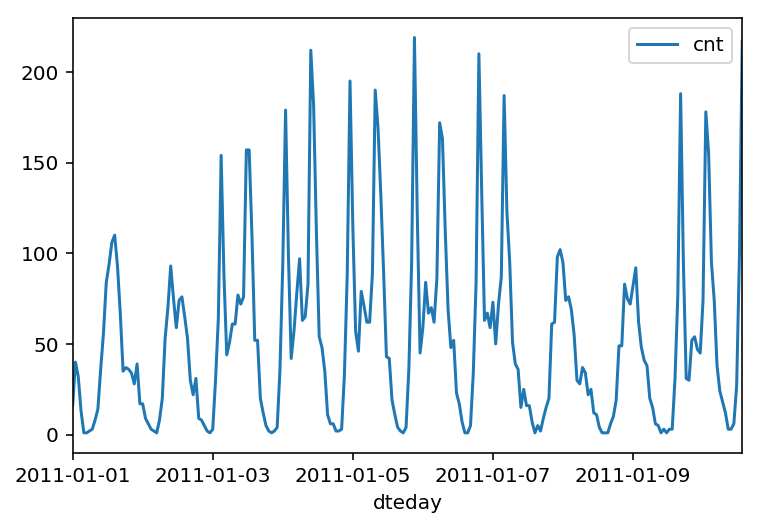

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### 虚拟变量（哑变量）

下面是一些分类变量，例如季节、天气、月份。要在我们的模型中包含这些数据，我们需要创建二进制虚拟变量。用 Pandas 库中的 `get_dummies()` 就可以轻松实现。

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0   0        0  0.24  0.81        0.0       3          13   16         1   
1   0        0  0.22  0.80        0.0       8          32   40         1   
2   0        0  0.22  0.80        0.0       5          27   32         1   
3   0        0  0.24  0.75        0.0       3          10   13         1   
4   0        0  0.24  0.75        0.0       0           1    1         1   

   season_2    ...      hr_21  hr_22  hr_23  weekday_0  weekday_1  weekday_2  \
0         0    ...          0      0      0          0          0          0   
1         0    ...          0      0      0          0          0          0   
2         0    ...          0      0      0          0          0          0   
3         0    ...          0      0      0          0          0          0   
4         0    ...          0      0      0          0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  
0          0          0          0          1  
1          0          0          0          1  
2          0          0          0          1  
3          0          0          0          1  
4          0          0          0          1  

[5 rows x 59 columns]

### 调整目标变量

为了更轻松地训练网络，我们将对每个连续变量标准化，即转换和调整变量，使它们的均值为 0，标准差为 1。

我们会保存换算因子，以便当我们使用网络进行预测时可以还原数据。

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### 将数据拆分为训练、测试和验证数据集

我们将大约最后 21 天的数据保存为测试数据集，这些数据集会在训练完网络后使用。我们将使用该数据集进行预测，并与实际的骑行人数进行对比。

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

我们将数据拆分为两个数据集，一个用作训练，一个在网络训练完后用来验证网络。因为数据是有时间序列特性的，所以我们用历史数据进行训练，然后尝试预测未来数据（验证数据集）。

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 开始构建网络

下面你将构建自己的网络。我们已经构建好结构和反向传递部分。你将实现网络的前向传递部分。还需要设置超参数：学习速率、隐藏单元的数量，以及训练传递数量。

<img src="assets/neural_network.png" width=300px>

该网络有两个层级，一个隐藏层和一个输出层。隐藏层级将使用 S 型函数作为激活函数。输出层只有一个节点，用于递归，节点的输出和节点的输入相同。即激活函数是 $f(x)=x$。这种函数获得输入信号，并生成输出信号，但是会考虑阈值，称为激活函数。我们完成网络的每个层级，并计算每个神经元的输出。一个层级的所有输出变成下一层级神经元的输入。这一流程叫做前向传播（forward propagation）。

我们在神经网络中使用权重将信号从输入层传播到输出层。我们还使用权重将错误从输出层传播回网络，以便更新权重。这叫做反向传播（backpropagation）。

> **提示**：你需要为反向传播实现计算输出激活函数 ($f(x) = x$) 的导数。如果你不熟悉微积分，其实该函数就等同于等式 $y = x$。该等式的斜率是多少？也就是导数 $f(x)$。


你需要完成以下任务：

1. 实现 S 型激活函数。将 `__init__` 中的 `self.activation_function`  设为你的 S 型函数。
2. 在 `train` 方法中实现前向传递。
3. 在 `train` 方法中实现反向传播算法，包括计算输出错误。
4. 在 `run` 方法中实现前向传递。

  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : (1 / (1 + np.exp(-x)))# Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            output_error_term = error * 1
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output,output_error_term)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.

            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]


        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
        
        print(self.weights_hidden_to_output)
        print(self.weights_input_to_hidden)
        
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 单元测试

运行这些单元测试，检查你的网络实现是否正确。这样可以帮助你确保网络已正确实现，然后再开始训练网络。这些测试必须成功才能通过此项目。

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.37275328]
 [-0.03172939]]
[[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]



----------------------------------------------------------------------
Ran 5 tests in 0.030s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## 训练网络

现在你将设置网络的超参数。策略是设置的超参数使训练集上的错误很小但是数据不会过拟合。如果网络训练时间太长，或者有太多的隐藏节点，可能就会过于针对特定训练集，无法泛化到验证数据集。即当训练集的损失降低时，验证集的损失将开始增大。

你还将采用随机梯度下降 (SGD) 方法训练网络。对于每次训练，都获取随机样本数据，而不是整个数据集。与普通梯度下降相比，训练次数要更多，但是每次时间更短。这样的话，网络训练效率更高。稍后你将详细了解 SGD。


### 选择迭代次数

也就是训练网络时从训练数据中抽样的批次数量。迭代次数越多，模型就与数据越拟合。但是，如果迭代次数太多，模型就无法很好地泛化到其他数据，这叫做过拟合。你需要选择一个使训练损失很低并且验证损失保持中等水平的数字。当你开始过拟合时，你会发现训练损失继续下降，但是验证损失开始上升。

### 选择学习速率

速率可以调整权重更新幅度。如果速率太大，权重就会太大，导致网络无法与数据相拟合。建议从 0.1 开始。如果网络在与数据拟合时遇到问题，尝试降低学习速率。注意，学习速率越低，权重更新的步长就越小，神经网络收敛的时间就越长。


### 选择隐藏节点数量

隐藏节点越多，模型的预测结果就越准确。尝试不同的隐藏节点的数量，看看对性能有何影响。你可以查看损失字典，寻找网络性能指标。如果隐藏单元的数量太少，那么模型就没有足够的空间进行学习，如果太多，则学习方向就有太多的选择。选择隐藏单元数量的技巧在于找到合适的平衡点。

In [12]:
import sys

### Set the hyperparameters here ###
iterations = 2000
learning_rate = 0.1
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[[ 0.23771911]
 [-0.72393239]]
[[ 0.04866095 -0.11345537]
 [ 0.1740559   0.12115503]
 [ 0.11037908 -0.00324995]
 [ 0.0151641  -0.11544714]
 [ 0.31641977  0.19273132]
 [-0.06595229  0.11647149]
 [ 0.02820947  0.07663907]
 [-0.09287544  0.36708086]
 [-0.14293203  0.19294254]
 [ 0.07640221  0.20263615]
 [-0.20134417  0.00524858]
 [-0.00963441  0.22701097]
 [ 0.02383721  0.05818308]
 [ 0.28471107  0.1456843 ]
 [ 0.00721031  0.01180005]
 [ 0.21287577  0.13117441]
 [-0.20963835  0.15501268]
 [ 0.14430014  0.09136606]
 [ 0.31230523 -0.17690444]
 [ 0.08410356  0.0866746 ]
 [-0.00878901 -0.02446706]
 [ 0.05040433 -0.0670186 ]
 [-0.00674573  0.16576016]
 [ 0.2245079  -0.11878788]
 [-0.15779833  0.03710688]
 [ 0.04622682  0.20468201]
 [ 0.03170169  0.18061035]
 [ 0.03191708 -0.05995695]
 [ 0.11920486 -0.09990749]
 [-0.17095542  0.0077873 ]
 [-0.00883469 -0.08740424]
 [-0.1484429  -0.16451762]
 [-0.17864007  0.05836776]
 [-0.16484259 -0.03691528]
 [ 0.18068574  0.01733816]
 [-0.06179372  0.0711769

C:\Users\KevinRuan\AppData\Local\conda\conda\envs\flappybird\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


[[ 0.25274753]
 [-0.707722  ]]
[[ 0.04976461 -0.11692632]
 [ 0.17408925  0.12107114]
 [ 0.11299133 -0.01116882]
 [ 0.01378997 -0.1112231 ]
 [ 0.31633564  0.19303727]
 [-0.0663265   0.11758143]
 [ 0.02850005  0.07579137]
 [-0.09161259  0.36324346]
 [-0.1427437   0.19235733]
 [ 0.07749569  0.1994034 ]
 [-0.20120241  0.0047196 ]
 [-0.00950209  0.22661235]
 [ 0.02383721  0.05818308]
 [ 0.28444649  0.1464562 ]
 [ 0.00720975  0.01179552]
 [ 0.21273147  0.13161996]
 [-0.20941891  0.1543658 ]
 [ 0.14442388  0.09100136]
 [ 0.31234805 -0.17711021]
 [ 0.08444698  0.0856664 ]
 [-0.00834916 -0.02572372]
 [ 0.05092376 -0.06866313]
 [-0.00662328  0.16538783]
 [ 0.22442453 -0.11853099]
 [-0.15774912  0.03697577]
 [ 0.04604701  0.20518478]
 [ 0.03165624  0.18075121]
 [ 0.03187971 -0.05984138]
 [ 0.11903796 -0.09938384]
 [-0.17114679  0.00836763]
 [-0.00897355 -0.08699104]
 [-0.1485571  -0.16417555]
 [-0.17852848  0.05804233]
 [-0.16467588 -0.0374182 ]
 [ 0.18089372  0.01675127]
 [-0.06174106  0.0710071

Progress: 0.3% ... Training loss: 0.988 ... Validation loss: 1.508[[ 0.3442244 ]
 [-0.62087854]]
[[ 0.05916465 -0.13987872]
 [ 0.17451083  0.11996141]
 [ 0.13307837 -0.05641749]
 [ 0.00213375 -0.08432019]
 [ 0.31933294  0.18442651]
 [-0.0691675   0.12312766]
 [ 0.03239368  0.06558292]
 [-0.08488099  0.34821701]
 [-0.14184926  0.19050035]
 [ 0.08520376  0.1803694 ]
 [-0.19962475  0.00091121]
 [-0.01008615  0.22782975]
 [ 0.02381421  0.05826242]
 [ 0.28339965  0.14845402]
 [ 0.00618145  0.01394237]
 [ 0.21183399  0.13303628]
 [-0.20893279  0.153056  ]
 [ 0.14655823  0.08565596]
 [ 0.31449353 -0.18260771]
 [ 0.08692853  0.08041247]
 [-0.0060994  -0.0306778 ]
 [ 0.05274184 -0.07272607]
 [-0.00587255  0.16381191]
 [ 0.22418473 -0.11804085]
 [-0.15792411  0.03737855]
 [ 0.0451345   0.20714313]
 [ 0.03070655  0.1826446 ]
 [ 0.0306574  -0.05727   ]
 [ 0.11758174 -0.09605273]
 [-0.17262287  0.01146426]
 [-0.01017944 -0.08438012]
 [-0.14935712 -0.16253586]
 [-0.17724846  0.05534124]
 [-0.1629471

Progress: 0.6% ... Training loss: 0.957 ... Validation loss: 1.448[[ 0.40184858]
 [-0.57602285]]
[[ 0.06687301 -0.15364308]
 [ 0.17418156  0.12045518]
 [ 0.151278   -0.08710212]
 [-0.01263704 -0.05885598]
 [ 0.32465311  0.17486421]
 [-0.07193551  0.12736625]
 [ 0.03492237  0.06068927]
 [-0.07971411  0.33944029]
 [-0.14075205  0.18850785]
 [ 0.09108817  0.16946303]
 [-0.19822621 -0.00157476]
 [-0.01134434  0.22979782]
 [ 0.02381421  0.05826242]
 [ 0.28244782  0.14986141]
 [ 0.00501977  0.01578652]
 [ 0.211488    0.13326475]
 [-0.20800003  0.15154223]
 [ 0.14716543  0.08442964]
 [ 0.31536513 -0.18439883]
 [ 0.08871788  0.07739131]
 [-0.00428384 -0.03371197]
 [ 0.05568244 -0.0777538 ]
 [-0.00577526  0.1635796 ]
 [ 0.2238438  -0.11751177]
 [-0.15815326  0.03779179]
 [ 0.04402056  0.20890282]
 [ 0.02954813  0.18450324]
 [ 0.02944147 -0.05537464]
 [ 0.11563566 -0.09283088]
 [-0.17452812  0.01448744]
 [-0.0109074  -0.0831633 ]
 [-0.15027169 -0.16109091]
 [-0.17711231  0.05507687]
 [-0.1609632

Progress: 0.8% ... Training loss: 0.938 ... Validation loss: 1.415[[ 0.43806072]
 [-0.55583563]]
[[ 0.07543628 -0.16638583]
 [ 0.17362903  0.12113643]
 [ 0.17021298 -0.11404069]
 [-0.0274905  -0.03705878]
 [ 0.3272641   0.1698118 ]
 [-0.07644628  0.13294966]
 [ 0.03854893  0.05517688]
 [-0.07651999  0.33432935]
 [-0.13986883  0.18734009]
 [ 0.09469106  0.16282682]
 [-0.19754402 -0.00258559]
 [-0.01243628  0.23123717]
 [ 0.02381421  0.05826242]
 [ 0.28103967  0.15151749]
 [ 0.00346481  0.0178581 ]
 [ 0.21038876  0.13459273]
 [-0.20623903  0.14901598]
 [ 0.14883392  0.08192854]
 [ 0.31636112 -0.18621237]
 [ 0.08953662  0.07604846]
 [-0.00322893 -0.03538593]
 [ 0.05708636 -0.07973786]
 [-0.00535368  0.16302441]
 [ 0.22381044 -0.11750826]
 [-0.15898907  0.03892191]
 [ 0.04265269  0.21066334]
 [ 0.02765626  0.18687627]
 [ 0.02678794 -0.05184077]
 [ 0.11412262 -0.09076273]
 [-0.17707843  0.01791716]
 [-0.01256608 -0.080971  ]
 [-0.15150301 -0.15937461]
 [-0.17616784  0.05381115]
 [-0.1586091

Progress: 1.1% ... Training loss: 0.925 ... Validation loss: 1.395[[ 0.47102446]
 [-0.54714883]]
[[ 0.08181018 -0.17570031]
 [ 0.17342263  0.12132222]
 [ 0.18966956 -0.13990662]
 [-0.04676148 -0.01175277]
 [ 0.33385961  0.16013155]
 [-0.08118696  0.13856269]
 [ 0.03944477  0.05330924]
 [-0.07168611  0.32725439]
 [-0.13927086  0.18648412]
 [ 0.09796169  0.15689245]
 [-0.19700464 -0.00341026]
 [-0.01465929  0.23381067]
 [ 0.02381421  0.05826242]
 [ 0.27948078  0.15334411]
 [ 0.00195138  0.01966806]
 [ 0.20904747  0.13614389]
 [-0.2061209   0.14864943]
 [ 0.14930892  0.0810119 ]
 [ 0.31731836 -0.18786015]
 [ 0.09035054  0.07485369]
 [-0.001833   -0.03740367]
 [ 0.06002422 -0.08373553]
 [-0.00504041  0.16251158]
 [ 0.22335183 -0.11692965]
 [-0.15954116  0.03962396]
 [ 0.04048972  0.21322148]
 [ 0.02515633  0.18980436]
 [ 0.02459794 -0.04911346]
 [ 0.11215726 -0.08830689]
 [-0.17976751  0.02121879]
 [-0.01477221 -0.07823159]
 [-0.15285156 -0.1576845 ]
 [-0.17551228  0.05300878]
 [-0.1553930

Progress: 1.4% ... Training loss: 0.912 ... Validation loss: 1.368[[ 0.5145298 ]
 [-0.53005865]]
[[ 0.09052943 -0.18710048]
 [ 0.17391993  0.12070008]
 [ 0.21392024 -0.16892764]
 [-0.06479729  0.01055674]
 [ 0.33474641  0.15736414]
 [-0.08573565  0.14321289]
 [ 0.04086892  0.05063929]
 [-0.0663247   0.32042893]
 [-0.13752238  0.1843703 ]
 [ 0.10350491  0.14863173]
 [-0.19562859 -0.00521203]
 [-0.01759319  0.23691413]
 [ 0.02381421  0.05826242]
 [ 0.27767135  0.15521924]
 [ 0.00060025  0.02114009]
 [ 0.20715193  0.1378488 ]
 [-0.20535682  0.14740969]
 [ 0.1497342   0.08033382]
 [ 0.31815799 -0.18929899]
 [ 0.09329107  0.07106562]
 [ 0.00042202 -0.04006862]
 [ 0.06165717 -0.08566417]
 [-0.00453672  0.16189169]
 [ 0.2231927  -0.11673054]
 [-0.15970176  0.03977199]
 [ 0.03887163  0.21490669]
 [ 0.02344847  0.19158196]
 [ 0.02268435 -0.04697671]
 [ 0.10946626 -0.08526319]
 [-0.18205813  0.02380903]
 [-0.01751254 -0.07510636]
 [-0.15441147 -0.15591476]
 [-0.17493388  0.05232431]
 [-0.1526936

Progress: 1.7% ... Training loss: 0.900 ... Validation loss: 1.344[[ 0.5363984 ]
 [-0.53622156]]
[[ 0.09822477 -0.1968149 ]
 [ 0.1732592   0.12125226]
 [ 0.23604443 -0.19293192]
 [-0.07973707  0.02675433]
 [ 0.33620591  0.1543372 ]
 [-0.09128105  0.14831071]
 [ 0.04274296  0.04778168]
 [-0.06346286  0.31662025]
 [-0.13735083  0.18401303]
 [ 0.10639444  0.14357308]
 [-0.19644921 -0.00448507]
 [-0.02030008  0.23932007]
 [ 0.02381421  0.05826242]
 [ 0.2751534   0.15758269]
 [-0.00085265  0.02257875]
 [ 0.20667309  0.13786528]
 [-0.20618106  0.14814408]
 [ 0.15179134  0.07767513]
 [ 0.31846015 -0.18985021]
 [ 0.09503635  0.06887651]
 [ 0.00119722 -0.04105327]
 [ 0.06187754 -0.08605055]
 [-0.00411094  0.16139787]
 [ 0.22258955 -0.11615934]
 [-0.15998858  0.03998592]
 [ 0.03646917  0.21721251]
 [ 0.02102782  0.19393334]
 [ 0.02077022 -0.0450862 ]
 [ 0.10616584 -0.08190573]
 [-0.18503544  0.02679571]
 [-0.01891584 -0.07369929]
 [-0.15602568 -0.15425525]
 [-0.17360227  0.05093444]
 [-0.1501766

Progress: 1.9% ... Training loss: 0.891 ... Validation loss: 1.346[[ 0.54977126]
 [-0.55413294]]
[[ 0.10552157 -0.20589126]
 [ 0.17248765  0.12186684]
 [ 0.25487721 -0.21361065]
 [-0.09449295  0.04400849]
 [ 0.33801002  0.1505389 ]
 [-0.09692374  0.15361389]
 [ 0.04341626  0.04615976]
 [-0.0610025   0.31311991]
 [-0.1374698   0.18399763]
 [ 0.10715532  0.14077188]
 [-0.19849861 -0.00252689]
 [-0.02163956  0.24032861]
 [ 0.02381421  0.05826242]
 [ 0.27293923  0.15963799]
 [-0.0028357   0.02457156]
 [ 0.20566405  0.1384385 ]
 [-0.20620907  0.14798322]
 [ 0.15288263  0.07618316]
 [ 0.31825142 -0.19009093]
 [ 0.09624496  0.06742778]
 [ 0.00253979 -0.04279725]
 [ 0.06202896 -0.08629564]
 [-0.00411738  0.16125543]
 [ 0.2225247  -0.11609811]
 [-0.16089619  0.04094268]
 [ 0.03439975  0.21923867]
 [ 0.0192706   0.19569562]
 [ 0.01808722 -0.04227856]
 [ 0.10345599 -0.07906956]
 [-0.18785323  0.02974106]
 [-0.02135181 -0.07132506]
 [-0.15749037 -0.15276577]
 [-0.17308381  0.05037317]
 [-0.1470126

Progress: 2.2% ... Training loss: 0.877 ... Validation loss: 1.335[[ 0.56599286]
 [-0.58364325]]
[[ 0.1112055  -0.21450599]
 [ 0.17221571  0.12185278]
 [ 0.27937677 -0.24192599]
 [-0.11726706  0.07087027]
 [ 0.34371042  0.14042786]
 [-0.1038197   0.16004882]
 [ 0.04327647  0.04446012]
 [-0.05905255  0.30987371]
 [-0.13783766  0.18441609]
 [ 0.1057311   0.13903105]
 [-0.20044606 -0.00084002]
 [-0.02372155  0.24229013]
 [ 0.02381421  0.05826242]
 [ 0.26973837  0.16253082]
 [-0.00480312  0.02658739]
 [ 0.20399371  0.13977101]
 [-0.2064555   0.14779613]
 [ 0.15248655  0.07609397]
 [ 0.3195551  -0.19247992]
 [ 0.09706921  0.06607751]
 [ 0.00355699 -0.04415605]
 [ 0.06308244 -0.08754287]
 [-0.0039828   0.16111753]
 [ 0.22151718 -0.11510148]
 [-0.16219439  0.04237188]
 [ 0.03253245  0.22104956]
 [ 0.01683433  0.19807107]
 [ 0.01481493 -0.03885035]
 [ 0.10024223 -0.07568504]
 [-0.19141415  0.03335884]
 [-0.02456177 -0.06796905]
 [-0.15915406 -0.15097925]
 [-0.17266963  0.04992461]
 [-0.1448947

Progress: 2.5% ... Training loss: 0.867 ... Validation loss: 1.332[[ 0.57420325]
 [-0.60660605]]
[[  1.16130229e-01  -2.21502871e-01]
 [  1.72315487e-01   1.21547528e-01]
 [  2.97015864e-01  -2.62451111e-01]
 [ -1.33448183e-01   8.96371096e-02]
 [  3.46542980e-01   1.35096849e-01]
 [ -1.09030482e-01   1.65105163e-01]
 [  4.14806310e-02   4.55577297e-02]
 [ -5.66010157e-02   3.05807215e-01]
 [ -1.37725453e-01   1.84236677e-01]
 [  1.04771242e-01   1.37771112e-01]
 [ -2.01554574e-01   1.33883602e-04]
 [ -2.60960590e-02   2.44484208e-01]
 [  2.38142086e-02   5.82624162e-02]
 [  2.67905608e-01   1.64164930e-01]
 [ -6.67920911e-03   2.85600100e-02]
 [  2.02518375e-01   1.40987751e-01]
 [ -2.06305481e-01   1.47536647e-01]
 [  1.52416689e-01   7.57564212e-02]
 [  3.17779803e-01  -1.90912086e-01]
 [  9.84282996e-02   6.39622505e-02]
 [  4.70861296e-03  -4.56298105e-02]
 [  6.40588118e-02  -8.88150586e-02]
 [ -3.38208606e-03   1.60465098e-01]
 [  2.20492510e-01  -1.14091949e-01]
 [ -1.62821075e

Progress: 2.8% ... Training loss: 0.855 ... Validation loss: 1.328[[ 0.59184215]
 [-0.63438888]]
[[ 0.11981153 -0.22788856]
 [ 0.17225059  0.1215202 ]
 [ 0.31767006 -0.28708868]
 [-0.15324692  0.11368054]
 [ 0.34814809  0.13003552]
 [-0.11505902  0.17082044]
 [ 0.0404904   0.04515763]
 [-0.05463614  0.30213651]
 [-0.13752317  0.18380093]
 [ 0.10272167  0.13658558]
 [-0.20255598  0.00095139]
 [-0.0278967   0.24606096]
 [ 0.02381421  0.05826242]
 [ 0.26542928  0.16646609]
 [-0.00874747  0.03062417]
 [ 0.20113529  0.1421129 ]
 [-0.2074515   0.14856236]
 [ 0.1531997   0.07418828]
 [ 0.31742715 -0.19117007]
 [ 0.09892448  0.06280009]
 [ 0.00598894 -0.04733263]
 [ 0.06404624 -0.08917258]
 [-0.00234366  0.15925022]
 [ 0.22019851 -0.11382474]
 [-0.16353772  0.04367863]
 [ 0.0289653   0.22463883]
 [ 0.01268743  0.20221295]
 [ 0.00952021 -0.03322328]
 [ 0.09504022 -0.07010247]
 [-0.19724932  0.0395128 ]
 [-0.03037701 -0.06186187]
 [-0.16222875 -0.14766723]
 [-0.17276288  0.04993839]
 [-0.1414778

Progress: 3.0% ... Training loss: 0.843 ... Validation loss: 1.315[[ 0.62377583]
 [-0.64667581]]
[[ 0.12725835 -0.23856388]
 [ 0.17162937  0.12205628]
 [ 0.33967133 -0.31270771]
 [-0.16529148  0.12951901]
 [ 0.35337471  0.12067106]
 [-0.12051447  0.17538421]
 [ 0.04210008  0.04219602]
 [-0.05240184  0.29826142]
 [-0.1370301   0.18305494]
 [ 0.10278514  0.13308028]
 [-0.20300671  0.00106319]
 [-0.02854377  0.24636528]
 [ 0.02373015  0.05833268]
 [ 0.2628752   0.16854107]
 [-0.01116069  0.03313627]
 [ 0.2004343   0.14233146]
 [-0.20674205  0.14753449]
 [ 0.15576255  0.07083525]
 [ 0.31710852 -0.19145328]
 [ 0.09900411  0.06220172]
 [ 0.00733776 -0.04928516]
 [ 0.06518926 -0.09063117]
 [-0.0017968   0.15852833]
 [ 0.21965025 -0.11329509]
 [-0.16451158  0.0447199 ]
 [ 0.02641658  0.22719103]
 [ 0.00997235  0.20478521]
 [ 0.00684132 -0.03034059]
 [ 0.09206036 -0.06683992]
 [-0.20037214  0.04279462]
 [-0.03388815 -0.05814471]
 [-0.16397115 -0.14581798]
 [-0.17253855  0.04969968]
 [-0.1371895

Progress: 3.4% ... Training loss: 0.831 ... Validation loss: 1.319[[ 0.62940083]
 [-0.68642791]]
[[ 0.13070392 -0.2446445 ]
 [ 0.17144695  0.12211663]
 [ 0.36039952 -0.33718076]
 [-0.18177045  0.14936083]
 [ 0.35459235  0.11659249]
 [-0.12748717  0.18214296]
 [ 0.03988272  0.04361119]
 [-0.05168754  0.29619917]
 [-0.13500849  0.18052773]
 [ 0.1004986   0.13253053]
 [-0.2044508   0.00243796]
 [-0.03126729  0.24912471]
 [ 0.02373015  0.05833268]
 [ 0.26028169  0.17094311]
 [-0.01396852  0.03592374]
 [ 0.19915758  0.14358977]
 [-0.20732943  0.14794611]
 [ 0.15599864  0.06990373]
 [ 0.31546605 -0.18975256]
 [ 0.09951691  0.06129917]
 [ 0.00799738 -0.05043915]
 [ 0.06639457 -0.09263201]
 [-0.00100382  0.15763313]
 [ 0.21945942 -0.11315707]
 [-0.16527378  0.04549028]
 [ 0.02390013  0.22986162]
 [ 0.0066844   0.20833896]
 [ 0.00317121 -0.02647701]
 [ 0.08941181 -0.06397938]
 [-0.20360298  0.04618622]
 [-0.03724389 -0.05458672]
 [-0.16674801 -0.14278192]
 [-0.17177303  0.04882421]
 [-0.1342058

Progress: 3.6% ... Training loss: 0.820 ... Validation loss: 1.316[[ 0.64550226]
 [-0.71093587]]
[[  1.33821180e-01  -2.50354537e-01]
 [  1.70838974e-01   1.22701481e-01]
 [  3.78020007e-01  -3.58896865e-01]
 [ -1.91942878e-01   1.62505253e-01]
 [  3.58142357e-01   1.09789205e-01]
 [ -1.33630985e-01   1.88470186e-01]
 [  3.94931295e-02   4.30726821e-02]
 [ -4.82972038e-02   2.90822313e-01]
 [ -1.35497633e-01   1.80898285e-01]
 [  9.89104909e-02   1.31591016e-01]
 [ -2.04458492e-01   2.31521723e-03]
 [ -3.33156226e-02   2.50982684e-01]
 [  2.37420679e-02   5.83193858e-02]
 [  2.57887808e-01   1.73301506e-01]
 [ -1.59521952e-02   3.81895684e-02]
 [  1.97346438e-01   1.45239562e-01]
 [ -2.05871370e-01   1.46106046e-01]
 [  1.54965542e-01   7.07996372e-02]
 [  3.15708992e-01  -1.90799371e-01]
 [  9.92435444e-02   6.15006498e-02]
 [  9.92459962e-03  -5.33190565e-02]
 [  6.69731158e-02  -9.36419370e-02]
 [ -2.93504949e-04   1.56631103e-01]
 [  2.18993226e-01  -1.12664689e-01]
 [ -1.65861710e

Progress: 3.8% ... Training loss: 0.811 ... Validation loss: 1.308[[ 0.65745566]
 [-0.73338496]]
[[  1.37292554e-01  -2.56533619e-01]
 [  1.70693120e-01   1.22775078e-01]
 [  3.90501953e-01  -3.74976448e-01]
 [ -2.03015105e-01   1.76945953e-01]
 [  3.63699609e-01   9.96844680e-02]
 [ -1.37789945e-01   1.92615820e-01]
 [  3.83454149e-02   4.30585626e-02]
 [ -4.73958604e-02   2.88011152e-01]
 [ -1.35433367e-01   1.80543773e-01]
 [  9.62388753e-02   1.31431413e-01]
 [ -2.05018260e-01   2.67152259e-03]
 [ -3.44253039e-02   2.51751823e-01]
 [  2.37420679e-02   5.83193858e-02]
 [  2.55471338e-01   1.75690074e-01]
 [ -1.69375228e-02   3.92675220e-02]
 [  1.96265560e-01   1.46129612e-01]
 [ -2.05599373e-01   1.45665078e-01]
 [  1.54686052e-01   7.06502264e-02]
 [  3.14825055e-01  -1.90822149e-01]
 [  9.84111470e-02   6.19728111e-02]
 [  1.01148896e-02  -5.40141111e-02]
 [  6.89744801e-02  -9.63879563e-02]
 [  3.24171315e-04   1.55844703e-01]
 [  2.18128430e-01  -1.11726604e-01]
 [ -1.65940808e

Progress: 4.0% ... Training loss: 0.799 ... Validation loss: 1.298[[ 0.69859962]
 [-0.74186719]]
[[ 0.14395675 -0.26690508]
 [ 0.17045982  0.12286579]
 [ 0.40881051 -0.397857  ]
 [-0.2206265   0.20035002]
 [ 0.36879168  0.09068105]
 [-0.14207512  0.19620683]
 [ 0.03907568  0.04094303]
 [-0.04427459  0.28262953]
 [-0.13386292  0.17857938]
 [ 0.0986967   0.12485256]
 [-0.2052997   0.00256081]
 [-0.03546488  0.25257086]
 [ 0.02374207  0.05831939]
 [ 0.25279209  0.17817012]
 [-0.01805676  0.04031111]
 [ 0.19582822  0.1460937 ]
 [-0.20436846  0.1436888 ]
 [ 0.15552712  0.06932287]
 [ 0.31384295 -0.1901815 ]
 [ 0.09857405  0.06147568]
 [ 0.0120299  -0.05722849]
 [ 0.07137816 -0.09940981]
 [ 0.00054223  0.1555907 ]
 [ 0.21790732 -0.11158312]
 [-0.16613661  0.04637592]
 [ 0.01846087  0.23557394]
 [ 0.00118926  0.21409097]
 [-0.00582018 -0.01638395]
 [ 0.08190135 -0.05579774]
 [-0.21121256  0.05449077]
 [-0.04391301 -0.04737282]
 [-0.17038848 -0.13870502]
 [-0.16924134  0.0458543 ]
 [-0.1264482

Progress: 4.3% ... Training loss: 0.787 ... Validation loss: 1.278[[ 0.72852448]
 [-0.75951344]]
[[ 0.15057148 -0.27665698]
 [ 0.17057639  0.12236619]
 [ 0.4284233  -0.4205224 ]
 [-0.2313595   0.21394833]
 [ 0.36417697  0.09212832]
 [-0.14794643  0.20129947]
 [ 0.03880773  0.03967744]
 [-0.03962381  0.27635864]
 [-0.13308335  0.17736587]
 [ 0.10012597  0.1200873 ]
 [-0.20594505  0.00280132]
 [-0.03695771  0.25343825]
 [ 0.02374207  0.05831939]
 [ 0.25033557  0.18030099]
 [-0.01937123  0.04148879]
 [ 0.19429496  0.14722287]
 [-0.20489228  0.14367836]
 [ 0.1558623   0.0683185 ]
 [ 0.31379109 -0.19040319]
 [ 0.09820969  0.06138684]
 [ 0.01437723 -0.06017401]
 [ 0.07446539 -0.10301764]
 [ 0.00053665  0.15543271]
 [ 0.21804998 -0.11184094]
 [-0.16650803  0.04657534]
 [ 0.01577273  0.2383769 ]
 [-0.00113544  0.21642343]
 [-0.00781047 -0.01429164]
 [ 0.07859962 -0.05222502]
 [-0.21344524  0.05675457]
 [-0.0466754  -0.04448992]
 [-0.17200175 -0.13701008]
 [-0.16881682  0.0453155 ]
 [-0.1223412

 [-0.78883803]]
[[  1.53617335e-01  -2.81823740e-01]
 [  1.69982164e-01   1.22539582e-01]
 [  4.40897483e-01  -4.35186757e-01]
 [ -2.42201257e-01   2.26552275e-01]
 [  3.62710252e-01   9.10342047e-02]
 [ -1.51489718e-01   2.04526878e-01]
 [  3.86265678e-02   3.85779783e-02]
 [ -4.01439648e-02   2.75916970e-01]
 [ -1.34067100e-01   1.78025275e-01]
 [  9.94820039e-02   1.18401259e-01]
 [ -2.07414715e-01   4.01895478e-03]
 [ -4.00724356e-02   2.56252338e-01]
 [  2.37420679e-02   5.83193858e-02]
 [  2.49190396e-01   1.81283314e-01]
 [ -2.02250872e-02   4.22173276e-02]
 [  1.93763944e-01   1.47404936e-01]
 [ -2.05831571e-01   1.44245943e-01]
 [  1.55952905e-01   6.78885320e-02]
 [  3.13735425e-01  -1.90535810e-01]
 [  9.76765034e-02   6.15148528e-02]
 [  1.41259661e-02  -6.00713758e-02]
 [  7.52946392e-02  -1.04351512e-01]
 [ -3.47337170e-05   1.55877959e-01]
 [  2.17329371e-01  -1.11115201e-01]
 [ -1.67054795e-01   4.69553353e-02]
 [  1.39872638e-02   2.40291291e-01]
 [ -3.06152240e-03   2

Progress: 4.8% ... Training loss: 0.768 ... Validation loss: 1.274[[ 0.75812061]
 [-0.81441129]]
[[ 0.16037657 -0.29128842]
 [ 0.1695935   0.12282832]
 [ 0.45934816 -0.45595618]
 [-0.25583918  0.24221932]
 [ 0.35970233  0.09131914]
 [-0.15722103  0.2095413 ]
 [ 0.0391583   0.03700045]
 [-0.03974029  0.27421919]
 [-0.13171845  0.1750734 ]
 [ 0.09700052  0.11831052]
 [-0.20616092  0.00217855]
 [-0.04129199  0.25697071]
 [ 0.02374207  0.05831939]
 [ 0.2469742   0.18321332]
 [-0.02279276  0.04485243]
 [ 0.19229403  0.14848683]
 [-0.20436828  0.14202783]
 [ 0.1558045   0.06770026]
 [ 0.31317377 -0.18989065]
 [ 0.09624055  0.06265929]
 [ 0.01622605 -0.06301581]
 [ 0.07612791 -0.10554903]
 [ 0.00198328  0.15343327]
 [ 0.21753153 -0.11143827]
 [-0.16771906  0.04762206]
 [ 0.01122415  0.24327048]
 [-0.00627212  0.22158528]
 [-0.01282955 -0.00877393]
 [ 0.07201583 -0.0452651 ]
 [-0.21745909  0.06093492]
 [-0.05231646 -0.03847437]
 [-0.17545254 -0.13335145]
 [-0.16862017  0.04489073]
 [-0.1156060

Progress: 5.0% ... Training loss: 0.756 ... Validation loss: 1.266[[ 0.77743828]
 [-0.84564577]]
[[ 0.16466091 -0.29739935]
 [ 0.16848014  0.12388554]
 [ 0.47591526 -0.47510589]
 [-0.27024627  0.25985283]
 [ 0.36012285  0.08626352]
 [-0.16232353  0.21397007]
 [ 0.03887409  0.03583036]
 [-0.03958937  0.27318274]
 [-0.13122828  0.17418834]
 [ 0.09568365  0.11682647]
 [-0.20704035  0.00292963]
 [-0.04367589  0.25894431]
 [ 0.02357664  0.05841594]
 [ 0.24527065  0.18438218]
 [-0.02512402  0.04722306]
 [ 0.19147446  0.1488218 ]
 [-0.20506918  0.14238527]
 [ 0.15581396  0.06718069]
 [ 0.31318862 -0.19026188]
 [ 0.09719322  0.06115304]
 [ 0.01499286 -0.06200145]
 [ 0.07723545 -0.10685403]
 [ 0.00266056  0.15254709]
 [ 0.21665344 -0.11057144]
 [-0.16755993  0.04743438]
 [ 0.00853729  0.24598229]
 [-0.00919244  0.22461664]
 [-0.01510487 -0.0063587 ]
 [ 0.06737507 -0.04032219]
 [-0.22134954  0.06503693]
 [-0.05613204 -0.03440393]
 [-0.17683857 -0.13180131]
 [-0.16825371  0.04430327]
 [-0.1083869

Progress: 5.3% ... Training loss: 0.745 ... Validation loss: 1.259[[ 0.79590424]
 [-0.87685759]]
[[ 0.16743864 -0.3036566 ]
 [ 0.168541    0.12345352]
 [ 0.48970152 -0.49309357]
 [-0.2864785   0.27940429]
 [ 0.36151916  0.08018477]
 [-0.16760273  0.21884051]
 [ 0.03747143  0.03542475]
 [-0.04142173  0.27364113]
 [-0.12903872  0.17161599]
 [ 0.0944212   0.11452192]
 [-0.20944299  0.00536836]
 [-0.04637011  0.26119821]
 [ 0.0236113   0.05837872]
 [ 0.24312409  0.18635955]
 [-0.0265408   0.04862775]
 [ 0.19116356  0.14866749]
 [-0.20556003  0.14228079]
 [ 0.156275    0.06563018]
 [ 0.31017135 -0.1869665 ]
 [ 0.09785207  0.05944717]
 [ 0.01315633 -0.06033026]
 [ 0.07832103 -0.10847469]
 [ 0.00396729  0.15111314]
 [ 0.21640688 -0.11037892]
 [-0.16793133  0.04781387]
 [ 0.00633165  0.24850149]
 [-0.01318581  0.22896678]
 [-0.01928468 -0.00190101]
 [ 0.0623979  -0.03462074]
 [-0.22447566  0.06840456]
 [-0.0585962  -0.03177008]
 [-0.17881264 -0.12963087]
 [-0.16656403  0.04244062]
 [-0.1056456

Progress: 5.6% ... Training loss: 0.736 ... Validation loss: 1.245[[ 0.82970458]
 [-0.8868851 ]]
[[ 0.17202543 -0.31126062]
 [ 0.16842601  0.12343467]
 [ 0.50321753 -0.50952982]
 [-0.30254056  0.29990551]
 [ 0.36047822  0.07732956]
 [-0.17119789  0.22184059]
 [ 0.03797712  0.03337346]
 [-0.04120814  0.27230989]
 [-0.12606151  0.16777312]
 [ 0.09481429  0.11094183]
 [-0.20787712  0.00305684]
 [-0.04822775  0.26286451]
 [ 0.0236113   0.05837872]
 [ 0.24177892  0.18747772]
 [-0.02842938  0.05048404]
 [ 0.19051672  0.1489591 ]
 [-0.20426738  0.14019156]
 [ 0.15702906  0.0642154 ]
 [ 0.30919404 -0.18632193]
 [ 0.0971429   0.05987942]
 [ 0.01488155 -0.06268964]
 [ 0.07769199 -0.10770122]
 [ 0.00638506  0.14810815]
 [ 0.21630309 -0.11038746]
 [-0.16771982  0.04734914]
 [ 0.00424884  0.25067839]
 [-0.01563835  0.23161531]
 [-0.02210926  0.00110095]
 [ 0.0596847  -0.03151357]
 [-0.22677435  0.07104452]
 [-0.06236935 -0.0276897 ]
 [-0.18073313 -0.12747677]
 [-0.16410476  0.03969712]
 [-0.1027057

Progress: 5.9% ... Training loss: 0.725 ... Validation loss: 1.238[[ 0.84895406]
 [-0.92545142]]
[[ 0.17573506 -0.31812812]
 [ 0.16776132  0.12392603]
 [ 0.51866241 -0.527701  ]
 [-0.32007709  0.32105042]
 [ 0.35870447  0.07614864]
 [-0.17683082  0.22682311]
 [ 0.03674878  0.03427187]
 [-0.04245507  0.27176491]
 [-0.12517618  0.16644695]
 [ 0.09238773  0.11002482]
 [-0.2101785   0.00564363]
 [-0.05072268  0.2652045 ]
 [ 0.0236113   0.05837872]
 [ 0.23972967  0.18910862]
 [-0.03038226  0.05255266]
 [ 0.18866715  0.1504351 ]
 [-0.20435331  0.14021368]
 [ 0.1568907   0.06399355]
 [ 0.30789848 -0.18528081]
 [ 0.09557274  0.06137331]
 [ 0.01506853 -0.06356234]
 [ 0.07966746 -0.11047209]
 [ 0.00695443  0.14727931]
 [ 0.2158808  -0.1099321 ]
 [-0.16831049  0.04786517]
 [ 0.00104002  0.25409005]
 [-0.01899983  0.23519641]
 [-0.0250697   0.00428799]
 [ 0.05720986 -0.02885355]
 [-0.23085147  0.07536302]
 [-0.06701342 -0.02260322]
 [-0.18358055 -0.12442106]
 [-0.16278542  0.03837357]
 [-0.1002459

Progress: 6.2% ... Training loss: 0.717 ... Validation loss: 1.239[[ 0.87430179]
 [-0.94307982]]
[[ 0.17932019 -0.32505913]
 [ 0.16725379  0.12436282]
 [ 0.53114289 -0.5431441 ]
 [-0.33027097  0.33531795]
 [ 0.35847633  0.07224765]
 [-0.17965786  0.22919076]
 [ 0.03525986  0.03484349]
 [-0.04131737  0.2686812 ]
 [-0.12374629  0.16421862]
 [ 0.08894167  0.11042935]
 [-0.20781775  0.00264121]
 [-0.05143159  0.26547918]
 [ 0.02365715  0.05832917]
 [ 0.23770703  0.19091514]
 [-0.0307602   0.05272455]
 [ 0.18871648  0.15020425]
 [-0.2052716   0.14082553]
 [ 0.15746597  0.06293251]
 [ 0.30598716 -0.18362726]
 [ 0.09487531  0.06173743]
 [ 0.0159295  -0.06511047]
 [ 0.08205308 -0.11381092]
 [ 0.00770894  0.14606728]
 [ 0.2157022  -0.10979131]
 [-0.16857835  0.04813455]
 [-0.00115965  0.25639329]
 [-0.02191856  0.23831395]
 [-0.02781833  0.00724862]
 [ 0.05396364 -0.02528272]
 [-0.23411458  0.07887352]
 [-0.0686164  -0.02084262]
 [-0.18515153 -0.1227031 ]
 [-0.16226271  0.037718  ]
 [-0.0956483

Progress: 6.5% ... Training loss: 0.709 ... Validation loss: 1.221[[ 0.90797779]
 [-0.95351735]]
[[ 0.1890008  -0.33892314]
 [ 0.16706576  0.12432558]
 [ 0.54141704 -0.55536768]
 [-0.34227925  0.35021892]
 [ 0.35617132  0.07157129]
 [-0.18349352  0.23203788]
 [ 0.03718785  0.03176287]
 [-0.04211025  0.26817506]
 [-0.12001969  0.16005897]
 [ 0.09008786  0.10594863]
 [-0.20678436  0.00130133]
 [-0.05258514  0.26640049]
 [ 0.02365715  0.05832917]
 [ 0.23538305  0.19285631]
 [-0.03188686  0.05377763]
 [ 0.18870632  0.14957205]
 [-0.20541806  0.14087519]
 [ 0.15922399  0.06010402]
 [ 0.3052346  -0.18258303]
 [ 0.093959    0.0621683 ]
 [ 0.01596469 -0.06564736]
 [ 0.08454965 -0.11679323]
 [ 0.00858245  0.14482853]
 [ 0.21614138 -0.11037345]
 [-0.16787866  0.04751702]
 [-0.00327338  0.25875288]
 [-0.02439681  0.24086603]
 [-0.03255299  0.01223937]
 [ 0.05066096 -0.02182598]
 [-0.23783274  0.08282648]
 [-0.07172167 -0.01756319]
 [-0.18643149 -0.12132651]
 [-0.15924897  0.03448678]
 [-0.0882541

Progress: 6.7% ... Training loss: 0.702 ... Validation loss: 1.208[[ 0.91847771]
 [-0.97854314]]
[[  1.90429812e-01  -3.42397713e-01]
 [  1.67156743e-01   1.24223312e-01]
 [  5.52682900e-01  -5.68046087e-01]
 [ -3.49514130e-01   3.59618347e-01]
 [  3.54458289e-01   7.11244920e-02]
 [ -1.86681754e-01   2.34677141e-01]
 [  3.38202715e-02   3.37731537e-02]
 [ -4.22360607e-02   2.67451921e-01]
 [ -1.19884094e-01   1.59625901e-01]
 [  8.58899311e-02   1.07569072e-01]
 [ -2.07590880e-01   1.99189684e-03]
 [ -5.41267003e-02   2.67582813e-01]
 [  2.36571487e-02   5.83291712e-02]
 [  2.33600437e-01   1.94395326e-01]
 [ -3.26770905e-02   5.44431237e-02]
 [  1.87773656e-01   1.50262663e-01]
 [ -2.06014197e-01   1.41094688e-01]
 [  1.58608693e-01   5.98002367e-02]
 [  3.03445200e-01  -1.80610770e-01]
 [  9.32260829e-02   6.26403251e-02]
 [  1.66734365e-02  -6.66408508e-02]
 [  8.50797405e-02  -1.17841544e-01]
 [  8.92262003e-03   1.44534364e-01]
 [  2.15288202e-01  -1.09640991e-01]
 [ -1.67911240e

Progress: 6.9% ... Training loss: 0.698 ... Validation loss: 1.213[[ 0.93179337]
 [-0.99441302]]
[[ 0.19394038 -0.34844393]
 [ 0.16749552  0.12366654]
 [ 0.55815618 -0.57496037]
 [-0.35592212  0.36826126]
 [ 0.3577931   0.06435983]
 [-0.18966027  0.23709839]
 [ 0.03319712  0.0330363 ]
 [-0.04371761  0.26827242]
 [-0.1187547   0.15849077]
 [ 0.083527    0.10745369]
 [-0.2080848   0.00256152]
 [-0.05522367  0.26849833]
 [ 0.02365715  0.05832917]
 [ 0.23263397  0.19483289]
 [-0.0338324   0.05570399]
 [ 0.18694782  0.1508645 ]
 [-0.20538947  0.13971685]
 [ 0.15954374  0.05830415]
 [ 0.30192575 -0.17931163]
 [ 0.09221264  0.06349437]
 [ 0.01568787 -0.06565687]
 [ 0.08493141 -0.11787172]
 [ 0.00967657  0.14371688]
 [ 0.21576808 -0.11013646]
 [-0.16804427  0.04750813]
 [-0.00699205  0.26250521]
 [-0.03019965  0.24672058]
 [-0.03918266  0.01925925]
 [ 0.04500696 -0.01609447]
 [-0.24307889  0.08842409]
 [-0.0760907  -0.0129947 ]
 [-0.18959784 -0.11797174]
 [-0.15613118  0.03121017]
 [-0.0813198

Progress: 7.2% ... Training loss: 0.691 ... Validation loss: 1.201[[ 0.9576011 ]
 [-1.00987879]]
[[ 0.20013543 -0.35818371]
 [ 0.16712856  0.12380658]
 [ 0.56939496 -0.58834382]
 [-0.36295955  0.3783371 ]
 [ 0.35621527  0.06361262]
 [-0.19375026  0.24095613]
 [ 0.03278811  0.03140829]
 [-0.04158096  0.26487535]
 [-0.11819817  0.15750819]
 [ 0.08023358  0.10763264]
 [-0.20463112 -0.00150775]
 [-0.05718976  0.27023874]
 [ 0.02365715  0.05832917]
 [ 0.23103895  0.19608242]
 [-0.03490443  0.05690295]
 [ 0.18517475  0.15250218]
 [-0.20540032  0.1389364 ]
 [ 0.16008919  0.05710902]
 [ 0.3023223  -0.18057207]
 [ 0.09068666  0.0648731 ]
 [ 0.01654866 -0.06693959]
 [ 0.08664315 -0.11979652]
 [ 0.01028805  0.14289459]
 [ 0.21532768 -0.10978864]
 [-0.16755874  0.04681132]
 [-0.00938038  0.26491476]
 [-0.03305259  0.24974377]
 [-0.04193859  0.02222889]
 [ 0.04030057 -0.01120419]
 [-0.24514744  0.09072895]
 [-0.07858135 -0.0103693 ]
 [-0.19176432 -0.11559546]
 [-0.15463845  0.0296483 ]
 [-0.0746742

Progress: 7.4% ... Training loss: 0.686 ... Validation loss: 1.198[[ 0.96572275]
 [-1.02961768]]
[[ 0.20921601 -0.36895219]
 [ 0.16605202  0.12492817]
 [ 0.57639301 -0.59519341]
 [-0.36545647  0.38000349]
 [ 0.35300147  0.06670038]
 [-0.19724142  0.24432268]
 [ 0.03367063  0.03000479]
 [-0.0444914   0.26719434]
 [-0.11585822  0.1552347 ]
 [ 0.07875302  0.10826598]
 [-0.20543229 -0.00075017]
 [-0.05808716  0.27085636]
 [ 0.02365715  0.05832917]
 [ 0.22893274  0.19803765]
 [-0.03588546  0.05803329]
 [ 0.1854544   0.15194344]
 [-0.20491156  0.13822674]
 [ 0.16087332  0.05607592]
 [ 0.30078637 -0.17892981]
 [ 0.08856601  0.06709947]
 [ 0.01566328 -0.06602469]
 [ 0.08819663 -0.1219919 ]
 [ 0.01208846  0.14105189]
 [ 0.21492537 -0.10931866]
 [-0.16761279  0.04682035]
 [-0.01215207  0.26793357]
 [-0.03567803  0.25242535]
 [-0.04514581  0.02574479]
 [ 0.03758671 -0.00825843]
 [-0.2481801   0.09398735]
 [-0.0826859  -0.00599877]
 [-0.19311737 -0.11416507]
 [-0.15138682  0.0259861 ]
 [-0.0713067

Progress: 7.7% ... Training loss: 0.681 ... Validation loss: 1.191[[ 0.98224258]
 [-1.04638065]]
[[ 0.21467687 -0.37659482]
 [ 0.1663002   0.12461421]
 [ 0.5866581  -0.60530696]
 [-0.37100315  0.38714366]
 [ 0.34904992  0.06802948]
 [-0.2007927   0.24728233]
 [ 0.03294997  0.02984311]
 [-0.04455846  0.2668409 ]
 [-0.11371664  0.15257657]
 [ 0.07742466  0.10727611]
 [-0.20452167 -0.00189551]
 [-0.05986683  0.27277798]
 [ 0.02365715  0.05832917]
 [ 0.22675212  0.19980407]
 [-0.03573414  0.05765019]
 [ 0.18437753  0.15252875]
 [-0.20497671  0.13788687]
 [ 0.16169616  0.05540128]
 [ 0.29871349 -0.17686743]
 [ 0.08733814  0.06845638]
 [ 0.016219   -0.06659914]
 [ 0.08959225 -0.12398037]
 [ 0.01395513  0.13886364]
 [ 0.21467723 -0.1092082 ]
 [-0.16773087  0.04687408]
 [-0.01445519  0.27050835]
 [-0.03846575  0.25531458]
 [-0.04815194  0.02891731]
 [ 0.03421207 -0.00459669]
 [-0.25164471  0.09777231]
 [-0.08494806 -0.00360888]
 [-0.19466997 -0.11259455]
 [-0.1493954   0.02366442]
 [-0.0643306

Progress: 8.0% ... Training loss: 0.675 ... Validation loss: 1.189[[ 0.98767657]
 [-1.06886245]]
[[  2.17991233e-01  -3.81819525e-01]
 [  1.65805056e-01   1.25035405e-01]
 [  5.89828089e-01  -6.09602406e-01]
 [ -3.77968038e-01   3.94449189e-01]
 [  3.50717679e-01   6.59413787e-02]
 [ -2.00929548e-01   2.46997289e-01]
 [  3.00179117e-02   3.20385666e-02]
 [ -4.96023513e-02   2.71674551e-01]
 [ -1.12063029e-01   1.50271960e-01]
 [  7.10173550e-02   1.12407750e-01]
 [ -2.02532635e-01  -4.38387787e-03]
 [ -6.19077492e-02   2.74574160e-01]
 [  2.36571487e-02   5.83291712e-02]
 [  2.26967100e-01   1.99383431e-01]
 [ -3.65473526e-02   5.85561941e-02]
 [  1.84453971e-01   1.52003526e-01]
 [ -2.04891446e-01   1.37471276e-01]
 [  1.61634496e-01   5.52656183e-02]
 [  2.96076518e-01  -1.74141150e-01]
 [  8.35803948e-02   7.26298299e-02]
 [  1.40523139e-02  -6.44651749e-02]
 [  9.10716387e-02  -1.26316098e-01]
 [  1.46585412e-02   1.37987840e-01]
 [  2.15036438e-01  -1.09790862e-01]
 [ -1.67672453e

Progress: 8.2% ... Training loss: 0.672 ... Validation loss: 1.195[[ 0.99160704]
 [-1.08901902]]
[[ 0.22114214 -0.38761957]
 [ 0.1661716   0.12421533]
 [ 0.59221373 -0.61267736]
 [-0.38303241  0.40120677]
 [ 0.347667    0.06648349]
 [-0.20430978  0.25039425]
 [ 0.028755    0.03180166]
 [-0.05341101  0.27542977]
 [-0.1105057   0.14814566]
 [ 0.06745304  0.11395032]
 [-0.20332487 -0.00379184]
 [-0.06444566  0.27722851]
 [ 0.02365715  0.05832917]
 [ 0.22553892  0.2006628 ]
 [-0.03818696  0.06042675]
 [ 0.18401981  0.15209958]
 [-0.20378755  0.13603659]
 [ 0.16050038  0.05553276]
 [ 0.29442656 -0.17256054]
 [ 0.08108151  0.07501184]
 [ 0.01283981 -0.06301338]
 [ 0.09065467 -0.12590348]
 [ 0.01686963  0.13531627]
 [ 0.21505685 -0.10986854]
 [-0.16748793  0.04629787]
 [-0.02047186  0.2773151 ]
 [-0.04452388  0.26219657]
 [-0.05859005  0.04004367]
 [ 0.02733255  0.00300635]
 [-0.25803007  0.10457988]
 [-0.09183582  0.00386675]
 [-0.19788763 -0.10913814]
 [-0.1460781   0.01968043]
 [-0.0548979

Progress: 8.5% ... Training loss: 0.668 ... Validation loss: 1.178[[ 1.01439841]
 [-1.09173629]]
[[ 0.22444624 -0.39400059]
 [ 0.1666655   0.12356051]
 [ 0.60244067 -0.62573976]
 [-0.37718539  0.3929033 ]
 [ 0.34583054  0.06571039]
 [-0.20776368  0.25358951]
 [ 0.0276379   0.0322479 ]
 [-0.05303387  0.27349312]
 [-0.10622889  0.14303025]
 [ 0.06458538  0.11538356]
 [-0.19959981 -0.00886169]
 [-0.06522013  0.27745456]
 [ 0.02365715  0.05832917]
 [ 0.22434452  0.20167735]
 [-0.03919238  0.06144483]
 [ 0.18190781  0.15439638]
 [-0.20469999  0.13692072]
 [ 0.16054049  0.05517381]
 [ 0.29405299 -0.1723042 ]
 [ 0.081021    0.07407362]
 [ 0.01188406 -0.06192641]
 [ 0.09400629 -0.13045194]
 [ 0.01843295  0.13337267]
 [ 0.21604082 -0.11103316]
 [-0.16672993  0.04528431]
 [-0.02293307  0.28009701]
 [-0.04669611  0.26443019]
 [-0.06196921  0.04363856]
 [ 0.02376253  0.00688214]
 [-0.26246604  0.10938783]
 [-0.09531078  0.00756441]
 [-0.19979401 -0.10710512]
 [-0.14346461  0.01684993]
 [-0.0464396

Progress: 8.8% ... Training loss: 0.664 ... Validation loss: 1.174[[ 1.01912312]
 [-1.10623654]]
[[  2.27750071e-01  -3.98893204e-01]
 [  1.66698403e-01   1.23518946e-01]
 [  6.03855384e-01  -6.27350298e-01]
 [ -3.82124712e-01   3.97678497e-01]
 [  3.42359077e-01   6.92758295e-02]
 [ -2.08188475e-01   2.53973078e-01]
 [  2.43933093e-02   3.50214205e-02]
 [ -5.55129610e-02   2.75551838e-01]
 [ -1.03624077e-01   1.40248911e-01]
 [  6.02139764e-02   1.18825703e-01]
 [ -1.97875788e-01  -1.07534139e-02]
 [ -6.61164051e-02   2.78338623e-01]
 [  2.36571487e-02   5.83291712e-02]
 [  2.24240112e-01   2.01783766e-01]
 [ -3.92907954e-02   6.14464896e-02]
 [  1.80801376e-01   1.55595373e-01]
 [ -2.05113058e-01   1.37115562e-01]
 [  1.59818924e-01   5.55298960e-02]
 [  2.92424152e-01  -1.70762952e-01]
 [  7.75642778e-02   7.83082106e-02]
 [  1.17775166e-02  -6.21201695e-02]
 [  9.66647636e-02  -1.33850371e-01]
 [  1.94225540e-02   1.32279833e-01]
 [  2.15843153e-01  -1.10812199e-01]
 [ -1.66088002e

Progress: 8.9% ... Training loss: 0.661 ... Validation loss: 1.164[[ 1.03209048]
 [-1.11775794]]
[[  2.34090461e-01  -4.07139424e-01]
 [  1.66492022e-01   1.23657540e-01]
 [  6.10113616e-01  -6.32318811e-01]
 [ -3.84760773e-01   4.00067861e-01]
 [  3.40823478e-01   6.90633076e-02]
 [ -2.10939499e-01   2.56431586e-01]
 [  2.56107833e-02   3.28767931e-02]
 [ -5.70011112e-02   2.77530846e-01]
 [ -1.02067044e-01   1.38373983e-01]
 [  5.89608273e-02   1.19274350e-01]
 [ -1.97309337e-01  -1.14262643e-02]
 [ -6.68943738e-02   2.78980788e-01]
 [  2.36571487e-02   5.83291712e-02]
 [  2.23244522e-01   2.02502081e-01]
 [ -4.00109901e-02   6.21809518e-02]
 [  1.79564144e-01   1.56819354e-01]
 [ -2.04534166e-01   1.36300831e-01]
 [  1.60983609e-01   5.39740885e-02]
 [  2.91774670e-01  -1.70026362e-01]
 [  7.71632960e-02   7.90475927e-02]
 [  1.05621351e-02  -6.06480495e-02]
 [  9.76684622e-02  -1.35339220e-01]
 [  2.01978016e-02   1.31383972e-01]
 [  2.15885766e-01  -1.10883217e-01]
 [ -1.65898944e

Progress: 9.2% ... Training loss: 0.657 ... Validation loss: 1.169[[ 1.03946327]
 [-1.13467184]]
[[ 0.23410442 -0.40844264]
 [ 0.16557627  0.12452018]
 [ 0.61572026 -0.63847133]
 [-0.38946806  0.40655789]
 [ 0.33871094  0.06951918]
 [-0.21377573  0.25906112]
 [ 0.02413032  0.03357458]
 [-0.05934948  0.27963211]
 [-0.09951005  0.13565647]
 [ 0.053983    0.12275643]
 [-0.19610282 -0.01235134]
 [-0.06723114  0.27913486]
 [ 0.02365715  0.05832917]
 [ 0.22158471  0.20376468]
 [-0.04104591  0.06360054]
 [ 0.17910211  0.15717662]
 [-0.20359624  0.13462133]
 [ 0.15998511  0.05471936]
 [ 0.29036022 -0.16817948]
 [ 0.07738367  0.07852992]
 [ 0.00854076 -0.05865243]
 [ 0.09774101 -0.13556054]
 [ 0.02183275  0.12944773]
 [ 0.21568284 -0.11064045]
 [-0.16507881  0.0433642 ]
 [-0.02992455  0.28812154]
 [-0.05560121  0.27377645]
 [-0.07075623  0.05291328]
 [ 0.01270617  0.01911607]
 [-0.26918442  0.11680184]
 [-0.1031506   0.01600648]
 [-0.20472648 -0.10156236]
 [-0.13935297  0.01240198]
 [-0.0340242

Progress: 9.5% ... Training loss: 0.652 ... Validation loss: 1.159[[ 1.05982827]
 [-1.15331494]]
[[ 0.23527114 -0.41192459]
 [ 0.16530259  0.12443983]
 [ 0.62320659 -0.64820638]
 [-0.39936617  0.41853092]
 [ 0.33745823  0.06611712]
 [-0.21585663  0.26045183]
 [ 0.0191643   0.03814136]
 [-0.06063524  0.27964006]
 [-0.09626043  0.13164536]
 [ 0.04797583  0.12683037]
 [-0.1943927  -0.01461091]
 [-0.06801714  0.27927481]
 [ 0.02365715  0.05832917]
 [ 0.21966097  0.20549624]
 [-0.04132453  0.0637172 ]
 [ 0.17844743  0.15716642]
 [-0.20507315  0.13623611]
 [ 0.15909987  0.05529961]
 [ 0.28864467 -0.16667888]
 [ 0.07456233  0.08157451]
 [ 0.00806516 -0.05833029]
 [ 0.09970235 -0.13856797]
 [ 0.02512504  0.1255837 ]
 [ 0.21530979 -0.11027909]
 [-0.16481074  0.04292825]
 [-0.0336847   0.29235875]
 [-0.05897668  0.27747161]
 [-0.07462066  0.05708886]
 [ 0.00728961  0.02537062]
 [-0.27340628  0.12134213]
 [-0.10638372  0.01958504]
 [-0.20695202 -0.09922879]
 [-0.13873851  0.01178464]
 [-0.0280995

Progress: 9.8% ... Training loss: 0.647 ... Validation loss: 1.151[[ 1.08505795]
 [-1.16592192]]
[[ 0.23993336 -0.41880377]
 [ 0.16536434  0.12389954]
 [ 0.63201756 -0.65830664]
 [-0.40730999  0.42538204]
 [ 0.33213986  0.0715901 ]
 [-0.21862768  0.26375945]
 [ 0.01735109  0.03963481]
 [-0.0593926   0.27720587]
 [-0.09345894  0.12856031]
 [ 0.04698669  0.12692138]
 [-0.19203042 -0.01725835]
 [-0.06993042  0.28111307]
 [ 0.02365715  0.05832917]
 [ 0.21915157  0.20563695]
 [-0.04271404  0.06578005]
 [ 0.17798717  0.15789469]
 [-0.2047164   0.13564214]
 [ 0.1583459   0.05570009]
 [ 0.28623906 -0.16389347]
 [ 0.0750543   0.0807904 ]
 [ 0.00775762 -0.05801683]
 [ 0.1023937  -0.14229217]
 [ 0.02670779  0.12389912]
 [ 0.21519256 -0.1103451 ]
 [-0.16453018  0.04263178]
 [-0.0364141   0.29527858]
 [-0.06171557  0.28050106]
 [-0.07769638  0.06042355]
 [ 0.00381575  0.02915296]
 [-0.27677053  0.12496114]
 [-0.11025564  0.02381252]
 [-0.20898003 -0.09701157]
 [-0.13678409  0.0098302 ]
 [-0.0221869

Progress: 10.1% ... Training loss: 0.643 ... Validation loss: 1.135[[ 1.09976738]
 [-1.17879541]]
[[ 0.24872777 -0.42939032]
 [ 0.16423886  0.12501083]
 [ 0.63605493 -0.66120029]
 [-0.41258553  0.43097858]
 [ 0.32642989  0.07580196]
 [-0.21911328  0.2634476 ]
 [ 0.01405473  0.04237336]
 [-0.06151465  0.27974869]
 [-0.08935747  0.12375145]
 [ 0.03968614  0.13383234]
 [-0.18679506 -0.02331022]
 [-0.0696501   0.28040394]
 [ 0.02363949  0.05833988]
 [ 0.2185669   0.20599183]
 [-0.04241362  0.06526337]
 [ 0.17737905  0.15810152]
 [-0.20495194  0.13552474]
 [ 0.15745343  0.05637633]
 [ 0.28320902 -0.16016958]
 [ 0.07399949  0.0820196 ]
 [ 0.00800773 -0.05809156]
 [ 0.1037237  -0.14426456]
 [ 0.0297067   0.12033868]
 [ 0.2142945  -0.10936341]
 [-0.16390846  0.04186132]
 [-0.03879942  0.29806378]
 [-0.0650454   0.28415024]
 [-0.0808282   0.06375737]
 [-0.00089714  0.03423846]
 [-0.28084976  0.1292254 ]
 [-0.11461278  0.02849505]
 [-0.21011005 -0.09580162]
 [-0.13517434  0.00802353]
 [-0.016413

Progress: 10.4% ... Training loss: 0.639 ... Validation loss: 1.135[[ 1.09634556]
 [-1.20546658]]
[[ 0.24870641 -0.43147138]
 [ 0.16422359  0.12493687]
 [ 0.63764002 -0.66229247]
 [-0.4139807   0.43229827]
 [ 0.32796968  0.07153773]
 [-0.22181599  0.26575352]
 [ 0.00928255  0.0465552 ]
 [-0.0668894   0.28537436]
 [-0.08720282  0.12105115]
 [ 0.03010054  0.14187782]
 [-0.18735005 -0.02259977]
 [-0.07020451  0.28106114]
 [ 0.02363949  0.05833988]
 [ 0.21847793  0.20578311]
 [-0.04342958  0.06640071]
 [ 0.1769437   0.15821038]
 [-0.20701476  0.13735533]
 [ 0.15583951  0.05786467]
 [ 0.27871936 -0.1552586 ]
 [ 0.07036653  0.08627893]
 [ 0.00831664 -0.058724  ]
 [ 0.1040604  -0.14505696]
 [ 0.0303128   0.1195063 ]
 [ 0.21486284 -0.11002829]
 [-0.16308383  0.04066984]
 [-0.0418048   0.3014713 ]
 [-0.06921858  0.28842177]
 [-0.08470642  0.06792502]
 [-0.00654075  0.04019702]
 [-0.2851051   0.13388857]
 [-0.11880003  0.03297175]
 [-0.21147014 -0.09434436]
 [-0.13366892  0.00640669]
 [-0.010906

Progress: 10.7% ... Training loss: 0.635 ... Validation loss: 1.132[[ 1.11737389]
 [-1.22294006]]
[[ 0.25364631 -0.439055  ]
 [ 0.16419323  0.12458535]
 [ 0.64263328 -0.66812861]
 [-0.41839686  0.43910433]
 [ 0.32254976  0.07403768]
 [-0.22311225  0.26637272]
 [ 0.00535563  0.04978673]
 [-0.06954987  0.28757545]
 [-0.08423034  0.11741743]
 [ 0.02548231  0.14452844]
 [-0.18637318 -0.02379821]
 [-0.07147431  0.28202707]
 [ 0.02363949  0.05833988]
 [ 0.21743929  0.20663997]
 [-0.04427586  0.06723621]
 [ 0.17672008  0.1582459 ]
 [-0.20784612  0.13776897]
 [ 0.15396178  0.05930159]
 [ 0.27799838 -0.15450105]
 [ 0.06753021  0.08964116]
 [ 0.00687961 -0.05788524]
 [ 0.10652886 -0.14798369]
 [ 0.0330822   0.11622616]
 [ 0.21400699 -0.10925631]
 [-0.1625651   0.03998586]
 [-0.04446544  0.30423833]
 [-0.07237462  0.29166491]
 [-0.08988426  0.07336564]
 [-0.01048809  0.04455376]
 [-0.2895295   0.13868299]
 [-0.12270849  0.03712384]
 [-0.21356916 -0.09207995]
 [-0.12961278  0.00180916]
 [-0.005442

Progress: 10.9% ... Training loss: 0.632 ... Validation loss: 1.134[[ 1.11809143]
 [-1.23866076]]
[[  2.56668364e-01  -4.44038833e-01]
 [  1.63978638e-01   1.24708234e-01]
 [  6.40521389e-01  -6.64477251e-01]
 [ -4.27358108e-01   4.47345085e-01]
 [  3.16031981e-01   8.02961679e-02]
 [ -2.24165085e-01   2.67521425e-01]
 [  1.90144602e-03   5.29148949e-02]
 [ -7.18330674e-02   2.90017074e-01]
 [ -8.29764328e-02   1.15618704e-01]
 [  2.11410648e-02   1.48811175e-01]
 [ -1.86460680e-01  -2.38335906e-02]
 [ -7.25818734e-02   2.82699471e-01]
 [  2.36394861e-02   5.83398796e-02]
 [  2.18348426e-01   2.05708567e-01]
 [ -4.61095305e-02   6.94890833e-02]
 [  1.75456516e-01   1.59046240e-01]
 [ -2.07534445e-01   1.37063896e-01]
 [  1.53552662e-01   5.92382636e-02]
 [  2.74834193e-01  -1.50609767e-01]
 [  6.64682439e-02   9.09343117e-02]
 [  4.73130545e-03  -5.56097177e-02]
 [  1.07293747e-01  -1.48844473e-01]
 [  3.45705413e-02   1.14409099e-01]
 [  2.13898204e-01  -1.09210858e-01]
 [ -1.61585826

Progress: 11.2% ... Training loss: 0.629 ... Validation loss: 1.125[[ 1.13458038]
 [-1.24705119]]
[[ 0.26081691 -0.45002314]
 [ 0.16304892  0.12544985]
 [ 0.64134292 -0.66530719]
 [-0.42993194  0.44995586]
 [ 0.31688517  0.0779931 ]
 [-0.22529015  0.26835732]
 [ 0.00499197  0.04907359]
 [-0.0759029   0.29407639]
 [-0.08172017  0.11401445]
 [ 0.01941823  0.14964413]
 [-0.1857369  -0.02485844]
 [-0.07243093  0.28234103]
 [ 0.02363949  0.05833988]
 [ 0.21748642  0.20640838]
 [-0.04574038  0.06907692]
 [ 0.17543296  0.15888355]
 [-0.20612949  0.1355143 ]
 [ 0.15500204  0.05745657]
 [ 0.27386233 -0.14935782]
 [ 0.06196436  0.09612572]
 [ 0.00480908 -0.05611286]
 [ 0.10891988 -0.15123259]
 [ 0.03490068  0.1138624 ]
 [ 0.21409748 -0.10941693]
 [-0.16152944  0.03858133]
 [-0.04977679  0.30982942]
 [-0.07878463  0.29891319]
 [-0.0959548   0.08022597]
 [-0.02039104  0.05528719]
 [-0.29616915  0.14587693]
 [-0.12778843  0.04247216]
 [-0.21600852 -0.08941296]
 [-0.12586223 -0.00231014]
 [ 0.005852

Progress: 11.5% ... Training loss: 0.626 ... Validation loss: 1.122[[ 1.14913934]
 [-1.25431199]]
[[ 0.26552774 -0.45784441]
 [ 0.16292192  0.12549496]
 [ 0.64528824 -0.66912497]
 [-0.42464632  0.44334166]
 [ 0.31358343  0.08009581]
 [-0.22875747  0.271559  ]
 [ 0.0043246   0.04839349]
 [-0.07625661  0.2941895 ]
 [-0.07982373  0.11112606]
 [ 0.01062814  0.15702402]
 [-0.17999002 -0.03156512]
 [-0.07197969  0.28141411]
 [ 0.02363949  0.05833988]
 [ 0.2164336   0.20734755]
 [-0.04649432  0.06971392]
 [ 0.17499288  0.15875819]
 [-0.2059171   0.13483759]
 [ 0.1545668   0.05751044]
 [ 0.27161311 -0.14691436]
 [ 0.06038566  0.09832227]
 [ 0.00284304 -0.05403196]
 [ 0.11245309 -0.15597296]
 [ 0.03727946  0.11077724]
 [ 0.21388752 -0.10927744]
 [-0.16155976  0.03846477]
 [-0.05253304  0.31313614]
 [-0.08081331  0.30112158]
 [-0.10049105  0.0851246 ]
 [-0.02463537  0.05979049]
 [-0.29913998  0.14909273]
 [-0.13310603  0.04826103]
 [-0.2182878  -0.08693385]
 [-0.1229421  -0.00580199]
 [ 0.008876

Progress: 11.8% ... Training loss: 0.623 ... Validation loss: 1.108[[ 1.16434151]
 [-1.25907842]]
[[ 0.26469923 -0.45756426]
 [ 0.16222852  0.12613506]
 [ 0.6469461  -0.671289  ]
 [-0.42944491  0.44851738]
 [ 0.30474297  0.08942681]
 [-0.22956446  0.27211699]
 [ 0.00144671  0.05112833]
 [-0.07894196  0.29664119]
 [-0.07504693  0.10600738]
 [ 0.00928422  0.15765113]
 [-0.17943159 -0.03225773]
 [-0.07278762  0.28210545]
 [ 0.02363949  0.05833988]
 [ 0.21587042  0.20782923]
 [-0.04628604  0.06966799]
 [ 0.17263071  0.1613333 ]
 [-0.20503738  0.13361805]
 [ 0.15505548  0.05650356]
 [ 0.26758159 -0.14239915]
 [ 0.05875837  0.09993469]
 [ 0.0011413  -0.05246034]
 [ 0.1137877  -0.15750295]
 [ 0.03968219  0.1084031 ]
 [ 0.21435263 -0.10979258]
 [-0.15864644  0.03502618]
 [-0.05576266  0.31678999]
 [-0.08296592  0.30353876]
 [-0.10394425  0.08889273]
 [-0.02902899  0.06446793]
 [-0.30346086  0.15373551]
 [-0.13782584  0.05330679]
 [-0.22068672 -0.08440806]
 [-0.12053711 -0.00836197]
 [ 0.015311

Progress: 12.1% ... Training loss: 0.619 ... Validation loss: 1.093[[ 1.18894031]
 [-1.26194328]]
[[  2.69606004e-01  -4.65144747e-01]
 [  1.61529019e-01   1.26703664e-01]
 [  6.53644627e-01  -6.78548691e-01]
 [ -4.28214287e-01   4.47166370e-01]
 [  3.03613526e-01   8.71241122e-02]
 [ -2.31996694e-01   2.74384280e-01]
 [ -6.30346617e-04   5.24166888e-02]
 [ -7.81715786e-02   2.94919143e-01]
 [ -7.01506894e-02   1.00626073e-01]
 [  8.92449528e-03   1.55560736e-01]
 [ -1.78443694e-01  -3.30433892e-02]
 [ -7.22584597e-02   2.81433795e-01]
 [  2.36394861e-02   5.83398796e-02]
 [  2.14838735e-01   2.08838483e-01]
 [ -4.66032217e-02   6.96132284e-02]
 [  1.71974610e-01   1.62287816e-01]
 [ -2.04091348e-01   1.32313097e-01]
 [  1.54150440e-01   5.66133622e-02]
 [  2.63706994e-01  -1.38104845e-01]
 [  5.91282860e-02   9.91900541e-02]
 [  1.51233042e-03  -5.29994352e-02]
 [  1.17018512e-01  -1.61483890e-01]
 [  4.12810546e-02   1.06628914e-01]
 [  2.14743413e-01  -1.10175815e-01]
 [ -1.57611937

Progress: 12.2% ... Training loss: 0.617 ... Validation loss: 1.090[[ 1.18648431]
 [-1.27703123]]
[[  2.71705018e-01  -4.68264356e-01]
 [  1.60672761e-01   1.27525893e-01]
 [  6.50792233e-01  -6.74498485e-01]
 [ -4.31555735e-01   4.49652756e-01]
 [  2.99192491e-01   9.19134629e-02]
 [ -2.33402618e-01   2.76025304e-01]
 [ -2.32372071e-03   5.35899475e-02]
 [ -8.38864301e-02   3.01473929e-01]
 [ -6.79609915e-02   9.80073897e-02]
 [  1.72062953e-03   1.63312232e-01]
 [ -1.77434029e-01  -3.43097063e-02]
 [ -7.26887100e-02   2.81699001e-01]
 [  2.36394861e-02   5.83398796e-02]
 [  2.13892177e-01   2.09622088e-01]
 [ -4.69035626e-02   7.04420094e-02]
 [  1.72233344e-01   1.61685077e-01]
 [ -2.03868585e-01   1.31854370e-01]
 [  1.53432059e-01   5.71714343e-02]
 [  2.61582660e-01  -1.35696494e-01]
 [  5.67005839e-02   1.02222106e-01]
 [ -4.32837118e-04  -5.09646226e-02]
 [  1.16176650e-01  -1.60736526e-01]
 [  4.31453627e-02   1.04535784e-01]
 [  2.14281012e-01  -1.09858860e-01]
 [ -1.56815448

Progress: 12.5% ... Training loss: 0.614 ... Validation loss: 1.077[[ 1.21047101]
 [-1.27540582]]
[[ 0.27643233 -0.47516392]
 [ 0.16019127  0.12807075]
 [ 0.65563779 -0.67917669]
 [-0.43025237  0.44826347]
 [ 0.29945735  0.09002187]
 [-0.23399188  0.27622057]
 [-0.00247235  0.05356935]
 [-0.08407978  0.30084213]
 [-0.06366301  0.09337588]
 [ 0.00323244  0.16070676]
 [-0.17584251 -0.03623654]
 [-0.0724253   0.28114267]
 [ 0.02363949  0.05833988]
 [ 0.21270632  0.2107168 ]
 [-0.04725327  0.07063823]
 [ 0.17215837  0.16171369]
 [-0.20239411  0.13024985]
 [ 0.15367565  0.05654459]
 [ 0.25938771 -0.13303598]
 [ 0.05582816  0.10268737]
 [-0.00069274 -0.05071557]
 [ 0.11975592 -0.16498094]
 [ 0.04490795  0.10262841]
 [ 0.21429276 -0.10996022]
 [-0.15558255  0.03178891]
 [-0.06260566  0.3239701 ]
 [-0.09112188  0.31231101]
 [-0.11637011  0.10203199]
 [-0.03798303  0.07370851]
 [-0.31241994  0.1633548 ]
 [-0.14660316  0.06247072]
 [-0.22401474 -0.0807216 ]
 [-0.1137177  -0.01606633]
 [ 0.025998

 [-1.28279467]]
[[  2.79121427e-01  -4.79541825e-01]
 [  1.60249494e-01   1.27833110e-01]
 [  6.57545496e-01  -6.81057019e-01]
 [ -4.32790040e-01   4.50703884e-01]
 [  2.99274117e-01   8.88980562e-02]
 [ -2.35450228e-01   2.77392159e-01]
 [ -7.40888976e-04   5.15443368e-02]
 [ -8.79926402e-02   3.04280093e-01]
 [ -6.16992955e-02   9.08392003e-02]
 [  2.15124561e-03   1.60580080e-01]
 [ -1.75555178e-01  -3.67412731e-02]
 [ -7.33074693e-02   2.81821938e-01]
 [  2.36394861e-02   5.83398796e-02]
 [  2.12107998e-01   2.10920786e-01]
 [ -4.81006970e-02   7.16256459e-02]
 [  1.73095160e-01   1.60740060e-01]
 [ -2.01473870e-01   1.29177627e-01]
 [  1.55118820e-01   5.49422336e-02]
 [  2.56953969e-01  -1.30396427e-01]
 [  5.28461282e-02   1.05632463e-01]
 [ -1.80078467e-04  -5.17002303e-02]
 [  1.20131070e-01  -1.65714730e-01]
 [  4.58003810e-02   1.01407215e-01]
 [  2.13684455e-01  -1.09374939e-01]
 [ -1.54869210e-01   3.10632840e-02]
 [ -6.52560353e-02   3.26581581e-01]
 [ -9.39775996e-02   3

Progress: 12.9% ... Training loss: 0.609 ... Validation loss: 1.059[[ 1.24213011]
 [-1.29048543]]
[[  2.84330671e-01  -4.86525677e-01]
 [  1.59558080e-01   1.28257710e-01]
 [  6.58357007e-01  -6.81408010e-01]
 [ -4.34621445e-01   4.53307422e-01]
 [  2.91978370e-01   9.58463306e-02]
 [ -2.36590099e-01   2.77680250e-01]
 [  3.17049774e-04   4.99755831e-02]
 [ -8.99006113e-02   3.06072915e-01]
 [ -6.21796022e-02   9.10361422e-02]
 [ -1.70636734e-03   1.63212838e-01]
 [ -1.72582856e-01  -4.04386457e-02]
 [ -7.48923886e-02   2.83595655e-01]
 [  2.36394861e-02   5.83398796e-02]
 [  2.11094471e-01   2.11495769e-01]
 [ -4.72193784e-02   7.04370417e-02]
 [  1.73681446e-01   1.60223979e-01]
 [ -1.99695910e-01   1.27082185e-01]
 [  1.55703060e-01   5.40704460e-02]
 [  2.54604477e-01  -1.28237764e-01]
 [  5.18730199e-02   1.06579532e-01]
 [ -3.46673720e-03  -4.81891984e-02]
 [  1.22179675e-01  -1.68025085e-01]
 [  4.61162659e-02   1.01023288e-01]
 [  2.13120371e-01  -1.08931346e-01]
 [ -1.55346847

Progress: 13.2% ... Training loss: 0.606 ... Validation loss: 1.050[[ 1.26397174]
 [-1.29657614]]
[[ 0.29200541 -0.49559213]
 [ 0.15925312  0.12827427]
 [ 0.66287561 -0.68528093]
 [-0.43514743  0.45437154]
 [ 0.28939619  0.09644756]
 [-0.23572386  0.27637868]
 [-0.00361177  0.05312284]
 [-0.09202668  0.30922794]
 [-0.05614741  0.08425003]
 [-0.00563966  0.16595311]
 [-0.16705775 -0.04581916]
 [-0.07564067  0.2844505 ]
 [ 0.02363949  0.05833988]
 [ 0.20999465  0.21238194]
 [-0.04689936  0.07027103]
 [ 0.17454     0.1589788 ]
 [-0.19984392  0.1267683 ]
 [ 0.15483581  0.05445954]
 [ 0.25218358 -0.12567188]
 [ 0.05048109  0.1087798 ]
 [-0.00406368 -0.04734922]
 [ 0.12389565 -0.16991393]
 [ 0.04950137  0.09718957]
 [ 0.21295119 -0.10879429]
 [-0.15408893  0.03014703]
 [-0.07001763  0.33136035]
 [-0.10070592  0.32168138]
 [-0.12566139  0.1117756 ]
 [-0.04757811  0.08347302]
 [-0.32181137  0.17302198]
 [-0.15589168  0.07188495]
 [-0.22800062 -0.07650573]
 [-0.10861029 -0.02137175]
 [ 0.043853

Progress: 13.5% ... Training loss: 0.602 ... Validation loss: 1.035[[ 1.27567255]
 [-1.30809275]]
[[ 0.2944515  -0.50039184]
 [ 0.15891077  0.12855725]
 [ 0.66110904 -0.68451679]
 [-0.43378332  0.45413391]
 [ 0.28744889  0.09557827]
 [-0.23668693  0.27728183]
 [-0.0060124   0.05499281]
 [-0.09882991  0.31563631]
 [-0.05095734  0.07820583]
 [-0.00812096  0.16640102]
 [-0.16747494 -0.04502267]
 [-0.07771903  0.28634338]
 [ 0.02363949  0.05833988]
 [ 0.20933405  0.21292592]
 [-0.04808873  0.0717928 ]
 [ 0.17525334  0.15780675]
 [-0.20002159  0.12673201]
 [ 0.15396534  0.05512221]
 [ 0.24925288 -0.12288771]
 [ 0.04883478  0.11085561]
 [-0.00675323 -0.04486931]
 [ 0.12482259 -0.17146274]
 [ 0.05156703  0.09467341]
 [ 0.21365123 -0.10963193]
 [-0.1533071   0.02932696]
 [-0.07458406  0.3361697 ]
 [-0.10394001  0.32474988]
 [-0.12997775  0.11614296]
 [-0.05359222  0.08969795]
 [-0.32428397  0.175466  ]
 [-0.15991352  0.07599929]
 [-0.23055875 -0.07387719]
 [-0.10838696 -0.02150626]
 [ 0.052274

Progress: 13.8% ... Training loss: 0.599 ... Validation loss: 1.035[[ 1.27913708]
 [-1.32307249]]
[[ 0.29584654 -0.50414831]
 [ 0.15736188  0.12981869]
 [ 0.66121618 -0.68438477]
 [-0.42834725  0.44736519]
 [ 0.27891234  0.1044734 ]
 [-0.24043685  0.28063582]
 [-0.00666342  0.05523613]
 [-0.10412221  0.32007209]
 [-0.04823756  0.07520163]
 [-0.01344875  0.1698158 ]
 [-0.16758727 -0.04505815]
 [-0.07925155  0.2879925 ]
 [ 0.02363865  0.05834036]
 [ 0.20698087  0.21479036]
 [-0.0492873   0.07296827]
 [ 0.17511407  0.15776461]
 [-0.20054509  0.1272126 ]
 [ 0.15496159  0.0538785 ]
 [ 0.24715448 -0.12050431]
 [ 0.04530672  0.11418723]
 [-0.00848772 -0.04337389]
 [ 0.12518458 -0.17224776]
 [ 0.05346651  0.09254658]
 [ 0.21375845 -0.10965722]
 [-0.15207004  0.02784791]
 [-0.07742819  0.33900568]
 [-0.10762497  0.32858642]
 [-0.13617572  0.12227068]
 [-0.05792236  0.09395253]
 [-0.3292786   0.18057037]
 [-0.16353352  0.07978688]
 [-0.23321428 -0.07112603]
 [-0.10404179 -0.02605849]
 [ 0.060422

Progress: 14.1% ... Training loss: 0.596 ... Validation loss: 1.040[[ 1.27718576]
 [-1.34025247]]
[[ 0.29396291 -0.50419168]
 [ 0.15609442  0.13088587]
 [ 0.6548899  -0.67724845]
 [-0.42709441  0.44516434]
 [ 0.27380981  0.10863272]
 [-0.24169682  0.28114575]
 [-0.01363216  0.06155517]
 [-0.10945263  0.32514082]
 [-0.04467919  0.07162521]
 [-0.02144762  0.17657797]
 [-0.16953163 -0.04335295]
 [-0.07930906  0.2878464 ]
 [ 0.02363865  0.05834036]
 [ 0.20604293  0.21550368]
 [-0.04953607  0.07279213]
 [ 0.17346015  0.15929118]
 [-0.20082069  0.12713115]
 [ 0.15374159  0.05489907]
 [ 0.24264942 -0.11627681]
 [ 0.0399721   0.12031437]
 [-0.01014293 -0.04190281]
 [ 0.12837358 -0.17585066]
 [ 0.05394037  0.09201667]
 [ 0.21393191 -0.10996492]
 [-0.15007597  0.02578111]
 [-0.08222043  0.34399253]
 [-0.11344881  0.33447076]
 [-0.14209832  0.12844695]
 [-0.06284917  0.09901582]
 [-0.33372754  0.18508462]
 [-0.16752273  0.0839296 ]
 [-0.23410396 -0.07018409]
 [-0.10043748 -0.02968183]
 [ 0.063908

Progress: 14.4% ... Training loss: 0.592 ... Validation loss: 1.024[[ 1.2931252 ]
 [-1.34441143]]
[[ 0.29871232 -0.51034099]
 [ 0.15584884  0.13092863]
 [ 0.64996503 -0.6714658 ]
 [-0.42539774  0.44473424]
 [ 0.27071717  0.10926853]
 [-0.24174751  0.28064545]
 [-0.01671441  0.06407849]
 [-0.11293475  0.32907173]
 [-0.03818014  0.06481034]
 [-0.02502788  0.17929066]
 [-0.16472031 -0.04802137]
 [-0.08065612  0.2889412 ]
 [ 0.02363865  0.05834036]
 [ 0.20501955  0.21611655]
 [-0.04972702  0.07284921]
 [ 0.1759749   0.15654027]
 [-0.20219826  0.12847277]
 [ 0.1533527   0.05498434]
 [ 0.23689498 -0.10990018]
 [ 0.0361489   0.12423094]
 [-0.00804036 -0.0446144 ]
 [ 0.13163617 -0.17892313]
 [ 0.05698961  0.08887499]
 [ 0.21431813 -0.11034913]
 [-0.14894892  0.02459099]
 [-0.08611287  0.34842082]
 [-0.11736167  0.33837809]
 [-0.14563232  0.13226353]
 [-0.06901004  0.10531662]
 [-0.33778065  0.18924743]
 [-0.17092676  0.08738332]
 [-0.2361755  -0.06802193]
 [-0.09861896 -0.03156136]
 [ 0.074485

Progress: 14.7% ... Training loss: 0.588 ... Validation loss: 1.009[[ 1.31101274]
 [-1.3471996 ]]
[[ 0.30267801 -0.51521576]
 [ 0.15635284  0.1301696 ]
 [ 0.64715435 -0.66851711]
 [-0.42500784  0.4434387 ]
 [ 0.27078969  0.10750415]
 [-0.24039772  0.27894149]
 [-0.01655701  0.06375039]
 [-0.11774953  0.33380471]
 [-0.0338572   0.060467  ]
 [-0.03038574  0.18422913]
 [-0.15808464 -0.05487989]
 [-0.08091859  0.28921883]
 [ 0.02363865  0.05834036]
 [ 0.20466217  0.21628208]
 [-0.04783997  0.07084805]
 [ 0.17609396  0.1563218 ]
 [-0.2017191   0.12795366]
 [ 0.15533816  0.05230464]
 [ 0.23310899 -0.10536537]
 [ 0.03351482  0.12717585]
 [-0.01097771 -0.04186589]
 [ 0.13377372 -0.18151208]
 [ 0.06075962  0.08511265]
 [ 0.21422563 -0.11022696]
 [-0.14850458  0.02420234]
 [-0.09001041  0.35242775]
 [-0.12148039  0.34267785]
 [-0.1492967   0.13590667]
 [-0.07233806  0.10867822]
 [-0.34203758  0.19357056]
 [-0.17427014  0.09085951]
 [-0.23797822 -0.06609736]
 [-0.09506814 -0.03509934]
 [ 0.082215

Progress: 15.0% ... Training loss: 0.585 ... Validation loss: 1.008[[ 1.31235445]
 [-1.36338023]]
[[ 0.30057315 -0.51412617]
 [ 0.1552522   0.13109158]
 [ 0.64040036 -0.65908277]
 [-0.42785466  0.44525114]
 [ 0.26640177  0.10988324]
 [-0.24015789  0.27777871]
 [-0.01921413  0.06599863]
 [-0.12575631  0.3419804 ]
 [-0.03272587  0.05879808]
 [-0.03717076  0.19027329]
 [-0.15855426 -0.05523874]
 [-0.08295669  0.29112575]
 [ 0.02363865  0.05834036]
 [ 0.20366316  0.21691003]
 [-0.04657644  0.06898467]
 [ 0.17495979  0.15751391]
 [-0.20214633  0.12804923]
 [ 0.1559791   0.05121889]
 [ 0.23126796 -0.10335064]
 [ 0.02783396  0.13357108]
 [-0.01172319 -0.04129556]
 [ 0.13192946 -0.17973137]
 [ 0.06120821  0.08469531]
 [ 0.21379804 -0.11011166]
 [-0.14705076  0.02236914]
 [-0.09275308  0.35509843]
 [-0.12688649  0.34792904]
 [-0.15474748  0.14149451]
 [-0.07925033  0.1157788 ]
 [-0.34521981  0.19684055]
 [-0.17920828  0.09579801]
 [-0.23870134 -0.06535001]
 [-0.09208852 -0.03822118]
 [ 0.091424

Progress: 15.3% ... Training loss: 0.582 ... Validation loss: 1.006[[ 1.31417618]
 [-1.3767686 ]]
[[ 0.29956912 -0.51316472]
 [ 0.15491713  0.13124602]
 [ 0.63631521 -0.65340209]
 [-0.42606333  0.44228183]
 [ 0.26082783  0.11588534]
 [-0.24055157  0.27817928]
 [-0.02264447  0.06931346]
 [-0.13202466  0.34895201]
 [-0.02866344  0.05415033]
 [-0.04075589  0.19389748]
 [-0.15991386 -0.05381708]
 [-0.0840419   0.29211916]
 [ 0.02363865  0.05834036]
 [ 0.20286612  0.21758597]
 [-0.0464945   0.06899912]
 [ 0.17468164  0.15779486]
 [-0.20241718  0.12817684]
 [ 0.15519679  0.05202219]
 [ 0.22654856 -0.0982481 ]
 [ 0.02369607  0.13868701]
 [-0.01274364 -0.04042362]
 [ 0.13256868 -0.18083922]
 [ 0.06310417  0.08251044]
 [ 0.21486768 -0.11128542]
 [-0.14476136  0.01988221]
 [-0.09502913  0.3575449 ]
 [-0.13006432  0.35130147]
 [-0.15943048  0.14636004]
 [-0.08421927  0.12077567]
 [-0.34995304  0.20182264]
 [-0.18382046  0.10068248]
 [-0.2399384  -0.0639703 ]
 [-0.08803438 -0.04232903]
 [ 0.097608

Progress: 15.6% ... Training loss: 0.578 ... Validation loss: 0.995[[ 1.33427695]
 [-1.38176455]]
[[ 0.30411442 -0.51975209]
 [ 0.15415581  0.13187488]
 [ 0.6349541  -0.65351434]
 [-0.42990608  0.4481547 ]
 [ 0.25866206  0.11526395]
 [-0.24068451  0.27864754]
 [-0.02450001  0.07005695]
 [-0.13548334  0.35164173]
 [-0.02329     0.04830128]
 [-0.04157533  0.19192885]
 [-0.15887001 -0.0541575 ]
 [-0.08434003  0.29248062]
 [ 0.02363865  0.05834036]
 [ 0.20330191  0.2169092 ]
 [-0.04553187  0.06822194]
 [ 0.17265296  0.16013828]
 [-0.20299134  0.12868208]
 [ 0.15590254  0.05044707]
 [ 0.22339699 -0.09515834]
 [ 0.0229685   0.1391511 ]
 [-0.01317997 -0.04008014]
 [ 0.13292426 -0.18178612]
 [ 0.06686103  0.07847101]
 [ 0.21426121 -0.11071557]
 [-0.14352689  0.01863418]
 [-0.09877252  0.36152285]
 [-0.13377664  0.35509026]
 [-0.16439741  0.15130982]
 [-0.08857312  0.12510958]
 [-0.35274286  0.20476898]
 [-0.18742921  0.1043724 ]
 [-0.24328213 -0.06054543]
 [-0.08397142 -0.04642247]
 [ 0.102070

Progress: 15.9% ... Training loss: 0.575 ... Validation loss: 0.978[[ 1.35210092]
 [-1.38949567]]
[[ 0.30884216 -0.52545854]
 [ 0.15362523  0.13237232]
 [ 0.62765446 -0.6463212 ]
 [-0.43425393  0.45290507]
 [ 0.26047687  0.10947821]
 [-0.23875636  0.27661773]
 [-0.02459244  0.06932711]
 [-0.14302894  0.35932908]
 [-0.01944928  0.04422763]
 [-0.04519805  0.19441476]
 [-0.1558612  -0.05696001]
 [-0.08558818  0.29364859]
 [ 0.02363154  0.05834305]
 [ 0.20380702  0.21647139]
 [-0.04510739  0.06778937]
 [ 0.17294235  0.15976936]
 [-0.20212977  0.12706426]
 [ 0.15668198  0.04938841]
 [ 0.22100448 -0.09228387]
 [ 0.01903448  0.1435102 ]
 [-0.01591512 -0.03725999]
 [ 0.13348829 -0.18289202]
 [ 0.06811326  0.07714618]
 [ 0.21469753 -0.11124459]
 [-0.14144695  0.01631005]
 [-0.10370578  0.36640186]
 [-0.13683163  0.35826007]
 [-0.16920563  0.15625497]
 [-0.09430071  0.13099529]
 [-0.35779425  0.21011986]
 [-0.19045301  0.10744057]
 [-0.24448234 -0.05935267]
 [-0.07933227 -0.05117418]
 [ 0.109925

Progress: 16.2% ... Training loss: 0.571 ... Validation loss: 0.972[[ 1.36260127]
 [-1.39555793]]
[[ 0.30666692 -0.5242206 ]
 [ 0.15320123  0.13268155]
 [ 0.62515913 -0.6437495 ]
 [-0.43133275  0.44811942]
 [ 0.24952032  0.12121273]
 [-0.23826226  0.27613881]
 [-0.02991825  0.07470889]
 [-0.14699912  0.36307198]
 [-0.01307388  0.03703724]
 [-0.04692483  0.19542061]
 [-0.15476267 -0.05826404]
 [-0.08738641  0.29540213]
 [ 0.02363154  0.05834305]
 [ 0.20362204  0.21663809]
 [-0.04501706  0.06810117]
 [ 0.17198283  0.16044649]
 [-0.20378398  0.12900806]
 [ 0.15674294  0.04925407]
 [ 0.21655306 -0.08747005]
 [ 0.01657584  0.14598594]
 [-0.01724618 -0.0359613 ]
 [ 0.13774656 -0.18792769]
 [ 0.07142597  0.07355522]
 [ 0.21382567 -0.11053581]
 [-0.13968401  0.01412991]
 [-0.10787245  0.37064699]
 [-0.13969506  0.3610536 ]
 [-0.1729327   0.16007754]
 [-0.09850631  0.13520299]
 [-0.36184522  0.2143772 ]
 [-0.1935709   0.11063312]
 [-0.24617216 -0.0576541 ]
 [-0.07664063 -0.05425772]
 [ 0.116504

Progress: 16.5% ... Training loss: 0.568 ... Validation loss: 0.961[[ 1.38170547]
 [-1.39838781]]
[[ 0.31250097 -0.53078832]
 [ 0.15362006  0.13211381]
 [ 0.62274126 -0.64102885]
 [-0.42491756  0.44123791]
 [ 0.24559276  0.12573896]
 [-0.23802292  0.27596687]
 [-0.02847252  0.07299809]
 [-0.15246708  0.36835833]
 [-0.00794803  0.03144753]
 [-0.04387525  0.19118231]
 [-0.15562195 -0.05717227]
 [-0.08823375  0.29636257]
 [ 0.02363154  0.05834305]
 [ 0.20363756  0.21672995]
 [-0.04445318  0.06729919]
 [ 0.17126764  0.16145177]
 [-0.20240155  0.12741685]
 [ 0.15883501  0.04697493]
 [ 0.21471694 -0.08550764]
 [ 0.01640142  0.14548446]
 [-0.02139292 -0.03139491]
 [ 0.1370726  -0.18727984]
 [ 0.07399219  0.07069477]
 [ 0.2147755  -0.11139099]
 [-0.13836458  0.0125595 ]
 [-0.11189916  0.37486283]
 [-0.14367711  0.36482783]
 [-0.17884157  0.16601588]
 [-0.10245129  0.13906737]
 [-0.36633757  0.2187514 ]
 [-0.19598633  0.11302768]
 [-0.24860035 -0.05519117]
 [-0.07175747 -0.05918935]
 [ 0.127083

Progress: 16.8% ... Training loss: 0.564 ... Validation loss: 0.953[[ 1.39103264]
 [-1.41692088]]
[[ 0.31320733 -0.5330398 ]
 [ 0.15348036  0.13238723]
 [ 0.61648609 -0.63401578]
 [-0.42841565  0.4453222 ]
 [ 0.24014498  0.1293132 ]
 [-0.23804347  0.27545275]
 [-0.03147816  0.07575957]
 [-0.16108958  0.37660415]
 [-0.00439145  0.02734705]
 [-0.05181285  0.19721   ]
 [-0.15405702 -0.0586455 ]
 [-0.08995321  0.2982008 ]
 [ 0.02363154  0.05834305]
 [ 0.20300728  0.21707257]
 [-0.04368085  0.06632281]
 [ 0.17019502  0.16264941]
 [-0.20182464  0.12653272]
 [ 0.15831311  0.04713452]
 [ 0.20874436 -0.07915134]
 [ 0.01154801  0.15086265]
 [-0.0225442  -0.0305057 ]
 [ 0.13862834 -0.18948421]
 [ 0.07686186  0.06744775]
 [ 0.21413909 -0.11089091]
 [-0.13739287  0.01144044]
 [-0.11604361  0.37877248]
 [-0.14717482  0.36816405]
 [-0.18323455  0.17041207]
 [-0.10806579  0.14475172]
 [-0.37156499  0.22399595]
 [-0.20097892  0.11796753]
 [-0.2501891  -0.05357059]
 [-0.07177977 -0.05913715]
 [ 0.135053

Progress: 17.1% ... Training loss: 0.561 ... Validation loss: 0.955[[ 1.39520492]
 [-1.42827035]]
[[ 0.31296566 -0.53427623]
 [ 0.15300969  0.13286344]
 [ 0.61302968 -0.63002221]
 [-0.4220354   0.43754223]
 [ 0.23167036  0.13926964]
 [-0.23697869  0.27482249]
 [-0.0365207   0.08024625]
 [-0.16345714  0.37889409]
 [-0.00353382  0.02650364]
 [-0.05740712  0.20223661]
 [-0.15331727 -0.05934226]
 [-0.09058637  0.2991739 ]
 [ 0.02363154  0.05834305]
 [ 0.2027424   0.21733881]
 [-0.04336656  0.06606556]
 [ 0.17019153  0.16286132]
 [-0.20332052  0.12793363]
 [ 0.15630384  0.04917214]
 [ 0.20633638 -0.07691575]
 [ 0.0095028   0.1527335 ]
 [-0.02478645 -0.02793784]
 [ 0.14015667 -0.19133387]
 [ 0.07897291  0.06527135]
 [ 0.21436074 -0.11102635]
 [-0.1365869   0.01057115]
 [-0.11743764  0.38017735]
 [-0.15161639  0.37265994]
 [-0.18758829  0.17481232]
 [-0.11276457  0.14936999]
 [-0.3757883   0.22822239]
 [-0.20594026  0.12292013]
 [-0.25187818 -0.05191321]
 [-0.0689292  -0.06208377]
 [ 0.138887

Progress: 17.4% ... Training loss: 0.558 ... Validation loss: 0.943[[ 1.40423599]
 [-1.43078428]]
[[ 0.31480104 -0.53767271]
 [ 0.15273755  0.13288791]
 [ 0.60247479 -0.61888654]
 [-0.42139725  0.43742684]
 [ 0.23468837  0.13454244]
 [-0.23500189  0.2729987 ]
 [-0.03790712  0.08087163]
 [-0.16966323  0.38534897]
 [ 0.00065604  0.02182691]
 [-0.05702927  0.20022239]
 [-0.15413339 -0.05798265]
 [-0.09157395  0.30040825]
 [ 0.02363154  0.05834305]
 [ 0.2031292   0.21683184]
 [-0.04144978  0.06431567]
 [ 0.17037601  0.1622661 ]
 [-0.20124858  0.12559806]
 [ 0.15626208  0.04922281]
 [ 0.19963666 -0.07037719]
 [ 0.00711195  0.15506436]
 [-0.02756135 -0.02447202]
 [ 0.14153479 -0.19301912]
 [ 0.08068529  0.06321047]
 [ 0.21516823 -0.11189898]
 [-0.13456352  0.00857141]
 [-0.12044011  0.38305994]
 [-0.15660742  0.37758623]
 [-0.19151888  0.17871576]
 [-0.11858541  0.15520844]
 [-0.37822451  0.23074306]
 [-0.21033582  0.12735463]
 [-0.25415054 -0.04953502]
 [-0.06494332 -0.06615003]
 [ 0.145120

Progress: 17.6% ... Training loss: 0.555 ... Validation loss: 0.941[[ 1.4110433 ]
 [-1.43969291]]
[[ 0.31582904 -0.54007895]
 [ 0.15167075  0.13380156]
 [ 0.59967741 -0.61506827]
 [-0.41962197  0.4344992 ]
 [ 0.22762755  0.14090997]
 [-0.23604624  0.27354336]
 [-0.03915608  0.08125614]
 [-0.17333747  0.38894352]
 [ 0.0032299   0.01908073]
 [-0.05898684  0.20059405]
 [-0.15489818 -0.05727563]
 [-0.09224528  0.3011071 ]
 [ 0.02363154  0.05834305]
 [ 0.20231114  0.21731833]
 [-0.04186013  0.06457278]
 [ 0.17190322  0.16022931]
 [-0.20125331  0.12533298]
 [ 0.15665941  0.04860141]
 [ 0.19628028 -0.06653727]
 [ 0.0059799   0.15633663]
 [-0.02876779 -0.02348137]
 [ 0.14005462 -0.1918072 ]
 [ 0.0818638   0.06196101]
 [ 0.21622881 -0.11311943]
 [-0.13371266  0.00768376]
 [-0.12370948  0.38648377]
 [-0.16036348  0.38132278]
 [-0.19470536  0.18177295]
 [-0.12183755  0.15834231]
 [-0.38174307  0.23418959]
 [-0.21322747  0.13023769]
 [-0.25607144 -0.04763979]
 [-0.0623958  -0.06882419]
 [ 0.149878

Progress: 17.9% ... Training loss: 0.552 ... Validation loss: 0.934[[ 1.42582564]
 [-1.45004176]]
[[ 0.31648435 -0.54299908]
 [ 0.1512783   0.13412475]
 [ 0.59684321 -0.61333732]
 [-0.4184201   0.43339747]
 [ 0.22971707  0.13599865]
 [-0.23797028  0.27477493]
 [-0.03980256  0.08141053]
 [-0.17517283  0.38960002]
 [ 0.00415463  0.01797735]
 [-0.06276346  0.20225316]
 [-0.15439819 -0.05781346]
 [-0.09256638  0.30104584]
 [ 0.02374813  0.05822213]
 [ 0.2009089   0.21838698]
 [-0.04165709  0.06435164]
 [ 0.17255929  0.1592741 ]
 [-0.20206271  0.1261773 ]
 [ 0.1563446   0.04850646]
 [ 0.19464453 -0.06508694]
 [ 0.00258869  0.15942789]
 [-0.0296945  -0.02318557]
 [ 0.14179843 -0.19372269]
 [ 0.08187162  0.06181345]
 [ 0.21701711 -0.11398833]
 [-0.13211273  0.00607574]
 [-0.12701913  0.38969524]
 [-0.16519896  0.38569776]
 [-0.20134337  0.18835798]
 [-0.12729295  0.1637865 ]
 [-0.38714196  0.23966724]
 [-0.21594735  0.13296335]
 [-0.25791924 -0.04584093]
 [-0.05794861 -0.0732804 ]
 [ 0.154061

Progress: 18.2% ... Training loss: 0.549 ... Validation loss: 0.930[[ 1.43072414]
 [-1.45903385]]
[[ 0.31759303 -0.54449318]
 [ 0.15161238  0.13368429]
 [ 0.59666973 -0.61175668]
 [-0.41284925  0.42612821]
 [ 0.22223313  0.14375264]
 [-0.23810899  0.27462721]
 [-0.04492308  0.08667899]
 [-0.17598378  0.39031894]
 [ 0.00737358  0.01426442]
 [-0.06799407  0.20687147]
 [-0.15205134 -0.06008581]
 [-0.09253386  0.3008266 ]
 [ 0.02374813  0.05822213]
 [ 0.20229353  0.21698853]
 [-0.04338998  0.06608988]
 [ 0.17147257  0.16017279]
 [-0.20178823  0.12602769]
 [ 0.15489184  0.04980758]
 [ 0.18920582 -0.05892916]
 [ 0.00358543  0.15798133]
 [-0.03143118 -0.02159127]
 [ 0.144154   -0.19602939]
 [ 0.08355589  0.05998057]
 [ 0.21642873 -0.11369819]
 [-0.12962351  0.00335638]
 [-0.13013609  0.39269764]
 [-0.16966641  0.3899506 ]
 [-0.20613859  0.19311952]
 [-0.13401977  0.1704189 ]
 [-0.38986212  0.2423269 ]
 [-0.21954541  0.13664383]
 [-0.2592872  -0.04449331]
 [-0.0542811  -0.07703755]
 [ 0.160780

Progress: 18.6% ... Training loss: 0.545 ... Validation loss: 0.919[[ 1.44894685]
 [-1.46109916]]
[[  3.19840741e-01  -5.48641612e-01]
 [  1.51204811e-01   1.33900921e-01]
 [  5.91105616e-01  -6.06120446e-01]
 [ -4.04615323e-01   4.17657929e-01]
 [  2.16826795e-01   1.48576981e-01]
 [ -2.39381081e-01   2.75816967e-01]
 [ -4.42515855e-02   8.60501088e-02]
 [ -1.81038478e-01   3.94595224e-01]
 [  1.36234781e-02   7.71017269e-03]
 [ -7.14685607e-02   2.08995732e-01]
 [ -1.49381713e-01  -6.29238615e-02]
 [ -9.11343869e-02   2.99823311e-01]
 [  2.37481311e-02   5.82221267e-02]
 [  2.02161617e-01   2.17159783e-01]
 [ -4.34997304e-02   6.62210040e-02]
 [  1.71338968e-01   1.60121533e-01]
 [ -2.03832506e-01   1.28502873e-01]
 [  1.56570740e-01   4.75828881e-02]
 [  1.87444788e-01  -5.68621716e-02]
 [  4.19086941e-05   1.61753577e-01]
 [ -3.45649904e-02  -1.87216716e-02]
 [  1.47048844e-01  -1.99624146e-01]
 [  8.76498190e-02   5.55800346e-02]
 [  2.17457771e-01  -1.14740004e-01]
 [ -1.27867718

Progress: 18.8% ... Training loss: 0.542 ... Validation loss: 0.908[[ 1.46051841]
 [-1.47329399]]
[[  3.20400106e-01  -5.49777550e-01]
 [  1.51240963e-01   1.33825598e-01]
 [  5.87594577e-01  -6.02893361e-01]
 [ -4.08763901e-01   4.19861306e-01]
 [  2.18607874e-01   1.45722017e-01]
 [ -2.39945045e-01   2.76727304e-01]
 [ -4.61586226e-02   8.77199277e-02]
 [ -1.87264419e-01   4.00477813e-01]
 [  1.82848117e-02   3.02242443e-03]
 [ -7.23850014e-02   2.08984202e-01]
 [ -1.50389753e-01  -6.15640367e-02]
 [ -9.32455160e-02   3.02250014e-01]
 [  2.37481311e-02   5.82221267e-02]
 [  2.01966364e-01   2.17302233e-01]
 [ -4.35253136e-02   6.62424177e-02]
 [  1.70048285e-01   1.62060511e-01]
 [ -2.02676678e-01   1.27157335e-01]
 [  1.56915383e-01   4.71577424e-02]
 [  1.83510175e-01  -5.32278265e-02]
 [ -3.44274292e-03   1.65345559e-01]
 [ -3.75700859e-02  -1.58383202e-02]
 [  1.50900573e-01  -2.03509589e-01]
 [  8.81791591e-02   5.49630677e-02]
 [  2.17995234e-01  -1.15361902e-01]
 [ -1.26386452

 [-1.48172729]]
[[  3.23772674e-01  -5.53944666e-01]
 [  1.50304716e-01   1.34521454e-01]
 [  5.86891295e-01  -6.01776799e-01]
 [ -4.06720220e-01   4.19089907e-01]
 [  2.16071919e-01   1.45763034e-01]
 [ -2.40353610e-01   2.76895642e-01]
 [ -4.91592305e-02   9.06874684e-02]
 [ -1.88181668e-01   4.01284310e-01]
 [  2.08756015e-02   4.03967918e-04]
 [ -7.27499236e-02   2.08476318e-01]
 [ -1.50643136e-01  -6.08132416e-02]
 [ -9.43628413e-02   3.03331021e-01]
 [  2.37481311e-02   5.82221267e-02]
 [  2.01205854e-01   2.17959411e-01]
 [ -4.34124411e-02   6.61083566e-02]
 [  1.69835160e-01   1.62023278e-01]
 [ -2.01984022e-01   1.26377547e-01]
 [  1.55075575e-01   4.90159472e-02]
 [  1.81222204e-01  -5.06896449e-02]
 [ -7.37139730e-03   1.69484155e-01]
 [ -3.51209798e-02  -1.83776290e-02]
 [  1.51756164e-01  -2.04658788e-01]
 [  9.07891084e-02   5.24461557e-02]
 [  2.17248805e-01  -1.14701346e-01]
 [ -1.25065759e-01  -1.44885480e-03]
 [ -1.40410606e-01   4.03064881e-01]
 [ -1.79524221e-01   3

Progress: 19.2% ... Training loss: 0.536 ... Validation loss: 0.895[[ 1.49061248]
 [-1.48932975]]
[[ 0.32524027 -0.55688916]
 [ 0.14825668  0.1364481 ]
 [ 0.59080272 -0.60687237]
 [-0.40160941  0.41496676]
 [ 0.21418438  0.14430696]
 [-0.24458291  0.28068177]
 [-0.05212739  0.09303995]
 [-0.18806365  0.40027346]
 [ 0.02649202 -0.00545022]
 [-0.07489174  0.20824039]
 [-0.15030644 -0.06086626]
 [-0.09402075  0.30289354]
 [ 0.02374813  0.05822213]
 [ 0.20042161  0.21858687]
 [-0.04545221  0.06801503]
 [ 0.1683877   0.16322212]
 [-0.20209593  0.12649078]
 [ 0.15643276  0.04712887]
 [ 0.17558501 -0.04511278]
 [-0.00940853  0.17089791]
 [-0.03342242 -0.02012741]
 [ 0.15395915 -0.20708891]
 [ 0.09421185  0.04902865]
 [ 0.21737501 -0.11502398]
 [-0.12327874 -0.003205  ]
 [-0.14238704  0.4048902 ]
 [-0.18269762  0.40282155]
 [-0.22212497  0.20877919]
 [-0.15062375  0.18648835]
 [-0.40373552  0.25595962]
 [-0.23447926  0.1513977 ]
 [-0.26663922 -0.0368556 ]
 [-0.04181017 -0.08923759]
 [ 0.185352

Progress: 19.6% ... Training loss: 0.533 ... Validation loss: 0.896[[ 1.49307092]
 [-1.5059563 ]]
[[ 0.32223276 -0.55512074]
 [ 0.14753952  0.13708002]
 [ 0.58549282 -0.60027075]
 [-0.39503087  0.40859965]
 [ 0.21558322  0.14075611]
 [-0.24744615  0.28276735]
 [-0.05318383  0.09344614]
 [-0.19422184  0.4064258 ]
 [ 0.02750549 -0.00694589]
 [-0.08390452  0.21556605]
 [-0.15004001 -0.06119304]
 [-0.0943388   0.3030431 ]
 [ 0.02374813  0.05822213]
 [ 0.19941195  0.21903115]
 [-0.04620762  0.06869598]
 [ 0.16765109  0.16377483]
 [-0.20096628  0.12538726]
 [ 0.15598244  0.04754268]
 [ 0.17368774 -0.0436974 ]
 [-0.01473708  0.17654   ]
 [-0.0350452  -0.01866177]
 [ 0.15445939 -0.20787099]
 [ 0.09451201  0.04867722]
 [ 0.21716576 -0.11498943]
 [-0.12226336 -0.00446893]
 [-0.14468905  0.40718789]
 [-0.18548062  0.40534877]
 [-0.22797045  0.21467046]
 [-0.15547021  0.19116271]
 [-0.40818814  0.26041369]
 [-0.23928377  0.15621235]
 [-0.26792261 -0.03561027]
 [-0.03884141 -0.09220883]
 [ 0.191892

Progress: 19.9% ... Training loss: 0.530 ... Validation loss: 0.891[[ 1.50274073]
 [-1.51453038]]
[[ 0.32198806 -0.5549739 ]
 [ 0.14705914  0.13748996]
 [ 0.57944864 -0.59315901]
 [-0.39250003  0.40671444]
 [ 0.21020749  0.14444016]
 [-0.24619386  0.28121757]
 [-0.05504631  0.09523218]
 [-0.19693874  0.40889919]
 [ 0.02765585 -0.00758742]
 [-0.08636496  0.21655084]
 [-0.14971867 -0.06125227]
 [-0.09537643  0.30418567]
 [ 0.02374813  0.05822213]
 [ 0.19970838  0.21855915]
 [-0.04609206  0.06841066]
 [ 0.1692053   0.16236877]
 [-0.20118595  0.12562317]
 [ 0.15376651  0.04935189]
 [ 0.17106002 -0.04087698]
 [-0.01849562  0.17981297]
 [-0.03444371 -0.01904794]
 [ 0.15395695 -0.2072314 ]
 [ 0.09555998  0.04760323]
 [ 0.2176112  -0.11573831]
 [-0.12017689 -0.0068065 ]
 [-0.14817332  0.41057585]
 [-0.1897033   0.40941427]
 [-0.23430914  0.22102034]
 [-0.16071627  0.19644596]
 [-0.41139974  0.26363966]
 [-0.2431094   0.16009943]
 [-0.2704149  -0.03312566]
 [-0.03520409 -0.0960374 ]
 [ 0.200243

Progress: 20.1% ... Training loss: 0.526 ... Validation loss: 0.876[[ 1.52537348]
 [-1.51352521]]
[[ 0.32603618 -0.56018707]
 [ 0.14578953  0.13876533]
 [ 0.5734046  -0.5867447 ]
 [-0.38946866  0.40524541]
 [ 0.20436482  0.14670604]
 [-0.24328953  0.27814526]
 [-0.05220494  0.09104744]
 [-0.2019851   0.4140541 ]
 [ 0.02995524 -0.01035825]
 [-0.08720385  0.2154858 ]
 [-0.14638584 -0.06455868]
 [-0.09486834  0.30368282]
 [ 0.02374484  0.05822344]
 [ 0.20004198  0.2182156 ]
 [-0.04367467  0.06589653]
 [ 0.16983374  0.1612688 ]
 [-0.20058444  0.12479683]
 [ 0.15633019  0.04640405]
 [ 0.16907918 -0.03923736]
 [-0.02076073  0.18208582]
 [-0.03789624 -0.01544351]
 [ 0.15526771 -0.20864953]
 [ 0.09699282  0.04601381]
 [ 0.21723663 -0.11556973]
 [-0.11839332 -0.00862558]
 [-0.15171611  0.41413136]
 [-0.19491796  0.41437839]
 [-0.23866422  0.22512648]
 [-0.16533251  0.20092974]
 [-0.4149949   0.26719999]
 [-0.24706675  0.16389624]
 [-0.27156924 -0.03202311]
 [-0.03060872 -0.1006127 ]
 [ 0.205783

Progress: 20.4% ... Training loss: 0.523 ... Validation loss: 0.876[[ 1.52466707]
 [-1.54011862]]
[[ 0.32304675 -0.55873278]
 [ 0.14615854  0.13815501]
 [ 0.57106973 -0.58256146]
 [-0.39241461  0.4085332 ]
 [ 0.20052238  0.1485553 ]
 [-0.2442269   0.27787055]
 [-0.05654051  0.09506199]
 [-0.20828694  0.42048369]
 [ 0.02861    -0.00913065]
 [-0.09625374  0.222848  ]
 [-0.15073088 -0.05990965]
 [-0.09439345  0.30306863]
 [ 0.02374484  0.05822344]
 [ 0.20060553  0.21739117]
 [-0.04421313  0.0662139 ]
 [ 0.16764787  0.16255033]
 [-0.19945765  0.12380575]
 [ 0.1551227   0.04710763]
 [ 0.16559736 -0.03567948]
 [-0.02544653  0.18701755]
 [-0.03778063 -0.01555097]
 [ 0.15354367 -0.20669772]
 [ 0.09754524  0.04516729]
 [ 0.21527899 -0.11371283]
 [-0.11789061 -0.00905983]
 [-0.15578368  0.4181183 ]
 [-0.19989863  0.4192441 ]
 [-0.24446578  0.23080333]
 [-0.17057558  0.20591626]
 [-0.42005204  0.27216668]
 [-0.25305958  0.16969908]
 [-0.27293549 -0.03067711]
 [-0.026816   -0.10453594]
 [ 0.210308

Progress: 20.8% ... Training loss: 0.520 ... Validation loss: 0.870[[ 1.54154331]
 [-1.54334136]]
[[ 0.32563767 -0.56232132]
 [ 0.1458348   0.13787206]
 [ 0.5682158  -0.58102325]
 [-0.3857323   0.40105762]
 [ 0.2034843   0.14494793]
 [-0.24237786  0.27628209]
 [-0.06099003  0.09927715]
 [-0.20878557  0.41992482]
 [ 0.03179596 -0.01247735]
 [-0.09686027  0.22247018]
 [-0.14950472 -0.06121304]
 [-0.09492623  0.30347096]
 [ 0.02374484  0.05822344]
 [ 0.20282464  0.21532299]
 [-0.04499174  0.06715136]
 [ 0.16737157  0.16294101]
 [-0.197789    0.12187886]
 [ 0.15418486  0.04782356]
 [ 0.15877283 -0.02858704]
 [-0.02681198  0.18765129]
 [-0.03547204 -0.0179134 ]
 [ 0.15338838 -0.20682079]
 [ 0.10171419  0.04070919]
 [ 0.21366053 -0.11216428]
 [-0.11621259 -0.01071885]
 [-0.1594146   0.42157237]
 [-0.20393337  0.4230177 ]
 [-0.24977503  0.23606296]
 [-0.17590567  0.21106611]
 [-0.42359701  0.27557849]
 [-0.25611845  0.17272194]
 [-0.27466186 -0.02891426]
 [-0.02369996 -0.10753301]
 [ 0.217132

Progress: 21.1% ... Training loss: 0.516 ... Validation loss: 0.856[[ 1.56263638]
 [-1.54530463]]
[[ 0.32888056 -0.56701377]
 [ 0.14520931  0.13829566]
 [ 0.55833168 -0.57087009]
 [-0.38840791  0.40403086]
 [ 0.19487912  0.15067852]
 [-0.23949903  0.27316147]
 [-0.06488813  0.1028867 ]
 [-0.21175127  0.42236542]
 [ 0.03749693 -0.01800892]
 [-0.09341648  0.21773841]
 [-0.14964442 -0.06068883]
 [-0.09651432  0.30507648]
 [ 0.02374484  0.05822344]
 [ 0.20296726  0.21522519]
 [-0.04358615  0.06542451]
 [ 0.16896186  0.16144484]
 [-0.19898219  0.12296865]
 [ 0.15512799  0.04651516]
 [ 0.15281197 -0.02223419]
 [-0.02772019  0.18851142]
 [-0.03789614 -0.01579671]
 [ 0.15584613 -0.20951352]
 [ 0.10467457  0.03782402]
 [ 0.213904   -0.1123023 ]
 [-0.11375345 -0.0133952 ]
 [-0.16346755  0.42542665]
 [-0.20720965  0.42597583]
 [-0.25447945  0.24059071]
 [-0.17920339  0.21431923]
 [-0.42734474  0.27923629]
 [-0.26071721  0.17727387]
 [-0.27712484 -0.02647316]
 [-0.02061433 -0.11065757]
 [ 0.224391

Progress: 21.3% ... Training loss: 0.513 ... Validation loss: 0.853[[ 1.5746865 ]
 [-1.55720323]]
[[ 0.33224887 -0.57136681]
 [ 0.14486651  0.1385401 ]
 [ 0.55685685 -0.56985321]
 [-0.38500739  0.40091793]
 [ 0.19714008  0.14575267]
 [-0.24000255  0.27366685]
 [-0.06663442  0.10370584]
 [-0.21622428  0.42652243]
 [ 0.04004529 -0.02103752]
 [-0.09683045  0.21937285]
 [-0.15037302 -0.05970599]
 [-0.09654426  0.30491133]
 [ 0.02374291  0.05822423]
 [ 0.2040947   0.21387679]
 [-0.04529962  0.06724143]
 [ 0.1680501   0.16236085]
 [-0.19850793  0.12223353]
 [ 0.15437287  0.04687263]
 [ 0.14968694 -0.01941379]
 [-0.03002062  0.19085632]
 [-0.03898959 -0.01487174]
 [ 0.15731138 -0.21115202]
 [ 0.10617421  0.0360048 ]
 [ 0.21395626 -0.11239256]
 [-0.11264747 -0.01449145]
 [-0.16709054  0.42870561]
 [-0.21089538  0.42943339]
 [-0.25742532  0.24332518]
 [-0.18457386  0.21949264]
 [-0.43041994  0.28214489]
 [-0.2642558   0.18084983]
 [-0.27869128 -0.024932  ]
 [-0.01630126 -0.11472423]
 [ 0.227878

 [-1.55866311]]
[[ 0.33711729 -0.57708255]
 [ 0.14454134  0.13881879]
 [ 0.55552575 -0.56866554]
 [-0.38706082  0.402396  ]
 [ 0.19758764  0.14356546]
 [-0.23841005  0.27192054]
 [-0.06951749  0.10647686]
 [-0.21480955  0.42493615]
 [ 0.04166748 -0.02251344]
 [-0.09365989  0.21594469]
 [-0.15274627 -0.0572361 ]
 [-0.09559523  0.30383213]
 [ 0.02374291  0.05822423]
 [ 0.20623455  0.21183287]
 [-0.04558821  0.06732531]
 [ 0.16678841  0.16381967]
 [-0.19687437  0.12041046]
 [ 0.15212764  0.04886816]
 [ 0.14707792 -0.01664278]
 [-0.03151102  0.19237532]
 [-0.03759866 -0.01646256]
 [ 0.1615068  -0.21507146]
 [ 0.10581914  0.03622701]
 [ 0.21358499 -0.11196087]
 [-0.11163961 -0.01563382]
 [-0.1683959   0.42997601]
 [-0.21300564  0.43143024]
 [-0.26193335  0.24758992]
 [-0.18887838  0.22356954]
 [-0.43213362  0.28384597]
 [-0.26748795  0.1839812 ]
 [-0.27955899 -0.02405406]
 [-0.01424769 -0.11662386]
 [ 0.23338824 -0.4679399 ]
 [ 0.2563853  -0.05887314]
 [-0.08419117  0.10105278]
 [ 0.1383655

Progress: 21.8% ... Training loss: 0.507 ... Validation loss: 0.838[[ 1.60313905]
 [-1.56842152]]
[[ 0.33581106 -0.57723425]
 [ 0.14436522  0.13894258]
 [ 0.5534911  -0.56620531]
 [-0.38000859  0.39547442]
 [ 0.19705744  0.14093646]
 [-0.23872166  0.27213357]
 [-0.07284799  0.10949584]
 [-0.21650592  0.42597829]
 [ 0.04297724 -0.02370386]
 [-0.09415367  0.21508662]
 [-0.15518821 -0.05440478]
 [-0.09668823  0.30494261]
 [ 0.02374291  0.05822423]
 [ 0.20625767  0.21161581]
 [-0.04565957  0.06727612]
 [ 0.16624403  0.16447095]
 [-0.19661476  0.11986429]
 [ 0.15036531  0.05086343]
 [ 0.14424189 -0.01408438]
 [-0.03280052  0.19355886]
 [-0.03643355 -0.01802915]
 [ 0.15976127 -0.21314942]
 [ 0.10825367  0.03389947]
 [ 0.21263897 -0.11117221]
 [-0.11035558 -0.0169427 ]
 [-0.17097836  0.43259023]
 [-0.21740392  0.43543994]
 [-0.26600667  0.25146551]
 [-0.19361273  0.22817898]
 [-0.43650201  0.28814913]
 [-0.27012529  0.18656294]
 [-0.28144874 -0.02221552]
 [-0.00984245 -0.12112549]
 [ 0.238877

Progress: 22.1% ... Training loss: 0.504 ... Validation loss: 0.825[[ 1.63353109]
 [-1.57171012]]
[[ 0.34279656 -0.58567428]
 [ 0.14509718  0.13814554]
 [ 0.55195562 -0.56441802]
 [-0.377425    0.39165802]
 [ 0.19791479  0.1392132 ]
 [-0.23827723  0.27160168]
 [-0.06992081  0.10595245]
 [-0.22040499  0.4296471 ]
 [ 0.04741531 -0.02824809]
 [-0.08920192  0.208823  ]
 [-0.1531995  -0.05617455]
 [-0.09971071  0.3080223 ]
 [ 0.02373555  0.05822723]
 [ 0.20774898  0.21026498]
 [-0.04655724  0.06815546]
 [ 0.16632355  0.16407844]
 [-0.19402956  0.1168191 ]
 [ 0.15179845  0.04914295]
 [ 0.14091    -0.01029045]
 [-0.03703435  0.19785328]
 [-0.03680307 -0.01777381]
 [ 0.16320581 -0.21684495]
 [ 0.1100981   0.03208315]
 [ 0.21228936 -0.11098562]
 [-0.10814056 -0.01928219]
 [-0.17500955  0.43640313]
 [-0.22064797  0.43835806]
 [-0.2711829   0.25627519]
 [-0.19735584  0.23152045]
 [-0.44068777  0.29216089]
 [-0.27376909  0.19006168]
 [-0.28294915 -0.02070732]
 [-0.00582486 -0.12502571]
 [ 0.247807

Progress: 22.4% ... Training loss: 0.500 ... Validation loss: 0.821[[ 1.63256371]
 [-1.59347148]]
[[ 0.33631121 -0.580027  ]
 [ 0.14462293  0.13866613]
 [ 0.54256947 -0.55550762]
 [-0.38037442  0.39355342]
 [ 0.19694383  0.13772426]
 [-0.23877388  0.27210664]
 [-0.07548377  0.11140166]
 [-0.22765638  0.43602976]
 [ 0.04777356 -0.02944863]
 [-0.09683517  0.21497846]
 [-0.15702466 -0.05254344]
 [-0.10120505  0.30937202]
 [ 0.02373555  0.05822723]
 [ 0.20644788  0.21140912]
 [-0.04581559  0.06764828]
 [ 0.16635619  0.16413962]
 [-0.19324814  0.11604094]
 [ 0.14981456  0.05123265]
 [ 0.13396732 -0.0037554 ]
 [-0.04040701  0.20115653]
 [-0.03936453 -0.01580704]
 [ 0.16244815 -0.21640782]
 [ 0.11021822  0.0313455 ]
 [ 0.21252927 -0.11128251]
 [-0.10608963 -0.02136323]
 [-0.17742418  0.43862634]
 [-0.2247517   0.44205161]
 [-0.27797788  0.26267873]
 [-0.20242837  0.23627286]
 [-0.44554717  0.29675865]
 [-0.27768707  0.19366621]
 [-0.28475501 -0.01900707]
 [-0.0069944  -0.12379514]
 [ 0.253762

Progress: 22.6% ... Training loss: 0.497 ... Validation loss: 0.819[[ 1.64568967]
 [-1.59636799]]
[[ 0.33912099 -0.58399247]
 [ 0.14416971  0.13915853]
 [ 0.53681433 -0.55080669]
 [-0.37263038  0.38526877]
 [ 0.19745473  0.13600078]
 [-0.23719149  0.27064631]
 [-0.07935895  0.1152679 ]
 [-0.22935317  0.436855  ]
 [ 0.05046244 -0.03273921]
 [-0.09980252  0.2168725 ]
 [-0.15641918 -0.0535769 ]
 [-0.10014388  0.30845201]
 [ 0.02373555  0.05822723]
 [ 0.2063404   0.21155486]
 [-0.04530762  0.06735617]
 [ 0.16761192  0.16282434]
 [-0.19219041  0.11472787]
 [ 0.14854748  0.05243414]
 [ 0.12803457  0.00228323]
 [-0.0407229   0.20101457]
 [-0.04058484 -0.01500514]
 [ 0.1645275  -0.21852015]
 [ 0.11125879  0.0300377 ]
 [ 0.21292012 -0.11179665]
 [-0.104879   -0.02261374]
 [-0.17909487  0.44017573]
 [-0.22738007  0.44430355]
 [-0.28202706  0.2665023 ]
 [-0.20670913  0.24038931]
 [-0.44924319  0.30037492]
 [-0.28140017  0.19729315]
 [-0.28720024 -0.0166187 ]
 [-0.00545044 -0.1252183 ]
 [ 0.258869

Progress: 22.9% ... Training loss: 0.494 ... Validation loss: 0.815[[ 1.64909585]
 [-1.60909612]]
[[ 0.33785907 -0.58303872]
 [ 0.14330941  0.14008071]
 [ 0.53162934 -0.54498135]
 [-0.35807989  0.36967799]
 [ 0.18963297  0.14257683]
 [-0.24105878  0.27444702]
 [-0.08149154  0.11724805]
 [-0.23098942  0.43830617]
 [ 0.05287885 -0.03484975]
 [-0.10439671  0.22098464]
 [-0.1574308  -0.05239894]
 [-0.09975779  0.30828339]
 [ 0.02373555  0.05822723]
 [ 0.20502024  0.21265187]
 [-0.04568065  0.06791928]
 [ 0.16555058  0.16468251]
 [-0.19059126  0.11337889]
 [ 0.14900731  0.05186765]
 [ 0.12246     0.00789794]
 [-0.04299823  0.20334599]
 [-0.04136129 -0.01420613]
 [ 0.16708024 -0.22132663]
 [ 0.11301418  0.02840507]
 [ 0.21352208 -0.11234026]
 [-0.10468692 -0.02285751]
 [-0.18197433  0.44273387]
 [-0.23222119  0.44899176]
 [-0.28696787  0.2711506 ]
 [-0.21275691  0.24604399]
 [-0.45135625  0.30243167]
 [-0.28333717  0.19914878]
 [-0.28915293 -0.01481676]
 [-0.00445579 -0.12620169]
 [ 0.268628

Progress: 23.1% ... Training loss: 0.491 ... Validation loss: 0.809[[ 1.66326888]
 [-1.60902921]]
[[ 0.33838828 -0.58351155]
 [ 0.14308365  0.14034349]
 [ 0.52820058 -0.54175602]
 [-0.35060713  0.36222319]
 [ 0.18353045  0.14675005]
 [-0.24157687  0.27488309]
 [-0.08005081  0.11505673]
 [-0.23340199  0.44053736]
 [ 0.05674392 -0.03879791]
 [-0.1002914   0.2159057 ]
 [-0.15882395 -0.05113277]
 [-0.10009482  0.30862394]
 [ 0.02373555  0.05822723]
 [ 0.20627377  0.21156212]
 [-0.04686123  0.06898299]
 [ 0.16481647  0.16536788]
 [-0.1881524   0.11100648]
 [ 0.15044743  0.05000028]
 [ 0.1189148   0.0110468 ]
 [-0.04602468  0.20652262]
 [-0.04104766 -0.01489502]
 [ 0.16849724 -0.22261143]
 [ 0.11559675  0.02578939]
 [ 0.2133061  -0.11217401]
 [-0.10305516 -0.02465163]
 [-0.18389496  0.44453733]
 [-0.23405365  0.45059208]
 [-0.29005036  0.27404762]
 [-0.21663301  0.24970897]
 [-0.4546658   0.30567209]
 [-0.28727642  0.20296432]
 [-0.29025948 -0.01376164]
 [ 0.00105202 -0.13168543]
 [ 0.274260

Progress: 23.4% ... Training loss: 0.487 ... Validation loss: 0.802[[ 1.68215723]
 [-1.61543832]]
[[ 0.33838328 -0.58506209]
 [ 0.14289639  0.14033611]
 [ 0.52463862 -0.54051987]
 [-0.34569837  0.35950229]
 [ 0.18998877  0.13736546]
 [-0.23936272  0.27246811]
 [-0.082287    0.11697829]
 [-0.2362936   0.44158096]
 [ 0.05878742 -0.04085947]
 [-0.09752832  0.21029777]
 [-0.1593188  -0.04993025]
 [-0.10323318  0.31151798]
 [ 0.02373555  0.05822723]
 [ 0.20838539  0.20924029]
 [-0.04700451  0.06911876]
 [ 0.16772933  0.16240659]
 [-0.1880243   0.11102622]
 [ 0.149548    0.05070195]
 [ 0.11382548  0.01603881]
 [-0.05052232  0.20981122]
 [-0.03983791 -0.0167901 ]
 [ 0.1694188  -0.22355545]
 [ 0.11822464  0.02339062]
 [ 0.21208116 -0.11116459]
 [-0.10198247 -0.02578925]
 [-0.18686439  0.44719046]
 [-0.23756827  0.4537818 ]
 [-0.29489306  0.27846749]
 [-0.22246108  0.25529144]
 [-0.45889502  0.30991933]
 [-0.29211146  0.20746203]
 [-0.29148232 -0.01252211]
 [ 0.00354765 -0.13398376]
 [ 0.282972

Progress: 23.8% ... Training loss: 0.484 ... Validation loss: 0.799[[ 1.68753867]
 [-1.63232942]]
[[ 0.33321996 -0.58115288]
 [ 0.14198741  0.14102818]
 [ 0.51741476 -0.53341181]
 [-0.34523724  0.35865097]
 [ 0.1884081   0.13602611]
 [-0.2399652   0.27289144]
 [-0.08359406  0.11806257]
 [-0.2426714   0.44697067]
 [ 0.05731224 -0.03959308]
 [-0.10158379  0.21367289]
 [-0.16409501 -0.04541672]
 [-0.10428307  0.31190426]
 [ 0.0238546   0.05811601]
 [ 0.20673177  0.21080157]
 [-0.04750388  0.06964166]
 [ 0.16864541  0.16130962]
 [-0.188436    0.11126415]
 [ 0.14972572  0.0503528 ]
 [ 0.11207207  0.01793978]
 [-0.05451651  0.21346441]
 [-0.04327639 -0.01367647]
 [ 0.16957264 -0.22414479]
 [ 0.11851295  0.02302459]
 [ 0.21070151 -0.10983371]
 [-0.10015053 -0.02754481]
 [-0.19040717  0.45043077]
 [-0.24220725  0.45803331]
 [-0.29844934  0.28169884]
 [-0.22749001  0.25980787]
 [-0.46297843  0.31380633]
 [-0.29688423  0.21188513]
 [-0.29426602 -0.00983225]
 [ 0.00675301 -0.13702086]
 [ 0.286602

Progress: 24.1% ... Training loss: 0.481 ... Validation loss: 0.789[[ 1.7133712]
 [-1.6388823]]
[[ 0.33718066 -0.58656223]
 [ 0.14192211  0.14080417]
 [ 0.52138685 -0.53841422]
 [-0.34012961  0.35404367]
 [ 0.18344815  0.13813019]
 [-0.24014716  0.27268775]
 [-0.08297381  0.11718527]
 [-0.24098017  0.44405842]
 [ 0.056094   -0.03882239]
 [-0.09870853  0.2092559 ]
 [-0.16252102 -0.04702812]
 [-0.10782106  0.31471009]
 [ 0.0238546   0.05811601]
 [ 0.20656112  0.21089196]
 [-0.04680474  0.06881628]
 [ 0.16661476  0.16309662]
 [-0.18745101  0.1104982 ]
 [ 0.15061627  0.04879321]
 [ 0.11065742  0.01930626]
 [-0.05655778  0.21502376]
 [-0.04449509 -0.01272075]
 [ 0.17498351 -0.2298851 ]
 [ 0.11845525  0.02311049]
 [ 0.20836092 -0.10766841]
 [-0.0979506  -0.02988628]
 [-0.19209561  0.45192041]
 [-0.24538613  0.46077622]
 [-0.30475414  0.28757939]
 [-0.23278513  0.26475375]
 [-0.46711449  0.31773814]
 [-0.30087956  0.21561413]
 [-0.29731876 -0.00693183]
 [ 0.01121958 -0.14113105]
 [ 0.29345272

Progress: 24.4% ... Training loss: 0.478 ... Validation loss: 0.786[[ 1.72559025]
 [-1.6451584 ]]
[[ 0.33415074 -0.58470906]
 [ 0.140901    0.14165992]
 [ 0.50943597 -0.52655683]
 [-0.34264049  0.35677952]
 [ 0.18590141  0.13458416]
 [-0.23709937  0.26970448]
 [-0.08296109  0.11655723]
 [-0.24836573  0.45107785]
 [ 0.05741707 -0.04025344]
 [-0.10177551  0.2115929 ]
 [-0.16092888 -0.0487909 ]
 [-0.10934819  0.31611294]
 [ 0.0238546   0.05811601]
 [ 0.20781749  0.20969906]
 [-0.04593089  0.06801957]
 [ 0.16741686  0.16223302]
 [-0.18657599  0.10955401]
 [ 0.15177185  0.04719345]
 [ 0.10840154  0.02132197]
 [-0.05835043  0.21697112]
 [-0.04698687 -0.01033832]
 [ 0.17193311 -0.22721324]
 [ 0.11885066  0.02279471]
 [ 0.2087951  -0.10803607]
 [-0.09715437 -0.03084597]
 [-0.19525397  0.45485161]
 [-0.24819667  0.46336311]
 [-0.30886904  0.29149734]
 [-0.23788096  0.26954999]
 [-0.47146512  0.32177003]
 [-0.30484816  0.2194594 ]
 [-0.29984488 -0.00448071]
 [ 0.01427634 -0.14422183]
 [ 0.299288

Progress: 24.6% ... Training loss: 0.475 ... Validation loss: 0.784[[ 1.72859021]
 [-1.65747101]]
[[ 0.32795548 -0.579459  ]
 [ 0.13936923  0.14316144]
 [ 0.49886044 -0.51597471]
 [-0.33732054  0.35068354]
 [ 0.18442442  0.13526261]
 [-0.23876836  0.2713188 ]
 [-0.08584381  0.11984795]
 [-0.25098548  0.45336016]
 [ 0.05752496 -0.04048347]
 [-0.10510696  0.21472141]
 [-0.1651422  -0.04451046]
 [-0.10886699  0.31566132]
 [ 0.0238546   0.05811601]
 [ 0.20655268  0.21087504]
 [-0.04572241  0.06793758]
 [ 0.16702846  0.16282718]
 [-0.18404561  0.1071971 ]
 [ 0.14956413  0.04947347]
 [ 0.1042807   0.02530724]
 [-0.06117239  0.22001591]
 [-0.04854179 -0.00926152]
 [ 0.17488754 -0.23011841]
 [ 0.11792936  0.02358956]
 [ 0.20755151 -0.10694121]
 [-0.09538768 -0.03259131]
 [-0.19861912  0.45796201]
 [-0.25297109  0.46769765]
 [-0.31242206  0.29482807]
 [-0.24219759  0.273532  ]
 [-0.4751314   0.32537577]
 [-0.30845063  0.22287461]
 [-0.30081961 -0.003534  ]
 [ 0.01210332 -0.14221458]
 [ 0.304371

Progress: 24.9% ... Training loss: 0.472 ... Validation loss: 0.778[[ 1.74814364]
 [-1.66277725]]
[[ 0.33178854 -0.5848973 ]
 [ 0.14024809  0.14193578]
 [ 0.4942491  -0.51239121]
 [-0.33116024  0.34467132]
 [ 0.18257332  0.13514057]
 [-0.23686133  0.26918177]
 [-0.08488602  0.11893832]
 [-0.2543982   0.45560401]
 [ 0.05795501 -0.04125578]
 [-0.10320516  0.21145543]
 [-0.1672421  -0.04240221]
 [-0.10878673  0.31524393]
 [ 0.0238546   0.05811601]
 [ 0.20688063  0.2104531 ]
 [-0.04476257  0.06703233]
 [ 0.16683388  0.16276059]
 [-0.18121715  0.10444146]
 [ 0.14899354  0.04996278]
 [ 0.10104611  0.02860714]
 [-0.06145689  0.21963958]
 [-0.05074392 -0.00749809]
 [ 0.17614353 -0.23138251]
 [ 0.11819549  0.02314608]
 [ 0.20725155 -0.10682182]
 [-0.09435756 -0.03360511]
 [-0.20273073  0.46162788]
 [-0.25709415  0.47133713]
 [-0.31820576  0.30026804]
 [-0.24698205  0.27796171]
 [-0.47972129  0.32982799]
 [-0.31136062  0.22567135]
 [-0.30218101 -0.00219764]
 [ 0.01842858 -0.14826465]
 [ 0.305679

Progress: 25.2% ... Training loss: 0.469 ... Validation loss: 0.771[[ 1.76471537]
 [-1.67152886]]
[[  3.32711487e-01  -5.87029408e-01]
 [  1.39088890e-01   1.42793446e-01]
 [  4.97056681e-01  -5.15721897e-01]
 [ -3.26248879e-01   3.41038786e-01]
 [  1.78869822e-01   1.35025859e-01]
 [ -2.37232918e-01   2.69041542e-01]
 [ -8.65832603e-02   1.20275694e-01]
 [ -2.51288737e-01   4.51899051e-01]
 [  5.50427959e-02  -3.85073645e-02]
 [ -1.05807992e-01   2.12099475e-01]
 [ -1.63302137e-01  -4.57752999e-02]
 [ -1.11995454e-01   3.18213576e-01]
 [  2.38545997e-02   5.81160075e-02]
 [  2.05685089e-01   2.11373947e-01]
 [ -4.39702145e-02   6.63341773e-02]
 [  1.66498037e-01   1.62824766e-01]
 [ -1.81117957e-01   1.04477473e-01]
 [  1.47962097e-01   5.07892014e-02]
 [  9.76144161e-02   3.17212568e-02]
 [ -6.07280043e-02   2.18568860e-01]
 [ -5.06926872e-02  -7.31064706e-03]
 [  1.78275912e-01  -2.33866234e-01]
 [  1.18348512e-01   2.29248703e-02]
 [  2.06411451e-01  -1.06147972e-01]
 [ -9.33515934

Progress: 25.4% ... Training loss: 0.466 ... Validation loss: 0.771[[ 1.76375809]
 [-1.68805717]]
[[ 0.33101491 -0.58567435]
 [ 0.13732266  0.14453694]
 [ 0.49159271 -0.50998306]
 [-0.3164434   0.33218419]
 [ 0.17276209  0.13838172]
 [-0.2395052   0.27122962]
 [-0.0880759   0.12177533]
 [-0.2563732   0.45669527]
 [ 0.05440946 -0.03784055]
 [-0.11273702  0.21799296]
 [-0.16525399 -0.04316258]
 [-0.11268035  0.31893872]
 [ 0.02393765  0.05803541]
 [ 0.20491517  0.21245541]
 [-0.0459211   0.06822083]
 [ 0.16972318  0.15912074]
 [-0.18215267  0.10549565]
 [ 0.1464177   0.05220253]
 [ 0.09223106  0.03723221]
 [-0.06320934  0.22113691]
 [-0.05044328 -0.00768829]
 [ 0.1779307  -0.23364352]
 [ 0.11988423  0.02147066]
 [ 0.20438399 -0.10420837]
 [-0.09230732 -0.03566789]
 [-0.20890806  0.46734395]
 [-0.26286151  0.47631471]
 [-0.32639084  0.30789025]
 [-0.25530961  0.28556784]
 [-0.48548164  0.33522993]
 [-0.31836446  0.23232419]
 [-0.30668839  0.00210453]
 [ 0.02199026 -0.15176306]
 [ 0.318282

Progress: 25.8% ... Training loss: 0.463 ... Validation loss: 0.767[[ 1.7710977 ]
 [-1.70633517]]
[[ 0.32560012 -0.58115178]
 [ 0.13723611  0.14453669]
 [ 0.49130649 -0.50989541]
 [-0.30908844  0.32547226]
 [ 0.17179819  0.13637511]
 [-0.24030885  0.27209844]
 [-0.09050036  0.12350834]
 [-0.26051302  0.46036803]
 [ 0.05205858 -0.03596671]
 [-0.11890021  0.22245633]
 [-0.16755454 -0.04063075]
 [-0.11410253  0.32025481]
 [ 0.02410476  0.05787253]
 [ 0.2055447   0.2119926 ]
 [-0.04687852  0.06905957]
 [ 0.16905702  0.15961971]
 [-0.18298134  0.10608361]
 [ 0.14578758  0.05258569]
 [ 0.08872629  0.04063319]
 [-0.06482865  0.22272397]
 [-0.04919986 -0.00907685]
 [ 0.17490487 -0.23100623]
 [ 0.11920068  0.02208049]
 [ 0.20413823 -0.10410293]
 [-0.09173748 -0.03631753]
 [-0.21233673  0.47052088]
 [-0.26988532  0.48259139]
 [-0.33074231  0.31191259]
 [-0.25983465  0.28985355]
 [-0.48957361  0.33909016]
 [-0.32267663  0.23632107]
 [-0.3085024   0.0037719 ]
 [ 0.02348126 -0.15294633]
 [ 0.325024

Progress: 26.1% ... Training loss: 0.460 ... Validation loss: 0.762[[ 1.78973931]
 [-1.70926931]]
[[ 0.32859024 -0.58339045]
 [ 0.13626888  0.14557137]
 [ 0.48892206 -0.50654863]
 [-0.3060462   0.32255114]
 [ 0.15981683  0.14562628]
 [-0.24125201  0.27288025]
 [-0.08930611  0.12219681]
 [-0.25885638  0.45914322]
 [ 0.05389023 -0.03785946]
 [-0.11468436  0.21787669]
 [-0.16881418 -0.03878612]
 [-0.11331934  0.31934256]
 [ 0.02410476  0.05787253]
 [ 0.204351    0.21309118]
 [-0.04625599  0.06849191]
 [ 0.16919533  0.15944932]
 [-0.17953685  0.10295641]
 [ 0.14468748  0.0535293 ]
 [ 0.08679903  0.04215287]
 [-0.06577961  0.22367172]
 [-0.04815392 -0.00982975]
 [ 0.17653879 -0.23245982]
 [ 0.12086323  0.02047101]
 [ 0.20405627 -0.10406204]
 [-0.09129184 -0.03683408]
 [-0.214428    0.47250383]
 [-0.27269243  0.48505812]
 [-0.33643225  0.31725048]
 [-0.26428754  0.29406216]
 [-0.49265099  0.34198575]
 [-0.32711077  0.24054569]
 [-0.31186786  0.00708339]
 [ 0.02847239 -0.15763667]
 [ 0.333741

Progress: 26.4% ... Training loss: 0.458 ... Validation loss: 0.758[[ 1.80395156]
 [-1.70962778]]
[[ 0.33352055 -0.58918107]
 [ 0.13625592  0.14552136]
 [ 0.48501717 -0.50251534]
 [-0.29388543  0.31049822]
 [ 0.15229814  0.15111817]
 [-0.23956038  0.27093087]
 [-0.09266383  0.12637621]
 [-0.2552203   0.4545175 ]
 [ 0.05540934 -0.03946578]
 [-0.11339915  0.2158386 ]
 [-0.16514041 -0.04204205]
 [-0.11478924  0.32063456]
 [ 0.02410476  0.05787253]
 [ 0.20570401  0.21193638]
 [-0.04582665  0.06779771]
 [ 0.1692865   0.15926498]
 [-0.17938824  0.10279705]
 [ 0.14252242  0.05579371]
 [ 0.08662003  0.04302101]
 [-0.06528952  0.22253724]
 [-0.04833968 -0.01020246]
 [ 0.17924024 -0.23504039]
 [ 0.12020055  0.02102832]
 [ 0.20454476 -0.10456431]
 [-0.0903124  -0.03774323]
 [-0.21755832  0.4753812 ]
 [-0.27656361  0.48847982]
 [-0.33905078  0.31963142]
 [-0.26891008  0.29825963]
 [-0.49538657  0.34462513]
 [-0.32979129  0.2430455 ]
 [-0.31347448  0.00861811]
 [ 0.03594639 -0.16471971]
 [ 0.341057

Progress: 26.6% ... Training loss: 0.453 ... Validation loss: 0.747[[ 1.82654526]
 [-1.71915785]]
[[ 0.33758055 -0.59465574]
 [ 0.13633138  0.14529957]
 [ 0.48938387 -0.50724577]
 [-0.28377678  0.30202217]
 [ 0.15295064  0.14597287]
 [-0.24211026  0.27279774]
 [-0.09436801  0.1272774 ]
 [-0.25258379  0.45132423]
 [ 0.05640912 -0.04100372]
 [-0.11366869  0.21365279]
 [-0.16639476 -0.04091976]
 [-0.11388312  0.31973492]
 [ 0.02410476  0.05787253]
 [ 0.20400486  0.21337161]
 [-0.04557204  0.06744495]
 [ 0.16715619  0.16093703]
 [-0.17754308  0.10111235]
 [ 0.14321089  0.05443411]
 [ 0.08353128  0.04593887]
 [-0.0636466   0.22088767]
 [-0.05010557 -0.00868293]
 [ 0.18040426 -0.23642894]
 [ 0.12472434  0.01616394]
 [ 0.20259193 -0.1028956 ]
 [-0.09041223 -0.03762019]
 [-0.22272561  0.48012855]
 [-0.28123688  0.49286162]
 [-0.34455733  0.32464007]
 [-0.27407194  0.30297813]
 [-0.49870346  0.34778383]
 [-0.33233396  0.24540472]
 [-0.31537377  0.01049815]
 [ 0.03860987 -0.16714014]
 [ 0.349959

Progress: 26.9% ... Training loss: 0.450 ... Validation loss: 0.739[[ 1.84453172]
 [-1.73093173]]
[[ 0.33596153 -0.5936828 ]
 [ 0.13576041  0.14558753]
 [ 0.49342433 -0.51125864]
 [-0.28221117  0.30058941]
 [ 0.15072566  0.14609795]
 [-0.24376117  0.2745578 ]
 [-0.09500123  0.12761375]
 [-0.25263547  0.45110742]
 [ 0.05688524 -0.04213438]
 [-0.11164677  0.21028119]
 [-0.16691968 -0.03988841]
 [-0.11723981  0.32282412]
 [ 0.02410476  0.05787253]
 [ 0.20380033  0.21360139]
 [-0.04563325  0.06777397]
 [ 0.16455282  0.16304797]
 [-0.17449304  0.098653  ]
 [ 0.14231396  0.05475737]
 [ 0.08116057  0.04798347]
 [-0.06537327  0.22246314]
 [-0.04903808 -0.00978817]
 [ 0.18165842 -0.23738062]
 [ 0.12517628  0.01528668]
 [ 0.20096362 -0.10160586]
 [-0.08860382 -0.03938056]
 [-0.2265012   0.48349306]
 [-0.28371682  0.49503325]
 [-0.34953814  0.32920859]
 [-0.2806629   0.30877015]
 [-0.5033645   0.35213169]
 [-0.33737198  0.25016016]
 [-0.31851011  0.01345165]
 [ 0.04029954 -0.16870814]
 [ 0.358312

Progress: 27.2% ... Training loss: 0.447 ... Validation loss: 0.737[[ 1.84539565]
 [-1.75020336]]
[[ 0.32505867 -0.58301308]
 [ 0.13485818  0.14639213]
 [ 0.48678725 -0.50456643]
 [-0.28058151  0.29936977]
 [ 0.1450946   0.14902817]
 [-0.24598282  0.27648909]
 [-0.1036296   0.1356305 ]
 [-0.2570356   0.45570626]
 [ 0.06003819 -0.04496437]
 [-0.11680147  0.21486945]
 [-0.16954614 -0.03685377]
 [-0.12155585  0.32691811]
 [ 0.02410476  0.05787253]
 [ 0.20248372  0.21492481]
 [-0.04690658  0.06889332]
 [ 0.16404979  0.16346149]
 [-0.1743658   0.09833208]
 [ 0.13951961  0.05730353]
 [ 0.07373367  0.05512538]
 [-0.06947028  0.22646917]
 [-0.04621873 -0.01231711]
 [ 0.18100782 -0.23626716]
 [ 0.12578074  0.01452023]
 [ 0.20126815 -0.10195542]
 [-0.08649475 -0.04136163]
 [-0.22990913  0.48668215]
 [-0.28672668  0.49768918]
 [-0.3541125   0.33350525]
 [-0.28553094  0.31322239]
 [-0.50850999  0.35690357]
 [-0.34241466  0.25495225]
 [-0.32109798  0.01588446]
 [ 0.04184426 -0.17014117]
 [ 0.364297

Progress: 27.6% ... Training loss: 0.444 ... Validation loss: 0.732[[ 1.85733294]
 [-1.76606206]]
[[ 0.32753041 -0.58581593]
 [ 0.1325249   0.14829691]
 [ 0.47811978 -0.49582298]
 [-0.28103322  0.3001669 ]
 [ 0.14782507  0.14481341]
 [-0.244352    0.27470315]
 [-0.10780038  0.13937717]
 [-0.26006479  0.45849976]
 [ 0.0588015  -0.04374099]
 [-0.12152782  0.21816638]
 [-0.16987561 -0.03574808]
 [-0.12330586  0.32849308]
 [ 0.02410476  0.05787253]
 [ 0.20258359  0.21454782]
 [-0.04507439  0.06722139]
 [ 0.16298974  0.16440101]
 [-0.17084844  0.09486988]
 [ 0.13776223  0.05898741]
 [ 0.06708795  0.06149796]
 [-0.07168225  0.22849841]
 [-0.04668933 -0.01182483]
 [ 0.18209619 -0.23727075]
 [ 0.12496174  0.0153226 ]
 [ 0.19981211 -0.10066357]
 [-0.08541761 -0.04248106]
 [-0.23329391  0.48964733]
 [-0.29055899  0.5011308 ]
 [-0.35881386  0.33776562]
 [-0.29078092  0.31799995]
 [-0.51090766  0.35920619]
 [-0.34668801  0.25885487]
 [-0.32355116  0.01824638]
 [ 0.04228706 -0.1704143 ]
 [ 0.371086

Progress: 27.9% ... Training loss: 0.440 ... Validation loss: 0.724[[ 1.88326956]
 [-1.77162771]]
[[ 0.33178912 -0.59095956]
 [ 0.13207083  0.14869509]
 [ 0.47685076 -0.49550522]
 [-0.2845278   0.30485311]
 [ 0.15164888  0.13835159]
 [-0.24203097  0.27225252]
 [-0.10920878  0.14076237]
 [-0.25613052  0.45368752]
 [ 0.05526869 -0.04080752]
 [-0.11735308  0.21230886]
 [-0.1710022  -0.03451987]
 [-0.12503991  0.3301782 ]
 [ 0.02410476  0.05787253]
 [ 0.20378814  0.21336533]
 [-0.04303449  0.06513739]
 [ 0.16303186  0.16419013]
 [-0.17069098  0.09482193]
 [ 0.13725377  0.05942431]
 [ 0.06774275  0.06087651]
 [-0.07028171  0.22659924]
 [-0.04902429 -0.00987946]
 [ 0.18207628 -0.23725475]
 [ 0.12369935  0.01607235]
 [ 0.19915906 -0.10007175]
 [-0.08482412 -0.04311914]
 [-0.23703139  0.49303859]
 [-0.29562631  0.50564654]
 [-0.36351552  0.34215256]
 [-0.29623645  0.32300716]
 [-0.5145525   0.36259333]
 [-0.34894393  0.26098904]
 [-0.32590508  0.02044349]
 [ 0.04595231 -0.17391546]
 [ 0.376874

Progress: 28.1% ... Training loss: 0.436 ... Validation loss: 0.720[[ 1.90472769]
 [-1.77972598]]
[[ 0.3358735  -0.59594363]
 [ 0.1312007   0.14950303]
 [ 0.47132033 -0.49156324]
 [-0.28377454  0.303437  ]
 [ 0.15791149  0.12956325]
 [-0.24089056  0.27094912]
 [-0.10970072  0.14053495]
 [-0.25801876  0.45434461]
 [ 0.05438397 -0.03953777]
 [-0.1165147   0.21009565]
 [-0.17363262 -0.03197666]
 [-0.12537237  0.33024422]
 [ 0.02410476  0.05787253]
 [ 0.20360625  0.21358087]
 [-0.04159723  0.06388401]
 [ 0.16362701  0.16311439]
 [-0.16690647  0.09105893]
 [ 0.13561807  0.0609792 ]
 [ 0.0630725   0.06458757]
 [-0.06938944  0.2253835 ]
 [-0.04947899 -0.00962151]
 [ 0.18094643 -0.23586143]
 [ 0.12299207  0.01681946]
 [ 0.19777177 -0.09882011]
 [-0.08349088 -0.04454678]
 [-0.24160425  0.4971688 ]
 [-0.29949449  0.508961  ]
 [-0.36780469  0.34593026]
 [-0.30186609  0.32827899]
 [-0.51984192  0.36764809]
 [-0.35336045  0.26505403]
 [-0.32816437  0.02262115]
 [ 0.05202737 -0.17938672]
 [ 0.380122

Progress: 28.4% ... Training loss: 0.434 ... Validation loss: 0.711[[ 1.93235564]
 [-1.78357471]]
[[ 0.34130734 -0.60205091]
 [ 0.13127952  0.14920618]
 [ 0.47586338 -0.49574721]
 [-0.28316002  0.30336773]
 [ 0.15545436  0.12995508]
 [-0.23723413  0.26737246]
 [-0.10902982  0.13967314]
 [-0.25387781  0.44989387]
 [ 0.04939277 -0.03525531]
 [-0.11510414  0.20695196]
 [-0.17254126 -0.03266552]
 [-0.12445322  0.32952265]
 [ 0.02416076  0.0578199 ]
 [ 0.20493189  0.21235964]
 [-0.04046434  0.06278403]
 [ 0.16408224  0.16229256]
 [-0.16636217  0.0907188 ]
 [ 0.13773985  0.05867355]
 [ 0.06113103  0.06642372]
 [-0.06747912  0.2237674 ]
 [-0.04731257 -0.01198616]
 [ 0.17873797 -0.2340767 ]
 [ 0.12329399  0.01637899]
 [ 0.19517472 -0.09657564]
 [-0.08322531 -0.04480883]
 [-0.24447173  0.49964635]
 [-0.30215638  0.51120014]
 [-0.37185231  0.34960108]
 [-0.30893763  0.33456723]
 [-0.52386     0.37134703]
 [-0.35744978  0.26878038]
 [-0.33026542  0.02463688]
 [ 0.0556817  -0.18269483]
 [ 0.388710

Progress: 28.8% ... Training loss: 0.429 ... Validation loss: 0.708[[ 1.93969174]
 [-1.80220747]]
[[ 0.34107963 -0.60272104]
 [ 0.13096257  0.1493149 ]
 [ 0.47011605 -0.49053524]
 [-0.27158077  0.29215298]
 [ 0.15067335  0.13246879]
 [-0.23683559  0.26693102]
 [-0.11470195  0.14514128]
 [-0.25645179  0.45151426]
 [ 0.04749294 -0.03349183]
 [-0.12193294  0.21236519]
 [-0.17510537 -0.02995809]
 [-0.12483984  0.32983234]
 [ 0.02419291  0.05780012]
 [ 0.20521062  0.21221288]
 [-0.04147648  0.06387283]
 [ 0.16501682  0.16099235]
 [-0.1667358   0.09122867]
 [ 0.13935176  0.05701266]
 [ 0.05320948  0.07418239]
 [-0.07211562  0.22781395]
 [-0.0478127  -0.01150774]
 [ 0.17987643 -0.23571714]
 [ 0.12277598  0.01684298]
 [ 0.1935307  -0.0950365 ]
 [-0.0803304  -0.04753542]
 [-0.24747316  0.50211435]
 [-0.3080436   0.51634769]
 [-0.37513327  0.35251579]
 [-0.3163272   0.34126198]
 [-0.52882288  0.37602399]
 [-0.36179946  0.27272162]
 [-0.33242341  0.02678669]
 [ 0.0599531  -0.1866427 ]
 [ 0.393500

Progress: 29.1% ... Training loss: 0.427 ... Validation loss: 0.705[[ 1.94173466]
 [-1.82568404]]
[[ 0.32917264 -0.5924079 ]
 [ 0.1293963   0.15067062]
 [ 0.46625733 -0.48646823]
 [-0.26967369  0.29006533]
 [ 0.14427336  0.13374617]
 [-0.24195004  0.27169811]
 [-0.12010644  0.14951959]
 [-0.25977544  0.45457876]
 [ 0.04640662 -0.03262525]
 [-0.13412654  0.22274163]
 [-0.17699394 -0.02801429]
 [-0.1256866   0.33058858]
 [ 0.02419291  0.05780012]
 [ 0.20365034  0.21376735]
 [-0.04229529  0.06458022]
 [ 0.16286121  0.1630219 ]
 [-0.16695183  0.09135688]
 [ 0.13741402  0.05822271]
 [ 0.04905268  0.07810345]
 [-0.07431377  0.23035483]
 [-0.04911017 -0.01084074]
 [ 0.18052475 -0.23636989]
 [ 0.12047696  0.01896449]
 [ 0.19337919 -0.09502442]
 [-0.07911622 -0.04869837]
 [-0.25323773  0.50716947]
 [-0.3117548   0.51960932]
 [-0.38043507  0.35731191]
 [-0.32264863  0.34704201]
 [-0.53297292  0.37986183]
 [-0.36576074  0.27643597]
 [-0.33471619  0.02904004]
 [ 0.06027257 -0.18687228]
 [ 0.398723

Progress: 29.4% ... Training loss: 0.424 ... Validation loss: 0.698[[ 1.9690133 ]
 [-1.82231042]]
[[ 0.33040876 -0.59475772]
 [ 0.12913573  0.15086275]
 [ 0.46706508 -0.48764574]
 [-0.26772671  0.28923104]
 [ 0.14549614  0.13047862]
 [-0.24179976  0.27142767]
 [-0.12358221  0.15255312]
 [-0.25125995  0.44570599]
 [ 0.0488503  -0.03468483]
 [-0.12344323  0.21136431]
 [-0.17967454 -0.02493572]
 [-0.12605561  0.33071808]
 [ 0.02419291  0.05780012]
 [ 0.20359917  0.21373982]
 [-0.04082755  0.0633284 ]
 [ 0.15933009  0.16621252]
 [-0.16648232  0.09078504]
 [ 0.13609563  0.05943305]
 [ 0.04738044  0.07929531]
 [-0.07177765  0.22766355]
 [-0.04604976 -0.01366768]
 [ 0.18295906 -0.23856621]
 [ 0.12119504  0.0182822 ]
 [ 0.19304893 -0.09480084]
 [-0.07526551 -0.052436  ]
 [-0.25819643  0.51169247]
 [-0.31616361  0.52356327]
 [-0.38290274  0.35963778]
 [-0.32678227  0.3508368 ]
 [-0.53630116  0.38292759]
 [-0.36884568  0.27932941]
 [-0.33582227  0.03007905]
 [ 0.06634715 -0.19259401]
 [ 0.405380

Progress: 29.6% ... Training loss: 0.421 ... Validation loss: 0.693[[ 1.97750827]
 [-1.83455846]]
[[ 0.32922927 -0.59401429]
 [ 0.12925277  0.15062369]
 [ 0.46490912 -0.48682263]
 [-0.25512097  0.27680102]
 [ 0.13652147  0.13831673]
 [-0.24428396  0.27451017]
 [-0.12494946  0.15389324]
 [-0.25171114  0.44569849]
 [ 0.04867657 -0.03477867]
 [-0.1258733   0.21338781]
 [-0.18041791 -0.02386129]
 [-0.12735854  0.33194143]
 [ 0.02419291  0.05780012]
 [ 0.20413837  0.21347179]
 [-0.04287238  0.06538077]
 [ 0.15821029  0.16756425]
 [-0.16537015  0.08985415]
 [ 0.13532947  0.0602256 ]
 [ 0.04291874  0.08349408]
 [-0.07128853  0.2268013 ]
 [-0.04577568 -0.01406689]
 [ 0.18418861 -0.23972705]
 [ 0.12118993  0.01812949]
 [ 0.19261914 -0.0943885 ]
 [-0.0745586  -0.05314855]
 [-0.26045211  0.5137651 ]
 [-0.32019191  0.52704251]
 [-0.386966    0.36329638]
 [-0.33141162  0.3550229 ]
 [-0.53946615  0.38591206]
 [-0.37260255  0.28269044]
 [-0.33785743  0.03202844]
 [ 0.0704248  -0.19633748]
 [ 0.41225 

Progress: 29.9% ... Training loss: 0.418 ... Validation loss: 0.687[[ 1.99692629]
 [-1.84062375]]
[[ 0.337866   -0.60231866]
 [ 0.1291788   0.15056822]
 [ 0.46156843 -0.48378047]
 [-0.24279794  0.26671241]
 [ 0.12675138  0.14425109]
 [-0.24222218  0.27221625]
 [-0.12488081  0.15415562]
 [-0.25138287  0.44491419]
 [ 0.04785254 -0.03413762]
 [-0.12554456  0.21169364]
 [-0.18204688 -0.02180428]
 [-0.12442366  0.3294038 ]
 [ 0.02419291  0.05780012]
 [ 0.20451636  0.21307292]
 [-0.0422804   0.06494526]
 [ 0.15911911  0.16617316]
 [-0.16254296  0.08743761]
 [ 0.13366028  0.06205742]
 [ 0.03991547  0.08626013]
 [-0.06889549  0.22420916]
 [-0.04706786 -0.01287994]
 [ 0.18483469 -0.24028887]
 [ 0.12186978  0.01748141]
 [ 0.1905926  -0.09275826]
 [-0.07335773 -0.05429436]
 [-0.26248337  0.51557737]
 [-0.32247978  0.52895914]
 [-0.39237616  0.36813425]
 [-0.33673067  0.35975006]
 [-0.54360925  0.38969415]
 [-0.37662705  0.28634158]
 [-0.33993683  0.03391397]
 [ 0.07197863 -0.19783353]
 [ 0.425435

Progress: 30.2% ... Training loss: 0.414 ... Validation loss: 0.685[[ 1.99965935]
 [-1.85766549]]
[[ 0.32809621 -0.59347422]
 [ 0.12930969  0.15043752]
 [ 0.44787421 -0.47175339]
 [-0.24677629  0.27062295]
 [ 0.13109012  0.13895215]
 [-0.24383427  0.27430784]
 [-0.12784675  0.15688603]
 [-0.25753516  0.45026028]
 [ 0.04689543 -0.03334993]
 [-0.13069225  0.21588779]
 [-0.18752329 -0.01636706]
 [-0.12548698  0.33072821]
 [ 0.02419291  0.05780012]
 [ 0.20389101  0.21379889]
 [-0.04289215  0.06574051]
 [ 0.15673526  0.16859657]
 [-0.1600087   0.08523255]
 [ 0.13432446  0.06121611]
 [ 0.03187104  0.09375396]
 [-0.07153681  0.22621767]
 [-0.04810736 -0.01204373]
 [ 0.18119122 -0.23663965]
 [ 0.12263848  0.01670181]
 [ 0.19155328 -0.09362666]
 [-0.0709833  -0.0565766 ]
 [-0.26547843  0.51816743]
 [-0.326851    0.53278702]
 [-0.39896262  0.3740495 ]
 [-0.34108399  0.36361421]
 [-0.54770764  0.39358596]
 [-0.38180699  0.29112547]
 [-0.34080869  0.03465762]
 [ 0.07255679 -0.19839722]
 [ 0.429306

Progress: 30.6% ... Training loss: 0.412 ... Validation loss: 0.682[[ 2.01438129]
 [-1.86873041]]
[[ 0.32890828 -0.59400315]
 [ 0.12930938  0.15035769]
 [ 0.44126828 -0.46474413]
 [-0.24558544  0.26883662]
 [ 0.13001557  0.13849623]
 [-0.24050865  0.27157075]
 [-0.12906859  0.1576866 ]
 [-0.25904682  0.45180263]
 [ 0.04359847 -0.03045477]
 [-0.13217215  0.21712632]
 [-0.18686278 -0.01677542]
 [-0.12737244  0.33239903]
 [ 0.02419291  0.05780012]
 [ 0.20487459  0.21305789]
 [-0.04105366  0.06428606]
 [ 0.1578431   0.16741815]
 [-0.15877751  0.08413958]
 [ 0.131715    0.06352751]
 [ 0.0294142   0.09594071]
 [-0.07709686  0.23152148]
 [-0.04629182 -0.01364628]
 [ 0.18291565 -0.23831414]
 [ 0.12350098  0.01585039]
 [ 0.18966764 -0.09191144]
 [-0.07073974 -0.05699749]
 [-0.26942768  0.52169551]
 [-0.32898084  0.53454028]
 [-0.40369397  0.37844467]
 [-0.34750412  0.36919965]
 [-0.54982829  0.3955738 ]
 [-0.38738973  0.2962431 ]
 [-0.34149695  0.03528109]
 [ 0.07276957 -0.19864898]
 [ 0.439904

Progress: 30.9% ... Training loss: 0.411 ... Validation loss: 0.680[[ 2.01676926]
 [-1.88578389]]
[[ 0.32080886 -0.58622183]
 [ 0.12843507  0.1511674 ]
 [ 0.43396245 -0.45768832]
 [-0.25091084  0.27296636]
 [ 0.13310468  0.13272435]
 [-0.2424297   0.27333727]
 [-0.12964625  0.1584941 ]
 [-0.2638874   0.45614474]
 [ 0.04126139 -0.02840781]
 [-0.13802201  0.22243148]
 [-0.18886324 -0.01460792]
 [-0.12919848  0.33388946]
 [ 0.02419291  0.05780012]
 [ 0.20479668  0.21300816]
 [-0.04279275  0.06595923]
 [ 0.15838937  0.16695775]
 [-0.15712081  0.0829037 ]
 [ 0.13070771  0.06454166]
 [ 0.02447933  0.10012308]
 [-0.08018004  0.23439936]
 [-0.04460015 -0.01500275]
 [ 0.1788164  -0.23432203]
 [ 0.12348945  0.01559163]
 [ 0.18910436 -0.09145675]
 [-0.06879432 -0.05886754]
 [-0.27354107  0.52540882]
 [-0.33306836  0.53809619]
 [-0.40893078  0.38319196]
 [-0.35209395  0.37332478]
 [-0.55490033  0.40025024]
 [-0.39216885  0.3007855 ]
 [-0.34376582  0.03748502]
 [ 0.07439285 -0.20009787]
 [ 0.441199

Progress: 31.1% ... Training loss: 0.406 ... Validation loss: 0.674[[ 2.04225925]
 [-1.88552379]]
[[ 0.32431614 -0.59086204]
 [ 0.12657401  0.15294414]
 [ 0.43307742 -0.45789455]
 [-0.23736576  0.26155028]
 [ 0.12691659  0.13514448]
 [-0.24170121  0.27246944]
 [-0.1278457   0.15661461]
 [-0.26052655  0.45228477]
 [ 0.04109494 -0.02846581]
 [-0.135886    0.2188546 ]
 [-0.18573116 -0.01726986]
 [-0.12878831  0.33349099]
 [ 0.02423809  0.05777211]
 [ 0.20352929  0.21402533]
 [-0.04142958  0.06476538]
 [ 0.16055169  0.16504749]
 [-0.15561588  0.08137563]
 [ 0.1320811   0.06295366]
 [ 0.02214532  0.10172876]
 [-0.07788495  0.23208478]
 [-0.04734456 -0.01237291]
 [ 0.18231246 -0.23755761]
 [ 0.12251967  0.01643227]
 [ 0.18876215 -0.09130094]
 [-0.06760804 -0.06001161]
 [-0.27558764  0.52725027]
 [-0.33688609  0.54144759]
 [-0.41457191  0.38841735]
 [-0.35613131  0.37689862]
 [-0.5577781   0.40291708]
 [-0.39706824  0.30530068]
 [-0.34516357  0.03874861]
 [ 0.07823963 -0.20358739]
 [ 0.449266

Progress: 31.4% ... Training loss: 0.403 ... Validation loss: 0.669[[ 2.05832219]
 [-1.89504789]]
[[ 0.32906303 -0.59528599]
 [ 0.1255647   0.15394902]
 [ 0.43432775 -0.45894062]
 [-0.22945006  0.25457793]
 [ 0.12855362  0.13256443]
 [-0.24083486  0.27164284]
 [-0.12637752  0.15536351]
 [-0.25685561  0.44879622]
 [ 0.03497434 -0.02329244]
 [-0.14173357  0.22335406]
 [-0.17784135 -0.02410778]
 [-0.13094569  0.33543658]
 [ 0.02423809  0.05777211]
 [ 0.201517    0.21583318]
 [-0.03936762  0.06288282]
 [ 0.16193304  0.16369276]
 [-0.15471375  0.08080181]
 [ 0.13103383  0.06368961]
 [ 0.02278095  0.10131454]
 [-0.08124802  0.23517594]
 [-0.04246275 -0.01706309]
 [ 0.18229736 -0.23760106]
 [ 0.12108593  0.01758967]
 [ 0.18630201 -0.08917142]
 [-0.06725445 -0.06036742]
 [-0.2785843   0.52984607]
 [-0.34279236  0.54650237]
 [-0.41911851  0.39247692]
 [-0.36019862  0.38042121]
 [-0.56149456  0.40640642]
 [-0.40122855  0.30910593]
 [-0.34686841  0.04037026]
 [ 0.08047288 -0.20592747]
 [ 0.457455

Progress: 31.8% ... Training loss: 0.400 ... Validation loss: 0.662[[ 2.08692009]
 [-1.89619833]]
[[ 0.33703906 -0.60208617]
 [ 0.12477349  0.15469574]
 [ 0.43842746 -0.46266949]
 [-0.23143814  0.25619961]
 [ 0.12134024  0.13669396]
 [-0.24167107  0.27288929]
 [-0.12213945  0.15197344]
 [-0.25239988  0.44418732]
 [ 0.0360378  -0.02438699]
 [-0.13176843  0.21369249]
 [-0.1771966  -0.02391341]
 [-0.13263452  0.33705669]
 [ 0.02423809  0.05777211]
 [ 0.19997406  0.21740864]
 [-0.03896768  0.06276241]
 [ 0.16297504  0.16234548]
 [-0.15193911  0.07859737]
 [ 0.1331678   0.0618943 ]
 [ 0.02321018  0.10121546]
 [-0.08168569  0.23522212]
 [-0.04313939 -0.01651679]
 [ 0.18366367 -0.2386232 ]
 [ 0.12402431  0.01473458]
 [ 0.18642113 -0.08934224]
 [-0.06687977 -0.06076788]
 [-0.28072322  0.5317823 ]
 [-0.34694742  0.54992746]
 [-0.42131101  0.39435326]
 [-0.36520861  0.38487545]
 [-0.56450077  0.40916975]
 [-0.4051824   0.31285017]
 [-0.34983266  0.04314395]
 [ 0.08338783 -0.20865024]
 [ 0.467306

Progress: 32.0% ... Training loss: 0.397 ... Validation loss: 0.657[[ 2.09821806]
 [-1.90367801]]
[[ 0.33532725 -0.60086857]
 [ 0.12429315  0.15516155]
 [ 0.42587567 -0.45151076]
 [-0.22614048  0.25005112]
 [ 0.11668771  0.14032015]
 [-0.23728218  0.26916386]
 [-0.11859206  0.14897496]
 [-0.25993918  0.45043937]
 [ 0.03231507 -0.02150729]
 [-0.13154788  0.21309696]
 [-0.17910736 -0.02229161]
 [-0.13427006  0.33843827]
 [ 0.02423809  0.05777211]
 [ 0.20047693  0.21696778]
 [-0.03684594  0.06093129]
 [ 0.16466799  0.16083817]
 [-0.15079473  0.07780108]
 [ 0.13581964  0.05945162]
 [ 0.02209459  0.10234366]
 [-0.08471487  0.23809422]
 [-0.04598264 -0.01427367]
 [ 0.18092441 -0.23666618]
 [ 0.12303115  0.01557039]
 [ 0.1843268  -0.08765914]
 [-0.06550452 -0.06206112]
 [-0.28386702  0.53448956]
 [-0.35054977  0.5529321 ]
 [-0.42643542  0.39877581]
 [-0.37007081  0.38906397]
 [-0.56769905  0.41194127]
 [-0.40862005  0.31589527]
 [-0.35042596  0.04362302]
 [ 0.08582856 -0.2110159 ]
 [ 0.473572

Progress: 32.4% ... Training loss: 0.395 ... Validation loss: 0.654[[ 2.12147096]
 [-1.90739279]]
[[  3.46622242e-01  -6.10368538e-01]
 [  1.23474091e-01   1.55836144e-01]
 [  4.20335792e-01  -4.46478815e-01]
 [ -2.24963615e-01   2.48380270e-01]
 [  1.11937627e-01   1.42855596e-01]
 [ -2.35937921e-01   2.67844788e-01]
 [ -1.12109268e-01   1.43631119e-01]
 [ -2.60358229e-01   4.50691044e-01]
 [  3.05760136e-02  -2.03830697e-02]
 [ -1.18296697e-01   2.01469326e-01]
 [ -1.84126185e-01  -1.81099036e-02]
 [ -1.36833471e-01   3.40597182e-01]
 [  2.42380853e-02   5.77721143e-02]
 [  1.99618044e-01   2.17544339e-01]
 [ -3.50902199e-02   5.94440016e-02]
 [  1.63274536e-01   1.62046904e-01]
 [ -1.43659890e-01   7.18560502e-02]
 [  1.35220698e-01   5.97926087e-02]
 [  2.18944699e-02   1.02677586e-01]
 [ -8.54339868e-02   2.38589172e-01]
 [ -4.61898118e-02  -1.43200046e-02]
 [  1.81723169e-01  -2.37076555e-01]
 [  1.21926703e-01   1.64466755e-02]
 [  1.83418446e-01  -8.69494557e-02]
 [ -6.35343854

Progress: 32.5% ... Training loss: 0.393 ... Validation loss: 0.651[[ 2.12632489]
 [-1.9178102 ]]
[[  3.40381625e-01  -6.04820000e-01]
 [  1.22679215e-01   1.56575543e-01]
 [  4.17473276e-01  -4.44600909e-01]
 [ -2.27859820e-01   2.50564401e-01]
 [  1.15864361e-01   1.38920161e-01]
 [ -2.35996610e-01   2.67959153e-01]
 [ -1.13006909e-01   1.44329551e-01]
 [ -2.63693325e-01   4.53145775e-01]
 [  2.86300754e-02  -1.88857134e-02]
 [ -1.23278515e-01   2.05209042e-01]
 [ -1.84658904e-01  -1.75674081e-02]
 [ -1.37556298e-01   3.41079854e-01]
 [  2.42380853e-02   5.77721143e-02]
 [  1.99096471e-01   2.18095212e-01]
 [ -3.48002462e-02   5.90156350e-02]
 [  1.62331875e-01   1.63027835e-01]
 [ -1.42188837e-01   7.07110521e-02]
 [  1.34559950e-01   6.01972168e-02]
 [  2.02825844e-02   1.03881274e-01]
 [ -8.65269574e-02   2.39570326e-01]
 [ -4.73964981e-02  -1.33140254e-02]
 [  1.79084118e-01  -2.35166303e-01]
 [  1.21346704e-01   1.69467864e-02]
 [  1.82391145e-01  -8.60914982e-02]
 [ -6.12498993

Progress: 32.8% ... Training loss: 0.390 ... Validation loss: 0.647[[ 2.138396  ]
 [-1.93407884]]
[[ 0.34003039 -0.60546187]
 [ 0.12351061  0.15564751]
 [ 0.41354122 -0.4407969 ]
 [-0.23545743  0.258471  ]
 [ 0.12372551  0.12906194]
 [-0.23644955  0.26787749]
 [-0.11739126  0.14818341]
 [-0.26480207  0.45384863]
 [ 0.02708843 -0.01762212]
 [-0.12259397  0.20326261]
 [-0.18994363 -0.01236275]
 [-0.14044379  0.34356027]
 [ 0.02423809  0.05777211]
 [ 0.19797189  0.21897042]
 [-0.03498421  0.0592596 ]
 [ 0.16266971  0.16227264]
 [-0.1401731   0.06873583]
 [ 0.13078825  0.06367604]
 [ 0.01853132  0.10559469]
 [-0.08930832  0.24190236]
 [-0.05044803 -0.01057567]
 [ 0.18089136 -0.23684704]
 [ 0.12164401  0.01667817]
 [ 0.18092933 -0.08487609]
 [-0.05906948 -0.06823635]
 [-0.2910488   0.54065457]
 [-0.36028097  0.56114026]
 [-0.43966033  0.41019238]
 [-0.38368854  0.40103851]
 [-0.5784484   0.42189312]
 [-0.42091959  0.3269741 ]
 [-0.35510219  0.04795023]
 [ 0.09417762 -0.21866723]
 [ 0.492722

Progress: 33.0% ... Training loss: 0.388 ... Validation loss: 0.644[[ 2.13866408]
 [-1.94901433]]
[[  3.30647611e-01  -5.97538480e-01]
 [  1.23161825e-01   1.55877465e-01]
 [  4.06382021e-01  -4.35005447e-01]
 [ -2.28450918e-01   2.53006391e-01]
 [  1.22721733e-01   1.29443398e-01]
 [ -2.38540009e-01   2.69837692e-01]
 [ -1.19214590e-01   1.49759357e-01]
 [ -2.69519432e-01   4.57783056e-01]
 [  2.54756918e-02  -1.64251610e-02]
 [ -1.32818997e-01   2.11304833e-01]
 [ -1.87042683e-01  -1.45027016e-02]
 [ -1.43363607e-01   3.46325534e-01]
 [  2.42380853e-02   5.77721143e-02]
 [  1.97407799e-01   2.19466616e-01]
 [ -3.60647647e-02   6.03114415e-02]
 [  1.63145551e-01   1.61863384e-01]
 [ -1.42175187e-01   7.06162486e-02]
 [  1.31500269e-01   6.31215879e-02]
 [  1.76093330e-02   1.05991979e-01]
 [ -9.07647810e-02   2.42993884e-01]
 [ -5.18256232e-02  -9.36184582e-03]
 [  1.76616605e-01  -2.32884026e-01]
 [  1.22687399e-01   1.56505916e-02]
 [  1.78676942e-01  -8.29589191e-02]
 [ -5.76147041

Progress: 33.2% ... Training loss: 0.386 ... Validation loss: 0.641[[ 2.15140316]
 [-1.95222709]]
[[  3.33001177e-01  -6.00250502e-01]
 [  1.22163823e-01   1.56814772e-01]
 [  4.00144111e-01  -4.29720238e-01]
 [ -2.21211414e-01   2.46915663e-01]
 [  1.17273211e-01   1.33474231e-01]
 [ -2.35588897e-01   2.67158638e-01]
 [ -1.18389943e-01   1.48778622e-01]
 [ -2.73143383e-01   4.60949903e-01]
 [  2.64749029e-02  -1.71079101e-02]
 [ -1.30502474e-01   2.08707504e-01]
 [ -1.87701065e-01  -1.35152088e-02]
 [ -1.43870730e-01   3.46759679e-01]
 [  2.42380853e-02   5.77721143e-02]
 [  1.97685342e-01   2.19412077e-01]
 [ -3.39172441e-02   5.83321960e-02]
 [  1.65897422e-01   1.59016015e-01]
 [ -1.41842435e-01   7.02813875e-02]
 [  1.31552855e-01   6.31034013e-02]
 [  1.50465393e-02   1.08463771e-01]
 [ -9.29248737e-02   2.44823152e-01]
 [ -5.22505870e-02  -9.15875470e-03]
 [  1.75619740e-01  -2.31724372e-01]
 [  1.25518469e-01   1.31831897e-02]
 [  1.76889414e-01  -8.14766484e-02]
 [ -5.69247828

Progress: 33.5% ... Training loss: 0.384 ... Validation loss: 0.637[[ 2.16582333]
 [-1.95965563]]
[[ 0.33457871 -0.60213021]
 [ 0.12170125  0.1572188 ]
 [ 0.39959191 -0.42972566]
 [-0.21984855  0.24594521]
 [ 0.1073144   0.14006362]
 [-0.23931413  0.27060139]
 [-0.11572631  0.14621642]
 [-0.27224513  0.45968108]
 [ 0.02684438 -0.01794946]
 [-0.12587146  0.20309042]
 [-0.18789466 -0.01254508]
 [-0.14810203  0.3501768 ]
 [ 0.02423809  0.05777211]
 [ 0.19692382  0.21987575]
 [-0.03679171  0.06122444]
 [ 0.16552272  0.15930792]
 [-0.13814698  0.06724945]
 [ 0.13244678  0.06194828]
 [ 0.01241395  0.11053684]
 [-0.09146453  0.24320174]
 [-0.05056326 -0.01061347]
 [ 0.17270532 -0.22918433]
 [ 0.12462847  0.01387997]
 [ 0.17683382 -0.0815658 ]
 [-0.0539524  -0.07304417]
 [-0.29754627  0.54610348]
 [-0.36709837  0.56712769]
 [-0.44878793  0.41820954]
 [-0.39756691  0.41309921]
 [-0.58587855  0.42872759]
 [-0.43217763  0.33714105]
 [-0.36092136  0.05325975]
 [ 0.10112773 -0.22501354]
 [ 0.511384

Progress: 33.8% ... Training loss: 0.381 ... Validation loss: 0.633[[ 2.17986339]
 [-1.9694972 ]]
[[ 0.32948685 -0.59841917]
 [ 0.12154695  0.15732571]
 [ 0.40255722 -0.43344547]
 [-0.21137055  0.23899661]
 [ 0.10893926  0.13485715]
 [-0.24085015  0.2719027 ]
 [-0.11623541  0.14676845]
 [-0.27382242  0.46055512]
 [ 0.02647921 -0.0179307 ]
 [-0.12650339  0.20257945]
 [-0.18760214 -0.0125874 ]
 [-0.15172052  0.35343724]
 [ 0.02420841  0.05781112]
 [ 0.19566094  0.22124777]
 [-0.03726502  0.06182421]
 [ 0.1647583   0.15969025]
 [-0.13676252  0.06612747]
 [ 0.131654    0.06253477]
 [ 0.01165651  0.11103294]
 [-0.09248721  0.24397586]
 [-0.05171194 -0.0096011 ]
 [ 0.17252464 -0.2291412 ]
 [ 0.12515893  0.01311413]
 [ 0.1765927  -0.08144809]
 [-0.05321091 -0.07379425]
 [-0.30175496  0.54969605]
 [-0.37221235  0.57152228]
 [-0.4526656   0.42166171]
 [-0.40154831  0.41660117]
 [-0.5892794   0.43183321]
 [-0.43565513  0.34031842]
 [-0.36266901  0.05493985]
 [ 0.10408211 -0.22751488]
 [ 0.514964

Progress: 34.1% ... Training loss: 0.379 ... Validation loss: 0.628[[ 2.19460247]
 [-1.97921495]]
[[ 0.33099877 -0.59963458]
 [ 0.11973386  0.1590467 ]
 [ 0.40100568 -0.4338999 ]
 [-0.21361916  0.24036284]
 [ 0.12126687  0.12093185]
 [-0.2401609   0.27154608]
 [-0.12102369  0.15044876]
 [-0.26917042  0.45554954]
 [ 0.02207173 -0.01374911]
 [-0.12717176  0.20226636]
 [-0.19224965 -0.00824632]
 [-0.15018012  0.35186977]
 [ 0.02412938  0.05785031]
 [ 0.19662633  0.22067061]
 [-0.03722983  0.0617901 ]
 [ 0.16485839  0.15954996]
 [-0.13809959  0.06741116]
 [ 0.13005413  0.0635689 ]
 [ 0.00903761  0.11298824]
 [-0.09061179  0.24203578]
 [-0.04930659 -0.01203754]
 [ 0.17227592 -0.22879866]
 [ 0.12289019  0.01505348]
 [ 0.17493296 -0.07995754]
 [-0.05271384 -0.07421202]
 [-0.30479728  0.55231504]
 [-0.37661013  0.57530419]
 [-0.45595727  0.4245417 ]
 [-0.4058735   0.42034451]
 [-0.59324612  0.43540981]
 [-0.43980554  0.34395367]
 [-0.36454663  0.05669723]
 [ 0.10975871 -0.23242033]
 [ 0.517146

Progress: 34.4% ... Training loss: 0.376 ... Validation loss: 0.624[[ 2.21596829]
 [-1.98133325]]
[[ 0.33712447 -0.60556689]
 [ 0.11951598  0.15898964]
 [ 0.4032833  -0.43722752]
 [-0.19962196  0.22952732]
 [ 0.11043893  0.12789926]
 [-0.24054149  0.27189874]
 [-0.12015589  0.14907564]
 [-0.26392343  0.45077735]
 [ 0.02062192 -0.01257897]
 [-0.12253158  0.19690026]
 [-0.19093162 -0.00894145]
 [-0.15185392  0.35330847]
 [ 0.02412938  0.05785031]
 [ 0.19539162  0.22153732]
 [-0.03609119  0.06112869]
 [ 0.16525641  0.15908592]
 [-0.13710889  0.06656844]
 [ 0.13005979  0.06326444]
 [ 0.00650009  0.11492981]
 [-0.09056836  0.24181528]
 [-0.04696244 -0.01391619]
 [ 0.17545665 -0.23162744]
 [ 0.12469143  0.01339972]
 [ 0.17234029 -0.07779948]
 [-0.05196709 -0.07494655]
 [-0.30602858  0.55337698]
 [-0.38087517  0.57896923]
 [-0.45962327  0.42772557]
 [-0.41009842  0.42388057]
 [-0.59703894  0.43895058]
 [-0.44174609  0.34560987]
 [-0.36591286  0.05797732]
 [ 0.11598655 -0.2377424 ]
 [ 0.526883

Progress: 34.6% ... Training loss: 0.375 ... Validation loss: 0.621[[ 2.23353731]
 [-1.98414526]]
[[  3.41195000e-01  -6.09282195e-01]
 [  1.18675035e-01   1.59880966e-01]
 [  4.01990243e-01  -4.36067328e-01]
 [ -1.96043137e-01   2.25643686e-01]
 [  1.05846827e-01   1.29270466e-01]
 [ -2.37294529e-01   2.69504720e-01]
 [ -1.19231903e-01   1.48133602e-01]
 [ -2.60746137e-01   4.47531252e-01]
 [  1.73404109e-02  -9.55369319e-03]
 [ -1.12612134e-01   1.88233969e-01]
 [ -1.93541164e-01  -6.46946224e-03]
 [ -1.55097101e-01   3.55945906e-01]
 [  2.41293774e-02   5.78503055e-02]
 [  1.94930333e-01   2.22079627e-01]
 [ -3.54603714e-02   6.07174544e-02]
 [  1.69826820e-01   1.54952762e-01]
 [ -1.36343122e-01   6.59654485e-02]
 [  1.28457884e-01   6.46816970e-02]
 [  5.81317407e-03   1.15530526e-01]
 [ -8.66772722e-02   2.38331335e-01]
 [ -4.71942638e-02  -1.38591381e-02]
 [  1.72875081e-01  -2.29395551e-01]
 [  1.22657881e-01   1.52765359e-02]
 [  1.72432267e-01  -7.79353150e-02]
 [ -5.02533921

 [-1.99841437]]
[[  3.31494328e-01  -6.00518867e-01]
 [  1.17942913e-01   1.60498313e-01]
 [  3.94118995e-01  -4.29112189e-01]
 [ -1.99104859e-01   2.28163391e-01]
 [  1.09225168e-01   1.24652644e-01]
 [ -2.36997319e-01   2.69181793e-01]
 [ -1.22806100e-01   1.51628841e-01]
 [ -2.67172992e-01   4.53015140e-01]
 [  1.53496611e-02  -7.72022876e-03]
 [ -1.17008525e-01   1.92527278e-01]
 [ -1.99281814e-01  -1.41277907e-03]
 [ -1.56654651e-01   3.57085578e-01]
 [  2.41293774e-02   5.78503055e-02]
 [  1.93386024e-01   2.23318266e-01]
 [ -3.35747792e-02   5.91092662e-02]
 [  1.69248515e-01   1.55513310e-01]
 [ -1.36898654e-01   6.64843379e-02]
 [  1.29452412e-01   6.38232793e-02]
 [  8.47030911e-04   1.20138787e-01]
 [ -8.96749327e-02   2.40842844e-01]
 [ -4.68708651e-02  -1.44063103e-02]
 [  1.70216081e-01  -2.26655405e-01]
 [  1.22312099e-01   1.54998690e-02]
 [  1.70178776e-01  -7.59032260e-02]
 [ -4.92512792e-02  -7.73922722e-02]
 [ -3.10814471e-01   5.57553233e-01]
 [ -3.85851584e-01   5

Progress: 35.1% ... Training loss: 0.371 ... Validation loss: 0.613[[ 2.24389428]
 [-2.008923  ]]
[[  3.35741043e-01  -6.04031560e-01]
 [  1.17216734e-01   1.60992236e-01]
 [  4.02362937e-01  -4.36802240e-01]
 [ -1.81870919e-01   2.12309677e-01]
 [  9.17451026e-02   1.38077649e-01]
 [ -2.38800159e-01   2.71290395e-01]
 [ -1.29449874e-01   1.57792336e-01]
 [ -2.58230468e-01   4.45156968e-01]
 [  1.23288477e-02  -5.36596810e-03]
 [ -1.20491929e-01   1.95697761e-01]
 [ -1.97472202e-01  -2.62296548e-03]
 [ -1.57553758e-01   3.57922270e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.92733057e-01   2.24109531e-01]
 [ -3.54516798e-02   6.09784161e-02]
 [  1.69533200e-01   1.55275125e-01]
 [ -1.39009014e-01   6.87129610e-02]
 [  1.28175556e-01   6.49552985e-02]
 [ -3.83707011e-03   1.24287328e-01]
 [ -8.54544310e-02   2.37130909e-01]
 [ -3.97064957e-02  -2.07728755e-02]
 [  1.68329130e-01  -2.25078642e-01]
 [  1.21284616e-01   1.63482775e-02]
 [  1.68456031e-01  -7.44411172e-02]
 [ -4.82073756

Progress: 35.3% ... Training loss: 0.369 ... Validation loss: 0.611[[ 2.25885416]
 [-2.01366411]]
[[ 0.33612991 -0.60475103]
 [ 0.1176398   0.16051843]
 [ 0.4015883  -0.43680524]
 [-0.19701851  0.22595164]
 [ 0.09391642  0.1346498 ]
 [-0.24026053  0.27264594]
 [-0.12781724  0.15648651]
 [-0.25690368  0.44325226]
 [ 0.01043878 -0.00365442]
 [-0.11118597  0.18676371]
 [-0.20484878  0.00432331]
 [-0.15987416  0.35976661]
 [ 0.02417737  0.0578215 ]
 [ 0.19220861  0.22470127]
 [-0.03478917  0.06028872]
 [ 0.16971486  0.1551156 ]
 [-0.13700563  0.06718479]
 [ 0.12756052  0.06540257]
 [-0.00541189  0.12545159]
 [-0.08392467  0.23547903]
 [-0.03934239 -0.02107872]
 [ 0.1676643  -0.22463809]
 [ 0.11943329  0.01801691]
 [ 0.16775296 -0.07385196]
 [-0.04740628 -0.07907423]
 [-0.3133231   0.5596539 ]
 [-0.39082203  0.58746351]
 [-0.47053843  0.43733093]
 [-0.42737718  0.43897299]
 [-0.60914587  0.44983462]
 [-0.45308635  0.35570899]
 [-0.37460121  0.06564437]
 [ 0.12738327 -0.24752726]
 [ 0.548278

Progress: 35.5% ... Training loss: 0.367 ... Validation loss: 0.608[[ 2.24931144]
 [-2.02896364]]
[[ 0.3262462  -0.59608453]
 [ 0.11662954  0.16169723]
 [ 0.38401103 -0.42190999]
 [-0.19738139  0.22644221]
 [ 0.09372533  0.13416399]
 [-0.23871033  0.27172838]
 [-0.13524082  0.16329063]
 [-0.26124991  0.44737533]
 [ 0.00440254  0.0017108 ]
 [-0.11830309  0.19352879]
 [-0.20990229  0.00925168]
 [-0.16395937  0.363448  ]
 [ 0.02417737  0.0578215 ]
 [ 0.19243865  0.22485513]
 [-0.03457578  0.06011123]
 [ 0.17062227  0.15454747]
 [-0.13636096  0.06666622]
 [ 0.12346449  0.06902982]
 [-0.01210594  0.13152782]
 [-0.08229096  0.23412228]
 [-0.04437567 -0.01643374]
 [ 0.16647069 -0.22377719]
 [ 0.11756265  0.01960546]
 [ 0.16592705 -0.07211992]
 [-0.04657783 -0.07976225]
 [-0.31499469  0.56116611]
 [-0.39175526  0.5882884 ]
 [-0.47418821  0.44059194]
 [-0.43110003  0.44224593]
 [-0.61196322  0.45237543]
 [-0.45602095  0.35843751]
 [-0.37667757  0.06758587]
 [ 0.12999382 -0.24968735]
 [ 0.548671

Progress: 35.8% ... Training loss: 0.366 ... Validation loss: 0.605[[ 2.27142948]
 [-2.03241996]]
[[  3.32956965e-01  -6.01215236e-01]
 [  1.14864801e-01   1.63166768e-01]
 [  3.86780374e-01  -4.23745380e-01]
 [ -2.00111686e-01   2.28160478e-01]
 [  7.91593648e-02   1.44826709e-01]
 [ -2.38248098e-01   2.71289729e-01]
 [ -1.32717873e-01   1.61478362e-01]
 [ -2.57255376e-01   4.44234624e-01]
 [  2.69824154e-03   3.43961884e-03]
 [ -1.12057331e-01   1.88214268e-01]
 [ -2.10320460e-01   1.01704850e-02]
 [ -1.64511549e-01   3.64180915e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.90203710e-01   2.26690589e-01]
 [ -3.47166097e-02   6.04025269e-02]
 [  1.72251414e-01   1.53050267e-01]
 [ -1.33385288e-01   6.42896779e-02]
 [  1.23879721e-01   6.85238632e-02]
 [ -1.23589565e-02   1.32070616e-01]
 [ -8.10435853e-02   2.32971288e-01]
 [ -4.46451527e-02  -1.59008921e-02]
 [  1.69800748e-01  -2.26396345e-01]
 [  1.15137376e-01   2.18343948e-02]
 [  1.65363176e-01  -7.16199219e-02]
 [ -4.50124801

Progress: 36.0% ... Training loss: 0.364 ... Validation loss: 0.603[[ 2.26778306]
 [-2.0455205 ]]
[[  3.20218087e-01  -5.90043181e-01]
 [  1.14639438e-01   1.63295603e-01]
 [  3.79428648e-01  -4.17608216e-01]
 [ -1.92636144e-01   2.21750603e-01]
 [  8.07944924e-02   1.42628947e-01]
 [ -2.41040408e-01   2.74209148e-01]
 [ -1.38582915e-01   1.66461089e-01]
 [ -2.58218386e-01   4.45243464e-01]
 [  3.27866496e-05   5.50570247e-03]
 [ -1.19495455e-01   1.94217756e-01]
 [ -2.12529661e-01   1.24960175e-02]
 [ -1.67150042e-01   3.66828964e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.89428428e-01   2.27469245e-01]
 [ -3.55639442e-02   6.14450829e-02]
 [  1.71496417e-01   1.53766938e-01]
 [ -1.35247238e-01   6.60430665e-02]
 [  1.23808956e-01   6.82853389e-02]
 [ -1.54281387e-02   1.34679998e-01]
 [ -8.46268266e-02   2.36233364e-01]
 [ -4.46609112e-02  -1.57768872e-02]
 [  1.70192443e-01  -2.26704228e-01]
 [  1.12781116e-01   2.38625020e-02]
 [  1.64216081e-01  -7.07343197e-02]
 [ -4.32081292

Progress: 36.3% ... Training loss: 0.363 ... Validation loss: 0.600[[ 2.27759953]
 [-2.05245731]]
[[ 0.31849817 -0.5884253 ]
 [ 0.11380205  0.16408982]
 [ 0.38140583 -0.42047678]
 [-0.18804202  0.21873394]
 [ 0.08749833  0.13524852]
 [-0.24420572  0.27763103]
 [-0.13766087  0.165249  ]
 [-0.2562334   0.44343918]
 [-0.00251537  0.0079961 ]
 [-0.12137388  0.19590964]
 [-0.21348201  0.0135848 ]
 [-0.16712571  0.36694421]
 [ 0.02417737  0.0578215 ]
 [ 0.18952118  0.22754811]
 [-0.03727282  0.06328073]
 [ 0.16908143  0.1560553 ]
 [-0.1334431   0.06443876]
 [ 0.12318312  0.06864213]
 [-0.01521796  0.13406589]
 [-0.08463032  0.23605901]
 [-0.04498621 -0.01517141]
 [ 0.17397285 -0.22975346]
 [ 0.11078608  0.02565807]
 [ 0.16202493 -0.06888492]
 [-0.04263737 -0.08335569]
 [-0.32090555  0.56641869]
 [-0.39982553  0.59514256]
 [-0.48218359  0.44762493]
 [-0.4435386   0.4532269 ]
 [-0.61825636  0.45806787]
 [-0.46404538  0.36575303]
 [-0.38191509  0.07259286]
 [ 0.13380545 -0.25306655]
 [ 0.563063

Progress: 36.6% ... Training loss: 0.360 ... Validation loss: 0.595[[ 2.29635   ]
 [-2.05282779]]
[[ 0.31952194 -0.58876101]
 [ 0.11338808  0.1645099 ]
 [ 0.38110118 -0.42075665]
 [-0.1871884   0.21777324]
 [ 0.0975791   0.12549427]
 [-0.2454632   0.27926598]
 [-0.1329379   0.16135802]
 [-0.25398672  0.44106368]
 [-0.00352826  0.00913674]
 [-0.11867426  0.19335909]
 [-0.21133322  0.01241747]
 [-0.16727483  0.36717119]
 [ 0.02417737  0.0578215 ]
 [ 0.18906434  0.22815795]
 [-0.0384898   0.06448097]
 [ 0.16862763  0.15660035]
 [-0.13034135  0.06201412]
 [ 0.12284614  0.06889912]
 [-0.01346758  0.13262125]
 [-0.08016856  0.23178417]
 [-0.04561044 -0.01453034]
 [ 0.17127699 -0.22734983]
 [ 0.11189558  0.02466917]
 [ 0.16001092 -0.06709261]
 [-0.04056277 -0.08516271]
 [-0.32355576  0.56867999]
 [-0.40324466  0.59800131]
 [-0.4860735   0.45109387]
 [-0.44759724  0.45677514]
 [-0.6200333   0.45975215]
 [-0.46646532  0.36799292]
 [-0.38256395  0.07325957]
 [ 0.1385372  -0.25714905]
 [ 0.568851

Progress: 36.9% ... Training loss: 0.358 ... Validation loss: 0.590[[ 2.31592875]
 [-2.05624043]]
[[  3.23200004e-01  -5.91262998e-01]
 [  1.12733620e-01   1.65000894e-01]
 [  3.79960881e-01  -4.19657357e-01]
 [ -1.89433786e-01   2.19774770e-01]
 [  9.81056284e-02   1.22694723e-01]
 [ -2.42718298e-01   2.77207490e-01]
 [ -1.30374148e-01   1.59325799e-01]
 [ -2.56476590e-01   4.43405013e-01]
 [ -2.75475685e-03   8.68421131e-03]
 [ -1.13547983e-01   1.89325762e-01]
 [ -2.12936339e-01   1.43513290e-02]
 [ -1.67205706e-01   3.67068756e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.90490538e-01   2.27048635e-01]
 [ -3.86048730e-02   6.47034958e-02]
 [  1.68717730e-01   1.56700250e-01]
 [ -1.25466472e-01   5.79065205e-02]
 [  1.23199239e-01   6.85280862e-02]
 [ -1.53750892e-02   1.33995986e-01]
 [ -7.98244738e-02   2.31578196e-01]
 [ -4.76392720e-02  -1.25577961e-02]
 [  1.70939721e-01  -2.26827514e-01]
 [  1.14390121e-01   2.26732375e-02]
 [  1.57948095e-01  -6.52327222e-02]
 [ -4.01018796

Progress: 37.1% ... Training loss: 0.357 ... Validation loss: 0.590[[ 2.31499166]
 [-2.06827626]]
[[  3.13292422e-01  -5.82804877e-01]
 [  1.12460424e-01   1.65304248e-01]
 [  3.73981844e-01  -4.14820412e-01]
 [ -1.82434022e-01   2.13831292e-01]
 [  9.76799766e-02   1.21286490e-01]
 [ -2.43565066e-01   2.78038662e-01]
 [ -1.35351536e-01   1.63697821e-01]
 [ -2.59257595e-01   4.45632671e-01]
 [ -5.24073705e-03   1.08079987e-02]
 [ -1.24564758e-01   1.98496696e-01]
 [ -2.11066632e-01   1.28867398e-02]
 [ -1.69149780e-01   3.68917051e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.89348499e-01   2.28212341e-01]
 [ -3.73946162e-02   6.36443247e-02]
 [  1.67685273e-01   1.57529622e-01]
 [ -1.27318127e-01   5.96093226e-02]
 [  1.21057671e-01   7.02651605e-02]
 [ -1.59701693e-02   1.34466732e-01]
 [ -7.87289853e-02   2.30674094e-01]
 [ -5.04721432e-02  -1.01377655e-02]
 [  1.68736350e-01  -2.24983228e-01]
 [  1.13307719e-01   2.36115081e-02]
 [  1.56582269e-01  -6.41358164e-02]
 [ -3.92514973

 [-2.06774214]]
[[  3.12804326e-01  -5.82671880e-01]
 [  1.12588633e-01   1.65182392e-01]
 [  3.73264842e-01  -4.14594980e-01]
 [ -1.77162503e-01   2.08933779e-01]
 [  9.94004927e-02   1.19454144e-01]
 [ -2.44697341e-01   2.79475606e-01]
 [ -1.35584597e-01   1.64047932e-01]
 [ -2.54744595e-01   4.41593772e-01]
 [ -6.55199335e-03   1.17471237e-02]
 [ -1.26463702e-01   2.00358613e-01]
 [ -2.08365764e-01   1.05802798e-02]
 [ -1.68115295e-01   3.68048874e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.88279418e-01   2.29373976e-01]
 [ -3.78276798e-02   6.40632378e-02]
 [  1.66768301e-01   1.58774343e-01]
 [ -1.24838848e-01   5.73985992e-02]
 [  1.19491002e-01   7.16152898e-02]
 [ -1.86153781e-02   1.36801362e-01]
 [ -7.70612370e-02   2.29393598e-01]
 [ -5.03779643e-02  -1.05153138e-02]
 [  1.72635488e-01  -2.28386191e-01]
 [  1.13918191e-01   2.29074672e-02]
 [  1.55519147e-01  -6.32960158e-02]
 [ -3.84717881e-02  -8.69987200e-02]
 [ -3.31537909e-01   5.75404515e-01]
 [ -4.10652601e-01   6

Progress: 37.6% ... Training loss: 0.354 ... Validation loss: 0.586[[ 2.33765977]
 [-2.06609206]]
[[  3.12526532e-01  -5.82502544e-01]
 [  1.12329462e-01   1.65312045e-01]
 [  3.72594791e-01  -4.15116911e-01]
 [ -1.77607162e-01   2.10512261e-01]
 [  9.54838766e-02   1.21637544e-01]
 [ -2.44338969e-01   2.79420497e-01]
 [ -1.33052548e-01   1.62208146e-01]
 [ -2.52976131e-01   4.39724686e-01]
 [ -7.63511769e-03   1.25935967e-02]
 [ -1.20962293e-01   1.95279844e-01]
 [ -2.07554901e-01   1.01028441e-02]
 [ -1.70851806e-01   3.70687572e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.86562825e-01   2.31118399e-01]
 [ -3.73848558e-02   6.36771642e-02]
 [  1.67907222e-01   1.57899279e-01]
 [ -1.19460501e-01   5.29249366e-02]
 [  1.17401566e-01   7.35937914e-02]
 [ -1.92252507e-02   1.37269138e-01]
 [ -7.71883854e-02   2.29327714e-01]
 [ -4.86049933e-02  -1.21992617e-02]
 [  1.71599371e-01  -2.27599262e-01]
 [  1.14810059e-01   2.20943786e-02]
 [  1.54601234e-01  -6.24867036e-02]
 [ -3.80238793

Progress: 37.8% ... Training loss: 0.353 ... Validation loss: 0.583[[ 2.34958438]
 [-2.06861397]]
[[  3.08839847e-01  -5.79936871e-01]
 [  1.09571947e-01   1.67846108e-01]
 [  3.64176643e-01  -4.10204831e-01]
 [ -1.86735787e-01   2.18926913e-01]
 [  1.00159759e-01   1.16202656e-01]
 [ -2.40479263e-01   2.76449063e-01]
 [ -1.34673847e-01   1.63412046e-01]
 [ -2.53292223e-01   4.39054695e-01]
 [ -1.10109807e-02   1.55226015e-02]
 [ -1.20610787e-01   1.94123777e-01]
 [ -2.07711348e-01   1.01455776e-02]
 [ -1.72500414e-01   3.72292385e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.87163710e-01   2.30965928e-01]
 [ -3.63264821e-02   6.28983944e-02]
 [  1.70386713e-01   1.55553768e-01]
 [ -1.17700107e-01   5.19426185e-02]
 [  1.15978107e-01   7.43863216e-02]
 [ -2.13550890e-02   1.38506957e-01]
 [ -7.64862736e-02   2.28515981e-01]
 [ -4.73847983e-02  -1.34445312e-02]
 [  1.68349821e-01  -2.24813380e-01]
 [  1.12646139e-01   2.40054569e-02]
 [  1.53711604e-01  -6.18311716e-02]
 [ -3.74424810

Progress: 38.0% ... Training loss: 0.352 ... Validation loss: 0.580[[ 2.35658436]
 [-2.0768762 ]]
[[ 0.30143827 -0.57353631]
 [ 0.10870656  0.1686659 ]
 [ 0.36815043 -0.41488641]
 [-0.17704547  0.21148644]
 [ 0.09519053  0.11909084]
 [-0.24360321  0.27952235]
 [-0.13577122  0.16439721]
 [-0.25313135  0.43860852]
 [-0.01305355  0.01728299]
 [-0.12329615  0.1959655 ]
 [-0.20853396  0.01116371]
 [-0.17509546  0.37480521]
 [ 0.02417737  0.0578215 ]
 [ 0.18531569  0.23271007]
 [-0.03897511  0.06547415]
 [ 0.17110663  0.15487335]
 [-0.11858205  0.05273092]
 [ 0.11564544  0.07475154]
 [-0.02201639  0.13887259]
 [-0.07468417  0.22691552]
 [-0.05003646 -0.01107588]
 [ 0.16897168 -0.22546897]
 [ 0.10993186  0.02633575]
 [ 0.1547793  -0.06286821]
 [-0.03601857 -0.08917255]
 [-0.33831954  0.58137015]
 [-0.41569921  0.60854897]
 [-0.50024241  0.46345501]
 [-0.46697616  0.47372394]
 [-0.63354387  0.47224708]
 [-0.48351522  0.38380971]
 [-0.39008709  0.08034569]
 [ 0.15058884 -0.26737669]
 [ 0.581666

 [-2.08128267]]
[[  3.05372731e-01  -5.76626979e-01]
 [  1.07189352e-01   1.70232706e-01]
 [  3.63548747e-01  -4.11111247e-01]
 [ -1.81461894e-01   2.15252661e-01]
 [  1.03057611e-01   1.10237394e-01]
 [ -2.43421674e-01   2.79455560e-01]
 [ -1.36662784e-01   1.65255076e-01]
 [ -2.50695699e-01   4.36139612e-01]
 [ -1.51612413e-02   1.97380666e-02]
 [ -1.22395956e-01   1.95380750e-01]
 [ -2.09771762e-01   1.26819824e-02]
 [ -1.75139916e-01   3.74648915e-01]
 [  2.41773716e-02   5.78215024e-02]
 [  1.85657398e-01   2.32574335e-01]
 [ -3.81253853e-02   6.47002766e-02]
 [  1.71079228e-01   1.54805325e-01]
 [ -1.15147375e-01   4.99322193e-02]
 [  1.14570846e-01   7.56397625e-02]
 [ -2.51394426e-02   1.41415780e-01]
 [ -7.59271273e-02   2.27816991e-01]
 [ -5.07104243e-02  -1.05291667e-02]
 [  1.73299912e-01  -2.28705390e-01]
 [  1.07925596e-01   2.81688233e-02]
 [  1.52756552e-01  -6.10938913e-02]
 [ -3.51840003e-02  -8.98695494e-02]
 [ -3.40099190e-01   5.82858272e-01]
 [ -4.17232144e-01   6

Progress: 38.5% ... Training loss: 0.349 ... Validation loss: 0.577[[ 2.37312821]
 [-2.08650163]]
[[ 0.30018001 -0.57211282]
 [ 0.10527518  0.17172241]
 [ 0.35843386 -0.40713561]
 [-0.17128943  0.20616518]
 [ 0.09566216  0.11548962]
 [-0.24362118  0.27996426]
 [-0.14102175  0.16908895]
 [-0.24927696  0.43464802]
 [-0.01636165  0.02080918]
 [-0.12466127  0.19709674]
 [-0.21010712  0.01317125]
 [-0.1768794   0.37636576]
 [ 0.02417737  0.0578215 ]
 [ 0.18536292  0.23293763]
 [-0.03831408  0.06495001]
 [ 0.17062098  0.15528546]
 [-0.11517637  0.04982064]
 [ 0.11391435  0.0763729 ]
 [-0.02911969  0.14502962]
 [-0.07620948  0.22806541]
 [-0.04923356 -0.01193622]
 [ 0.17377097 -0.22921909]
 [ 0.1074073   0.02857543]
 [ 0.15228567 -0.06069328]
 [-0.03459339 -0.0904109 ]
 [-0.34205726  0.58460298]
 [-0.41878952  0.61107453]
 [-0.50606362  0.46860936]
 [-0.47268554  0.47859866]
 [-0.63802278  0.47619961]
 [-0.48817869  0.38807001]
 [-0.39215038  0.08235108]
 [ 0.15392821 -0.27033446]
 [ 0.586061

Progress: 38.8% ... Training loss: 0.348 ... Validation loss: 0.576[[ 2.37383759]
 [-2.09625965]]
[[ 0.29304203 -0.56523347]
 [ 0.10576683  0.17133542]
 [ 0.35562089 -0.40526338]
 [-0.16645692  0.20266689]
 [ 0.08852034  0.11896525]
 [-0.24540642  0.28171881]
 [-0.14333785  0.17131128]
 [-0.24658645  0.43252655]
 [-0.02192942  0.02568749]
 [-0.13381669  0.20469193]
 [-0.20809919  0.0122168 ]
 [-0.17671049  0.37645871]
 [ 0.02417737  0.0578215 ]
 [ 0.18606011  0.23276888]
 [-0.03968854  0.06606281]
 [ 0.16896369  0.15669899]
 [-0.1111351   0.04634972]
 [ 0.11383674  0.07634762]
 [-0.03508472  0.15031665]
 [-0.07421489  0.22631377]
 [-0.05024995 -0.01082114]
 [ 0.17259019 -0.22800463]
 [ 0.1074442   0.0285655 ]
 [ 0.14996905 -0.05877449]
 [-0.03475374 -0.09031237]
 [-0.34391252  0.58621498]
 [-0.42244552  0.61419293]
 [-0.51037522  0.47242038]
 [-0.47618842  0.48170842]
 [-0.64061049  0.47847355]
 [-0.49123645  0.39085454]
 [-0.39370394  0.08373371]
 [ 0.15736812 -0.27336035]
 [ 0.588049

Progress: 39.0% ... Training loss: 0.346 ... Validation loss: 0.574[[ 2.38458758]
 [-2.09894556]]
[[ 0.29497437 -0.56723601]
 [ 0.10394201  0.17300609]
 [ 0.34983684 -0.40120194]
 [-0.16222191  0.19957101]
 [ 0.08207278  0.12277515]
 [-0.24571088  0.28234035]
 [-0.14303013  0.17127749]
 [-0.24519593  0.4310516 ]
 [-0.02367908  0.02731945]
 [-0.13411512  0.2052402 ]
 [-0.20558108  0.01034959]
 [-0.17914137  0.3783944 ]
 [ 0.02403269  0.05794954]
 [ 0.18597691  0.23324685]
 [-0.03858661  0.06526745]
 [ 0.16590775  0.15923838]
 [-0.10903279  0.04472669]
 [ 0.11217092  0.07786475]
 [-0.03724815  0.15211223]
 [-0.07278712  0.22478644]
 [-0.04815888 -0.0126408 ]
 [ 0.17142084 -0.2268164 ]
 [ 0.10795254  0.02810955]
 [ 0.14990963 -0.05866156]
 [-0.03414387 -0.09097749]
 [-0.3450715   0.58712836]
 [-0.4221037   0.61403629]
 [-0.51301067  0.47481716]
 [-0.47926798  0.48437381]
 [-0.64359689  0.48104196]
 [-0.49283376  0.39228699]
 [-0.39624599  0.0860545 ]
 [ 0.15896897 -0.27457124]
 [ 0.592202

Progress: 39.3% ... Training loss: 0.345 ... Validation loss: 0.572[[ 2.39275012]
 [-2.10780598]]
[[ 0.29193519 -0.56483136]
 [ 0.10189681  0.17485257]
 [ 0.34408061 -0.39779504]
 [-0.15177329  0.19039023]
 [ 0.08113198  0.12210814]
 [-0.24846667  0.28555924]
 [-0.14289564  0.17147554]
 [-0.24907248  0.43391013]
 [-0.02364267  0.02732432]
 [-0.13038657  0.20209716]
 [-0.21389959  0.01791708]
 [-0.18101283  0.38025029]
 [ 0.02403269  0.05794954]
 [ 0.18300685  0.23601944]
 [-0.04011074  0.06710602]
 [ 0.16613977  0.15910468]
 [-0.10667557  0.04310827]
 [ 0.11017807  0.07962258]
 [-0.03723405  0.15179425]
 [-0.0770797   0.22867389]
 [-0.04667103 -0.01419237]
 [ 0.17031522 -0.2258157 ]
 [ 0.10740118  0.02856127]
 [ 0.14988864 -0.05877204]
 [-0.03223891 -0.09267387]
 [-0.3459327   0.58801836]
 [-0.42516543  0.61666343]
 [-0.51595266  0.47739159]
 [-0.48290952  0.48760069]
 [-0.64709586  0.48421859]
 [-0.49466737  0.39412541]
 [-0.39875602  0.08824261]
 [ 0.16122739 -0.27673013]
 [ 0.598195

Progress: 39.6% ... Training loss: 0.343 ... Validation loss: 0.571[[ 2.41603503]
 [-2.10251134]]
[[ 0.30036377 -0.57289676]
 [ 0.10092578  0.17559908]
 [ 0.33545678 -0.39155491]
 [-0.14328486  0.18439177]
 [ 0.07792086  0.12263124]
 [-0.24144052  0.27969677]
 [-0.14400342  0.17249234]
 [-0.24340153  0.42826291]
 [-0.02482572  0.02839609]
 [-0.11812274  0.19012105]
 [-0.21399311  0.01846243]
 [-0.1827769   0.38225993]
 [ 0.02403269  0.05794954]
 [ 0.18656613  0.23328211]
 [-0.03827796  0.06550086]
 [ 0.16557637  0.15960217]
 [-0.10206807  0.03917394]
 [ 0.10636048  0.08270304]
 [-0.03758914  0.15224038]
 [-0.07826823  0.22933177]
 [-0.04395201 -0.01636822]
 [ 0.17389445 -0.22928003]
 [ 0.10653318  0.02919761]
 [ 0.14919927 -0.05816003]
 [-0.03064848 -0.09410827]
 [-0.34781848  0.5896067 ]
 [-0.42696474  0.61829587]
 [-0.51881689  0.47984787]
 [-0.48629857  0.4904229 ]
 [-0.64970725  0.48649672]
 [-0.49651804  0.39584454]
 [-0.39948237  0.08891556]
 [ 0.16893061 -0.28348029]
 [ 0.605434

Progress: 39.9% ... Training loss: 0.341 ... Validation loss: 0.568[[ 2.4275885 ]
 [-2.11199377]]
[[ 0.30028455 -0.57243358]
 [ 0.10043438  0.17593406]
 [ 0.32974744 -0.38727268]
 [-0.15123035  0.19198972]
 [ 0.08667337  0.11399416]
 [-0.24319201  0.28174603]
 [-0.1397277   0.16922433]
 [-0.24650268  0.43099184]
 [-0.02838791  0.03138179]
 [-0.11587838  0.18844812]
 [-0.21908515  0.02312124]
 [-0.18406833  0.38376993]
 [ 0.02403269  0.05794954]
 [ 0.18537344  0.23455259]
 [-0.03627049  0.06400957]
 [ 0.16291708  0.16196943]
 [-0.09828304  0.03604465]
 [ 0.107259    0.08193403]
 [-0.03834952  0.15323215]
 [-0.07772641  0.22876224]
 [-0.04595652 -0.01447423]
 [ 0.17005596 -0.22590493]
 [ 0.10644253  0.02922798]
 [ 0.147358   -0.0567244 ]
 [-0.02963315 -0.09501788]
 [-0.34995161  0.59146054]
 [-0.42971193  0.62066293]
 [-0.52242361  0.48299303]
 [-0.48974195  0.4935338 ]
 [-0.6531202   0.48967398]
 [-0.50101297  0.39971077]
 [-0.40086981  0.0902858 ]
 [ 0.16909921 -0.28371548]
 [ 0.610088

Progress: 40.2% ... Training loss: 0.339 ... Validation loss: 0.564[[ 2.42976252]
 [-2.12521607]]
[[ 0.29078633 -0.56399199]
 [ 0.09926484  0.17680806]
 [ 0.32710582 -0.38570127]
 [-0.15733378  0.19846215]
 [ 0.08550902  0.11525323]
 [-0.24626256  0.28470383]
 [-0.14691619  0.17536755]
 [-0.24542117  0.42987006]
 [-0.03006978  0.03280588]
 [-0.11623782  0.18822812]
 [-0.22767373  0.03078607]
 [-0.1859797   0.38572842]
 [ 0.02403269  0.05794954]
 [ 0.1838194   0.23586468]
 [-0.03730566  0.06503339]
 [ 0.16096241  0.16398904]
 [-0.09809426  0.03584783]
 [ 0.10487326  0.08381467]
 [-0.04222114  0.15659017]
 [-0.074961    0.22600295]
 [-0.04525096 -0.01490895]
 [ 0.1666003  -0.22270111]
 [ 0.10654582  0.02908512]
 [ 0.14575854 -0.05547258]
 [-0.02839923 -0.09613071]
 [-0.35197119  0.59316715]
 [-0.43216254  0.62264261]
 [-0.52527958  0.48540883]
 [-0.49232028  0.49568191]
 [-0.65496039  0.49136895]
 [-0.50388157  0.40231654]
 [-0.4057157   0.09455417]
 [ 0.16974151 -0.28402784]
 [ 0.612818

Progress: 40.5% ... Training loss: 0.339 ... Validation loss: 0.563[[ 2.43593982]
 [-2.13177625]]
[[ 0.28771489 -0.5610029 ]
 [ 0.0978492   0.17812547]
 [ 0.32136353 -0.38113379]
 [-0.15656412  0.19749824]
 [ 0.08413022  0.11518207]
 [-0.24766028  0.28643865]
 [-0.14180432  0.17101431]
 [-0.2518272   0.4355117 ]
 [-0.0312681   0.03391212]
 [-0.12296457  0.19386612]
 [-0.22277131  0.02701513]
 [-0.18804557  0.38799083]
 [ 0.02403269  0.05794954]
 [ 0.18365625  0.23621152]
 [-0.03662463  0.06455259]
 [ 0.15968825  0.16527337]
 [-0.09432648  0.03275543]
 [ 0.10643103  0.08237021]
 [-0.04463151  0.15867043]
 [-0.07623477  0.2271562 ]
 [-0.04615096 -0.01422223]
 [ 0.16340259 -0.21956973]
 [ 0.10746688  0.0281334 ]
 [ 0.14399071 -0.05388677]
 [-0.02823007 -0.09630046]
 [-0.35340996  0.59427366]
 [-0.43354351  0.62390766]
 [-0.52627789  0.48631083]
 [-0.49515638  0.49810845]
 [-0.65833104  0.49440104]
 [-0.50715079  0.4053272 ]
 [-0.40780921  0.0963918 ]
 [ 0.16948522 -0.28385531]
 [ 0.615942

Progress: 40.8% ... Training loss: 0.337 ... Validation loss: 0.561[[ 2.45604824]
 [-2.13027706]]
[[ 0.29596696 -0.56885315]
 [ 0.09631262  0.17933092]
 [ 0.31431992 -0.37560388]
 [-0.15019939  0.19339373]
 [ 0.08943995  0.10814993]
 [-0.24416352  0.28365025]
 [-0.13644552  0.16602618]
 [-0.25484136  0.4375096 ]
 [-0.03135631  0.03411758]
 [-0.11838955  0.18841261]
 [-0.21924049  0.02475415]
 [-0.19039823  0.39013215]
 [ 0.02403269  0.05794954]
 [ 0.18643159  0.23401112]
 [-0.03648902  0.06459072]
 [ 0.16276417  0.16220659]
 [-0.09459697  0.03283795]
 [ 0.10553457  0.08287201]
 [-0.04025534  0.15507072]
 [-0.08263438  0.23253361]
 [-0.04311663 -0.01694427]
 [ 0.16503796 -0.2208    ]
 [ 0.10704101  0.02839871]
 [ 0.14320998 -0.05335915]
 [-0.02873649 -0.0958472 ]
 [-0.35479858  0.59541582]
 [-0.43619544  0.62609219]
 [-0.52847099  0.48818414]
 [-0.49733372  0.50005776]
 [-0.65993588  0.49591686]
 [-0.50949119  0.40741042]
 [-0.41086029  0.09912733]
 [ 0.1740733  -0.28760419]
 [ 0.617844

Progress: 41.0% ... Training loss: 0.336 ... Validation loss: 0.556[[ 2.47094044]
 [-2.13568156]]
[[ 0.29492144 -0.56815577]
 [ 0.09471186  0.18060444]
 [ 0.31830779 -0.3803105 ]
 [-0.15205464  0.19628596]
 [ 0.08246258  0.111595  ]
 [-0.24357333  0.28344121]
 [-0.13190246  0.16211029]
 [-0.25624591  0.43831627]
 [-0.03352415  0.03569255]
 [-0.11632028  0.18573694]
 [-0.21738467  0.02362648]
 [-0.19276245  0.3921922 ]
 [ 0.02403269  0.05794954]
 [ 0.18699163  0.23369688]
 [-0.03698851  0.0651424 ]
 [ 0.16227592  0.16267958]
 [-0.09213257  0.0308303 ]
 [ 0.10746502  0.08125196]
 [-0.03907645  0.15369892]
 [-0.08394681  0.23367553]
 [-0.04388006 -0.01612392]
 [ 0.16229128 -0.21886143]
 [ 0.1092104   0.02641297]
 [ 0.14200657 -0.05241888]
 [-0.02846511 -0.09615679]
 [-0.35793795  0.59797419]
 [-0.43700441  0.62696468]
 [-0.53292707  0.49204206]
 [-0.5009804   0.50318898]
 [-0.66343532  0.49913761]
 [-0.51385966  0.41109608]
 [-0.4118252   0.10000959]
 [ 0.17783931 -0.29072045]
 [ 0.621453

Progress: 41.3% ... Training loss: 0.334 ... Validation loss: 0.552[[ 2.48140256]
 [-2.14420393]]
[[ 0.29672692 -0.56971492]
 [ 0.09344972  0.18170875]
 [ 0.32862942 -0.38983888]
 [-0.15098344  0.19680687]
 [ 0.08526618  0.10705526]
 [-0.24748612  0.28668624]
 [-0.13186991  0.16237137]
 [-0.25341871  0.43547541]
 [-0.03523272  0.03721194]
 [-0.11543493  0.18442443]
 [-0.21866964  0.02531704]
 [-0.19512445  0.39399879]
 [ 0.02403269  0.05794954]
 [ 0.1858397   0.23459429]
 [-0.04008357  0.06785945]
 [ 0.1623075   0.16256906]
 [-0.09042255  0.02949196]
 [ 0.10359483  0.08467841]
 [-0.03591501  0.15104514]
 [-0.08188497  0.23157356]
 [-0.04421951 -0.01596544]
 [ 0.1629897  -0.21930892]
 [ 0.10726819  0.02797746]
 [ 0.14102142 -0.05152571]
 [-0.02750602 -0.09697712]
 [-0.35956499  0.59931261]
 [-0.44041718  0.6298116 ]
 [-0.53699592  0.49560742]
 [-0.50420573  0.50595725]
 [-0.66575086  0.50127263]
 [-0.51689769  0.41369241]
 [-0.41293695  0.10103247]
 [ 0.17711072 -0.29019378]
 [ 0.623335

Progress: 41.5% ... Training loss: 0.333 ... Validation loss: 0.548[[ 2.49547569]
 [-2.14845097]]
[[ 0.29932438 -0.57071117]
 [ 0.09188073  0.18316782]
 [ 0.33312913 -0.39359964]
 [-0.15726649  0.2022679 ]
 [ 0.08228197  0.10769226]
 [-0.25035814  0.28963682]
 [-0.13396284  0.16484258]
 [-0.2471665   0.43042278]
 [-0.03492321  0.03706665]
 [-0.11228008  0.18243672]
 [-0.22084695  0.02788745]
 [-0.19450521  0.39363995]
 [ 0.02403269  0.05794954]
 [ 0.18209162  0.23796287]
 [-0.03935122  0.0674483 ]
 [ 0.16270561  0.16211821]
 [-0.08789769  0.02799307]
 [ 0.09840962  0.08945583]
 [-0.03371557  0.14900421]
 [-0.08123322  0.23117778]
 [-0.03975634 -0.01949558]
 [ 0.16112976 -0.21762981]
 [ 0.10986628  0.02576351]
 [ 0.13869144 -0.04962601]
 [-0.02635379 -0.09793634]
 [-0.36013545  0.59976902]
 [-0.44142683  0.63060989]
 [-0.54018502  0.49840323]
 [-0.50879586  0.50990972]
 [-0.66774306  0.50322408]
 [-0.51954358  0.41603722]
 [-0.41339838  0.10156225]
 [ 0.17604298 -0.2891773 ]
 [ 0.624804

Progress: 41.8% ... Training loss: 0.332 ... Validation loss: 0.546[[ 2.49702246]
 [-2.15515203]]
[[  2.92321124e-01  -5.64784873e-01]
 [  9.14872871e-02   1.83546473e-01]
 [  3.25359813e-01  -3.88962285e-01]
 [ -1.45832073e-01   1.92910864e-01]
 [  7.49256226e-02   1.13471788e-01]
 [ -2.52384482e-01   2.91902885e-01]
 [ -1.32096711e-01   1.63818116e-01]
 [ -2.51837419e-01   4.33811812e-01]
 [ -3.65674289e-02   3.84687921e-02]
 [ -1.17431654e-01   1.86366394e-01]
 [ -2.18965967e-01   2.71824380e-02]
 [ -1.97709975e-01   3.96448071e-01]
 [  2.40326927e-02   5.79495387e-02]
 [  1.80169385e-01   2.39875922e-01]
 [ -3.81123987e-02   6.66539747e-02]
 [  1.58913960e-01   1.65456032e-01]
 [ -8.51373644e-02   2.61191555e-02]
 [  1.02144622e-01   8.62910551e-02]
 [ -3.64044276e-02   1.51194664e-01]
 [ -8.03561233e-02   2.30057465e-01]
 [ -4.10013847e-02  -1.83443419e-02]
 [  1.55971707e-01  -2.13528979e-01]
 [  1.11436391e-01   2.44448805e-02]
 [  1.35941534e-01  -4.72985685e-02]
 [ -2.54547643

 [  9.28545127e-02   4.46034012e-02]]
Progress: 42.0% ... Training loss: 0.330 ... Validation loss: 0.543[[ 2.51089947]
 [-2.1628661 ]]
[[  2.94324275e-01  -5.66893981e-01]
 [  9.07882967e-02   1.84041766e-01]
 [  3.25941196e-01  -3.89855356e-01]
 [ -1.42242679e-01   1.90302820e-01]
 [  7.18604834e-02   1.14389887e-01]
 [ -2.52697880e-01   2.92323097e-01]
 [ -1.32057763e-01   1.64278725e-01]
 [ -2.50695930e-01   4.32335278e-01]
 [ -3.90503853e-02   4.03801730e-02]
 [ -1.19178210e-01   1.87311744e-01]
 [ -2.18717619e-01   2.73264602e-02]
 [ -1.97827685e-01   3.96674367e-01]
 [  2.40326927e-02   5.79495387e-02]
 [  1.78371162e-01   2.41490273e-01]
 [ -3.45068792e-02   6.36032409e-02]
 [  1.57669297e-01   1.66564921e-01]
 [ -8.41773975e-02   2.53045979e-02]
 [  9.99881185e-02   8.84912029e-02]
 [ -3.63159177e-02   1.51408248e-01]
 [ -8.04772892e-02   2.30024199e-01]
 [ -4.13995178e-02  -1.81868061e-02]
 [  1.54892626e-01  -2.12958608e-01]
 [  1.11893293e-01   2.41191134e-02]
 [  1.3545247

Progress: 42.2% ... Training loss: 0.329 ... Validation loss: 0.541[[ 2.52634546]
 [-2.1590024 ]]
[[ 0.30014313 -0.57127722]
 [ 0.09024712  0.1845718 ]
 [ 0.3270718  -0.39117814]
 [-0.14258249  0.19084566]
 [ 0.06663157  0.1176887 ]
 [-0.25136531  0.29160079]
 [-0.12895643  0.1621262 ]
 [-0.24513999  0.42803316]
 [-0.04131193  0.04209355]
 [-0.11190325  0.18170356]
 [-0.2189184   0.02786367]
 [-0.19717357  0.39628176]
 [ 0.02403269  0.05794954]
 [ 0.17803612  0.24194457]
 [-0.03404278  0.0633881 ]
 [ 0.15883126  0.16553913]
 [-0.08086683  0.02291104]
 [ 0.09834168  0.09000824]
 [-0.03655811  0.15158723]
 [-0.07900477  0.22887078]
 [-0.03788564 -0.0212286 ]
 [ 0.15407633 -0.21200989]
 [ 0.11141867  0.02444756]
 [ 0.13476484 -0.04642296]
 [-0.02288724 -0.10091431]
 [-0.36345974  0.60274475]
 [-0.44877827  0.636893  ]
 [-0.54595592  0.5033631 ]
 [-0.51908761  0.51886728]
 [-0.67484613  0.50947874]
 [-0.52596086  0.42185154]
 [-0.41710999  0.10495692]
 [ 0.17834472 -0.29120636]
 [ 0.641913

Progress: 42.5% ... Training loss: 0.328 ... Validation loss: 0.539[[ 2.52863628]
 [-2.16758342]]
[[ 0.28997597 -0.56308926]
 [ 0.08946777  0.18510719]
 [ 0.32872257 -0.39426462]
 [-0.13696231  0.18676495]
 [ 0.06829282  0.11623664]
 [-0.25521272  0.29530346]
 [-0.13745405  0.1696005 ]
 [-0.24089326  0.42377601]
 [-0.04288114  0.04336017]
 [-0.11692943  0.18530727]
 [-0.22161936  0.03041109]
 [-0.19911396  0.39831708]
 [ 0.02403269  0.05794954]
 [ 0.17647127  0.24348557]
 [-0.03418088  0.0637538 ]
 [ 0.15496385  0.16887962]
 [-0.0826015   0.02461887]
 [ 0.09423458  0.09350255]
 [-0.03683266  0.15190112]
 [-0.0758748   0.225932  ]
 [-0.036371   -0.02276189]
 [ 0.15053802 -0.2091384 ]
 [ 0.11114326  0.02458413]
 [ 0.13477796 -0.04646059]
 [-0.0217121  -0.10198944]
 [-0.36531003  0.60433328]
 [-0.45114053  0.63885875]
 [-0.54910073  0.50595727]
 [-0.52449727  0.52352225]
 [-0.67643101  0.51097856]
 [-0.52706965  0.42280909]
 [-0.41764826  0.10555447]
 [ 0.17835798 -0.29127934]
 [ 0.643520

Progress: 42.9% ... Training loss: 0.327 ... Validation loss: 0.539[[ 2.53770486]
 [-2.17127569]]
[[ 0.28797896 -0.56131734]
 [ 0.08945636  0.1849916 ]
 [ 0.31572068 -0.38370823]
 [-0.12430443  0.17714702]
 [ 0.06223244  0.1203622 ]
 [-0.259485    0.29930579]
 [-0.13074125  0.16454195]
 [-0.24973783  0.4311009 ]
 [-0.03735193  0.03856286]
 [-0.11884592  0.18702545]
 [-0.21981332  0.02945879]
 [-0.19987832  0.39902255]
 [ 0.02403269  0.05794954]
 [ 0.17519678  0.24470091]
 [-0.03540613  0.06482383]
 [ 0.15462811  0.16934727]
 [-0.07845386  0.02153688]
 [ 0.09370551  0.09392848]
 [-0.03581719  0.15117861]
 [-0.08220258  0.23132199]
 [-0.03943321 -0.02037001]
 [ 0.1526896  -0.21073397]
 [ 0.11378549  0.02223066]
 [ 0.13535125 -0.04703832]
 [-0.0203626  -0.10314763]
 [-0.36625812  0.60515415]
 [-0.45369347  0.64098312]
 [-0.55303214  0.50932146]
 [-0.52803823  0.526488  ]
 [-0.67889217  0.51317978]
 [-0.52980565  0.42518487]
 [-0.41805159  0.10601727]
 [ 0.18187393 -0.29411154]
 [ 0.644450

Progress: 43.1% ... Training loss: 0.326 ... Validation loss: 0.536[[ 2.55065426]
 [-2.17216159]]
[[ 0.28932313 -0.56279016]
 [ 0.09121801  0.18374634]
 [ 0.31902189 -0.38775854]
 [-0.1326466   0.18550263]
 [ 0.07265901  0.11052318]
 [-0.26019369  0.30031914]
 [-0.12384784  0.15884611]
 [-0.2492164   0.43045781]
 [-0.04270532  0.04309885]
 [-0.12008998  0.18741485]
 [-0.216721    0.02742539]
 [-0.20037382  0.39987697]
 [ 0.02403269  0.05794954]
 [ 0.17715801  0.24313963]
 [-0.03579617  0.06555396]
 [ 0.15332844  0.17019926]
 [-0.07614114  0.0197929 ]
 [ 0.09604327  0.09181445]
 [-0.0329688   0.14910372]
 [-0.08024501  0.22957606]
 [-0.03798201 -0.02165512]
 [ 0.14701143 -0.20593426]
 [ 0.11265856  0.02318515]
 [ 0.13184864 -0.04420916]
 [-0.01988128 -0.10357747]
 [-0.36792081  0.60652883]
 [-0.45609106  0.64304058]
 [-0.55471383  0.51081239]
 [-0.53060708  0.52870773]
 [-0.68234144  0.51626779]
 [-0.53265192  0.42765572]
 [-0.42046324  0.10822842]
 [ 0.18352576 -0.29549231]
 [ 0.647094

Progress: 43.5% ... Training loss: 0.325 ... Validation loss: 0.533[[ 2.56266751]
 [-2.18117442]]
[[ 0.29344996 -0.56652458]
 [ 0.08860595  0.18615667]
 [ 0.31822285 -0.38874288]
 [-0.13332005  0.18615923]
 [ 0.06846964  0.11300434]
 [-0.25902258  0.30000125]
 [-0.12692977  0.16151325]
 [-0.24753401  0.42865939]
 [-0.04763161  0.04722874]
 [-0.12237153  0.18913707]
 [-0.21637717  0.02735239]
 [-0.20359084  0.40290847]
 [ 0.02403269  0.05794954]
 [ 0.17780249  0.24272804]
 [-0.03419016  0.06458662]
 [ 0.15525194  0.16868069]
 [-0.0798939   0.02305537]
 [ 0.0951204   0.09250507]
 [-0.03278657  0.14877384]
 [-0.07783412  0.22736805]
 [-0.04187927 -0.01829347]
 [ 0.14711333 -0.20603525]
 [ 0.11138813  0.02414691]
 [ 0.12905616 -0.04180208]
 [-0.01926923 -0.10404395]
 [-0.36981944  0.60820097]
 [-0.45874083  0.64531941]
 [-0.55849544  0.51398084]
 [-0.53200898  0.52992783]
 [-0.68420796  0.51790663]
 [-0.53439369  0.42917449]
 [-0.42346551  0.11099029]
 [ 0.18306029 -0.29509642]
 [ 0.645995

Progress: 43.7% ... Training loss: 0.324 ... Validation loss: 0.530[[ 2.56808136]
 [-2.19109111]]
[[ 0.29019968 -0.56397624]
 [ 0.08734118  0.18725288]
 [ 0.31531978 -0.38621304]
 [-0.13396998  0.18606166]
 [ 0.06881852  0.11178746]
 [-0.26282422  0.30346312]
 [-0.12892832  0.1633351 ]
 [-0.24635265  0.42750567]
 [-0.04878322  0.04809284]
 [-0.11876942  0.1860068 ]
 [-0.2212793   0.03160169]
 [-0.20806124  0.40678353]
 [ 0.02403269  0.05794954]
 [ 0.17716045  0.24346533]
 [-0.03508108  0.06549531]
 [ 0.15141132  0.17171656]
 [-0.07761755  0.0210924 ]
 [ 0.0943046   0.09335214]
 [-0.03501485  0.15076402]
 [-0.07814623  0.2276775 ]
 [-0.04269025 -0.0175903 ]
 [ 0.14931484 -0.2079307 ]
 [ 0.1107539   0.0247619 ]
 [ 0.12793462 -0.04099597]
 [-0.018221   -0.10514428]
 [-0.37048507  0.60881054]
 [-0.46206344  0.64788794]
 [-0.56031737  0.51549503]
 [-0.5360584   0.5333054 ]
 [-0.6870608   0.52044967]
 [-0.5367048   0.43122573]
 [-0.42354084  0.11109653]
 [ 0.18585979 -0.29752462]
 [ 0.649572

Progress: 44.0% ... Training loss: 0.323 ... Validation loss: 0.527[[ 2.57968072]
 [-2.19198024]]
[[  2.88069857e-01  -5.62105019e-01]
 [  8.71851111e-02   1.87334890e-01]
 [  3.15296137e-01  -3.86942837e-01]
 [ -1.35505807e-01   1.87113004e-01]
 [  7.20412727e-02   1.08898399e-01]
 [ -2.62742672e-01   3.03985800e-01]
 [ -1.31428220e-01   1.65629732e-01]
 [ -2.43965195e-01   4.25379713e-01]
 [ -4.87808851e-02   4.80762955e-02]
 [ -1.19712234e-01   1.86975046e-01]
 [ -2.17860894e-01   2.87226296e-02]
 [ -2.10565402e-01   4.09369162e-01]
 [  2.40326927e-02   5.79495387e-02]
 [  1.75767267e-01   2.45002512e-01]
 [ -3.41974666e-02   6.48411357e-02]
 [  1.51838948e-01   1.71362726e-01]
 [ -7.87488608e-02   2.22946143e-02]
 [  9.22196407e-02   9.49868744e-02]
 [ -3.35577607e-02   1.49768652e-01]
 [ -8.10956389e-02   2.29927800e-01]
 [ -4.17627823e-02  -1.81058267e-02]
 [  1.53665405e-01  -2.11526176e-01]
 [  1.10634526e-01   2.48312019e-02]
 [  1.26819657e-01  -4.02008992e-02]
 [ -1.75027297

Progress: 44.2% ... Training loss: 0.322 ... Validation loss: 0.528[[ 2.5893467 ]
 [-2.19189367]]
[[ 0.28594567 -0.56065985]
 [ 0.08715991  0.18747115]
 [ 0.31576275 -0.38804305]
 [-0.12401333  0.17827762]
 [ 0.07500799  0.10659246]
 [-0.26455471  0.30585754]
 [-0.13451311  0.16866863]
 [-0.23961024  0.42140628]
 [-0.04798218  0.04696046]
 [-0.11813004  0.18497359]
 [-0.21932525  0.03022486]
 [-0.2104265   0.40968975]
 [ 0.02403269  0.05794954]
 [ 0.17660189  0.24454845]
 [-0.0352044   0.06565827]
 [ 0.14899987  0.17376602]
 [-0.07979425  0.02351977]
 [ 0.09045949  0.09652764]
 [-0.03500034  0.15091622]
 [-0.07668467  0.22639647]
 [-0.03868074 -0.02072861]
 [ 0.1521248  -0.21078504]
 [ 0.11055406  0.0248679 ]
 [ 0.12646031 -0.04003532]
 [-0.01549909 -0.10749166]
 [-0.37423811  0.61206637]
 [-0.4643167   0.65007562]
 [-0.56422283  0.5188969 ]
 [-0.54103373  0.53746254]
 [-0.68930325  0.5225158 ]
 [-0.53900008  0.43328179]
 [-0.42622615  0.11354662]
 [ 0.19051078 -0.30141213]
 [ 0.651841

Progress: 44.5% ... Training loss: 0.321 ... Validation loss: 0.528[[ 2.58474516]
 [-2.2053076 ]]
[[ 0.27422165 -0.55063108]
 [ 0.08626274  0.18806861]
 [ 0.29512584 -0.37178244]
 [-0.12605776  0.18054182]
 [ 0.06891384  0.11004172]
 [-0.26210523  0.30421336]
 [-0.14006293  0.17352633]
 [-0.24840796  0.42867685]
 [-0.05085203  0.04930681]
 [-0.13006619  0.19481397]
 [-0.21690482  0.02860556]
 [-0.21575333  0.41433938]
 [ 0.02410733  0.05790927]
 [ 0.17694374  0.24435242]
 [-0.03444051  0.06523365]
 [ 0.14904205  0.17387067]
 [-0.08005049  0.02389485]
 [ 0.08727113  0.09908349]
 [-0.03841883  0.15387144]
 [-0.07910317  0.22837823]
 [-0.04128344 -0.01854222]
 [ 0.14907551 -0.20805562]
 [ 0.10761546  0.02727809]
 [ 0.12706735 -0.04074482]
 [-0.01414976 -0.10862965]
 [-0.37743098  0.61469591]
 [-0.46695717  0.6522102 ]
 [-0.56726729  0.52152751]
 [-0.54611204  0.54176711]
 [-0.69226492  0.52526118]
 [-0.54043528  0.43468109]
 [-0.42971936  0.11668695]
 [ 0.19089546 -0.30176738]
 [ 0.653125

Progress: 44.8% ... Training loss: 0.321 ... Validation loss: 0.526[[ 2.60024203]
 [-2.20503928]]
[[ 0.28168759 -0.55726601]
 [ 0.08577839  0.18828015]
 [ 0.2979544  -0.37512269]
 [-0.13026504  0.18493186]
 [ 0.05860945  0.11741534]
 [-0.26208046  0.30431329]
 [-0.14160683  0.17513493]
 [-0.24037541  0.42174628]
 [-0.05288891  0.05066018]
 [-0.12152845  0.18708934]
 [-0.22042323  0.03163966]
 [-0.21629613  0.41516124]
 [ 0.02410733  0.05790927]
 [ 0.17456515  0.24636685]
 [-0.03402761  0.06506704]
 [ 0.15195064  0.17125919]
 [-0.07829645  0.02263576]
 [ 0.08537162  0.10082979]
 [-0.0398469   0.15509279]
 [-0.07383105  0.22390872]
 [-0.04224173 -0.01760747]
 [ 0.14963716 -0.20904423]
 [ 0.10763514  0.02722933]
 [ 0.12547525 -0.03944448]
 [-0.01234566 -0.11017141]
 [-0.37957835  0.6164269 ]
 [-0.46885529  0.65374453]
 [-0.57022104  0.52393395]
 [-0.54862224  0.54394581]
 [-0.69403733  0.52685269]
 [-0.54208229  0.43613002]
 [-0.43027299  0.11716185]
 [ 0.19398447 -0.30428325]
 [ 0.654747

Progress: 45.0% ... Training loss: 0.319 ... Validation loss: 0.524[[ 2.61549125]
 [-2.20477897]]
[[ 0.2846606  -0.55980253]
 [ 0.08513336  0.18884589]
 [ 0.29368948 -0.37267367]
 [-0.11559727  0.17461278]
 [ 0.06069468  0.1134262 ]
 [-0.26177619  0.30461765]
 [-0.14310021  0.17591833]
 [-0.23384375  0.41649679]
 [-0.0550587   0.05254209]
 [-0.11904274  0.18415112]
 [-0.21861407  0.0309043 ]
 [-0.21741823  0.41655501]
 [ 0.02410733  0.05790927]
 [ 0.1736217   0.24732762]
 [-0.03242496  0.06402658]
 [ 0.15164162  0.17150701]
 [-0.07767268  0.02221229]
 [ 0.08389036  0.10165348]
 [-0.04114165  0.15602544]
 [-0.07522866  0.22501024]
 [-0.04067169 -0.01880512]
 [ 0.15509883 -0.21325405]
 [ 0.10796434  0.02693868]
 [ 0.12383576 -0.03805826]
 [-0.01169463 -0.11074184]
 [-0.38078234  0.61744623]
 [-0.4704368   0.65502482]
 [-0.57298698  0.52633008]
 [-0.55306906  0.54762537]
 [-0.69551372  0.52823441]
 [-0.54633403  0.43980141]
 [-0.43062621  0.11754155]
 [ 0.19928502 -0.30862811]
 [ 0.659721

 [-2.20992184]]
[[ 0.27871775 -0.55489253]
 [ 0.08297202  0.19077571]
 [ 0.28643875 -0.36754966]
 [-0.11909435  0.17801783]
 [ 0.06013059  0.11413541]
 [-0.25951576  0.3032889 ]
 [-0.14953579  0.18135254]
 [-0.23587527  0.4183861 ]
 [-0.05603124  0.05317905]
 [-0.11977655  0.18517344]
 [-0.22391691  0.03541851]
 [-0.2185608   0.4176502 ]
 [ 0.02410733  0.05790927]
 [ 0.17359619  0.24758777]
 [-0.03195236  0.06378339]
 [ 0.1537039   0.16978035]
 [-0.07856877  0.02333858]
 [ 0.08030244  0.10446089]
 [-0.04341802  0.15794644]
 [-0.07498983  0.22485245]
 [-0.04117837 -0.01833698]
 [ 0.15264555 -0.21112021]
 [ 0.10754725  0.02721676]
 [ 0.12339334 -0.037722  ]
 [-0.0110422  -0.11131364]
 [-0.38152786  0.61818744]
 [-0.47116642  0.65575641]
 [-0.57405304  0.52724112]
 [-0.55640446  0.55035408]
 [-0.69721906  0.52982248]
 [-0.54873187  0.44185735]
 [-0.43115466  0.11802443]
 [ 0.19971253 -0.3089319 ]
 [ 0.65902324 -0.85698616]
 [ 0.3008785  -0.09007678]
 [-0.09256209  0.11587183]
 [ 0.1184038

Progress: 45.5% ... Training loss: 0.318 ... Validation loss: 0.520[[ 2.63048686]
 [-2.21111139]]
[[  2.81155455e-01  -5.57368317e-01]
 [  8.27813721e-02   1.90944052e-01]
 [  2.87079405e-01  -3.68892258e-01]
 [ -1.26523844e-01   1.84499979e-01]
 [  7.01912642e-02   1.04993855e-01]
 [ -2.58763959e-01   3.03140254e-01]
 [ -1.54015837e-01   1.84846571e-01]
 [ -2.28569580e-01   4.11961732e-01]
 [ -5.73007944e-02   5.44603193e-02]
 [ -1.16768905e-01   1.82654647e-01]
 [ -2.24022991e-01   3.57224482e-02]
 [ -2.19154473e-01   4.18067346e-01]
 [  2.41073345e-02   5.79092723e-02]
 [  1.72174632e-01   2.48833506e-01]
 [ -3.09976304e-02   6.31219900e-02]
 [  1.55958900e-01   1.68075231e-01]
 [ -8.08560067e-02   2.50244887e-02]
 [  7.82011310e-02   1.06043447e-01]
 [ -4.55075658e-02   1.59842822e-01]
 [ -7.39608880e-02   2.24125764e-01]
 [ -3.71530068e-02  -2.16116387e-02]
 [  1.55597048e-01  -2.13762473e-01]
 [  1.06354447e-01   2.82467381e-02]
 [  1.23473476e-01  -3.78522612e-02]
 [ -1.09375308

Progress: 45.8% ... Training loss: 0.317 ... Validation loss: 0.521[[ 2.64192457]
 [-2.21574286]]
[[ 0.2847731  -0.55932075]
 [ 0.0826447   0.19114614]
 [ 0.2855056  -0.36771625]
 [-0.12046904  0.17918236]
 [ 0.05924373  0.11239536]
 [-0.26023237  0.30500409]
 [-0.15454587  0.18565148]
 [-0.22283901  0.40768406]
 [-0.06012103  0.05679338]
 [-0.11794555  0.18472363]
 [-0.21831887  0.03147692]
 [-0.22283537  0.42100279]
 [ 0.02417264  0.05787449]
 [ 0.17255275  0.24895775]
 [-0.03137639  0.06351422]
 [ 0.15412747  0.16971104]
 [-0.08084537  0.02527218]
 [ 0.08105553  0.10371648]
 [-0.04731727  0.16148507]
 [-0.0731      0.22345827]
 [-0.03787878 -0.02070272]
 [ 0.1575782  -0.21528772]
 [ 0.10491714  0.02933435]
 [ 0.12264626 -0.0370905 ]
 [-0.00910066 -0.11296822]
 [-0.38436716  0.62065163]
 [-0.47367069  0.65800308]
 [-0.57916263  0.53147299]
 [-0.56458127  0.55715041]
 [-0.70223707  0.53440527]
 [-0.55334891  0.4460771 ]
 [-0.43083849  0.1180638 ]
 [ 0.20414886 -0.31263761]
 [ 0.665125

Progress: 46.0% ... Training loss: 0.317 ... Validation loss: 0.519[[ 2.64285467]
 [-2.2210117 ]]
[[ 0.27891556 -0.55417179]
 [ 0.07957179  0.19380663]
 [ 0.27194973 -0.35819016]
 [-0.11453959  0.17512937]
 [ 0.06798161  0.1041638 ]
 [-0.25787646  0.30375574]
 [-0.15794865  0.1889568 ]
 [-0.22767296  0.4113283 ]
 [-0.06218847  0.05857703]
 [-0.12164135  0.1878036 ]
 [-0.22172554  0.03494835]
 [-0.22368117  0.42193627]
 [ 0.02417264  0.05787449]
 [ 0.17209232  0.2498311 ]
 [-0.02843514  0.06116245]
 [ 0.15190132  0.17172203]
 [-0.08094948  0.02555668]
 [ 0.07908566  0.10524022]
 [-0.04818279  0.16244503]
 [-0.07568831  0.2253602 ]
 [-0.03904601 -0.01948945]
 [ 0.15540502 -0.21380997]
 [ 0.1063783   0.02821076]
 [ 0.12102696 -0.03574539]
 [-0.00827722 -0.11359861]
 [-0.38489685  0.62109639]
 [-0.47623672  0.66004044]
 [-0.58213429  0.5340246 ]
 [-0.56832121  0.56037742]
 [-0.7043021   0.53634717]
 [-0.55421639  0.44724491]
 [-0.43265302  0.1197188 ]
 [ 0.20353946 -0.31207429]
 [ 0.668242

Progress: 46.4% ... Training loss: 0.316 ... Validation loss: 0.518[[ 2.65578798]
 [-2.22290238]]
[[ 0.28118304 -0.55541107]
 [ 0.07944834  0.1940263 ]
 [ 0.27314306 -0.36051162]
 [-0.11447495  0.17584609]
 [ 0.0687513   0.10166491]
 [-0.25947432  0.30590917]
 [-0.15690254  0.18832107]
 [-0.2253      0.40971972]
 [-0.06104469  0.05792182]
 [-0.12214086  0.18877555]
 [-0.21931362  0.03400933]
 [-0.22262857  0.42115725]
 [ 0.02417264  0.05787449]
 [ 0.17138628  0.25069866]
 [-0.02730801  0.06050359]
 [ 0.14909437  0.17433225]
 [-0.07892838  0.02411953]
 [ 0.0770591   0.10689128]
 [-0.04576073  0.16051673]
 [-0.07419598  0.22386928]
 [-0.03759318 -0.02025795]
 [ 0.15503932 -0.21319164]
 [ 0.10854948  0.02641029]
 [ 0.11982888 -0.03471776]
 [-0.00889552 -0.11303529]
 [-0.3859803   0.62221228]
 [-0.47864773  0.66214989]
 [-0.58533699  0.53679307]
 [-0.56941642  0.56135521]
 [-0.70654281  0.53836199]
 [-0.55763492  0.45030632]
 [-0.43448895  0.12132107]
 [ 0.20415437 -0.31253533]
 [ 0.676291

Progress: 46.6% ... Training loss: 0.315 ... Validation loss: 0.514[[ 2.67152797]
 [-2.22317003]]
[[ 0.28430166 -0.55728509]
 [ 0.07985725  0.19376209]
 [ 0.28286716 -0.36900587]
 [-0.10969894  0.17273756]
 [ 0.06280265  0.10474246]
 [-0.26512453  0.31104983]
 [-0.14860597  0.18221741]
 [-0.22175737  0.40676559]
 [-0.06268052  0.05921367]
 [-0.11415271  0.18223268]
 [-0.22115811  0.0362691 ]
 [-0.22421908  0.42281506]
 [ 0.02417264  0.05787449]
 [ 0.16987887  0.25220174]
 [-0.02724086  0.06071551]
 [ 0.14485704  0.17780504]
 [-0.07351458  0.01994575]
 [ 0.07941752  0.10513096]
 [-0.04255525  0.15804462]
 [-0.07315537  0.22297328]
 [-0.03710863 -0.0206155 ]
 [ 0.15327235 -0.21146037]
 [ 0.1081455   0.02662115]
 [ 0.11929265 -0.03431887]
 [-0.00846044 -0.11352961]
 [-0.38732803  0.62351496]
 [-0.48059372  0.6638206 ]
 [-0.58727356  0.53831449]
 [-0.57228716  0.56370263]
 [-0.70992695  0.54127074]
 [-0.55933622  0.45191033]
 [-0.43558937  0.12245678]
 [ 0.20565503 -0.31369893]
 [ 0.681141

Progress: 47.0% ... Training loss: 0.314 ... Validation loss: 0.510[[ 2.67615204]
 [-2.23192889]]
[[ 0.28437367 -0.55677722]
 [ 0.08095014  0.19326679]
 [ 0.28398801 -0.37130844]
 [-0.12451868  0.1854836 ]
 [ 0.06876759  0.09791704]
 [-0.27011829  0.31611406]
 [-0.1455891   0.1801127 ]
 [-0.22431356  0.40903465]
 [-0.06684542  0.06242685]
 [-0.11461704  0.18349334]
 [-0.22683366  0.0410433 ]
 [-0.22677719  0.42522196]
 [ 0.02417264  0.05787449]
 [ 0.17059503  0.2521208 ]
 [-0.02848528  0.06203986]
 [ 0.14331101  0.17922916]
 [-0.07212708  0.01885768]
 [ 0.07826029  0.10621983]
 [-0.04035583  0.15633474]
 [-0.07092594  0.22120344]
 [-0.04005762 -0.01823711]
 [ 0.14784494 -0.2068995 ]
 [ 0.10895795  0.0258804 ]
 [ 0.11653887 -0.03204543]
 [-0.00942554 -0.1127484 ]
 [-0.38826966  0.62442056]
 [-0.48293042  0.66565043]
 [-0.5895053   0.54034284]
 [-0.57473069  0.56589381]
 [-0.71285577  0.54382423]
 [-0.56243912  0.45468436]
 [-0.43730912  0.12409744]
 [ 0.20614798 -0.31421958]
 [ 0.680993

Progress: 47.2% ... Training loss: 0.313 ... Validation loss: 0.510[[ 2.68058281]
 [-2.23601665]]
[[ 0.28241855 -0.55450875]
 [ 0.07969728  0.19428823]
 [ 0.27185353 -0.36285896]
 [-0.1191559   0.18110555]
 [ 0.06477313  0.10057478]
 [-0.27164051  0.31814861]
 [-0.14060108  0.17635392]
 [-0.22602719  0.41060839]
 [-0.07241473  0.06706675]
 [-0.11335802  0.1829634 ]
 [-0.22850554  0.04294584]
 [-0.23018146  0.42833878]
 [ 0.02417264  0.05787449]
 [ 0.17101106  0.25226088]
 [-0.02971716  0.0631857 ]
 [ 0.14406198  0.178924  ]
 [-0.06979127  0.01725639]
 [ 0.08206358  0.10315934]
 [-0.04153993  0.15718727]
 [-0.0755159   0.22480569]
 [-0.03840473 -0.01939873]
 [ 0.14480511 -0.20440155]
 [ 0.10679691  0.02775864]
 [ 0.11517745 -0.03092569]
 [-0.00863342 -0.11336706]
 [-0.38991716  0.62587084]
 [-0.48729919  0.669173  ]
 [-0.59016382  0.54104591]
 [-0.57761139  0.56839353]
 [-0.71524295  0.54596322]
 [-0.56508995  0.45699052]
 [-0.43636377  0.12363095]
 [ 0.20667554 -0.31466817]
 [ 0.683353

Progress: 47.5% ... Training loss: 0.312 ... Validation loss: 0.509[[ 2.68253866]
 [-2.24340708]]
[[  2.74236161e-01  -5.47315563e-01]
 [  7.77663241e-02   1.95666496e-01]
 [  2.70441223e-01  -3.62682910e-01]
 [ -1.16697108e-01   1.79920535e-01]
 [  5.71320563e-02   1.05532117e-01]
 [ -2.73058287e-01   3.19822169e-01]
 [ -1.46336944e-01   1.81525774e-01]
 [ -2.25578370e-01   4.10252573e-01]
 [ -7.38621460e-02   6.82924386e-02]
 [ -1.20908573e-01   1.89464669e-01]
 [ -2.27503524e-01   4.25528780e-02]
 [ -2.31785154e-01   4.29945752e-01]
 [  2.41726418e-02   5.78744917e-02]
 [  1.69150441e-01   2.54152822e-01]
 [ -3.13916760e-02   6.46058163e-02]
 [  1.45851026e-01   1.77483365e-01]
 [ -6.93660764e-02   1.72118774e-02]
 [  8.07160762e-02   1.04506288e-01]
 [ -4.56683508e-02   1.60141618e-01]
 [ -7.40547959e-02   2.23532442e-01]
 [ -4.06412420e-02  -1.73306179e-02]
 [  1.45529559e-01  -2.04650283e-01]
 [  1.05663286e-01   2.86770421e-02]
 [  1.15779340e-01  -3.15285924e-02]
 [ -9.40615668

Progress: 47.8% ... Training loss: 0.312 ... Validation loss: 0.507[[ 2.6918179 ]
 [-2.24706562]]
[[  2.78593934e-01  -5.50544802e-01]
 [  7.74650290e-02   1.96022829e-01]
 [  2.81494522e-01  -3.73369858e-01]
 [ -1.22092202e-01   1.85866150e-01]
 [  6.54009655e-02   9.76621445e-02]
 [ -2.79056661e-01   3.25135335e-01]
 [ -1.43853280e-01   1.79753631e-01]
 [ -2.22008987e-01   4.07473262e-01]
 [ -7.51822409e-02   6.93781736e-02]
 [ -1.23143225e-01   1.90738656e-01]
 [ -2.24008793e-01   4.04617776e-02]
 [ -2.34310657e-01   4.32610313e-01]
 [  2.41726418e-02   5.78744917e-02]
 [  1.65637592e-01   2.57235553e-01]
 [ -3.21949737e-02   6.54496846e-02]
 [  1.43152418e-01   1.79812816e-01]
 [ -6.56121024e-02   1.44568626e-02]
 [  7.97548342e-02   1.05347063e-01]
 [ -4.44185282e-02   1.58805918e-01]
 [ -7.49310023e-02   2.24239182e-01]
 [ -3.73875287e-02  -1.97686191e-02]
 [  1.44342720e-01  -2.03818948e-01]
 [  1.07315906e-01   2.74709054e-02]
 [  1.16233916e-01  -3.19230961e-02]
 [ -1.09972425

Progress: 48.0% ... Training loss: 0.312 ... Validation loss: 0.503[[ 2.70010761]
 [-2.24635273]]
[[  2.78515344e-01  -5.50481123e-01]
 [  7.78604984e-02   1.95758112e-01]
 [  2.88324006e-01  -3.79293681e-01]
 [ -1.22179348e-01   1.87125187e-01]
 [  5.38163690e-02   1.07166984e-01]
 [ -2.80869946e-01   3.26596119e-01]
 [ -1.44782915e-01   1.80815020e-01]
 [ -2.17136798e-01   4.03409181e-01]
 [ -7.67906526e-02   7.06114054e-02]
 [ -1.17851443e-01   1.86713096e-01]
 [ -2.26672446e-01   4.24380027e-02]
 [ -2.36417929e-01   4.34350972e-01]
 [  2.41726418e-02   5.78744917e-02]
 [  1.65434761e-01   2.57358648e-01]
 [ -3.22752937e-02   6.55577551e-02]
 [  1.41506586e-01   1.81174342e-01]
 [ -6.55408184e-02   1.43336749e-02]
 [  8.06996268e-02   1.04713764e-01]
 [ -4.44919688e-02   1.58925171e-01]
 [ -7.25307149e-02   2.22177333e-01]
 [ -4.06197601e-02  -1.70544915e-02]
 [  1.45863147e-01  -2.04869068e-01]
 [  1.07171595e-01   2.75105034e-02]
 [  1.17420449e-01  -3.29937636e-02]
 [ -1.12207439

Progress: 48.2% ... Training loss: 0.312 ... Validation loss: 0.502[[ 2.7111891 ]
 [-2.24376016]]
[[  2.84615818e-01  -5.55642118e-01]
 [  7.76436923e-02   1.96035025e-01]
 [  2.83948652e-01  -3.76844244e-01]
 [ -1.17045622e-01   1.83300597e-01]
 [  5.20000945e-02   1.07457082e-01]
 [ -2.79005491e-01   3.25452765e-01]
 [ -1.43518910e-01   1.80008382e-01]
 [ -2.16730447e-01   4.02788187e-01]
 [ -7.55895797e-02   6.94842914e-02]
 [ -1.15837914e-01   1.84956269e-01]
 [ -2.25687897e-01   4.17557954e-02]
 [ -2.34779427e-01   4.33142440e-01]
 [  2.42719465e-02   5.78239572e-02]
 [  1.66874891e-01   2.56634475e-01]
 [ -3.29725404e-02   6.61671629e-02]
 [  1.42794320e-01   1.79955524e-01]
 [ -6.60680282e-02   1.50246835e-02]
 [  8.16982395e-02   1.03880679e-01]
 [ -4.16338481e-02   1.56482540e-01]
 [ -7.33838873e-02   2.22804593e-01]
 [ -3.79270859e-02  -1.92743545e-02]
 [  1.41257889e-01  -2.01094046e-01]
 [  1.08525808e-01   2.63161773e-02]
 [  1.18406497e-01  -3.39068675e-02]
 [ -1.14195055

Progress: 48.4% ... Training loss: 0.311 ... Validation loss: 0.502[[ 2.71321223]
 [-2.24825427]]
[[  2.83921206e-01  -5.54805391e-01]
 [  7.75094448e-02   1.96264449e-01]
 [  2.81718507e-01  -3.76245460e-01]
 [ -1.17420730e-01   1.83845153e-01]
 [  5.96005808e-02   1.00391356e-01]
 [ -2.84750853e-01   3.30866774e-01]
 [ -1.41694831e-01   1.78868297e-01]
 [ -2.20370089e-01   4.05885743e-01]
 [ -7.45708746e-02   6.88387985e-02]
 [ -1.21124748e-01   1.89992730e-01]
 [ -2.26342975e-01   4.25313041e-02]
 [ -2.35379734e-01   4.34056457e-01]
 [  2.42719465e-02   5.78239572e-02]
 [  1.67111130e-01   2.57105260e-01]
 [ -3.76799560e-02   7.00305496e-02]
 [  1.43316061e-01   1.79488685e-01]
 [ -6.70852176e-02   1.61420678e-02]
 [  8.22134278e-02   1.03411299e-01]
 [ -4.08487507e-02   1.55959036e-01]
 [ -7.42049369e-02   2.23550198e-01]
 [ -3.83350828e-02  -1.90407685e-02]
 [  1.38335967e-01  -1.98324978e-01]
 [  1.09189676e-01   2.57919076e-02]
 [  1.19043392e-01  -3.44624000e-02]
 [ -1.14451794

Progress: 48.6% ... Training loss: 0.310 ... Validation loss: 0.501[[ 2.71592895]
 [-2.2530332 ]]
[[  2.76787615e-01  -5.49016267e-01]
 [  7.64828468e-02   1.97228528e-01]
 [  2.72263990e-01  -3.69535351e-01]
 [ -1.16702034e-01   1.83889682e-01]
 [  6.44564621e-02   9.56465562e-02]
 [ -2.83608562e-01   3.30279766e-01]
 [ -1.48046583e-01   1.84503461e-01]
 [ -2.21617227e-01   4.07106275e-01]
 [ -7.50424825e-02   6.90683540e-02]
 [ -1.25774868e-01   1.93956835e-01]
 [ -2.29899053e-01   4.58634252e-02]
 [ -2.34101743e-01   4.33258475e-01]
 [  2.42719465e-02   5.78239572e-02]
 [  1.66839975e-01   2.57825071e-01]
 [ -3.80525789e-02   7.04712152e-02]
 [  1.46489882e-01   1.76664648e-01]
 [ -6.74662938e-02   1.67063262e-02]
 [  7.79911812e-02   1.07020811e-01]
 [ -4.41423401e-02   1.58664461e-01]
 [ -7.61410456e-02   2.25082065e-01]
 [ -3.71401619e-02  -1.98079904e-02]
 [  1.34604087e-01  -1.95504791e-01]
 [  1.10960340e-01   2.44462303e-02]
 [  1.19645139e-01  -3.50026681e-02]
 [ -1.09058605

Progress: 48.9% ... Training loss: 0.309 ... Validation loss: 0.501[[ 2.73070713]
 [-2.24959926]]
[[ 0.2799852  -0.55098914]
 [ 0.07668973  0.19703246]
 [ 0.27378256 -0.37107229]
 [-0.10426945  0.17355513]
 [ 0.06020977  0.09800063]
 [-0.28618172  0.33282551]
 [-0.14462962  0.18182601]
 [-0.21939821  0.40556643]
 [-0.07158951  0.06627002]
 [-0.11953108  0.18911869]
 [-0.23006502  0.04645848]
 [-0.23366374  0.43303168]
 [ 0.02427195  0.05782396]
 [ 0.16514531  0.25949177]
 [-0.03725777  0.06997068]
 [ 0.14680019  0.17646815]
 [-0.06705177  0.01636894]
 [ 0.07989624  0.10554398]
 [-0.04381652  0.15851502]
 [-0.07744862  0.22614936]
 [-0.03402967 -0.0222168 ]
 [ 0.13536556 -0.19602313]
 [ 0.1109064   0.02443731]
 [ 0.12010866 -0.03535245]
 [-0.00941987 -0.11259766]
 [-0.39522722  0.63089968]
 [-0.49574908  0.6767222 ]
 [-0.60126301  0.55043841]
 [-0.59317183  0.58135583]
 [-0.72363966  0.55379653]
 [-0.57643067  0.46752599]
 [-0.44174027  0.12868866]
 [ 0.20386595 -0.31246987]
 [ 0.686796

Progress: 49.2% ... Training loss: 0.309 ... Validation loss: 0.497[[ 2.73963391]
 [-2.25467212]]
[[ 0.28026171 -0.55098712]
 [ 0.07565237  0.197828  ]
 [ 0.27587052 -0.37329613]
 [-0.1053125   0.17512322]
 [ 0.05465714  0.10152224]
 [-0.28916265  0.33574844]
 [-0.14458393  0.18195729]
 [-0.21886092  0.40553359]
 [-0.07234963  0.06685287]
 [-0.11777985  0.18753133]
 [-0.23395564  0.05032338]
 [-0.23468246  0.43435835]
 [ 0.02427195  0.05782396]
 [ 0.16295328  0.26145073]
 [-0.03736879  0.07039548]
 [ 0.14751569  0.17593711]
 [-0.06948703  0.01846955]
 [ 0.08062832  0.10470288]
 [-0.04364807  0.1584706 ]
 [-0.07923907  0.22745524]
 [-0.03057741 -0.02460406]
 [ 0.13404706 -0.19469079]
 [ 0.11083444  0.02441051]
 [ 0.11999215 -0.03520521]
 [-0.00961052 -0.11243265]
 [-0.39656502  0.632033  ]
 [-0.49626974  0.67723119]
 [-0.60434707  0.55305441]
 [-0.59621246  0.58409838]
 [-0.72544037  0.5554492 ]
 [-0.57914549  0.46996465]
 [-0.44230557  0.12939192]
 [ 0.20259169 -0.31168952]
 [ 0.686620

Progress: 49.5% ... Training loss: 0.308 ... Validation loss: 0.497[[ 2.75192881]
 [-2.25783969]]
[[ 0.28873738 -0.55761102]
 [ 0.07393581  0.19908357]
 [ 0.27093718 -0.37085405]
 [-0.10597084  0.17643519]
 [ 0.05446408  0.10012847]
 [-0.28714491  0.33503372]
 [-0.13789742  0.17722359]
 [-0.22313353  0.40882603]
 [-0.07771859  0.07082541]
 [-0.11480548  0.18531034]
 [-0.23504118  0.05186192]
 [-0.23750859  0.43685737]
 [ 0.02427195  0.05782396]
 [ 0.16364421  0.26154847]
 [-0.03737229  0.07055059]
 [ 0.14836194  0.17530815]
 [-0.06705457  0.01677083]
 [ 0.08009683  0.10517871]
 [-0.0412835   0.15664079]
 [-0.07642247  0.22511256]
 [-0.03312768 -0.02243886]
 [ 0.12986003 -0.19110209]
 [ 0.1081057   0.02634172]
 [ 0.11909121 -0.03462226]
 [-0.00879666 -0.11311266]
 [-0.39722163  0.63266144]
 [-0.4977651   0.67839351]
 [-0.60600075  0.55456382]
 [-0.59974782  0.58696062]
 [-0.72816148  0.55791371]
 [-0.57989656  0.47086462]
 [-0.44415473  0.13110336]
 [ 0.20181746 -0.3110163 ]
 [ 0.690719

Progress: 49.8% ... Training loss: 0.307 ... Validation loss: 0.498[[ 2.75318703]
 [-2.26575542]]
[[ 0.28022633 -0.55036031]
 [ 0.07383079  0.19925552]
 [ 0.25597465 -0.36016033]
 [-0.09619887  0.16829885]
 [ 0.04992975  0.10240421]
 [-0.28773606  0.33639204]
 [-0.14466407  0.18304626]
 [-0.22638291  0.411357  ]
 [-0.07615695  0.06950359]
 [-0.1244552   0.19326199]
 [-0.23291227  0.05079995]
 [-0.23903333  0.43835782]
 [ 0.02427195  0.05782396]
 [ 0.16325779  0.26226557]
 [-0.03714673  0.07040568]
 [ 0.14742571  0.17650474]
 [-0.06840798  0.0182249 ]
 [ 0.07659693  0.10799321]
 [-0.04344683  0.15841219]
 [-0.07769007  0.22584847]
 [-0.03506833 -0.02098281]
 [ 0.12934472 -0.19042026]
 [ 0.11146403  0.02354156]
 [ 0.11797547 -0.03364723]
 [-0.00824752 -0.11357994]
 [-0.39925626  0.63432993]
 [-0.49919314  0.67956855]
 [-0.60769731  0.55599143]
 [-0.60493237  0.59114548]
 [-0.72990506  0.55936077]
 [-0.58134831  0.47238286]
 [-0.4446191   0.13170654]
 [ 0.20422792 -0.3130463 ]
 [ 0.693371

Progress: 50.1% ... Training loss: 0.307 ... Validation loss: 0.496[[ 2.7596918 ]
 [-2.26998551]]
[[ 0.28485333 -0.55383047]
 [ 0.07417029  0.19909904]
 [ 0.25901663 -0.36367142]
 [-0.09938032  0.17062516]
 [ 0.04977278  0.10196672]
 [-0.29095568  0.3395185 ]
 [-0.14019472  0.17935121]
 [-0.22917208  0.41373563]
 [-0.07860978  0.07166455]
 [-0.12284807  0.19217336]
 [-0.23503724  0.05305859]
 [-0.24250776  0.44115883]
 [ 0.02427195  0.05782396]
 [ 0.16172393  0.26365477]
 [-0.03505637  0.06887733]
 [ 0.14292729  0.18039139]
 [-0.06910644  0.01888934]
 [ 0.07913359  0.10589239]
 [-0.04195561  0.15703134]
 [-0.07780448  0.22599098]
 [-0.03302203 -0.02258025]
 [ 0.12287063 -0.18503754]
 [ 0.11161515  0.02347409]
 [ 0.11745713 -0.03325657]
 [-0.00671789 -0.11479017]
 [-0.40053456  0.63553713]
 [-0.50015002  0.68036727]
 [-0.60935108  0.55743909]
 [-0.60747392  0.59332242]
 [-0.73266314  0.56189179]
 [-0.58325733  0.47411514]
 [-0.44591319  0.13294738]
 [ 0.20420906 -0.31323897]
 [ 0.692782

Progress: 50.4% ... Training loss: 0.306 ... Validation loss: 0.497[[ 2.76948438]
 [-2.26982674]]
[[ 0.28440209 -0.55389003]
 [ 0.0732506   0.20007276]
 [ 0.25205886 -0.36023047]
 [-0.09602054  0.1685966 ]
 [ 0.04692665  0.10348614]
 [-0.28762868  0.33754702]
 [-0.14047752  0.17955661]
 [-0.22819336  0.41268956]
 [-0.08082453  0.07363688]
 [-0.11637468  0.18730366]
 [-0.23829263  0.05579532]
 [-0.24391759  0.44245197]
 [ 0.02427195  0.05782396]
 [ 0.16038188  0.26521302]
 [-0.03451853  0.06869881]
 [ 0.14582426  0.1781326 ]
 [-0.06680194  0.01718173]
 [ 0.078728    0.10580381]
 [-0.04270767  0.15777639]
 [-0.0779308   0.22621327]
 [-0.03404028 -0.02194166]
 [ 0.12248294 -0.18471714]
 [ 0.11146371  0.02349162]
 [ 0.11548961 -0.03155923]
 [-0.00449809 -0.11659594]
 [-0.40220137  0.63701754]
 [-0.50238137  0.68211398]
 [-0.61094599  0.55881561]
 [-0.61030866  0.59574281]
 [-0.73370473  0.56305501]
 [-0.58486285  0.47556068]
 [-0.44653946  0.13375722]
 [ 0.20794144 -0.31624984]
 [ 0.695708

Progress: 50.7% ... Training loss: 0.306 ... Validation loss: 0.496[[ 2.77417314]
 [-2.27576684]]
[[ 0.28026074 -0.5505142 ]
 [ 0.0726366   0.20077653]
 [ 0.24717899 -0.35724105]
 [-0.10201559  0.17422625]
 [ 0.03901634  0.10777518]
 [-0.28928506  0.33920463]
 [-0.14239381  0.1809215 ]
 [-0.23109669  0.41521657]
 [-0.08061634  0.07367073]
 [-0.11763514  0.18856684]
 [-0.23892813  0.0566013 ]
 [-0.24828945  0.44596618]
 [ 0.02427195  0.05782396]
 [ 0.16205272  0.26417795]
 [-0.03470327  0.06904841]
 [ 0.14464598  0.17882897]
 [-0.06726348  0.0174794 ]
 [ 0.07699019  0.10720316]
 [-0.04245834  0.15733897]
 [-0.08093109  0.22885883]
 [-0.03933022 -0.01771621]
 [ 0.12745606 -0.18820315]
 [ 0.11306046  0.02226827]
 [ 0.11392721 -0.03038213]
 [-0.00584093 -0.11562184]
 [-0.40252517  0.63748845]
 [-0.5050517   0.68430331]
 [-0.61219877  0.55990896]
 [-0.61145663  0.59680929]
 [-0.73649086  0.5654687 ]
 [-0.58526099  0.476107  ]
 [-0.445678    0.13322673]
 [ 0.20302741 -0.31231032]
 [ 0.694071

Progress: 51.0% ... Training loss: 0.306 ... Validation loss: 0.495[[ 2.76765036]
 [-2.28527114]]
[[ 0.27420833 -0.54607915]
 [ 0.07312997  0.20038509]
 [ 0.24187586 -0.35516626]
 [-0.09510625  0.16997009]
 [ 0.03798474  0.10833358]
 [-0.29379435  0.34339438]
 [-0.14366193  0.18207767]
 [-0.23722994  0.41970247]
 [-0.08361633  0.0762754 ]
 [-0.12470358  0.1944002 ]
 [-0.24159236  0.05876261]
 [-0.25327126  0.45031485]
 [ 0.02407578  0.05791709]
 [ 0.15988763  0.26643044]
 [-0.03597961  0.07024062]
 [ 0.1463562   0.17721707]
 [-0.06572971  0.01647181]
 [ 0.07490653  0.10877683]
 [-0.04721274  0.1612739 ]
 [-0.0794802   0.22727596]
 [-0.04165961 -0.01590594]
 [ 0.12359485 -0.18499551]
 [ 0.11218314  0.02300812]
 [ 0.11107615 -0.02804607]
 [-0.005248   -0.11603011]
 [-0.40317041  0.63825616]
 [-0.50583529  0.68496394]
 [-0.61258882  0.56033486]
 [-0.61318643  0.59836366]
 [-0.73740761  0.56634041]
 [-0.58752884  0.47820408]
 [-0.4471803   0.13455843]
 [ 0.20359094 -0.31269914]
 [ 0.688165

Progress: 51.3% ... Training loss: 0.305 ... Validation loss: 0.495[[ 2.78739085]
 [-2.27260635]]
[[ 0.27990111 -0.55095611]
 [ 0.07264269  0.20089291]
 [ 0.24925436 -0.36359352]
 [-0.09979337  0.17534627]
 [ 0.02805794  0.11488864]
 [-0.28995241  0.34188924]
 [-0.14372233  0.18212493]
 [-0.22511746  0.41000997]
 [-0.08644705  0.07857498]
 [-0.11535824  0.18707104]
 [-0.23620874  0.05512374]
 [-0.25493691  0.45243208]
 [ 0.02407578  0.05791709]
 [ 0.16090958  0.26642147]
 [-0.03558286  0.07039388]
 [ 0.14537186  0.1782492 ]
 [-0.06661839  0.01712928]
 [ 0.0737693   0.10987751]
 [-0.04082222  0.15603616]
 [-0.07610772  0.22465335]
 [-0.03716483 -0.01941745]
 [ 0.12421574 -0.18556463]
 [ 0.10969159  0.02502841]
 [ 0.11046118 -0.0276622 ]
 [-0.00236532 -0.11827867]
 [-0.40458751  0.63942932]
 [-0.50559848  0.68503651]
 [-0.61411575  0.56177511]
 [-0.61419156  0.59931112]
 [-0.73925541  0.56810604]
 [-0.5891296   0.47990564]
 [-0.44543984  0.13332031]
 [ 0.20726018 -0.31563796]
 [ 0.685386

Progress: 51.5% ... Training loss: 0.305 ... Validation loss: 0.492[[ 2.78414429]
 [-2.27995538]]
[[  2.74683279e-01  -5.46876616e-01]
 [  7.31957036e-02   2.00499368e-01]
 [  2.41984018e-01  -3.58714174e-01]
 [ -9.89367117e-02   1.75123340e-01]
 [  3.23122314e-02   1.11081898e-01]
 [ -2.87162498e-01   3.40180919e-01]
 [ -1.50959912e-01   1.88283046e-01]
 [ -2.26615382e-01   4.11025123e-01]
 [ -9.15413044e-02   8.22383867e-02]
 [ -1.21729125e-01   1.92018469e-01]
 [ -2.39013374e-01   5.77295009e-02]
 [ -2.56801245e-01   4.54007250e-01]
 [  2.40757835e-02   5.79170910e-02]
 [  1.61960777e-01   2.65901608e-01]
 [ -3.28786127e-02   6.83269027e-02]
 [  1.43529794e-01   1.79697319e-01]
 [ -6.68682586e-02   1.74752373e-02]
 [  7.15605555e-02   1.11855708e-01]
 [ -4.29635597e-02   1.57852073e-01]
 [ -7.90165927e-02   2.26939464e-01]
 [ -3.71953045e-02  -1.94268037e-02]
 [  1.21112375e-01  -1.83456669e-01]
 [  1.08503089e-01   2.58721875e-02]
 [  1.09204469e-01  -2.66811442e-02]
 [ -2.23065023

Progress: 51.8% ... Training loss: 0.304 ... Validation loss: 0.493[[ 2.79690801]
 [-2.27353143]]
[[  2.77716611e-01  -5.48790348e-01]
 [  7.15319527e-02   2.02030017e-01]
 [  2.39897439e-01  -3.57422076e-01]
 [ -9.91397256e-02   1.75808189e-01]
 [  4.47550385e-02   1.00058446e-01]
 [ -2.81614719e-01   3.36535404e-01]
 [ -1.51131308e-01   1.88290055e-01]
 [ -2.23653213e-01   4.09602766e-01]
 [ -9.27961688e-02   8.30534816e-02]
 [ -1.19763266e-01   1.90986751e-01]
 [ -2.32613747e-01   5.34047211e-02]
 [ -2.58169382e-01   4.55159949e-01]
 [  2.41621236e-02   5.78751199e-02]
 [  1.61606934e-01   2.66543260e-01]
 [ -3.05564419e-02   6.67244034e-02]
 [  1.47882659e-01   1.76329064e-01]
 [ -6.87107055e-02   1.89990256e-02]
 [  7.18459809e-02   1.11696977e-01]
 [ -4.21899480e-02   1.57126493e-01]
 [ -8.15194532e-02   2.29173794e-01]
 [ -3.25873831e-02  -2.26396297e-02]
 [  1.19289525e-01  -1.81965814e-01]
 [  1.08724477e-01   2.56517064e-02]
 [  1.08698679e-01  -2.62039354e-02]
 [ -6.82554819

Progress: 52.0% ... Training loss: 0.304 ... Validation loss: 0.491[[ 2.80810016]
 [-2.27260665]]
[[  2.84877720e-01  -5.53426885e-01]
 [  7.23365527e-02   2.01623174e-01]
 [  2.40167431e-01  -3.58022694e-01]
 [ -9.77895655e-02   1.75089120e-01]
 [  3.55307669e-02   1.06645584e-01]
 [ -2.80786174e-01   3.36332197e-01]
 [ -1.55538243e-01   1.92144130e-01]
 [ -2.19772037e-01   4.06667962e-01]
 [ -8.82663946e-02   7.95301163e-02]
 [ -1.15039643e-01   1.87529487e-01]
 [ -2.30893649e-01   5.25143000e-02]
 [ -2.59780544e-01   4.56700335e-01]
 [  2.41621236e-02   5.78751199e-02]
 [  1.62474080e-01   2.66014264e-01]
 [ -2.97064823e-02   6.62588884e-02]
 [  1.45254333e-01   1.78493652e-01]
 [ -6.84853495e-02   1.91698146e-02]
 [  6.98835405e-02   1.13307255e-01]
 [ -4.19256990e-02   1.56951802e-01]
 [ -8.12861749e-02   2.28951497e-01]
 [ -3.05740005e-02  -2.41363531e-02]
 [  1.21017592e-01  -1.83251019e-01]
 [  1.10678224e-01   2.40977951e-02]
 [  1.09704822e-01  -2.70067313e-02]
 [ -4.00556466

Progress: 52.2% ... Training loss: 0.303 ... Validation loss: 0.490[[ 2.80946395]
 [-2.27591259]]
[[  2.79869648e-01  -5.49297512e-01]
 [  7.29895061e-02   2.01177945e-01]
 [  2.40834168e-01  -3.60006855e-01]
 [ -9.39018168e-02   1.72810251e-01]
 [  2.67589733e-02   1.12823840e-01]
 [ -2.81129501e-01   3.37057132e-01]
 [ -1.56487479e-01   1.93412902e-01]
 [ -2.18328524e-01   4.05551567e-01]
 [ -9.35337903e-02   8.37734824e-02]
 [ -1.20171311e-01   1.92176458e-01]
 [ -2.29951306e-01   5.19600647e-02]
 [ -2.60707665e-01   4.57728278e-01]
 [  2.41621236e-02   5.78751199e-02]
 [  1.60817358e-01   2.67535781e-01]
 [ -2.92414036e-02   6.62068694e-02]
 [  1.45891637e-01   1.77994243e-01]
 [ -6.87924895e-02   1.96862242e-02]
 [  7.02221498e-02   1.13035151e-01]
 [ -4.35430646e-02   1.58369365e-01]
 [ -8.10864512e-02   2.28821286e-01]
 [ -2.87844570e-02  -2.54820636e-02]
 [  1.19223335e-01  -1.81761528e-01]
 [  1.08595640e-01   2.57148474e-02]
 [  1.09204503e-01  -2.65971303e-02]
 [ -9.88874353

Progress: 52.4% ... Training loss: 0.303 ... Validation loss: 0.492[[ 2.81313453]
 [-2.27699773]]
[[  2.75716162e-01  -5.45851279e-01]
 [  7.09912441e-02   2.02765972e-01]
 [  2.31293911e-01  -3.54034829e-01]
 [ -8.02810415e-02   1.63832595e-01]
 [  2.69440318e-02   1.12122009e-01]
 [ -2.82265783e-01   3.38683229e-01]
 [ -1.57245604e-01   1.94511446e-01]
 [ -2.15263944e-01   4.03030364e-01]
 [ -9.74979436e-02   8.70438722e-02]
 [ -1.19351327e-01   1.91547969e-01]
 [ -2.32106024e-01   5.45025304e-02]
 [ -2.62166910e-01   4.59288129e-01]
 [  2.41621236e-02   5.78751199e-02]
 [  1.59577817e-01   2.68611638e-01]
 [ -2.92791728e-02   6.65645515e-02]
 [  1.46065554e-01   1.78075679e-01]
 [ -6.98320914e-02   2.06569555e-02]
 [  7.06222929e-02   1.12847992e-01]
 [ -4.37962219e-02   1.58727690e-01]
 [ -7.75886644e-02   2.25933584e-01]
 [ -2.91066028e-02  -2.51431705e-02]
 [  1.16064840e-01  -1.79222520e-01]
 [  1.08833385e-01   2.56439571e-02]
 [  1.07635220e-01  -2.54077994e-02]
 [ -4.72452032

Progress: 52.6% ... Training loss: 0.303 ... Validation loss: 0.492[[ 2.82550989]
 [-2.27281291]]
[[  2.79914947e-01  -5.49267486e-01]
 [  7.36629686e-02   2.00800106e-01]
 [  2.34558515e-01  -3.57635805e-01]
 [ -8.54490681e-02   1.68803048e-01]
 [  3.42442089e-02   1.06153055e-01]
 [ -2.84623889e-01   3.41026183e-01]
 [ -1.49387391e-01   1.88452697e-01]
 [ -2.14980205e-01   4.02437705e-01]
 [ -9.59927691e-02   8.57320141e-02]
 [ -1.11245244e-01   1.84900492e-01]
 [ -2.29988108e-01   5.31754550e-02]
 [ -2.65101890e-01   4.61642369e-01]
 [  2.41621236e-02   5.78751199e-02]
 [  1.58240742e-01   2.69909955e-01]
 [ -2.95620943e-02   6.69541811e-02]
 [  1.46991802e-01   1.77273420e-01]
 [ -6.85527543e-02   1.97709068e-02]
 [  7.36048360e-02   1.10692293e-01]
 [ -4.17108535e-02   1.57017873e-01]
 [ -7.61218742e-02   2.24619714e-01]
 [ -2.88260258e-02  -2.54056877e-02]
 [  1.12161612e-01  -1.76308108e-01]
 [  1.08011156e-01   2.62494797e-02]
 [  1.10303498e-01  -2.75464917e-02]
 [  1.47287850

 [-2.27274433]]
[[ 0.2755514  -0.54587505]
 [ 0.07216367  0.20201425]
 [ 0.23273977 -0.35856205]
 [-0.08216768  0.1677013 ]
 [ 0.04814505  0.09519779]
 [-0.2840005   0.34170461]
 [-0.15207412  0.1905906 ]
 [-0.21399977  0.4013978 ]
 [-0.0987824   0.08802666]
 [-0.11610104  0.18866744]
 [-0.23061234  0.05419001]
 [-0.2634944   0.46093195]
 [ 0.02416212  0.05787512]
 [ 0.15889547  0.26993978]
 [-0.02834144  0.06647489]
 [ 0.14317682  0.18032872]
 [-0.06875281  0.01993183]
 [ 0.07185812  0.11212373]
 [-0.03890023  0.154733  ]
 [-0.07820868  0.22609197]
 [-0.02742847 -0.02642702]
 [ 0.11005647 -0.17467164]
 [ 0.10724226  0.02689245]
 [ 0.10962494 -0.02707427]
 [ 0.00291794 -0.12235655]
 [-0.40745038  0.64252947]
 [-0.51195883  0.69095193]
 [-0.62460601  0.57099448]
 [-0.62432056  0.60829017]
 [-0.74674452  0.57545975]
 [-0.60224343  0.49181574]
 [-0.4465853   0.13509601]
 [ 0.21276364 -0.32023663]
 [ 0.69661219 -0.89028758]
 [ 0.29463392 -0.0821398 ]
 [-0.09001175  0.11501123]
 [ 0.1183110

Progress: 53.1% ... Training loss: 0.302 ... Validation loss: 0.490[[ 2.82164145]
 [-2.28392552]]
[[ 0.26720723 -0.53892953]
 [ 0.07170561  0.20258931]
 [ 0.22770858 -0.35575342]
 [-0.06814912  0.15737919]
 [ 0.05127287  0.09277159]
 [-0.29050564  0.34774325]
 [-0.15600612  0.19420496]
 [-0.21765946  0.4047458 ]
 [-0.10069297  0.08953145]
 [-0.13339072  0.20234776]
 [-0.22942281  0.05430069]
 [-0.26340165  0.46164672]
 [ 0.02416212  0.05787512]
 [ 0.15549686  0.27293065]
 [-0.03148649  0.06939254]
 [ 0.14201642  0.18150056]
 [-0.06780822  0.01934378]
 [ 0.0712371   0.11278078]
 [-0.04595582  0.16013981]
 [-0.07599613  0.22461003]
 [-0.03063878 -0.02364615]
 [ 0.11078884 -0.17501696]
 [ 0.1077213   0.02656354]
 [ 0.10706593 -0.02510264]
 [ 0.00369199 -0.12300328]
 [-0.40985093  0.64443564]
 [-0.51437654  0.69293831]
 [-0.62502532  0.57153503]
 [-0.62688389  0.61039132]
 [-0.74789037  0.57661556]
 [-0.60322694  0.49301491]
 [-0.44802391  0.13648818]
 [ 0.21291499 -0.32043215]
 [ 0.695544

Progress: 53.4% ... Training loss: 0.302 ... Validation loss: 0.490[[ 2.8437557 ]
 [-2.27216968]]
[[ 0.28036542 -0.54910885]
 [ 0.07337584  0.20150548]
 [ 0.23267627 -0.36154472]
 [-0.06595166  0.1566801 ]
 [ 0.05162425  0.09107266]
 [-0.28630555  0.34555581]
 [-0.15190956  0.19097705]
 [-0.21449939  0.40264885]
 [-0.09578053  0.08583405]
 [-0.11696453  0.1905975 ]
 [-0.230416    0.05528056]
 [-0.26246548  0.46120742]
 [ 0.02416212  0.05787512]
 [ 0.15388272  0.27497923]
 [-0.03041941  0.06874082]
 [ 0.14569042  0.17851533]
 [-0.06843199  0.01994975]
 [ 0.07549529  0.10942232]
 [-0.0446289   0.15913849]
 [-0.07565329  0.22430684]
 [-0.0310975  -0.02287587]
 [ 0.11650925 -0.17953269]
 [ 0.11221267  0.02321451]
 [ 0.10533149 -0.02374852]
 [ 0.00361139 -0.12282725]
 [-0.41043518  0.64497415]
 [-0.51438369  0.693291  ]
 [-0.62628009  0.5727224 ]
 [-0.62752289  0.61114845]
 [-0.74986308  0.57846965]
 [-0.60462384  0.49428334]
 [-0.44843085  0.13701468]
 [ 0.21539027 -0.32241182]
 [ 0.699548

Progress: 53.7% ... Training loss: 0.301 ... Validation loss: 0.488[[ 2.83803679]
 [-2.28390736]]
[[ 0.2720299  -0.54092948]
 [ 0.07342652  0.20162944]
 [ 0.23132961 -0.36082795]
 [-0.07103179  0.15987363]
 [ 0.05413264  0.08898607]
 [-0.29164835  0.35070312]
 [-0.1534883   0.19246099]
 [-0.21987419  0.4079505 ]
 [-0.0986319   0.0882204 ]
 [-0.12344023  0.19751054]
 [-0.23725715  0.06103212]
 [-0.26429635  0.46286208]
 [ 0.02416212  0.05787512]
 [ 0.15154597  0.27720721]
 [-0.03354971  0.07149311]
 [ 0.14289574  0.18090622]
 [-0.0697077   0.02110937]
 [ 0.07810869  0.10751235]
 [-0.04494413  0.15945261]
 [-0.07986675  0.22781486]
 [-0.03367136 -0.02044067]
 [ 0.1158646  -0.17839317]
 [ 0.11123015  0.0240955 ]
 [ 0.10340638 -0.02237982]
 [ 0.00604256 -0.12477536]
 [-0.41081154  0.6453708 ]
 [-0.51702983  0.69544833]
 [-0.62776168  0.57409035]
 [-0.62892137  0.61279226]
 [-0.75042798  0.57905373]
 [-0.60534859  0.49513845]
 [-0.45063119  0.13902203]
 [ 0.21360739 -0.32112337]
 [ 0.698825

Progress: 54.0% ... Training loss: 0.301 ... Validation loss: 0.487[[ 2.84957994]
 [-2.28139899]]
[[ 0.27421178 -0.54286783]
 [ 0.07278472  0.202129  ]
 [ 0.22914046 -0.36158341]
 [-0.07054543  0.16112715]
 [ 0.05638438  0.08695418]
 [-0.29074849  0.35085785]
 [-0.15027374  0.18974758]
 [-0.21949763  0.40698683]
 [-0.09848939  0.08845721]
 [-0.11849689  0.19379317]
 [-0.23984313  0.06282239]
 [-0.26168867  0.46119441]
 [ 0.02383057  0.05818433]
 [ 0.15317644  0.27674345]
 [-0.03615567  0.07369761]
 [ 0.14725561  0.17704515]
 [-0.06944847  0.02101927]
 [ 0.07758286  0.10780485]
 [-0.04116546  0.15646129]
 [-0.07872303  0.22651496]
 [-0.03532381 -0.01940928]
 [ 0.11233727 -0.17497803]
 [ 0.11232529  0.02313834]
 [ 0.10316312 -0.02219149]
 [ 0.00696377 -0.12552945]
 [-0.41209612  0.64648526]
 [-0.5181706   0.69652859]
 [-0.63050959  0.57641432]
 [-0.63095078  0.61442319]
 [-0.75235644  0.58076581]
 [-0.60666023  0.49639026]
 [-0.45199835  0.14029597]
 [ 0.21249255 -0.32023012]
 [ 0.704219

Progress: 54.3% ... Training loss: 0.300 ... Validation loss: 0.484[[ 2.85139091]
 [-2.28909343]]
[[ 0.27367305 -0.54223515]
 [ 0.07277247  0.20239986]
 [ 0.22258968 -0.35701648]
 [-0.07595832  0.16536929]
 [ 0.05146366  0.09055539]
 [-0.28544572  0.34721454]
 [-0.14772524  0.18828248]
 [-0.23003446  0.4153959 ]
 [-0.10313232  0.0920138 ]
 [-0.12098142  0.19624144]
 [-0.24220758  0.06487718]
 [-0.26416817  0.4635486 ]
 [ 0.02383057  0.05818433]
 [ 0.15374462  0.27679442]
 [-0.03660366  0.07414539]
 [ 0.15206171  0.17324383]
 [-0.07003201  0.02163847]
 [ 0.07947727  0.10647593]
 [-0.03959214  0.15539087]
 [-0.08178281  0.22880459]
 [-0.04244993 -0.01368948]
 [ 0.11035225 -0.17330638]
 [ 0.11291046  0.02276036]
 [ 0.0988924  -0.01883926]
 [ 0.00768129 -0.12624483]
 [-0.41302099  0.64733674]
 [-0.51990016  0.69792064]
 [-0.63338261  0.57869575]
 [-0.6328343   0.61610827]
 [-0.75404045  0.58219985]
 [-0.61012866  0.49935203]
 [-0.45247756  0.14071599]
 [ 0.20927349 -0.31798941]
 [ 0.706526

Progress: 54.6% ... Training loss: 0.301 ... Validation loss: 0.484[[ 2.84804043]
 [-2.29857526]]
[[ 0.26287874 -0.53392911]
 [ 0.07185867  0.20316827]
 [ 0.22125456 -0.35702103]
 [-0.07653078  0.16628516]
 [ 0.04515578  0.09536301]
 [-0.28903004  0.35062577]
 [-0.1513159   0.1912767 ]
 [-0.23011589  0.4153623 ]
 [-0.10767252  0.09581097]
 [-0.12491413  0.1994168 ]
 [-0.24510704  0.06793243]
 [-0.26913261  0.46748701]
 [ 0.02383057  0.05818433]
 [ 0.15169043  0.27859343]
 [-0.03548828  0.07361797]
 [ 0.15017612  0.1746228 ]
 [-0.07033588  0.02181736]
 [ 0.08011599  0.10599507]
 [-0.04414814  0.15922207]
 [-0.08360007  0.2301293 ]
 [-0.04187422 -0.014042  ]
 [ 0.11112327 -0.17380423]
 [ 0.1092836   0.02567537]
 [ 0.0972338  -0.01756733]
 [ 0.00868621 -0.12691687]
 [-0.4135497   0.64780382]
 [-0.52223846  0.69969759]
 [-0.63710366  0.58198327]
 [-0.63598582  0.61867885]
 [-0.75531161  0.58335211]
 [-0.61192596  0.50114962]
 [-0.45209694  0.14054646]
 [ 0.20974835 -0.31871097]
 [ 0.702882

Progress: 54.9% ... Training loss: 0.300 ... Validation loss: 0.482[[ 2.86010659]
 [-2.29380833]]
[[ 0.26991173 -0.53925878]
 [ 0.07188087  0.20330623]
 [ 0.22593112 -0.36253086]
 [-0.0805444   0.17007297]
 [ 0.06003681  0.08312047]
 [-0.28828189  0.35131615]
 [-0.15144282  0.19173119]
 [-0.22323272  0.40968839]
 [-0.10842031  0.09659497]
 [-0.12212312  0.19762143]
 [-0.24177268  0.06626744]
 [-0.26850138  0.46720232]
 [ 0.02383057  0.05818433]
 [ 0.15150884  0.27957542]
 [-0.03553512  0.07385202]
 [ 0.15174899  0.17341714]
 [-0.06962309  0.02143475]
 [ 0.07653797  0.10901851]
 [-0.03962938  0.1556247 ]
 [-0.08192927  0.22874997]
 [-0.04041359 -0.01510969]
 [ 0.11305104 -0.17527755]
 [ 0.1083232   0.02643175]
 [ 0.09679691 -0.01711308]
 [ 0.00878293 -0.12700605]
 [-0.41441028  0.64853511]
 [-0.52286873  0.70029516]
 [-0.63838924  0.58309352]
 [-0.63695467  0.61952418]
 [-0.75632074  0.58439805]
 [-0.61279727  0.50202444]
 [-0.45161589  0.14042593]
 [ 0.21170589 -0.32034483]
 [ 0.701689

Progress: 55.1% ... Training loss: 0.300 ... Validation loss: 0.483[[ 2.86473652]
 [-2.29515333]]
[[ 0.27362107 -0.54125656]
 [ 0.07192287  0.20325351]
 [ 0.2170426  -0.35695127]
 [-0.0660896   0.16012113]
 [ 0.05972591  0.08235465]
 [-0.28639171  0.35096001]
 [-0.15927201  0.19798606]
 [-0.22372537  0.41078083]
 [-0.10641289  0.09540987]
 [-0.12788116  0.20322332]
 [-0.24204737  0.06746096]
 [-0.26689288  0.466213  ]
 [ 0.02383057  0.05818433]
 [ 0.15217031  0.27974874]
 [-0.03277972  0.07209561]
 [ 0.15208012  0.17307618]
 [-0.07295823  0.02422231]
 [ 0.07444464  0.11081504]
 [-0.04421979  0.15925031]
 [-0.08104175  0.22789302]
 [-0.04331619 -0.01242563]
 [ 0.11888042 -0.17923175]
 [ 0.10894252  0.02610376]
 [ 0.09569505 -0.01628426]
 [ 0.0072978  -0.12585935]
 [-0.41603031  0.64990314]
 [-0.52334405  0.70086113]
 [-0.64053102  0.58505646]
 [-0.63878486  0.62097246]
 [-0.75711648  0.58536738]
 [-0.61338369  0.50283856]
 [-0.45306165  0.14176399]
 [ 0.21012642 -0.31908283]
 [ 0.700467

Progress: 55.5% ... Training loss: 0.299 ... Validation loss: 0.480[[ 2.87570972]
 [-2.28930624]]
[[ 0.27892434 -0.54471699]
 [ 0.07302991  0.20228175]
 [ 0.22802374 -0.36775919]
 [-0.0676692   0.16155439]
 [ 0.05714256  0.08234339]
 [-0.29308558  0.35735799]
 [-0.15288909  0.19319058]
 [-0.21896054  0.40707998]
 [-0.1052258   0.09467177]
 [-0.12107331  0.19881138]
 [-0.24160967  0.06755971]
 [-0.26849746  0.46768973]
 [ 0.02383057  0.05818433]
 [ 0.15119465  0.28121042]
 [-0.03359861  0.07291734]
 [ 0.14966533  0.17533234]
 [-0.06753657  0.01995697]
 [ 0.0753758   0.11017594]
 [-0.04585005  0.16045717]
 [-0.07858197  0.22582504]
 [-0.04082367 -0.01430055]
 [ 0.11819113 -0.17825094]
 [ 0.11325128  0.02280418]
 [ 0.09419483 -0.01529913]
 [ 0.005354   -0.12426126]
 [-0.41623014  0.65020127]
 [-0.52313869  0.70089726]
 [-0.64092392  0.58547481]
 [-0.63978667  0.62203131]
 [-0.75937578  0.58743738]
 [-0.61542582  0.50466981]
 [-0.45422101  0.14289536]
 [ 0.20904001 -0.31829957]
 [ 0.700265

Progress: 55.8% ... Training loss: 0.299 ... Validation loss: 0.480[[ 2.87763481]
 [-2.29172977]]
[[ 0.27239639 -0.53876389]
 [ 0.07460209  0.20152508]
 [ 0.22353038 -0.36546482]
 [-0.07030249  0.16414783]
 [ 0.0531196   0.08516795]
 [-0.2958875   0.36095722]
 [-0.15217097  0.19338117]
 [-0.22015149  0.40854814]
 [-0.10790674  0.09689862]
 [-0.12392343  0.20240924]
 [-0.23947116  0.066705  ]
 [-0.27374154  0.47243142]
 [ 0.02383057  0.05818433]
 [ 0.15293138  0.28052569]
 [-0.0348223   0.07417861]
 [ 0.14648786  0.17834998]
 [-0.06630007  0.01909556]
 [ 0.07441522  0.11119122]
 [-0.04524007  0.16020764]
 [-0.07761927  0.22544008]
 [-0.0441976  -0.01152479]
 [ 0.11773141 -0.1777283 ]
 [ 0.11123114  0.02434108]
 [ 0.09465992 -0.0156088 ]
 [ 0.00560287 -0.12441561]
 [-0.41570314  0.64998271]
 [-0.52328344  0.70140163]
 [-0.64194132  0.58657947]
 [-0.64263634  0.62447574]
 [-0.760117    0.58833526]
 [-0.61756105  0.50660888]
 [-0.45674922  0.14502773]
 [ 0.20871593 -0.31806268]
 [ 0.700362

Progress: 56.0% ... Training loss: 0.299 ... Validation loss: 0.477[[ 2.88715543]
 [-2.29306139]]
[[ 0.28049122 -0.54470721]
 [ 0.07294536  0.20283694]
 [ 0.22365034 -0.36830983]
 [-0.07486148  0.16943598]
 [ 0.0524794   0.08386789]
 [-0.29596184  0.36215243]
 [-0.15086655  0.19306375]
 [-0.22228732  0.40984227]
 [-0.10702458  0.09629621]
 [-0.11968137  0.19986193]
 [-0.24132459  0.06875282]
 [-0.27615377  0.47450042]
 [ 0.02383057  0.05818433]
 [ 0.15429993  0.28018902]
 [-0.03589457  0.0752095 ]
 [ 0.1456632   0.17926557]
 [-0.06374251  0.01737227]
 [ 0.07252162  0.1131572 ]
 [-0.04357207  0.15868213]
 [-0.07994528  0.22682087]
 [-0.04640191 -0.00971242]
 [ 0.11998559 -0.17934857]
 [ 0.11343412  0.02250733]
 [ 0.09560551 -0.01627419]
 [ 0.00290324 -0.12224684]
 [-0.4175584   0.65151793]
 [-0.52246275  0.70117248]
 [-0.64439099  0.58854641]
 [-0.64338446  0.62535662]
 [-0.76262019  0.59051527]
 [-0.6189619   0.5079964 ]
 [-0.4579034   0.14616889]
 [ 0.20616581 -0.3160688 ]
 [ 0.699135

Progress: 56.4% ... Training loss: 0.298 ... Validation loss: 0.478[[ 2.88157981]
 [-2.30317899]]
[[ 0.27587544 -0.54053484]
 [ 0.07163178  0.20381196]
 [ 0.21907195 -0.36643354]
 [-0.06416701  0.1611039 ]
 [ 0.03750343  0.0958875 ]
 [-0.30111264  0.36747038]
 [-0.15600962  0.19725194]
 [-0.22697557  0.41350577]
 [-0.1064732   0.09619547]
 [-0.13195115  0.21002481]
 [-0.24244116  0.07048166]
 [-0.27719815  0.47567758]
 [ 0.02383057  0.05818433]
 [ 0.15328614  0.28158314]
 [-0.03617949  0.07576362]
 [ 0.13934696  0.18456599]
 [-0.06873913  0.02119242]
 [ 0.07440253  0.11179517]
 [-0.04261845  0.15812625]
 [-0.07934819  0.22658088]
 [-0.05085518 -0.00635425]
 [ 0.1188023  -0.17818921]
 [ 0.1138367   0.02212269]
 [ 0.09509789 -0.01594671]
 [ 0.00339409 -0.12254924]
 [-0.4200009   0.65328576]
 [-0.52499684  0.70332842]
 [-0.64632484  0.59010803]
 [-0.64543798  0.6271874 ]
 [-0.76378064  0.59176692]
 [-0.61942105  0.50873224]
 [-0.45844265  0.14681724]
 [ 0.20487171 -0.31505248]
 [ 0.699117

Progress: 56.6% ... Training loss: 0.298 ... Validation loss: 0.477[[ 2.90214785]
 [-2.29304337]]
[[ 0.28863134 -0.54966579]
 [ 0.07000586  0.20507365]
 [ 0.22365336 -0.37153801]
 [-0.06741655  0.16393963]
 [ 0.03874466  0.09331341]
 [-0.29790508  0.3662966 ]
 [-0.15638537  0.19757268]
 [-0.21843409  0.40722552]
 [-0.10263995  0.09368942]
 [-0.12177363  0.20298018]
 [-0.23807582  0.06803587]
 [-0.27653448  0.47552869]
 [ 0.02383057  0.05818433]
 [ 0.15420143  0.28135948]
 [-0.03597742  0.07609455]
 [ 0.14124641  0.18316324]
 [-0.07203322  0.02384743]
 [ 0.07752934  0.10949452]
 [-0.04309741  0.15857888]
 [-0.0767179   0.22484924]
 [-0.04871734 -0.00811187]
 [ 0.12351973 -0.1815347 ]
 [ 0.11501069  0.02142541]
 [ 0.09631432 -0.01687973]
 [ 0.00435406 -0.12323501]
 [-0.42008216  0.65376717]
 [-0.52706     0.70533654]
 [-0.64677635  0.59059848]
 [-0.64695993  0.62854824]
 [-0.76635434  0.59412635]
 [-0.62121297  0.51037949]
 [-0.45876386  0.14731308]
 [ 0.20866908 -0.31799149]
 [ 0.699127

Progress: 57.0% ... Training loss: 0.297 ... Validation loss: 0.478[[ 2.90577106]
 [-2.29152678]]
[[ 0.2821158  -0.54499326]
 [ 0.06879627  0.20611399]
 [ 0.215116   -0.36809296]
 [-0.06962397  0.16682363]
 [ 0.0366291   0.09417855]
 [-0.29815965  0.36782152]
 [-0.16479612  0.20360734]
 [-0.21483035  0.40428012]
 [-0.10222998  0.09344844]
 [-0.11868903  0.20098203]
 [-0.24434664  0.07297773]
 [-0.27799986  0.47695816]
 [ 0.02383057  0.05818433]
 [ 0.15347472  0.28244866]
 [-0.03613868  0.07680775]
 [ 0.13964616  0.18453205]
 [-0.07352922  0.02500459]
 [ 0.07763826  0.10928379]
 [-0.04450346  0.15940834]
 [-0.07481363  0.22326004]
 [-0.04651569 -0.00979756]
 [ 0.1174324  -0.17674959]
 [ 0.11648894  0.02023371]
 [ 0.09512246 -0.01588637]
 [ 0.0066788  -0.12512079]
 [-0.42075478  0.65450112]
 [-0.52508116  0.70414534]
 [-0.64797982  0.59178644]
 [-0.64890757  0.63032722]
 [-0.7675065   0.59521433]
 [-0.62128041  0.51069701]
 [-0.45865233  0.14747078]
 [ 0.20454175 -0.31478947]
 [ 0.699102

Progress: 57.2% ... Training loss: 0.297 ... Validation loss: 0.477[[ 2.91584104]
 [-2.29242026]]
[[ 0.28760572 -0.54942553]
 [ 0.06936081  0.2058469 ]
 [ 0.21394869 -0.36885748]
 [-0.07019578  0.16732638]
 [ 0.04437961  0.08748886]
 [-0.29783834  0.368271  ]
 [-0.16168647  0.20073333]
 [-0.21628922  0.4056362 ]
 [-0.10528319  0.09570524]
 [-0.12134834  0.2029295 ]
 [-0.24364405  0.07297678]
 [-0.27712427  0.4762    ]
 [ 0.02383057  0.05818433]
 [ 0.15339146  0.28288948]
 [-0.03426727  0.07574707]
 [ 0.13750003  0.18597827]
 [-0.07097573  0.02316181]
 [ 0.0791053   0.10808781]
 [-0.04561042  0.15993131]
 [-0.07551121  0.2240331 ]
 [-0.04695827 -0.0091844 ]
 [ 0.12039002 -0.17951717]
 [ 0.11320906  0.02266202]
 [ 0.09363108 -0.01462133]
 [ 0.00599591 -0.12455499]
 [-0.42125468  0.65496192]
 [-0.52655908  0.70549778]
 [-0.64890316  0.59261499]
 [-0.65071854  0.63184768]
 [-0.76947347  0.59693513]
 [-0.62182858  0.51144286]
 [-0.45827115  0.14739201]
 [ 0.206505   -0.31633824]
 [ 0.697780

Progress: 57.5% ... Training loss: 0.297 ... Validation loss: 0.473[[ 2.9288555 ]
 [-2.28807955]]
[[ 0.28854447 -0.54905059]
 [ 0.06754076  0.20735989]
 [ 0.21835872 -0.37365215]
 [-0.08548819  0.17947081]
 [ 0.03829554  0.09028249]
 [-0.29923676  0.37037236]
 [-0.16576402  0.20386334]
 [-0.20427667  0.39697662]
 [-0.10615646  0.09690829]
 [-0.11187668  0.19672434]
 [-0.24559761  0.0748935 ]
 [-0.27906463  0.47829982]
 [ 0.02391615  0.05814778]
 [ 0.15206392  0.28448386]
 [-0.03296107  0.07519413]
 [ 0.13684481  0.18639996]
 [-0.0702659   0.0228533 ]
 [ 0.07672684  0.10980651]
 [-0.04899302  0.16252036]
 [-0.07140668  0.2210983 ]
 [-0.04304952 -0.01184713]
 [ 0.12621885 -0.18355043]
 [ 0.1109362   0.02451846]
 [ 0.0937951  -0.01487877]
 [ 0.00565375 -0.12421075]
 [-0.42250286  0.65617404]
 [-0.52800781  0.70663468]
 [-0.64952039  0.59325984]
 [-0.65256272  0.63327555]
 [-0.7701995   0.59774539]
 [-0.62333118  0.51280623]
 [-0.45898517  0.14822145]
 [ 0.20503735 -0.31497537]
 [ 0.698159

Progress: 57.9% ... Training loss: 0.297 ... Validation loss: 0.474[[ 2.92818158]
 [-2.2943804 ]]
[[ 0.27820063 -0.54090317]
 [ 0.06716985  0.20765713]
 [ 0.20717216 -0.36626447]
 [-0.08371184  0.17891195]
 [ 0.03962964  0.08831552]
 [-0.29864555  0.37083373]
 [-0.16471224  0.20306296]
 [-0.21469617  0.40533109]
 [-0.10853031  0.09895954]
 [-0.11471521  0.19972329]
 [-0.25285524  0.08075639]
 [-0.28011884  0.4795047 ]
 [ 0.02391615  0.05814778]
 [ 0.14994024  0.28621471]
 [-0.03182098  0.07477107]
 [ 0.13950475  0.18454618]
 [-0.07270684  0.0247881 ]
 [ 0.0786289   0.10839007]
 [-0.04913408  0.1628278 ]
 [-0.07435004  0.22342276]
 [-0.04762557 -0.00845518]
 [ 0.12496295 -0.18222883]
 [ 0.11021834  0.02510013]
 [ 0.09252745 -0.01383743]
 [ 0.00426777 -0.12308485]
 [-0.42460003  0.65783293]
 [-0.53002492  0.70817303]
 [-0.65018675  0.59397637]
 [-0.65482989  0.63525813]
 [-0.77165837  0.59928478]
 [-0.62475801  0.51428107]
 [-0.45964585  0.14898409]
 [ 0.20417931 -0.31440625]
 [ 0.699285

Progress: 58.1% ... Training loss: 0.296 ... Validation loss: 0.473[[ 2.93813934]
 [-2.2901804 ]]
[[ 0.27527371 -0.5375299 ]
 [ 0.06717961  0.20775267]
 [ 0.20809445 -0.3689236 ]
 [-0.07640532  0.17454591]
 [ 0.0320133   0.09326389]
 [-0.30070353  0.3741593 ]
 [-0.16199479  0.20125412]
 [-0.21643916  0.40719575]
 [-0.10423885  0.09573712]
 [-0.11233862  0.1991563 ]
 [-0.25076097  0.07996121]
 [-0.28138177  0.48102582]
 [ 0.02391615  0.05814778]
 [ 0.15152673  0.28556418]
 [-0.03210495  0.07573991]
 [ 0.13538041  0.18820727]
 [-0.07296448  0.02493054]
 [ 0.08114282  0.10660511]
 [-0.04991737  0.16365399]
 [-0.07247448  0.22218514]
 [-0.05023431 -0.00610653]
 [ 0.12648519 -0.18318277]
 [ 0.11616142  0.02025714]
 [ 0.09116791 -0.01285553]
 [ 0.00345194 -0.12238496]
 [-0.42375602  0.65758032]
 [-0.53031508  0.70855352]
 [-0.65185369  0.59557827]
 [-0.6570283   0.6372589 ]
 [-0.77276878  0.60046657]
 [-0.62511599  0.51487954]
 [-0.4619894   0.1510676 ]
 [ 0.20364116 -0.3139026 ]
 [ 0.702596

Progress: 58.5% ... Training loss: 0.295 ... Validation loss: 0.472[[ 2.94154132]
 [-2.29623859]]
[[ 0.27038809 -0.53243037]
 [ 0.06722174  0.20798394]
 [ 0.20518249 -0.36873151]
 [-0.07508802  0.17411645]
 [ 0.03824877  0.08849969]
 [-0.30207131  0.37672916]
 [-0.16202895  0.20165707]
 [-0.21756512  0.40851353]
 [-0.10871144  0.09940661]
 [-0.1176931   0.20446687]
 [-0.24862145  0.07872833]
 [-0.28516729  0.48490822]
 [ 0.02391615  0.05814778]
 [ 0.14980912  0.28742966]
 [-0.03038835  0.07501983]
 [ 0.13429953  0.18916906]
 [-0.07144119  0.02443927]
 [ 0.07861902  0.10834621]
 [-0.05188902  0.16519794]
 [-0.07324871  0.22297295]
 [-0.05006704 -0.00611687]
 [ 0.12830135 -0.18427144]
 [ 0.11374255  0.0222207 ]
 [ 0.08939605 -0.01144516]
 [ 0.00348705 -0.12238856]
 [-0.42510933  0.65867373]
 [-0.53095174  0.70935366]
 [-0.65230575  0.59625122]
 [-0.66021741  0.63994606]
 [-0.77403567  0.60172958]
 [-0.6261795   0.51607598]
 [-0.46271004  0.15190888]
 [ 0.20589255 -0.31560049]
 [ 0.704080

Progress: 58.8% ... Training loss: 0.295 ... Validation loss: 0.473[[ 2.94900858]
 [-2.29659993]]
[[ 0.27458117 -0.53484183]
 [ 0.06500889  0.20997488]
 [ 0.20273724 -0.36963088]
 [-0.07056546  0.17201791]
 [ 0.03934225  0.08733111]
 [-0.30013473  0.37688195]
 [-0.16171097  0.20222641]
 [-0.21814954  0.40885334]
 [-0.11040444  0.10074133]
 [-0.11116787  0.20097619]
 [-0.25424261  0.08363651]
 [-0.28609422  0.48588739]
 [ 0.02391615  0.05814778]
 [ 0.14894311  0.28912594]
 [-0.02855996  0.07403085]
 [ 0.13297315  0.19031084]
 [-0.0690877   0.02326462]
 [ 0.07858497  0.10854092]
 [-0.05036818  0.16417774]
 [-0.07473763  0.22398967]
 [-0.0470808  -0.00862273]
 [ 0.12292233 -0.17994999]
 [ 0.11351916  0.02232133]
 [ 0.08924382 -0.01123698]
 [ 0.00424522 -0.12298198]
 [-0.42403423  0.65827172]
 [-0.53052433  0.70932367]
 [-0.6522981   0.5962683 ]
 [-0.66304838  0.64223182]
 [-0.776558    0.60418429]
 [-0.62759241  0.51753387]
 [-0.46460928  0.15371844]
 [ 0.20108738 -0.31179638]
 [ 0.708383

Progress: 59.0% ... Training loss: 0.295 ... Validation loss: 0.468[[ 2.94513255]
 [-2.30533474]]
[[ 0.2653655  -0.52774081]
 [ 0.06355643  0.21127102]
 [ 0.20858623 -0.37564168]
 [-0.07070767  0.17266718]
 [ 0.04568739  0.08182717]
 [-0.30896439  0.3844457 ]
 [-0.16360234  0.20396315]
 [-0.21984859  0.41027125]
 [-0.11082935  0.10100818]
 [-0.11929596  0.20781566]
 [-0.25940974  0.08804533]
 [-0.28564399  0.48562434]
 [ 0.02391615  0.05814778]
 [ 0.14474447  0.29278441]
 [-0.02921843  0.07464498]
 [ 0.12883451  0.19372504]
 [-0.06656618  0.02128924]
 [ 0.07532757  0.11127232]
 [-0.05030839  0.16410093]
 [-0.07673307  0.22516104]
 [-0.04481368 -0.00994243]
 [ 0.11919176 -0.17695943]
 [ 0.1143305   0.02153847]
 [ 0.08942983 -0.01139806]
 [ 0.0035336  -0.12226103]
 [-0.42377714  0.65818781]
 [-0.53248918  0.71096272]
 [-0.6549117   0.59834969]
 [-0.66416377  0.64316033]
 [-0.77748051  0.60529232]
 [-0.62841518  0.51861201]
 [-0.46391324  0.15330364]
 [ 0.19934844 -0.31043758]
 [ 0.706867

Progress: 59.4% ... Training loss: 0.295 ... Validation loss: 0.471[[ 2.95322603]
 [-2.30267151]]
[[ 0.27257459 -0.53269793]
 [ 0.06374295  0.21103381]
 [ 0.20092164 -0.37246257]
 [-0.06251229  0.16631747]
 [ 0.03524374  0.08892457]
 [-0.30511025  0.38337785]
 [-0.16518715  0.20571434]
 [-0.21844369  0.40946399]
 [-0.11352113  0.10316035]
 [-0.1154811   0.20619504]
 [-0.26170028  0.09052704]
 [-0.28626515  0.48682418]
 [ 0.02399545  0.05811511]
 [ 0.14613452  0.29290575]
 [-0.02845376  0.07459703]
 [ 0.1294633   0.19342594]
 [-0.06758284  0.02209422]
 [ 0.0762392   0.11074603]
 [-0.05079395  0.16498622]
 [-0.07997956  0.22760254]
 [-0.04774689 -0.00777395]
 [ 0.1249465  -0.18101893]
 [ 0.11471345  0.02117567]
 [ 0.087985   -0.01041098]
 [ 0.00380998 -0.12234582]
 [-0.42503989  0.65948672]
 [-0.53334072  0.7119534 ]
 [-0.6576615   0.60049369]
 [-0.66434103  0.64382825]
 [-0.77742606  0.60552247]
 [-0.62903065  0.51929007]
 [-0.46373684  0.15345791]
 [ 0.19612568 -0.30794928]
 [ 0.708567

Progress: 59.6% ... Training loss: 0.296 ... Validation loss: 0.473[[ 2.94850854]
 [-2.30703552]]
[[ 0.26662791 -0.52832139]
 [ 0.06250219  0.2120962 ]
 [ 0.20488701 -0.37852358]
 [-0.05103467  0.15880113]
 [ 0.03865023  0.08560319]
 [-0.30931733  0.38809614]
 [-0.16831347  0.20820819]
 [-0.21581649  0.40748215]
 [-0.12004869  0.10784812]
 [-0.12879732  0.21710544]
 [-0.26200081  0.09112094]
 [-0.28388216  0.48523795]
 [ 0.02399545  0.05811511]
 [ 0.14350424  0.29558434]
 [-0.02875574  0.07549841]
 [ 0.12683392  0.19541592]
 [-0.07090319  0.0247374 ]
 [ 0.07646839  0.1106347 ]
 [-0.04590011  0.16121604]
 [-0.08493502  0.23112347]
 [-0.04744526 -0.00762278]
 [ 0.12469984 -0.18104925]
 [ 0.11294283  0.02243544]
 [ 0.08692629 -0.0096038 ]
 [ 0.004065   -0.12246807]
 [-0.42578269  0.66030754]
 [-0.5335148   0.712387  ]
 [-0.65886358  0.60176055]
 [-0.66610412  0.64519181]
 [-0.77743428  0.60569144]
 [-0.63007383  0.5204248 ]
 [-0.46422427  0.15419101]
 [ 0.19786481 -0.30927986]
 [ 0.701063

 [ 0.04545059  0.10083847]]
Progress: 59.9% ... Training loss: 0.294 ... Validation loss: 0.470[[ 2.96113301]
 [-2.30109281]]
[[ 0.27480909 -0.53302221]
 [ 0.06145755  0.21296604]
 [ 0.1956664  -0.37310842]
 [-0.04690105  0.15538199]
 [ 0.03752791  0.08527712]
 [-0.3064319   0.38695192]
 [-0.1659197   0.20720207]
 [-0.21501854  0.40740348]
 [-0.11862876  0.1070344 ]
 [-0.12684181  0.21702657]
 [-0.25904136  0.08982586]
 [-0.28130003  0.48356917]
 [ 0.02399545  0.05811511]
 [ 0.14315544  0.29664372]
 [-0.02703145  0.0743947 ]
 [ 0.12821042  0.1946689 ]
 [-0.06928675  0.0238454 ]
 [ 0.07713253  0.11021074]
 [-0.0465932   0.16188466]
 [-0.08333866  0.22997976]
 [-0.04953376 -0.00572702]
 [ 0.12469718 -0.18082392]
 [ 0.11327482  0.02217591]
 [ 0.08885916 -0.01086838]
 [ 0.00545256 -0.12352539]
 [-0.42709093  0.66136941]
 [-0.53383011  0.71284392]
 [-0.66021311  0.6030276 ]
 [-0.66646864  0.64554994]
 [-0.77708863  0.60577777]
 [-0.63098547  0.52165408]
 [-0.4649437   0.15497895]
 [ 0.20044

Progress: 60.1% ... Training loss: 0.294 ... Validation loss: 0.470[[ 2.96870359]
 [-2.29973526]]
[[  2.72780208e-01  -5.31250593e-01]
 [  5.90357870e-02   2.14903030e-01]
 [  1.92534416e-01  -3.73523586e-01]
 [ -5.33446775e-02   1.60661201e-01]
 [  3.14822209e-02   9.00251676e-02]
 [ -3.06001765e-01   3.87993207e-01]
 [ -1.64457368e-01   2.06183197e-01]
 [ -2.14662415e-01   4.06936224e-01]
 [ -1.19473455e-01   1.07765306e-01]
 [ -1.25478797e-01   2.16239007e-01]
 [ -2.57673511e-01   8.97810538e-02]
 [ -2.82627008e-01   4.84687602e-01]
 [  2.39954494e-02   5.81151064e-02]
 [  1.44111579e-01   2.96848979e-01]
 [ -2.80979274e-02   7.55899837e-02]
 [  1.29012902e-01   1.94052216e-01]
 [ -6.63027056e-02   2.19532011e-02]
 [  7.62851817e-02   1.11008104e-01]
 [ -4.97796115e-02   1.63774034e-01]
 [ -8.29844982e-02   2.29483080e-01]
 [ -4.86699860e-02  -6.37688375e-03]
 [  1.25816307e-01  -1.81188600e-01]
 [  1.14614047e-01   2.11052856e-02]
 [  8.74962310e-02  -1.00424148e-02]
 [  4.90065526

Progress: 60.4% ... Training loss: 0.294 ... Validation loss: 0.468[[ 2.9815434 ]
 [-2.29730949]]
[[ 0.27753543 -0.53432873]
 [ 0.05831013  0.21552577]
 [ 0.19964094 -0.37996838]
 [-0.06330445  0.16915492]
 [ 0.02902994  0.09105484]
 [-0.30578162  0.38843945]
 [-0.161511    0.20416675]
 [-0.21137813  0.40455948]
 [-0.1204662   0.10867501]
 [-0.11907333  0.21200232]
 [-0.25504289  0.08809466]
 [-0.28620504  0.48757343]
 [ 0.02399545  0.05811511]
 [ 0.14027863  0.29977225]
 [-0.02616308  0.0746181 ]
 [ 0.13035566  0.19298648]
 [-0.06459531  0.0207608 ]
 [ 0.07906514  0.10898829]
 [-0.05003162  0.16404179]
 [-0.08149585  0.22856182]
 [-0.04708999 -0.00761288]
 [ 0.12492715 -0.18036898]
 [ 0.11528016  0.02064956]
 [ 0.08516993 -0.00828397]
 [ 0.00615941 -0.1240054 ]
 [-0.42817478  0.66268625]
 [-0.53530087  0.71419825]
 [-0.66355675  0.6057514 ]
 [-0.66832605  0.64731825]
 [-0.77869448  0.60752488]
 [-0.6322263   0.52304487]
 [-0.4665317   0.15689791]
 [ 0.19724357 -0.30885624]
 [ 0.714758

Progress: 60.6% ... Training loss: 0.294 ... Validation loss: 0.468[[ 2.99380422]
 [-2.29013857]]
[[ 0.28733049 -0.54092779]
 [ 0.06002292  0.2143784 ]
 [ 0.19475381 -0.37878605]
 [-0.05494093  0.16334389]
 [ 0.03178187  0.08816608]
 [-0.30264648  0.38782894]
 [-0.15823595  0.20220919]
 [-0.20497507  0.39996898]
 [-0.12580808  0.11280658]
 [-0.11731652  0.21214196]
 [-0.24531269  0.08181066]
 [-0.28995143  0.49057787]
 [ 0.0237262   0.05822803]
 [ 0.14058412  0.30029561]
 [-0.02558662  0.07472493]
 [ 0.1325661   0.19165219]
 [-0.06401243  0.02052941]
 [ 0.08073155  0.10797633]
 [-0.04961518  0.16388712]
 [-0.07918078  0.2268798 ]
 [-0.04874334 -0.00617158]
 [ 0.12878434 -0.18338173]
 [ 0.11454186  0.02128759]
 [ 0.08394319 -0.00734728]
 [ 0.0053188  -0.12325151]
 [-0.42907731  0.66354465]
 [-0.5353645   0.71464771]
 [-0.66513202  0.60703534]
 [-0.67063021  0.64928045]
 [-0.77953443  0.6085065 ]
 [-0.63340653  0.52422774]
 [-0.46715468  0.1576484 ]
 [ 0.20293344 -0.31321996]
 [ 0.716968

Progress: 61.0% ... Training loss: 0.293 ... Validation loss: 0.467[[ 2.98896177]
 [-2.30224789]]
[[ 0.2773521  -0.53244703]
 [ 0.05936264  0.21483544]
 [ 0.18622896 -0.3746255 ]
 [-0.05555835  0.16503392]
 [ 0.03617426  0.08397656]
 [-0.30433414  0.39031461]
 [-0.16420387  0.20734295]
 [-0.2095311   0.40354273]
 [-0.13089305  0.11691007]
 [-0.12623844  0.22001508]
 [-0.25268229  0.08797325]
 [-0.29048767  0.49145032]
 [ 0.02325739  0.05861655]
 [ 0.13631289  0.30405975]
 [-0.02454499  0.07439556]
 [ 0.13159021  0.19276612]
 [-0.06623319  0.02242398]
 [ 0.07799527  0.11006383]
 [-0.04800835  0.16281029]
 [-0.08008057  0.22776031]
 [-0.04994369 -0.00530172]
 [ 0.12420876 -0.17969326]
 [ 0.1136448   0.02207565]
 [ 0.08147951 -0.00554537]
 [ 0.00561437 -0.12343757]
 [-0.42988551  0.66440829]
 [-0.53743186  0.71623566]
 [-0.6666559   0.60852018]
 [-0.6720057   0.65063709]
 [-0.78159531  0.61037163]
 [-0.63478068  0.52552676]
 [-0.47016101  0.16033234]
 [ 0.20645703 -0.31586793]
 [ 0.716243

Progress: 61.2% ... Training loss: 0.293 ... Validation loss: 0.468[[ 2.98999647]
 [-2.30484521]]
[[ 0.27342302 -0.52872315]
 [ 0.05864964  0.21545937]
 [ 0.1809704  -0.37372608]
 [-0.05140463  0.1626114 ]
 [ 0.04327161  0.07787113]
 [-0.30279351  0.39063303]
 [-0.16887773  0.2115053 ]
 [-0.20855332  0.40276221]
 [-0.13497746  0.12035749]
 [-0.13250079  0.22582325]
 [-0.2524705   0.0885452 ]
 [-0.29067697  0.49221787]
 [ 0.02325739  0.05861655]
 [ 0.1350088   0.30565924]
 [-0.02442537  0.07527463]
 [ 0.13202144  0.19246609]
 [-0.06544109  0.02214319]
 [ 0.07917574  0.10922067]
 [-0.04857453  0.16322468]
 [-0.08129546  0.22865395]
 [-0.05192718 -0.00373928]
 [ 0.12065352 -0.17681666]
 [ 0.11481994  0.02126481]
 [ 0.07939679 -0.00391546]
 [ 0.00638257 -0.12391064]
 [-0.43070557  0.66518587]
 [-0.53794202  0.71708884]
 [-0.66923952  0.61071635]
 [-0.67470543  0.65279711]
 [-0.78302213  0.61188289]
 [-0.63512926  0.52612686]
 [-0.46973667  0.16027511]
 [ 0.2005644  -0.31147743]
 [ 0.721322

Progress: 61.5% ... Training loss: 0.293 ... Validation loss: 0.469[[ 3.00004788]
 [-2.30076941]]
[[ 0.27240264 -0.52704725]
 [ 0.05826633  0.21586205]
 [ 0.17050135 -0.36816746]
 [-0.04986746  0.16349229]
 [ 0.03978971  0.07894572]
 [-0.30131438  0.39123788]
 [-0.16782144  0.21126919]
 [-0.20697665  0.4022073 ]
 [-0.13528318  0.12081271]
 [-0.13084935  0.22612928]
 [-0.25023761  0.08795227]
 [-0.29075494  0.49277381]
 [ 0.02325739  0.05861655]
 [ 0.13726764  0.30477126]
 [-0.02350233  0.07513775]
 [ 0.12919988  0.1948969 ]
 [-0.06815507  0.02431941]
 [ 0.08271762  0.10679525]
 [-0.04494531  0.16066361]
 [-0.08228272  0.22950085]
 [-0.05233888 -0.00323898]
 [ 0.11951802 -0.17562144]
 [ 0.11414534  0.02174321]
 [ 0.07922713 -0.00366374]
 [ 0.00875021 -0.12550982]
 [-0.43208266  0.66640184]
 [-0.5382586   0.71744737]
 [-0.66961167  0.61158826]
 [-0.6763455   0.65408683]
 [-0.78357     0.61269465]
 [-0.63750428  0.52843714]
 [-0.47075716  0.1614346 ]
 [ 0.2024774  -0.3128519 ]
 [ 0.724263

Progress: 61.8% ... Training loss: 0.292 ... Validation loss: 0.467[[ 3.00345232]
 [-2.30154514]]
[[ 0.27939768 -0.53241403]
 [ 0.05752279  0.21648366]
 [ 0.18118635 -0.37780637]
 [-0.05587405  0.16742235]
 [ 0.03149597  0.0845229 ]
 [-0.30254468  0.39328684]
 [-0.16838496  0.21150649]
 [-0.20413493  0.39990321]
 [-0.13858375  0.12314295]
 [-0.12652919  0.22346102]
 [-0.25276299  0.0899317 ]
 [-0.29480239  0.49577506]
 [ 0.02325739  0.05861655]
 [ 0.13650177  0.30578136]
 [-0.02541664  0.07701151]
 [ 0.12892113  0.19521585]
 [-0.06842017  0.02457523]
 [ 0.08109857  0.10767345]
 [-0.04125589  0.15816232]
 [-0.07991814  0.22773883]
 [-0.05440266 -0.00180889]
 [ 0.1193665  -0.17574643]
 [ 0.11388556  0.02184974]
 [ 0.0775468  -0.00237341]
 [ 0.00944204 -0.12597286]
 [-0.43330747  0.66733805]
 [-0.53750748  0.7170984 ]
 [-0.66966625  0.61182821]
 [-0.67661198  0.65476261]
 [-0.78263413  0.61226273]
 [-0.63921153  0.52987256]
 [-0.47166792  0.16225242]
 [ 0.20328634 -0.31351635]
 [ 0.722518

Progress: 62.0% ... Training loss: 0.292 ... Validation loss: 0.467[[ 3.00354194]
 [-2.30567607]]
[[  2.75302038e-01  -5.28758785e-01]
 [  5.74393899e-02   2.16573623e-01]
 [  1.74391584e-01  -3.74486323e-01]
 [ -5.22271243e-02   1.65716216e-01]
 [  1.91122265e-02   9.24540387e-02]
 [ -3.03317313e-01   3.95049663e-01]
 [ -1.68212370e-01   2.11366317e-01]
 [ -2.04439499e-01   4.00538643e-01]
 [ -1.45436782e-01   1.28565555e-01]
 [ -1.24105832e-01   2.22744480e-01]
 [ -2.59336662e-01   9.55162124e-02]
 [ -2.98120727e-01   4.98467827e-01]
 [  2.29683942e-02   5.87364964e-02]
 [  1.37366594e-01   3.05807461e-01]
 [ -2.52295318e-02   7.69689386e-02]
 [  1.25801007e-01   1.97865495e-01]
 [ -6.64880436e-02   2.32632582e-02]
 [  8.03580169e-02   1.08046178e-01]
 [ -3.92786767e-02   1.56650686e-01]
 [ -8.65783635e-02   2.32907376e-01]
 [ -5.57343650e-02  -4.98364178e-04]
 [  1.23232989e-01  -1.78615281e-01]
 [  1.10002153e-01   2.48792680e-02]
 [  7.75766368e-02  -2.31499776e-03]
 [  8.56279898

 [-2.30630216]]
[[  2.69406263e-01  -5.24226514e-01]
 [  5.66761337e-02   2.17402237e-01]
 [  1.64959677e-01  -3.69978050e-01]
 [ -5.49386004e-02   1.68324864e-01]
 [  1.54877893e-02   9.45449073e-02]
 [ -3.00915349e-01   3.94417208e-01]
 [ -1.70286577e-01   2.13191608e-01]
 [ -2.08666962e-01   4.03860898e-01]
 [ -1.45064608e-01   1.28338763e-01]
 [ -1.27960190e-01   2.26280220e-01]
 [ -2.58758589e-01   9.59282443e-02]
 [ -2.98073185e-01   4.98682569e-01]
 [  2.26696035e-02   5.88622799e-02]
 [  1.37824392e-01   3.06121205e-01]
 [ -2.58831088e-02   7.78554807e-02]
 [  1.28634062e-01   1.95805367e-01]
 [ -7.01950256e-02   2.62338806e-02]
 [  8.11204455e-02   1.07575277e-01]
 [ -3.79764559e-02   1.55669766e-01]
 [ -8.93983202e-02   2.35058624e-01]
 [ -5.66580411e-02   2.38299771e-04]
 [  1.19818977e-01  -1.75941694e-01]
 [  1.10928345e-01   2.41492552e-02]
 [  7.71684056e-02  -2.06174464e-03]
 [  1.06800065e-02  -1.26628039e-01]
 [ -4.34392390e-01   6.68613763e-01]
 [ -5.37911753e-01   7

Progress: 62.5% ... Training loss: 0.293 ... Validation loss: 0.470[[ 3.01192093]
 [-2.3024588 ]]
[[ 0.27306238 -0.52622595]
 [ 0.05419594  0.219317  ]
 [ 0.17523279 -0.378733  ]
 [-0.04883414  0.16376219]
 [ 0.02393709  0.08767065]
 [-0.30558708  0.39886227]
 [-0.16790648  0.2120189 ]
 [-0.20432189  0.400608  ]
 [-0.14358297  0.12734369]
 [-0.12402191  0.22411251]
 [-0.2582585   0.09623755]
 [-0.29897647  0.49956535]
 [ 0.0226696   0.05886228]
 [ 0.13900018  0.30587024]
 [-0.03165318  0.0822236 ]
 [ 0.12969628  0.19525594]
 [-0.06955988  0.02595493]
 [ 0.08257043  0.10679311]
 [-0.03755306  0.15543124]
 [-0.08883514  0.23489691]
 [-0.05350746 -0.00223845]
 [ 0.11959798 -0.17573289]
 [ 0.11176644  0.02346245]
 [ 0.0762016  -0.00139284]
 [ 0.01187456 -0.12742418]
 [-0.43601928  0.66997386]
 [-0.53918409  0.7187576 ]
 [-0.66939039  0.61242096]
 [-0.67921054  0.65745604]
 [-0.78623754  0.61554821]
 [-0.64354918  0.53402942]
 [-0.4710075   0.16255171]
 [ 0.20105102 -0.31164625]
 [ 0.716908

Progress: 62.8% ... Training loss: 0.292 ... Validation loss: 0.464[[ 3.02372001]
 [-2.29781395]]
[[ 0.27804274 -0.52934844]
 [ 0.05353268  0.21977954]
 [ 0.17860418 -0.38263252]
 [-0.05681942  0.16971258]
 [ 0.02614885  0.08556298]
 [-0.30546676  0.40001276]
 [-0.1663815   0.21096308]
 [-0.20135584  0.39873439]
 [-0.14101573  0.12566929]
 [-0.120866    0.2229867 ]
 [-0.25254585  0.09281626]
 [-0.30066644  0.50065911]
 [ 0.0226696   0.05886228]
 [ 0.13873671  0.30667608]
 [-0.03252575  0.08312478]
 [ 0.13082999  0.1945606 ]
 [-0.06902691  0.02590825]
 [ 0.08349647  0.10614905]
 [-0.03827583  0.15600264]
 [-0.08584219  0.23273312]
 [-0.05377995 -0.00180121]
 [ 0.11755999 -0.17418975]
 [ 0.11313507  0.02238874]
 [ 0.07879354 -0.00328604]
 [ 0.01367622 -0.12861952]
 [-0.43730305  0.67107856]
 [-0.54066415  0.72000505]
 [-0.6694387   0.61264708]
 [-0.68176199  0.65941469]
 [-0.78575729  0.61563905]
 [-0.64576439  0.53605785]
 [-0.47075243  0.16273051]
 [ 0.20480604 -0.31432201]
 [ 0.716930

Progress: 63.0% ... Training loss: 0.291 ... Validation loss: 0.463[[ 3.01878551]
 [-2.3075811 ]]
[[ 0.27512054 -0.52651239]
 [ 0.05096278  0.22176623]
 [ 0.1834055  -0.38784539]
 [-0.05615595  0.16928279]
 [ 0.02577679  0.08597487]
 [-0.31037088  0.40511328]
 [-0.1709559   0.2146628 ]
 [-0.19985463  0.39767284]
 [-0.1456021   0.12933066]
 [-0.13075724  0.23143388]
 [-0.25144523  0.09282991]
 [-0.30443951  0.50359834]
 [ 0.0226696   0.05886228]
 [ 0.13542132  0.30977475]
 [-0.03276479  0.0835064 ]
 [ 0.1294059   0.19618154]
 [-0.07138851  0.02753952]
 [ 0.08062974  0.10849023]
 [-0.03634181  0.15480539]
 [-0.08516054  0.23216286]
 [-0.05233916 -0.00268614]
 [ 0.11733676 -0.17394227]
 [ 0.11062812  0.02438828]
 [ 0.07565524 -0.00108943]
 [ 0.01313139 -0.12808438]
 [-0.43788329  0.67179106]
 [-0.54266077  0.72150698]
 [-0.67198962  0.61481473]
 [-0.68325827  0.66074522]
 [-0.78661362  0.61629698]
 [-0.64697753  0.5372912 ]
 [-0.47029887  0.16269547]
 [ 0.20644361 -0.31544008]
 [ 0.712281

Progress: 63.3% ... Training loss: 0.291 ... Validation loss: 0.464[[ 3.02560029]
 [-2.30543196]]
[[ 0.28092841 -0.530784  ]
 [ 0.04890207  0.22331274]
 [ 0.18145856 -0.38862718]
 [-0.05584804  0.16977259]
 [ 0.02554485  0.08505544]
 [-0.30739034  0.40415492]
 [-0.16496265  0.20996539]
 [-0.20321696  0.40011555]
 [-0.15071742  0.13334432]
 [-0.12919954  0.23131437]
 [-0.24957188  0.09170939]
 [-0.30737443  0.50563897]
 [ 0.0226696   0.05886228]
 [ 0.13502155  0.31069216]
 [-0.03568359  0.08602289]
 [ 0.1364626   0.19115788]
 [-0.06838491  0.02484893]
 [ 0.08179417  0.10782425]
 [-0.03558631  0.15418063]
 [-0.08696417  0.23343607]
 [-0.05364069 -0.00159089]
 [ 0.11784877 -0.17413094]
 [ 0.1091196   0.02549038]
 [ 0.07264847  0.00125349]
 [ 0.01207431 -0.12733747]
 [-0.43745215  0.67164486]
 [-0.54328699  0.72208491]
 [-0.67268044  0.6156723 ]
 [-0.68495376  0.66210384]
 [-0.78656053  0.61662183]
 [-0.64730184  0.53779907]
 [-0.47105066  0.16351872]
 [ 0.20660043 -0.31558326]
 [ 0.713843

Progress: 63.5% ... Training loss: 0.291 ... Validation loss: 0.461[[ 3.03264385]
 [-2.30117302]]
[[  2.83412172e-01  -5.31968987e-01]
 [  4.80378599e-02   2.24033338e-01]
 [  1.80913487e-01  -3.90418182e-01]
 [ -5.12375832e-02   1.67208460e-01]
 [  2.72864154e-02   8.41490214e-02]
 [ -3.10646882e-01   4.07770400e-01]
 [ -1.63150884e-01   2.08837315e-01]
 [ -2.03608209e-01   4.00682387e-01]
 [ -1.45209536e-01   1.29767790e-01]
 [ -1.24708425e-01   2.28925512e-01]
 [ -2.49295065e-01   9.22943499e-02]
 [ -3.08470489e-01   5.06920587e-01]
 [  2.26696035e-02   5.88622799e-02]
 [  1.34048469e-01   3.11976679e-01]
 [ -3.44789671e-02   8.55603271e-02]
 [  1.33410462e-01   1.93500082e-01]
 [ -6.74876137e-02   2.43627354e-02]
 [  8.19352043e-02   1.07748770e-01]
 [ -3.35198883e-02   1.52637888e-01]
 [ -8.47902536e-02   2.31738009e-01]
 [ -5.51969177e-02  -2.68571712e-04]
 [  1.16546336e-01  -1.72708820e-01]
 [  1.10432073e-01   2.46674914e-02]
 [  7.46396796e-02  -1.33061830e-04]
 [  1.28430842

Progress: 63.8% ... Training loss: 0.291 ... Validation loss: 0.462[[ 3.03031823]
 [-2.30731882]]
[[  2.80764080e-01  -5.30089232e-01]
 [  4.80716422e-02   2.23956456e-01]
 [  1.75219449e-01  -3.87385053e-01]
 [ -4.66237249e-02   1.64629963e-01]
 [  2.12294012e-02   8.75621033e-02]
 [ -3.13173953e-01   4.10074374e-01]
 [ -1.63150874e-01   2.09071767e-01]
 [ -2.07722009e-01   4.03707584e-01]
 [ -1.47880252e-01   1.31670119e-01]
 [ -1.33327319e-01   2.35192441e-01]
 [ -2.51846527e-01   9.44948017e-02]
 [ -3.06611709e-01   5.05919158e-01]
 [  2.26696035e-02   5.88622799e-02]
 [  1.32573526e-01   3.13172363e-01]
 [ -3.43027627e-02   8.56794461e-02]
 [  1.32595261e-01   1.94157687e-01]
 [ -6.79997391e-02   2.49670276e-02]
 [  8.12960363e-02   1.08176252e-01]
 [ -3.38801025e-02   1.53024385e-01]
 [ -8.87679714e-02   2.34652546e-01]
 [ -5.71089749e-02   1.04091974e-03]
 [  1.18012006e-01  -1.73793756e-01]
 [  1.11458756e-01   2.39060239e-02]
 [  7.35486494e-02   6.38087603e-04]
 [  1.16454053

Progress: 64.0% ... Training loss: 0.291 ... Validation loss: 0.464[[ 3.03170795]
 [-2.30770482]]
[[  2.77305665e-01  -5.27187037e-01]
 [  4.82339531e-02   2.23959065e-01]
 [  1.69805842e-01  -3.85155400e-01]
 [ -4.48078121e-02   1.63410992e-01]
 [  2.04104761e-02   8.74483405e-02]
 [ -3.12926303e-01   4.10973419e-01]
 [ -1.67541723e-01   2.12735227e-01]
 [ -2.06096597e-01   4.02457131e-01]
 [ -1.48304233e-01   1.32279777e-01]
 [ -1.34008341e-01   2.36596577e-01]
 [ -2.54143751e-01   9.67046501e-02]
 [ -3.06575232e-01   5.06226882e-01]
 [  2.26696035e-02   5.88622799e-02]
 [  1.32579972e-01   3.13675671e-01]
 [ -3.39421749e-02   8.56355555e-02]
 [  1.30569415e-01   1.95884964e-01]
 [ -6.94890927e-02   2.62619186e-02]
 [  8.15026759e-02   1.08047443e-01]
 [ -3.51749500e-02   1.54215869e-01]
 [ -9.16018129e-02   2.36675194e-01]
 [ -5.31957695e-02  -1.79013895e-03]
 [  1.16604219e-01  -1.72751010e-01]
 [  1.11310904e-01   2.41955674e-02]
 [  7.32424858e-02   8.88988565e-04]
 [  1.37224484

 [-2.30509337]]
[[ 0.27962129 -0.52867907]
 [ 0.0479867   0.2242678 ]
 [ 0.16159586 -0.38123036]
 [-0.0407479   0.16147501]
 [ 0.01647041  0.08964446]
 [-0.30949369  0.40973688]
 [-0.17040175  0.21480963]
 [-0.20576491  0.40233296]
 [-0.14923316  0.13312396]
 [-0.13367235  0.23700352]
 [-0.25397262  0.09707658]
 [-0.30710702  0.5070059 ]
 [ 0.0226696   0.05886228]
 [ 0.13546918  0.31234017]
 [-0.03429428  0.08627952]
 [ 0.1340509   0.19323355]
 [-0.07121164  0.02754399]
 [ 0.08072953  0.10859017]
 [-0.03671025  0.15543174]
 [-0.0926151   0.23735277]
 [-0.05128499 -0.00311614]
 [ 0.11572737 -0.17197483]
 [ 0.11021912  0.02504804]
 [ 0.07277924  0.00126464]
 [ 0.01324458 -0.12772298]
 [-0.4396624   0.67392632]
 [-0.54573053  0.72442857]
 [-0.67438104  0.61781999]
 [-0.68774979  0.66499683]
 [-0.78958855  0.61960219]
 [-0.65327444  0.54291336]
 [-0.4702613   0.16375816]
 [ 0.20735944 -0.31653474]
 [ 0.71988321 -0.91476459]
 [ 0.28134395 -0.06776132]
 [-0.06996365  0.10170266]
 [ 0.1209702

Progress: 64.5% ... Training loss: 0.291 ... Validation loss: 0.465[[ 3.04147675]
 [-2.3017043 ]]
[[ 0.28145891 -0.52910696]
 [ 0.0468815   0.22531837]
 [ 0.16242657 -0.38341753]
 [-0.04615837  0.16540637]
 [ 0.01201605  0.09264749]
 [-0.30962988  0.41147316]
 [-0.17304848  0.21663543]
 [-0.19975198  0.39820957]
 [-0.15080226  0.13495889]
 [-0.12524219  0.23237219]
 [-0.25709958  0.10004785]
 [-0.3107493   0.50993957]
 [ 0.0226696   0.05886228]
 [ 0.13547843  0.312808  ]
 [-0.03227167  0.08548178]
 [ 0.1307831   0.19601414]
 [-0.07011789  0.02680027]
 [ 0.07629248  0.1117257 ]
 [-0.03648229  0.15534218]
 [-0.09084481  0.23599361]
 [-0.05106099 -0.00304249]
 [ 0.1199812  -0.17447149]
 [ 0.110069    0.0251365 ]
 [ 0.07227408  0.00178678]
 [ 0.01366394 -0.12803073]
 [-0.44013991  0.67449803]
 [-0.54642707  0.7250166 ]
 [-0.67376618  0.61765977]
 [-0.68734586  0.66508995]
 [-0.79131313  0.62128919]
 [-0.65506189  0.54452442]
 [-0.47067298  0.16432768]
 [ 0.20957904 -0.31816232]
 [ 0.713725

Progress: 64.7% ... Training loss: 0.290 ... Validation loss: 0.463[[ 3.05294323]
 [-2.30205416]]
[[ 0.28450561 -0.53087112]
 [ 0.04468502  0.22678983]
 [ 0.16242115 -0.38418253]
 [-0.04304969  0.16374527]
 [ 0.01240904  0.09084946]
 [-0.30646161  0.40960446]
 [-0.17221765  0.21635193]
 [-0.19856628  0.39740308]
 [-0.15114038  0.13498855]
 [-0.12182992  0.23050545]
 [-0.25579257  0.0991868 ]
 [-0.30981982  0.50920706]
 [ 0.02186753  0.05939354]
 [ 0.13565933  0.31282361]
 [-0.03439534  0.08722254]
 [ 0.13620304  0.19206984]
 [-0.06944055  0.02646577]
 [ 0.07395862  0.11355143]
 [-0.03347889  0.15312257]
 [-0.09230165  0.23720101]
 [-0.04952896 -0.00397221]
 [ 0.12048584 -0.17490543]
 [ 0.1098313   0.02529958]
 [ 0.06967915  0.00344394]
 [ 0.01593937 -0.12970746]
 [-0.44108042  0.67523528]
 [-0.54741575  0.72584712]
 [-0.67778232  0.62070068]
 [-0.68947814  0.66677983]
 [-0.7935293   0.62331607]
 [-0.65537147  0.54496693]
 [-0.47247236  0.16601237]
 [ 0.21302209 -0.32061685]
 [ 0.716839

Progress: 65.0% ... Training loss: 0.290 ... Validation loss: 0.463[[ 3.05761664]
 [-2.30008407]]
[[  2.81051122e-01  -5.28443671e-01]
 [  4.76284638e-02   2.24844095e-01]
 [  1.58304686e-01  -3.84314140e-01]
 [ -4.35158210e-02   1.65431591e-01]
 [  1.48331648e-02   8.75690442e-02]
 [ -3.09305253e-01   4.13167148e-01]
 [ -1.69613933e-01   2.14791785e-01]
 [ -2.01255364e-01   3.99326099e-01]
 [ -1.48388333e-01   1.33287995e-01]
 [ -1.23101144e-01   2.32922144e-01]
 [ -2.53182097e-01   9.75845843e-02]
 [ -3.11336038e-01   5.10617594e-01]
 [  2.18675324e-02   5.93935413e-02]
 [  1.34738961e-01   3.14580550e-01]
 [ -3.38041454e-02   8.71305289e-02]
 [  1.32473999e-01   1.94873008e-01]
 [ -6.65282494e-02   2.47472541e-02]
 [  7.51299201e-02   1.12605020e-01]
 [ -3.64041771e-02   1.55314789e-01]
 [ -8.97626341e-02   2.35274723e-01]
 [ -5.37313448e-02  -7.31105631e-04]
 [  1.22093125e-01  -1.76290460e-01]
 [  1.11324490e-01   2.43716878e-02]
 [  7.06526298e-02   2.78990766e-03]
 [  1.62517192

Progress: 65.2% ... Training loss: 0.290 ... Validation loss: 0.462[[ 3.0573417 ]
 [-2.30331344]]
[[  2.72984426e-01  -5.21876556e-01]
 [  4.78423525e-02   2.25005526e-01]
 [  1.60896103e-01  -3.89180413e-01]
 [ -4.55680114e-02   1.68412211e-01]
 [  1.33308003e-02   8.91182051e-02]
 [ -3.08884789e-01   4.14635484e-01]
 [ -1.68420619e-01   2.14388564e-01]
 [ -2.04925569e-01   4.01949416e-01]
 [ -1.53273683e-01   1.36808160e-01]
 [ -1.27678479e-01   2.36631497e-01]
 [ -2.52446266e-01   9.80921511e-02]
 [ -3.14436312e-01   5.13609270e-01]
 [  2.18675324e-02   5.93935413e-02]
 [  1.34280293e-01   3.15790841e-01]
 [ -3.54394486e-02   8.87259287e-02]
 [  1.32429347e-01   1.95341640e-01]
 [ -6.74553617e-02   2.55933593e-02]
 [  7.80919092e-02   1.10384336e-01]
 [ -3.74529429e-02   1.56376285e-01]
 [ -9.01385501e-02   2.35231038e-01]
 [ -5.32508546e-02  -9.94713922e-04]
 [  1.20337970e-01  -1.74804911e-01]
 [  1.09487095e-01   2.56294007e-02]
 [  7.10814763e-02   2.50988496e-03]
 [  1.35215837

 [-2.30225956]]
[[  2.70758395e-01  -5.20140960e-01]
 [  4.94480342e-02   2.23874092e-01]
 [  1.61928000e-01  -3.92532754e-01]
 [ -5.38829842e-02   1.75771878e-01]
 [  1.36091159e-02   8.85392668e-02]
 [ -3.10599246e-01   4.17100896e-01]
 [ -1.65609554e-01   2.12663930e-01]
 [ -2.05784087e-01   4.02237349e-01]
 [ -1.52878324e-01   1.36711157e-01]
 [ -1.27894151e-01   2.36957841e-01]
 [ -2.49827064e-01   9.68467867e-02]
 [ -3.16206392e-01   5.15460000e-01]
 [  2.18675324e-02   5.93935413e-02]
 [  1.34333909e-01   3.16187551e-01]
 [ -3.45614996e-02   8.86740263e-02]
 [  1.30086066e-01   1.97169836e-01]
 [ -6.45338172e-02   2.34798200e-02]
 [  7.66120466e-02   1.11708595e-01]
 [ -3.27776932e-02   1.52941270e-01]
 [ -8.98511785e-02   2.34780945e-01]
 [ -5.40867068e-02  -1.15339990e-04]
 [  1.16455338e-01  -1.72226333e-01]
 [  1.10768905e-01   2.47324901e-02]
 [  7.20766062e-02   1.78958773e-03]
 [  1.16039914e-02  -1.26141916e-01]
 [ -4.42284608e-01   6.76936361e-01]
 [ -5.49732236e-01   7

Progress: 65.7% ... Training loss: 0.290 ... Validation loss: 0.461[[ 3.07062898]
 [-2.29783234]]
[[  2.77080491e-01  -5.24330025e-01]
 [  4.90322117e-02   2.24151012e-01]
 [  1.54304929e-01  -3.88683812e-01]
 [ -5.33837704e-02   1.75705862e-01]
 [  9.88237921e-03   8.97955932e-02]
 [ -3.08200742e-01   4.16446637e-01]
 [ -1.67873565e-01   2.14687291e-01]
 [ -2.02486101e-01   4.00105950e-01]
 [ -1.51789319e-01   1.35901174e-01]
 [ -1.20199441e-01   2.31926054e-01]
 [ -2.51316656e-01   9.87123627e-02]
 [ -3.17890026e-01   5.17053930e-01]
 [  2.18675324e-02   5.93935413e-02]
 [  1.32919917e-01   3.17935663e-01]
 [ -3.46056414e-02   8.90045396e-02]
 [  1.31073900e-01   1.96377272e-01]
 [ -6.36528557e-02   2.29056797e-02]
 [  7.49261633e-02   1.13094365e-01]
 [ -3.18943891e-02   1.52612718e-01]
 [ -8.72358641e-02   2.33015538e-01]
 [ -5.47468221e-02   4.65982618e-04]
 [  1.16856513e-01  -1.72502021e-01]
 [  1.10769250e-01   2.47522023e-02]
 [  7.29612357e-02   1.03170951e-03]
 [  1.32760424

Progress: 65.9% ... Training loss: 0.290 ... Validation loss: 0.463[[ 3.07031927]
 [-2.30085722]]
[[ 0.27725736 -0.52404227]
 [ 0.04803492  0.22493124]
 [ 0.1341757  -0.37655036]
 [-0.04734385  0.17304133]
 [ 0.01333154  0.08606376]
 [-0.30514467  0.41511854]
 [-0.16817483  0.21531186]
 [-0.20977227  0.40541556]
 [-0.15538957  0.13909178]
 [-0.12637871  0.23705063]
 [-0.25241859  0.10021506]
 [-0.31874043  0.51822334]
 [ 0.02186753  0.05939354]
 [ 0.13454942  0.31766502]
 [-0.03372139  0.08857217]
 [ 0.13188942  0.19569284]
 [-0.06219769  0.0219991 ]
 [ 0.07573406  0.11254823]
 [-0.03712491  0.15655057]
 [-0.08911351  0.23442337]
 [-0.05876331  0.00343812]
 [ 0.11569062 -0.17161991]
 [ 0.11073037  0.02485717]
 [ 0.07138433  0.00226312]
 [ 0.01345844 -0.12718487]
 [-0.4426307   0.67783795]
 [-0.55014514  0.72889207]
 [-0.68231672  0.62528581]
 [-0.69305621  0.67051456]
 [-0.79757415  0.62792931]
 [-0.6574547   0.54781893]
 [-0.47455643  0.1688228 ]
 [ 0.20967626 -0.31800385]
 [ 0.717928

Progress: 66.2% ... Training loss: 0.289 ... Validation loss: 0.461[[ 3.08100627]
 [-2.30100962]]
[[ 0.28153145 -0.5273486 ]
 [ 0.0466606   0.22597926]
 [ 0.14692593 -0.38677234]
 [-0.04511931  0.17207323]
 [ 0.0119611   0.08613933]
 [-0.31363005  0.42184023]
 [-0.16608502  0.21353576]
 [-0.20098727  0.39899455]
 [-0.15517454  0.13897751]
 [-0.12043777  0.23275916]
 [-0.2533823   0.10136408]
 [-0.32111321  0.5197761 ]
 [ 0.02186753  0.05939354]
 [ 0.12932459  0.3216562 ]
 [-0.03462512  0.08938846]
 [ 0.13039523  0.19683496]
 [-0.06236406  0.02212757]
 [ 0.07897401  0.11022323]
 [-0.03411081  0.15417058]
 [-0.08700943  0.23298991]
 [-0.05754442  0.002747  ]
 [ 0.11689945 -0.17279421]
 [ 0.11267872  0.02340033]
 [ 0.07164892  0.0020694 ]
 [ 0.01085322 -0.12519818]
 [-0.44427687  0.67896221]
 [-0.54964465  0.72876465]
 [-0.6827876   0.62584544]
 [-0.69515475  0.67211206]
 [-0.79754891  0.62827178]
 [-0.65894603  0.54907244]
 [-0.47441112  0.16916735]
 [ 0.21320249 -0.32075432]
 [ 0.719274

Progress: 66.5% ... Training loss: 0.289 ... Validation loss: 0.459[[ 3.07912494]
 [-2.3061672 ]]
[[ 0.2780796  -0.52458843]
 [ 0.04508993  0.22712323]
 [ 0.14525877 -0.38834286]
 [-0.05016252  0.17671829]
 [ 0.01298848  0.08555885]
 [-0.31679657  0.42594872]
 [-0.17141543  0.21723945]
 [-0.1994217   0.3979285 ]
 [-0.15662834  0.14009573]
 [-0.1243151   0.23634167]
 [-0.25119386  0.1005356 ]
 [-0.32780948  0.52488643]
 [ 0.02186753  0.05939354]
 [ 0.12689239  0.32431006]
 [-0.03559001  0.09066611]
 [ 0.12910142  0.19780966]
 [-0.0620602   0.02201945]
 [ 0.07730617  0.11136753]
 [-0.03727811  0.15637165]
 [-0.08387883  0.23053304]
 [-0.05586942  0.00154867]
 [ 0.11251268 -0.16937139]
 [ 0.11356348  0.02266508]
 [ 0.07140253  0.00228074]
 [ 0.01063305 -0.12472101]
 [-0.44395758  0.67892006]
 [-0.55126076  0.73006708]
 [-0.68319944  0.6264732 ]
 [-0.69738207  0.67393783]
 [-0.79838934  0.62922353]
 [-0.66084942  0.55073295]
 [-0.47605576  0.17060273]
 [ 0.21612049 -0.32298157]
 [ 0.716753

Progress: 66.8% ... Training loss: 0.288 ... Validation loss: 0.458[[ 3.07800636]
 [-2.30751302]]
[[ 0.27962756 -0.52587793]
 [ 0.04615152  0.22624654]
 [ 0.13496841 -0.38295779]
 [-0.05623699  0.18242212]
 [ 0.02108096  0.07882404]
 [-0.3175877   0.42718954]
 [-0.17195511  0.21783001]
 [-0.20403745  0.40131919]
 [-0.15800482  0.1410031 ]
 [-0.12644061  0.23798272]
 [-0.25786518  0.10572807]
 [-0.32633569  0.52418234]
 [ 0.02186753  0.05939354]
 [ 0.1262607   0.32501473]
 [-0.03580345  0.09101058]
 [ 0.13013386  0.19734578]
 [-0.06280796  0.02260753]
 [ 0.07773357  0.11106632]
 [-0.04031768  0.1583635 ]
 [-0.0883362   0.23351677]
 [-0.05567908  0.00179912]
 [ 0.1138552  -0.17019245]
 [ 0.1131492   0.02292846]
 [ 0.07067063  0.0026854 ]
 [ 0.01055329 -0.12453669]
 [-0.44401541  0.67909452]
 [-0.5531165   0.73147625]
 [-0.68303937  0.62670178]
 [-0.69769545  0.67443545]
 [-0.79803286  0.62924563]
 [-0.66203559  0.5518717 ]
 [-0.47627097  0.17090244]
 [ 0.21148991 -0.31958805]
 [ 0.715691

Progress: 67.0% ... Training loss: 0.289 ... Validation loss: 0.458[[ 3.08542313]
 [-2.3060197 ]]
[[  2.85128964e-01  -5.28520242e-01]
 [  4.33364244e-02   2.28387877e-01]
 [  1.47769817e-01  -3.94327583e-01]
 [ -5.51407025e-02   1.81696680e-01]
 [  2.07621317e-02   7.90107083e-02]
 [ -3.20100424e-01   4.30705280e-01]
 [ -1.68232535e-01   2.15483711e-01]
 [ -2.01903042e-01   4.00350500e-01]
 [ -1.58654011e-01   1.42283521e-01]
 [ -1.27756297e-01   2.40959765e-01]
 [ -2.55495535e-01   1.04758959e-01]
 [ -3.24766303e-01   5.23679716e-01]
 [  2.19392591e-02   5.93694097e-02]
 [  1.23069879e-01   3.27769142e-01]
 [ -3.58367429e-02   9.19447148e-02]
 [  1.32612780e-01   1.95828957e-01]
 [ -5.96333639e-02   2.04876921e-02]
 [  7.95209228e-02   1.09936041e-01]
 [ -4.26521710e-02   1.60078720e-01]
 [ -8.76199442e-02   2.33263258e-01]
 [ -5.33409204e-02   2.43658720e-04]
 [  1.17246301e-01  -1.71968346e-01]
 [  1.12676720e-01   2.33743593e-02]
 [  6.85774594e-02   4.38749514e-03]
 [  7.48624505

Progress: 67.3% ... Training loss: 0.288 ... Validation loss: 0.458[[ 3.08688607]
 [-2.30594428]]
[[  2.87111193e-01  -5.29227431e-01]
 [  4.38399215e-02   2.28186515e-01]
 [  1.48399652e-01  -3.97598757e-01]
 [ -5.13288511e-02   1.80577104e-01]
 [  1.43742730e-02   8.25354522e-02]
 [ -3.23259519e-01   4.34739463e-01]
 [ -1.67308073e-01   2.15586341e-01]
 [ -2.00969452e-01   4.00015298e-01]
 [ -1.59794907e-01   1.43142476e-01]
 [ -1.28991585e-01   2.43517330e-01]
 [ -2.55237298e-01   1.05228273e-01]
 [ -3.26231190e-01   5.25313402e-01]
 [  2.19392591e-02   5.93694097e-02]
 [  1.22679689e-01   3.29054842e-01]
 [ -3.58875578e-02   9.22998784e-02]
 [  1.30820581e-01   1.97344170e-01]
 [ -6.09964480e-02   2.18232788e-02]
 [  8.25209340e-02   1.08068272e-01]
 [ -4.47337393e-02   1.61749066e-01]
 [ -8.39541965e-02   2.30777110e-01]
 [ -5.59614936e-02   2.18440837e-03]
 [  1.15181364e-01  -1.70407043e-01]
 [  1.14340907e-01   2.21506636e-02]
 [  6.87715591e-02   4.29595455e-03]
 [  6.88362922

Progress: 67.5% ... Training loss: 0.288 ... Validation loss: 0.457[[ 3.09038961]
 [-2.30512134]]
[[ 0.2937204  -0.53394243]
 [ 0.04236719  0.22938305]
 [ 0.15014417 -0.40120987]
 [-0.04670152  0.17803036]
 [ 0.02406977  0.07473781]
 [-0.32284588  0.43559978]
 [-0.16749384  0.21542366]
 [-0.20143892  0.40033414]
 [-0.16164561  0.14475947]
 [-0.12898803  0.24369272]
 [-0.25629388  0.10646474]
 [-0.3273412   0.52655842]
 [ 0.02200998  0.05934602]
 [ 0.12251397  0.3297392 ]
 [-0.03719909  0.0936096 ]
 [ 0.13437588  0.19461278]
 [-0.0656592   0.02518618]
 [ 0.08385551  0.1070208 ]
 [-0.04207403  0.15993933]
 [-0.08386033  0.23054282]
 [-0.0572631   0.00343579]
 [ 0.11355235 -0.16921165]
 [ 0.11498954  0.02166904]
 [ 0.06830928  0.00463716]
 [ 0.00603213 -0.12079678]
 [-0.44438279  0.68021831]
 [-0.55343863  0.73250946]
 [-0.68544868  0.62917556]
 [-0.70311461  0.67912093]
 [-0.79877255  0.63091553]
 [-0.66803543  0.55716597]
 [-0.48176654  0.17568758]
 [ 0.20632734 -0.31576282]
 [ 0.716396

Progress: 67.8% ... Training loss: 0.288 ... Validation loss: 0.456[[ 3.09708945]
 [-2.30673421]]
[[ 0.29693    -0.53576069]
 [ 0.04009918  0.23105806]
 [ 0.14556555 -0.39915608]
 [-0.03303746  0.16750552]
 [ 0.0168326   0.07882591]
 [-0.3291201   0.44130007]
 [-0.16299591  0.21260303]
 [-0.20374481  0.40209301]
 [-0.16016667  0.14400201]
 [-0.12974762  0.24540943]
 [-0.25747335  0.10790163]
 [-0.32800535  0.52728588]
 [ 0.02200998  0.05934602]
 [ 0.12148612  0.33105559]
 [-0.03890666  0.09538175]
 [ 0.13086587  0.19696939]
 [-0.06347865  0.02372239]
 [ 0.08335694  0.10749388]
 [-0.04141151  0.15980716]
 [-0.08261155  0.22982353]
 [-0.05813926  0.00395115]
 [ 0.11129088 -0.16749241]
 [ 0.11777096  0.019762  ]
 [ 0.06734845  0.0053819 ]
 [ 0.00739812 -0.121591  ]
 [-0.44353625  0.67984861]
 [-0.55418293  0.73318266]
 [-0.68608177  0.62975363]
 [-0.70363444  0.67963588]
 [-0.79864354  0.63107941]
 [-0.66974221  0.55865923]
 [-0.48261355  0.17653635]
 [ 0.20439493 -0.31446611]
 [ 0.719230

Progress: 68.1% ... Training loss: 0.288 ... Validation loss: 0.457[[ 3.1042851]
 [-2.3028026]]
[[ 0.30797444 -0.5423809 ]
 [ 0.03630164  0.23412472]
 [ 0.1379894  -0.39504721]
 [-0.03357412  0.16842786]
 [ 0.00988514  0.08271714]
 [-0.33072485  0.4437492 ]
 [-0.15909565  0.21000419]
 [-0.20600554  0.40461284]
 [-0.15535193  0.14100945]
 [-0.12203439  0.24172972]
 [-0.25792347  0.10884819]
 [-0.33041895  0.52939659]
 [ 0.02200998  0.05934602]
 [ 0.12123428  0.33192752]
 [-0.0371016   0.09470082]
 [ 0.12751158  0.19926151]
 [-0.06159398  0.0223888 ]
 [ 0.08515587  0.10643883]
 [-0.03918512  0.15820447]
 [-0.0865154   0.23291503]
 [-0.05717803  0.00358531]
 [ 0.11507797 -0.16957511]
 [ 0.1182642   0.01958789]
 [ 0.0681333   0.00472883]
 [ 0.00601615 -0.12052101]
 [-0.44371414  0.68012772]
 [-0.55407019  0.73338187]
 [-0.68585156  0.62975125]
 [-0.7053275   0.68114735]
 [-0.79809427  0.63107879]
 [-0.66993967  0.55919141]
 [-0.48432144  0.17818629]
 [ 0.20793198 -0.31689559]
 [ 0.72090753

Progress: 68.4% ... Training loss: 0.288 ... Validation loss: 0.461[[ 3.09662718]
 [-2.30704666]]
[[ 0.29465985 -0.5324795 ]
 [ 0.03442134  0.23536464]
 [ 0.11978277 -0.38594787]
 [-0.02724963  0.16591286]
 [ 0.01470249  0.07976971]
 [-0.32732472  0.44326764]
 [-0.16677586  0.21617587]
 [-0.21534416  0.41145261]
 [-0.15786921  0.14278902]
 [-0.13260734  0.25033146]
 [-0.26403098  0.1139896 ]
 [-0.32987448  0.52996291]
 [ 0.02200998  0.05934602]
 [ 0.12132924  0.33266568]
 [-0.03699511  0.09512917]
 [ 0.12875431  0.1991923 ]
 [-0.06660201  0.02635951]
 [ 0.08508562  0.10663153]
 [-0.04134712  0.15971562]
 [-0.08670095  0.23298348]
 [-0.06221021  0.00720962]
 [ 0.11138953 -0.16694657]
 [ 0.11744219  0.01998837]
 [ 0.06689918  0.00585151]
 [ 0.00663854 -0.12082788]
 [-0.44318828  0.68006294]
 [-0.55430958  0.7338445 ]
 [-0.68733992  0.63143005]
 [-0.70675655  0.68247214]
 [-0.79907506  0.63218362]
 [-0.67135688  0.56038641]
 [-0.48358846  0.17804892]
 [ 0.2057033  -0.31531789]
 [ 0.716097

Progress: 68.7% ... Training loss: 0.287 ... Validation loss: 0.456[[ 3.1073327 ]
 [-2.30066285]]
[[ 0.30220195 -0.5367334 ]
 [ 0.03665932  0.23391113]
 [ 0.1409124  -0.40400801]
 [-0.03241452  0.16980248]
 [ 0.02026125  0.07537311]
 [-0.33196055  0.4485389 ]
 [-0.16071266  0.21194613]
 [-0.20800342  0.40637383]
 [-0.15782137  0.14332876]
 [-0.1269981   0.24820493]
 [-0.25913272  0.11110127]
 [-0.33123344  0.53135477]
 [ 0.02167739  0.05947148]
 [ 0.1194008   0.33454505]
 [-0.04001177  0.09832379]
 [ 0.1291702   0.19916734]
 [-0.06389693  0.02472654]
 [ 0.08703215  0.10515173]
 [-0.03872625  0.15788818]
 [-0.08752441  0.23353461]
 [-0.05587918  0.00262504]
 [ 0.11146457 -0.1665479 ]
 [ 0.11702186  0.02038372]
 [ 0.0666106   0.00609508]
 [ 0.00783756 -0.12143836]
 [-0.44377966  0.68084337]
 [-0.5549363   0.73474255]
 [-0.6885466   0.63263729]
 [-0.70841576  0.68397888]
 [-0.79979226  0.63312507]
 [-0.67136261  0.56063917]
 [-0.48296794  0.17790271]
 [ 0.20341123 -0.31379914]
 [ 0.719018

Progress: 69.0% ... Training loss: 0.287 ... Validation loss: 0.456[[ 3.11212824]
 [-2.29922761]]
[[  2.98852102e-01  -5.34071825e-01]
 [  3.60817701e-02   2.34593005e-01]
 [  1.42236524e-01  -4.07039059e-01]
 [ -3.73238591e-02   1.74233506e-01]
 [  2.44736681e-02   7.19134077e-02]
 [ -3.33485680e-01   4.50619107e-01]
 [ -1.60165943e-01   2.11822265e-01]
 [ -2.08364724e-01   4.06767604e-01]
 [ -1.56259884e-01   1.42592644e-01]
 [ -1.25417186e-01   2.47864779e-01]
 [ -2.60244654e-01   1.12503286e-01]
 [ -3.31480649e-01   5.31906906e-01]
 [  2.16773948e-02   5.94714847e-02]
 [  1.18696080e-01   3.35555128e-01]
 [ -4.05996307e-02   9.92274233e-02]
 [  1.30854757e-01   1.97976556e-01]
 [ -6.36511571e-02   2.46614092e-02]
 [  8.31337981e-02   1.08049147e-01]
 [ -3.40077840e-02   1.54559282e-01]
 [ -8.71832426e-02   2.33337357e-01]
 [ -5.83049610e-02   4.24865153e-03]
 [  1.13602876e-01  -1.67866031e-01]
 [  1.17080494e-01   2.04599658e-02]
 [  6.61938317e-02   6.52810868e-03]
 [  6.90588554

Progress: 69.2% ... Training loss: 0.287 ... Validation loss: 0.457[[ 3.11397173]
 [-2.29612954]]
[[ 0.3028218  -0.53642384]
 [ 0.03663669  0.2343795 ]
 [ 0.13692497 -0.40500694]
 [-0.0384103   0.1754488 ]
 [ 0.00991453  0.0819643 ]
 [-0.33100708  0.45033485]
 [-0.15686631  0.20980421]
 [-0.21230692  0.41019643]
 [-0.15884369  0.1445375 ]
 [-0.12019319  0.24562605]
 [-0.26707855  0.11800735]
 [-0.33061851  0.53171294]
 [ 0.02167739  0.05947148]
 [ 0.11950751  0.33563908]
 [-0.04085088  0.09981887]
 [ 0.13088602  0.19839817]
 [-0.06203575  0.02363119]
 [ 0.08642263  0.10586006]
 [-0.03419182  0.15474966]
 [-0.08732455  0.23386878]
 [-0.05972338  0.00537719]
 [ 0.10984588 -0.16514578]
 [ 0.11703571  0.02039527]
 [ 0.06540639  0.00718208]
 [ 0.00699541 -0.12063438]
 [-0.44563613  0.6825703 ]
 [-0.55391224  0.7346688 ]
 [-0.68924911  0.63365387]
 [-0.71226924  0.68715977]
 [-0.79999585  0.63400964]
 [-0.67243806  0.56205879]
 [-0.48337979  0.1784398 ]
 [ 0.20553307 -0.31517036]
 [ 0.717683

Progress: 69.5% ... Training loss: 0.287 ... Validation loss: 0.456[[ 3.11731878]
 [-2.3012137 ]]
[[ 0.29701645 -0.53186928]
 [ 0.035376    0.2351461 ]
 [ 0.13810595 -0.40794009]
 [-0.03624188  0.17392782]
 [ 0.01795066  0.07628016]
 [-0.33211899  0.45265723]
 [-0.16672693  0.2170777 ]
 [-0.20791406  0.40726627]
 [-0.1594746   0.14530786]
 [-0.12435669  0.24994463]
 [-0.2668172   0.11855665]
 [-0.33392695  0.53428112]
 [ 0.02167739  0.05947148]
 [ 0.11689223  0.33802399]
 [-0.03848627  0.09872544]
 [ 0.12902321  0.19988681]
 [-0.06480144  0.02594208]
 [ 0.08337878  0.10792736]
 [-0.03976853  0.15889293]
 [-0.0841168   0.23167497]
 [-0.05647629  0.00314069]
 [ 0.10949871 -0.16483621]
 [ 0.11662648  0.02061308]
 [ 0.06644415  0.00655343]
 [ 0.00654837 -0.11996833]
 [-0.44577677  0.68313118]
 [-0.554244    0.73520866]
 [-0.69067252  0.63494159]
 [-0.71564875  0.68977973]
 [-0.80196198  0.63581759]
 [-0.67282278  0.56272676]
 [-0.48358796  0.17880644]
 [ 0.20429622 -0.3143085 ]
 [ 0.717988

Progress: 69.8% ... Training loss: 0.287 ... Validation loss: 0.455[[ 3.11861739]
 [-2.30133189]]
[[ 0.3023196  -0.53537775]
 [ 0.0350641   0.23562938]
 [ 0.14182337 -0.41426294]
 [-0.0293895   0.17017357]
 [ 0.02210559  0.07243965]
 [-0.33257779  0.4547471 ]
 [-0.17443049  0.22213255]
 [-0.20269529  0.40403269]
 [-0.16093988  0.14663468]
 [-0.1242665   0.2506476 ]
 [-0.2702121   0.12220521]
 [-0.3350311   0.53516756]
 [ 0.02167739  0.05947148]
 [ 0.11546986  0.33953835]
 [-0.03786608  0.09946567]
 [ 0.12850192  0.20029322]
 [-0.06655852  0.0272343 ]
 [ 0.07990195  0.11021818]
 [-0.03908108  0.15823801]
 [-0.08122248  0.22949933]
 [-0.0567849   0.00359781]
 [ 0.1095477  -0.16457091]
 [ 0.11813177  0.01947417]
 [ 0.06617064  0.00688134]
 [ 0.00414294 -0.11805524]
 [-0.44645083  0.68373564]
 [-0.55335774  0.73493539]
 [-0.69193936  0.63638202]
 [-0.71715811  0.69107695]
 [-0.80365043  0.63725499]
 [-0.67295538  0.56315841]
 [-0.48233309  0.17843782]
 [ 0.20318424 -0.31342725]
 [ 0.716781

Progress: 70.1% ... Training loss: 0.287 ... Validation loss: 0.456[[ 3.11818254]
 [-2.30215714]]
[[ 0.29929529 -0.5325871 ]
 [ 0.03521675  0.23591494]
 [ 0.1350047  -0.41179918]
 [-0.02413397  0.16733169]
 [ 0.00885364  0.08066369]
 [-0.33230049  0.45640895]
 [-0.17653132  0.22407819]
 [-0.20836787  0.40850012]
 [-0.16066773  0.14665178]
 [-0.13305094  0.25828344]
 [-0.26738224  0.12131994]
 [-0.33630049  0.53650902]
 [ 0.02167739  0.05947148]
 [ 0.11568901  0.34024544]
 [-0.04244514  0.10327855]
 [ 0.13450986  0.19621773]
 [-0.06769073  0.02815736]
 [ 0.07838878  0.11167435]
 [-0.04216306  0.16055567]
 [-0.08249342  0.23018112]
 [-0.05502432  0.00278271]
 [ 0.10504637 -0.16123127]
 [ 0.11750504  0.01998273]
 [ 0.06661292  0.00654051]
 [ 0.00519444 -0.11847864]
 [-0.44752394  0.68479773]
 [-0.55257859  0.73477589]
 [-0.69276867  0.63717018]
 [-0.71767339  0.69178361]
 [-0.80319151  0.63751596]
 [-0.67437211  0.56446504]
 [-0.48223403  0.17875402]
 [ 0.19987523 -0.3111519 ]
 [ 0.714507

Progress: 70.4% ... Training loss: 0.286 ... Validation loss: 0.455[[ 3.12063024]
 [-2.29913891]]
[[ 0.29936549 -0.53307388]
 [ 0.03447161  0.23646728]
 [ 0.12776215 -0.40930036]
 [-0.03227087  0.17501546]
 [ 0.02344781  0.0699803 ]
 [-0.33090106  0.45651562]
 [-0.17520842  0.22326377]
 [-0.20994149  0.40939601]
 [-0.16299999  0.14863914]
 [-0.13296245  0.25873765]
 [-0.27144019  0.12457958]
 [-0.33351459  0.53497066]
 [ 0.02167739  0.05947148]
 [ 0.1144846   0.34180633]
 [-0.04296338  0.10391898]
 [ 0.13882457  0.19316468]
 [-0.06613644  0.02697966]
 [ 0.07875016  0.1116316 ]
 [-0.04256815  0.16094514]
 [-0.08346966  0.23085355]
 [-0.05731461  0.0042557 ]
 [ 0.10586777 -0.16196586]
 [ 0.11699604  0.02048752]
 [ 0.06651699  0.00678107]
 [ 0.00295833 -0.11677661]
 [-0.44765476  0.68532323]
 [-0.55268045  0.73498962]
 [-0.69171715  0.63659822]
 [-0.71794963  0.69239205]
 [-0.80433137  0.63863462]
 [-0.67589796  0.56584871]
 [-0.48200889  0.17884567]
 [ 0.19488916 -0.30761672]
 [ 0.71358 

Progress: 70.7% ... Training loss: 0.286 ... Validation loss: 0.456[[ 3.12440643]
 [-2.29200398]]
[[ 0.29781777 -0.53203787]
 [ 0.03576308  0.23583533]
 [ 0.11943406 -0.40710942]
 [-0.03071083  0.17534309]
 [ 0.03094293  0.06356567]
 [-0.32808474  0.45629834]
 [-0.1770358   0.22459412]
 [-0.20990818  0.40945211]
 [-0.16110015  0.14732462]
 [-0.12944883  0.25703094]
 [-0.2684765   0.12347778]
 [-0.33706979  0.53763382]
 [ 0.02167739  0.05947148]
 [ 0.11463922  0.3427092 ]
 [-0.03943474  0.10201649]
 [ 0.13578893  0.19534023]
 [-0.06753367  0.02818202]
 [ 0.07984247  0.11076373]
 [-0.0424593   0.16080548]
 [-0.08199075  0.22985927]
 [-0.05626871  0.00353518]
 [ 0.10080876 -0.15828331]
 [ 0.12268855  0.01637996]
 [ 0.06518329  0.00780456]
 [ 0.00360426 -0.11717644]
 [-0.44868794  0.6862592 ]
 [-0.5534477   0.7357681 ]
 [-0.69266076  0.63751462]
 [-0.71886768  0.69323641]
 [-0.80494209  0.63967956]
 [-0.67579221  0.56631752]
 [-0.48185735  0.17910546]
 [ 0.19329874 -0.3064889 ]
 [ 0.718329

Progress: 71.0% ... Training loss: 0.286 ... Validation loss: 0.455[[ 3.12747202]
 [-2.28967768]]
[[  3.04484925e-01  -5.36585447e-01]
 [  3.56896473e-02   2.36006473e-01]
 [  1.18538729e-01  -4.08192496e-01]
 [ -3.82025692e-02   1.82278515e-01]
 [  3.34302222e-02   6.04665616e-02]
 [ -3.27647626e-01   4.57047681e-01]
 [ -1.76175969e-01   2.23856588e-01]
 [ -2.06606836e-01   4.07541996e-01]
 [ -1.66095823e-01   1.51510336e-01]
 [ -1.27596259e-01   2.56224788e-01]
 [ -2.69593328e-01   1.25533232e-01]
 [ -3.38202926e-01   5.38671931e-01]
 [  2.16773948e-02   5.94714847e-02]
 [  1.13511033e-01   3.43839296e-01]
 [ -3.82398697e-02   1.01682262e-01]
 [  1.39469943e-01   1.92980077e-01]
 [ -6.43428103e-02   2.57630405e-02]
 [  7.69927566e-02   1.12916192e-01]
 [ -4.21145604e-02   1.60432700e-01]
 [ -8.29088208e-02   2.30644216e-01]
 [ -5.35075570e-02   1.74147749e-03]
 [  9.87458861e-02  -1.56560308e-01]
 [  1.20580349e-01   1.82590052e-02]
 [  6.55680804e-02   7.63082725e-03]
 [  7.16492594

Progress: 71.2% ... Training loss: 0.286 ... Validation loss: 0.453[[ 3.12868954]
 [-2.29116801]]
[[ 0.30580635 -0.53762119]
 [ 0.03567387  0.23611599]
 [ 0.12841154 -0.4170821 ]
 [-0.03503174  0.18111093]
 [ 0.01814037  0.0717916 ]
 [-0.33284434  0.46191482]
 [-0.17768059  0.22525022]
 [-0.20309745  0.40516227]
 [-0.16628786  0.15191815]
 [-0.12653742  0.25636111]
 [-0.27242212  0.1280436 ]
 [-0.33981695  0.5403141 ]
 [ 0.02167739  0.05947148]
 [ 0.11165187  0.34555053]
 [-0.04228419  0.10504714]
 [ 0.13735215  0.19468184]
 [-0.0651815   0.02646483]
 [ 0.07740789  0.11270624]
 [-0.0389643   0.15821835]
 [-0.07979645  0.22866149]
 [-0.0544863   0.00245654]
 [ 0.09818808 -0.15622664]
 [ 0.12005974  0.01881909]
 [ 0.06433649  0.00849459]
 [ 0.00280346 -0.11636135]
 [-0.44963519  0.68752035]
 [-0.55399246  0.73637363]
 [-0.69499834  0.6396342 ]
 [-0.72043508  0.69471327]
 [-0.80634472  0.6413595 ]
 [-0.67779592  0.56850225]
 [-0.48069349  0.17880787]
 [ 0.19310298 -0.30651529]
 [ 0.712823

Progress: 71.5% ... Training loss: 0.286 ... Validation loss: 0.454[[ 3.13410321]
 [-2.28239412]]
[[ 0.3050002  -0.53708095]
 [ 0.03559358  0.23625233]
 [ 0.11790854 -0.41414388]
 [-0.03085242  0.18071675]
 [ 0.01572724  0.07211339]
 [-0.32882029  0.46140473]
 [-0.17701676  0.22519162]
 [-0.20671319  0.40768174]
 [-0.16289521  0.14982124]
 [-0.12549244  0.25695668]
 [-0.27056275  0.12798587]
 [-0.33825651  0.53963012]
 [ 0.02167739  0.05947148]
 [ 0.11295982  0.34575098]
 [-0.04167227  0.10561403]
 [ 0.1367752   0.1952326 ]
 [-0.06090296  0.02337468]
 [ 0.07518007  0.11454072]
 [-0.04290707  0.16101546]
 [-0.07774605  0.22726753]
 [-0.05440315  0.00234002]
 [ 0.09497651 -0.15383842]
 [ 0.12351443  0.01649372]
 [ 0.06517421  0.00794864]
 [ 0.004603   -0.11737345]
 [-0.45051364  0.68845693]
 [-0.55516692  0.73738451]
 [-0.69773228  0.64162672]
 [-0.7192172   0.69443109]
 [-0.80618543  0.64176523]
 [-0.6802222   0.5705988 ]
 [-0.48044425  0.17880742]
 [ 0.19393282 -0.30691092]
 [ 0.711000

Progress: 71.8% ... Training loss: 0.286 ... Validation loss: 0.454[[ 3.13008186]
 [-2.28907675]]
[[ 0.29385723 -0.5281296 ]
 [ 0.03343131  0.23788769]
 [ 0.11994734 -0.41867103]
 [-0.04022451  0.18739064]
 [ 0.01652862  0.07104938]
 [-0.33332104  0.46676781]
 [-0.17405753  0.22435598]
 [-0.21243581  0.41194955]
 [-0.1692392   0.15480513]
 [-0.13251144  0.26374734]
 [-0.27291981  0.13132809]
 [-0.34248859  0.54327638]
 [ 0.02167739  0.05947148]
 [ 0.11274864  0.34723291]
 [-0.04128681  0.10599725]
 [ 0.13312613  0.1980803 ]
 [-0.06056641  0.02350005]
 [ 0.07477146  0.115153  ]
 [-0.04081559  0.15995318]
 [-0.07733734  0.22695074]
 [-0.05515502  0.00311449]
 [ 0.08850143 -0.1492431 ]
 [ 0.12131368  0.0181917 ]
 [ 0.06448567  0.00848526]
 [ 0.00215777 -0.11527013]
 [-0.45120007  0.68924185]
 [-0.55667145  0.73870697]
 [-0.69891891  0.64283234]
 [-0.71946435  0.69509636]
 [-0.8073483   0.64338286]
 [-0.6811065   0.57156999]
 [-0.4804471   0.17947737]
 [ 0.18980708 -0.30405462]
 [ 0.703792

Progress: 72.2% ... Training loss: 0.285 ... Validation loss: 0.453[[ 3.13681402]
 [-2.28555413]]
[[ 0.30218021 -0.53289871]
 [ 0.03211405  0.23893833]
 [ 0.12165229 -0.42175652]
 [-0.03652765  0.18587991]
 [ 0.01243174  0.07318765]
 [-0.33330063  0.46874573]
 [-0.17442726  0.22515033]
 [-0.20981689  0.4110436 ]
 [-0.16994389  0.155549  ]
 [-0.13072799  0.26474374]
 [-0.27332173  0.13271574]
 [-0.34230523  0.54350252]
 [ 0.02167739  0.05947148]
 [ 0.11182936  0.34876596]
 [-0.0413498   0.10645289]
 [ 0.13608488  0.19669954]
 [-0.06239661  0.02524383]
 [ 0.07321816  0.11635395]
 [-0.03774928  0.15783203]
 [-0.07402699  0.22497457]
 [-0.05623175  0.00417026]
 [ 0.08625995 -0.14740593]
 [ 0.12141809  0.01812271]
 [ 0.06490277  0.00826766]
 [ 0.00154973 -0.11472161]
 [-0.45147579  0.68995481]
 [-0.55722955  0.73945713]
 [-0.699039    0.643258  ]
 [-0.7195802   0.6958107 ]
 [-0.80865654  0.64479051]
 [-0.680808    0.5719725 ]
 [-0.48030316  0.17967563]
 [ 0.18956306 -0.3038657 ]
 [ 0.697407

Progress: 72.5% ... Training loss: 0.286 ... Validation loss: 0.457[[ 3.14077116]
 [-2.28254576]]
[[ 0.29911998 -0.53039817]
 [ 0.03211062  0.23916404]
 [ 0.10726707 -0.41626049]
 [-0.0290993   0.1824911 ]
 [ 0.02305314  0.06506173]
 [-0.32923755  0.46811468]
 [-0.1732266   0.22430541]
 [-0.21188306  0.41261034]
 [-0.17543008  0.15958   ]
 [-0.13211274  0.26670467]
 [-0.27119805  0.13229133]
 [-0.34533277  0.54608778]
 [ 0.02167739  0.05947148]
 [ 0.11145434  0.35040694]
 [-0.03892374  0.10511985]
 [ 0.13747749  0.19602824]
 [-0.0593723   0.0234662 ]
 [ 0.07134259  0.11762288]
 [-0.03828843  0.15775803]
 [-0.07095418  0.22273533]
 [-0.05754708  0.00532092]
 [ 0.0807525  -0.14331837]
 [ 0.11821561  0.02039909]
 [ 0.06479965  0.00820427]
 [ 0.00226342 -0.11486575]
 [-0.45199076  0.69067533]
 [-0.55933075  0.74099517]
 [-0.69953711  0.64409073]
 [-0.72033874  0.69683632]
 [-0.80823632  0.6452751 ]
 [-0.68180062  0.57292856]
 [-0.47948605  0.17949163]
 [ 0.18539716 -0.30096156]
 [ 0.699212

Progress: 72.8% ... Training loss: 0.285 ... Validation loss: 0.453[[ 3.15257355]
 [-2.2820325 ]]
[[ 0.30283914 -0.53205976]
 [ 0.03149739  0.23972373]
 [ 0.12825002 -0.43216409]
 [-0.02430983  0.17937059]
 [ 0.02138575  0.06535759]
 [-0.33392678  0.47250426]
 [-0.17470006  0.22582598]
 [-0.19995214  0.40465233]
 [-0.17649456  0.16087903]
 [-0.126744    0.2640192 ]
 [-0.27342497  0.13462164]
 [-0.34377082  0.54569411]
 [ 0.02167739  0.05947148]
 [ 0.10799347  0.35292414]
 [-0.04060024  0.10698645]
 [ 0.13839011  0.19548243]
 [-0.06248508  0.02572812]
 [ 0.07076176  0.11801072]
 [-0.03619165  0.15670119]
 [-0.06593247  0.21916681]
 [-0.0548191   0.00400365]
 [ 0.08604788 -0.14704243]
 [ 0.11748616  0.02119183]
 [ 0.06319461  0.00943029]
 [ 0.00207821 -0.11445439]
 [-0.45381618  0.69212072]
 [-0.56075869  0.74217882]
 [-0.70185381  0.6460538 ]
 [-0.7224281   0.69838328]
 [-0.80864529  0.64597539]
 [-0.68266608  0.57406505]
 [-0.48012453  0.18035978]
 [ 0.19160517 -0.30539936]
 [ 0.697481

Progress: 73.0% ... Training loss: 0.285 ... Validation loss: 0.451[[ 3.14861991]
 [-2.28594005]]
[[  2.97736203e-01  -5.27868617e-01]
 [  3.05945692e-02   2.40300762e-01]
 [  1.25073280e-01  -4.33303627e-01]
 [ -3.21626713e-02   1.85891731e-01]
 [  1.61915853e-02   6.95754920e-02]
 [ -3.35744224e-01   4.75410236e-01]
 [ -1.79671409e-01   2.30423231e-01]
 [ -1.99219635e-01   4.04154734e-01]
 [ -1.80665579e-01   1.64091600e-01]
 [ -1.33261519e-01   2.69999048e-01]
 [ -2.74630281e-01   1.36175814e-01]
 [ -3.46275304e-01   5.48378291e-01]
 [  2.16773948e-02   5.94714847e-02]
 [  1.08021622e-01   3.53699741e-01]
 [ -3.90598728e-02   1.06504348e-01]
 [  1.34757790e-01   1.98549281e-01]
 [ -6.08666567e-02   2.49728112e-02]
 [  6.41965208e-02   1.22794660e-01]
 [ -3.33172266e-02   1.55049631e-01]
 [ -6.33903029e-02   2.17221550e-01]
 [ -5.92571786e-02   6.94512832e-03]
 [  8.40928816e-02  -1.45345852e-01]
 [  1.17230994e-01   2.14239222e-02]
 [  6.24482075e-02   1.00684068e-02]
 [  8.39552155

Progress: 73.3% ... Training loss: 0.285 ... Validation loss: 0.451[[ 3.15425382]
 [-2.27984458]]
[[ 0.29406188 -0.52428226]
 [ 0.03053577  0.24046574]
 [ 0.12183554 -0.43436204]
 [-0.03103653  0.18664647]
 [ 0.01616837  0.06789084]
 [-0.33517139  0.4770591 ]
 [-0.18376346  0.23372158]
 [-0.19544238  0.4018801 ]
 [-0.17701859  0.16198382]
 [-0.13116658  0.27026147]
 [-0.27075329  0.13443132]
 [-0.34801047  0.55031562]
 [ 0.02134565  0.05958102]
 [ 0.10806417  0.35475613]
 [-0.03884788  0.10702296]
 [ 0.13415259  0.19925001]
 [-0.06389608  0.027149  ]
 [ 0.06456285  0.12278436]
 [-0.03456229  0.15609846]
 [-0.06572044  0.21891426]
 [-0.05462492  0.00382955]
 [ 0.08682972 -0.14697371]
 [ 0.11791155  0.02091817]
 [ 0.06314701  0.00970119]
 [ 0.00258507 -0.11453859]
 [-0.45465645  0.69327341]
 [-0.56153144  0.74352669]
 [-0.70211616  0.64728045]
 [-0.72268891  0.69934008]
 [-0.80975677  0.64741191]
 [-0.68343657  0.57584556]
 [-0.4811766   0.18163578]
 [ 0.18914151 -0.30360563]
 [ 0.695835

Progress: 73.6% ... Training loss: 0.285 ... Validation loss: 0.451[[ 3.16554273]
 [-2.27615017]]
[[ 0.30637721 -0.5330598 ]
 [ 0.03064528  0.24039948]
 [ 0.12452881 -0.43870835]
 [-0.03616424  0.19032832]
 [ 0.0047923   0.07581377]
 [-0.33219435  0.47604404]
 [-0.17904298  0.23027673]
 [-0.19626191  0.40263565]
 [-0.17680636  0.16209001]
 [-0.12746842  0.26831688]
 [-0.26435528  0.13063132]
 [-0.35101642  0.55246204]
 [ 0.02134565  0.05958102]
 [ 0.10560818  0.35714431]
 [-0.03745343  0.10652512]
 [ 0.13602243  0.19754468]
 [-0.06180375  0.02550217]
 [ 0.06613204  0.12167861]
 [-0.03172735  0.15434726]
 [-0.06403131  0.21761471]
 [-0.05580025  0.00485405]
 [ 0.08481389 -0.14548869]
 [ 0.11709227  0.0215921 ]
 [ 0.06405328  0.00916247]
 [ 0.00378557 -0.11516316]
 [-0.45650764  0.69453427]
 [-0.5632662   0.74504716]
 [-0.70262829  0.6479457 ]
 [-0.72407781  0.70061982]
 [-0.81024173  0.6481955 ]
 [-0.68425691  0.57669599]
 [-0.48084662  0.1819278 ]
 [ 0.18874126 -0.30327538]
 [ 0.695127

Progress: 73.9% ... Training loss: 0.284 ... Validation loss: 0.454[[ 3.15985748]
 [-2.27693607]]
[[ 0.29422712 -0.52511457]
 [ 0.03299182  0.23897274]
 [ 0.09383334 -0.42160254]
 [-0.02713398  0.18643183]
 [ 0.00631998  0.07426241]
 [-0.32729568  0.47455197]
 [-0.18562572  0.23450136]
 [-0.20625161  0.409372  ]
 [-0.17750822  0.16319983]
 [-0.13387364  0.27333757]
 [-0.26926787  0.13497693]
 [-0.35207422  0.55367447]
 [ 0.02134565  0.05958102]
 [ 0.10673873  0.35721744]
 [-0.03657675  0.10658579]
 [ 0.13737919  0.19683994]
 [-0.06224476  0.02586368]
 [ 0.06692091  0.12116268]
 [-0.03707911  0.15781918]
 [-0.07261332  0.22353236]
 [-0.05830579  0.00643387]
 [ 0.085997   -0.14624894]
 [ 0.11644426  0.02207829]
 [ 0.06347593  0.00985773]
 [ 0.00417965 -0.11524966]
 [-0.45703252  0.695342  ]
 [-0.56425492  0.74592309]
 [-0.70289914  0.64869362]
 [-0.72369764  0.70078042]
 [-0.81098965  0.64901798]
 [-0.68482803  0.57743724]
 [-0.47950995  0.18151285]
 [ 0.18703092 -0.30185332]
 [ 0.696070

Progress: 74.2% ... Training loss: 0.285 ... Validation loss: 0.455[[ 3.16638702]
 [-2.27660865]]
[[ 0.30280821 -0.5309196 ]
 [ 0.03336808  0.23881078]
 [ 0.10176614 -0.42829858]
 [-0.01494202  0.17869216]
 [-0.00260181  0.07954535]
 [-0.32945724  0.47680012]
 [-0.18267643  0.23239214]
 [-0.20172351  0.40680487]
 [-0.18089956  0.16582812]
 [-0.13429705  0.27427401]
 [-0.26512166  0.13297747]
 [-0.35351831  0.5548196 ]
 [ 0.02099142  0.05969902]
 [ 0.10467822  0.35901396]
 [-0.03828139  0.10807081]
 [ 0.13833123  0.19612782]
 [-0.05888791  0.02355034]
 [ 0.06566071  0.12205589]
 [-0.03591586  0.15693662]
 [-0.07393245  0.2243718 ]
 [-0.05637699  0.00544853]
 [ 0.08936919 -0.14824546]
 [ 0.11644137  0.02209645]
 [ 0.06096737  0.01161281]
 [ 0.00418695 -0.11494712]
 [-0.45793443  0.69611995]
 [-0.56495085  0.74670481]
 [-0.70477697  0.65019675]
 [-0.72477206  0.70185744]
 [-0.81111604  0.64950159]
 [-0.68507016  0.57778375]
 [-0.47969457  0.18178097]
 [ 0.18642034 -0.30135716]
 [ 0.698532

Progress: 74.5% ... Training loss: 0.285 ... Validation loss: 0.457[[ 3.16087451]
 [-2.28450633]]
[[ 0.29744317 -0.52656979]
 [ 0.03249241  0.23945534]
 [ 0.10194546 -0.42969466]
 [-0.02273019  0.18443383]
 [ 0.01022824  0.07159971]
 [-0.33153923  0.47932351]
 [-0.18553359  0.23444777]
 [-0.20343819  0.40849736]
 [-0.1861234   0.16965648]
 [-0.14092026  0.27996648]
 [-0.2684709   0.13561597]
 [-0.35542352  0.55658849]
 [ 0.02099142  0.05969902]
 [ 0.1035518   0.36020477]
 [-0.03980043  0.10971086]
 [ 0.13807666  0.19642657]
 [-0.05796409  0.02306483]
 [ 0.06197172  0.12447858]
 [-0.03387019  0.15566889]
 [-0.07774671  0.22705403]
 [-0.05352335  0.00366346]
 [ 0.08700893 -0.14633277]
 [ 0.11347764  0.02406364]
 [ 0.05814983  0.01365932]
 [ 0.00503096 -0.11546986]
 [-0.45752108  0.69601153]
 [-0.56664888  0.74792365]
 [-0.70602148  0.6513359 ]
 [-0.7252994   0.70251891]
 [-0.81301747  0.65118547]
 [-0.6854756   0.578418  ]
 [-0.4808376   0.18279454]
 [ 0.18938236 -0.30363268]
 [ 0.690988

Progress: 74.8% ... Training loss: 0.284 ... Validation loss: 0.453[[ 3.17392558]
 [-2.27202487]]
[[ 0.30305229 -0.52962587]
 [ 0.03330206  0.23933763]
 [ 0.10666261 -0.43542658]
 [-0.02625844  0.18683311]
 [ 0.02379305  0.06173302]
 [-0.32532644  0.47727187]
 [-0.18261239  0.23280924]
 [-0.20289057  0.40886959]
 [-0.18527897  0.16972564]
 [-0.13671339  0.27927821]
 [-0.26503965  0.1343516 ]
 [-0.35253562  0.55529234]
 [ 0.02099142  0.05969902]
 [ 0.10461129  0.36037844]
 [-0.038281    0.10969641]
 [ 0.14050322  0.19485028]
 [-0.05838742  0.02365811]
 [ 0.06650177  0.12146541]
 [-0.03408032  0.15606452]
 [-0.0746868   0.22503287]
 [-0.05337618  0.00409696]
 [ 0.08261595 -0.14300469]
 [ 0.11228819  0.02481276]
 [ 0.05973166  0.01278652]
 [ 0.00744844 -0.11689404]
 [-0.45678608  0.69591233]
 [-0.56681429  0.74852635]
 [-0.70607063  0.65175042]
 [-0.72569146  0.70329775]
 [-0.81332595  0.65174231]
 [-0.68466862  0.57871672]
 [-0.48123743  0.18346775]
 [ 0.18793675 -0.3026257 ]
 [ 0.687900

Progress: 75.0% ... Training loss: 0.284 ... Validation loss: 0.453[[ 3.17340846]
 [-2.27891492]]
[[ 0.29974472 -0.5267348 ]
 [ 0.03292078  0.23958719]
 [ 0.10456879 -0.4366646 ]
 [-0.01634183  0.18162246]
 [ 0.02708954  0.05902655]
 [-0.33503399  0.48545799]
 [-0.18652192  0.23561954]
 [-0.20089497  0.40784554]
 [-0.18333575  0.16857286]
 [-0.14204416  0.28379875]
 [-0.26707105  0.13618875]
 [-0.3548517   0.55775425]
 [ 0.02099142  0.05969902]
 [ 0.10159304  0.36309307]
 [-0.0416753   0.11248331]
 [ 0.13542061  0.19864917]
 [-0.05900253  0.02420194]
 [ 0.06802284  0.1205338 ]
 [-0.0352328   0.15668129]
 [-0.07763503  0.22694927]
 [-0.0539532   0.00454402]
 [ 0.08366586 -0.14315734]
 [ 0.11513634  0.02281377]
 [ 0.0622401   0.01100378]
 [ 0.00663062 -0.11603295]
 [-0.45672822  0.69652799]
 [-0.56825552  0.74960346]
 [-0.70689577  0.65260192]
 [-0.72725074  0.70464692]
 [-0.81464727  0.65291101]
 [-0.68472498  0.57911537]
 [-0.48190201  0.18432108]
 [ 0.19438124 -0.30705049]
 [ 0.687632

Progress: 75.3% ... Training loss: 0.283 ... Validation loss: 0.452[[ 3.18594153]
 [-2.27578367]]
[[ 0.3134381  -0.53515825]
 [ 0.03200372  0.24037231]
 [ 0.10998632 -0.44152149]
 [-0.01773614  0.18416692]
 [ 0.00567693  0.07340482]
 [-0.33337435  0.48508824]
 [-0.1844778   0.23501393]
 [-0.20044776  0.40814782]
 [-0.1781909   0.16540233]
 [-0.1326177   0.27843089]
 [-0.26279955  0.13414373]
 [-0.35925385  0.56132351]
 [ 0.02099142  0.05969902]
 [ 0.10184239  0.3632062 ]
 [-0.04085348  0.11282651]
 [ 0.13423322  0.19883048]
 [-0.05832242  0.02427153]
 [ 0.06518717  0.12261587]
 [-0.02886872  0.15284148]
 [-0.07735726  0.22688712]
 [-0.05417539  0.00498213]
 [ 0.08280822 -0.14233986]
 [ 0.11952889  0.01980618]
 [ 0.06324196  0.01032539]
 [ 0.00724177 -0.11633352]
 [-0.45969555  0.6987293 ]
 [-0.5671071   0.74931597]
 [-0.70831708  0.65394499]
 [-0.72761623  0.70508933]
 [-0.81588209  0.65400556]
 [-0.68623088  0.58053348]
 [-0.48321649  0.18554552]
 [ 0.19384868 -0.30676707]
 [ 0.690612

Progress: 75.6% ... Training loss: 0.284 ... Validation loss: 0.452[[ 3.1967153 ]
 [-2.27007453]]
[[  3.19230431e-01  -5.39480202e-01]
 [  3.06229185e-02   2.41350424e-01]
 [  1.03949705e-01  -4.41274861e-01]
 [ -2.26466215e-02   1.88554594e-01]
 [  1.68037647e-04   7.70563496e-02]
 [ -3.31036460e-01   4.85148954e-01]
 [ -1.80704600e-01   2.32461042e-01]
 [ -2.01555954e-01   4.08906584e-01]
 [ -1.74460608e-01   1.63172597e-01]
 [ -1.22249534e-01   2.72082414e-01]
 [ -2.60943035e-01   1.33608277e-01]
 [ -3.62745332e-01   5.64244298e-01]
 [  2.09914150e-02   5.96990233e-02]
 [  1.04169275e-01   3.62569128e-01]
 [ -4.06267715e-02   1.12993828e-01]
 [  1.34593884e-01   1.98634103e-01]
 [ -6.02495391e-02   2.56604993e-02]
 [  6.78884752e-02   1.21023783e-01]
 [ -2.52389343e-02   1.50201647e-01]
 [ -7.71903964e-02   2.26575373e-01]
 [ -5.77974107e-02   7.66781544e-03]
 [  8.43212644e-02  -1.43465216e-01]
 [  1.21250080e-01   1.88502627e-02]
 [  6.38392063e-02   1.00432487e-02]
 [  8.28042142

Progress: 75.8% ... Training loss: 0.284 ... Validation loss: 0.454[[ 3.19492695]
 [-2.27386544]]
[[ 0.31393553 -0.53529019]
 [ 0.02961913  0.2424795 ]
 [ 0.09148348 -0.43571285]
 [-0.02136661  0.18890766]
 [-0.002269    0.07815459]
 [-0.33358942  0.48863893]
 [-0.18313961  0.2343471 ]
 [-0.20592346  0.41219476]
 [-0.17234546  0.1617984 ]
 [-0.12797755  0.27716063]
 [-0.26242848  0.13554704]
 [-0.3627722   0.56451733]
 [ 0.02099142  0.05969902]
 [ 0.10580341  0.36204477]
 [-0.0405383   0.1139399 ]
 [ 0.13028862  0.20156766]
 [-0.06129462  0.02659   ]
 [ 0.06658439  0.12219502]
 [-0.02466376  0.14955873]
 [-0.08275748  0.23048904]
 [-0.05876515  0.00832406]
 [ 0.08609918 -0.14433252]
 [ 0.12086581  0.01891809]
 [ 0.06599088  0.00868069]
 [ 0.00838624 -0.11672907]
 [-0.4610222   0.70000422]
 [-0.5696752   0.75128426]
 [-0.71045073  0.65614761]
 [-0.72959267  0.70691716]
 [-0.81841037  0.6562765 ]
 [-0.68767124  0.58236526]
 [-0.4846092   0.18736295]
 [ 0.19450331 -0.30712915]
 [ 0.688944

Progress: 76.2% ... Training loss: 0.283 ... Validation loss: 0.452[[ 3.19415858]
 [-2.27737123]]
[[ 0.30876654 -0.53186851]
 [ 0.03120067  0.24142544]
 [ 0.09039214 -0.4381329 ]
 [-0.02265891  0.19048368]
 [-0.0013003   0.077087  ]
 [-0.33458614  0.49095305]
 [-0.18389787  0.234937  ]
 [-0.20731433  0.41306962]
 [-0.17542836  0.16433437]
 [-0.13187384  0.28068401]
 [-0.26355384  0.13711574]
 [-0.3639793   0.5657401 ]
 [ 0.02099142  0.05969902]
 [ 0.10266096  0.3649634 ]
 [-0.0387971   0.11354414]
 [ 0.13093984  0.20086402]
 [-0.06108617  0.02664726]
 [ 0.06650273  0.12231161]
 [-0.02574075  0.15044476]
 [-0.08075643  0.2291704 ]
 [-0.05767319  0.00754023]
 [ 0.08347968 -0.14257091]
 [ 0.12073725  0.01913526]
 [ 0.06383865  0.0101172 ]
 [ 0.00566501 -0.11460612]
 [-0.46175469  0.70077529]
 [-0.57130147  0.75277575]
 [-0.70887362  0.65567711]
 [-0.73173456  0.70863209]
 [-0.82030707  0.65807727]
 [-0.68866015  0.58338032]
 [-0.48474992  0.18770402]
 [ 0.19635686 -0.30845509]
 [ 0.690342

Progress: 76.5% ... Training loss: 0.283 ... Validation loss: 0.451[[ 3.19916958]
 [-2.27741374]]
[[ 0.30816824 -0.52996688]
 [ 0.03402136  0.23983477]
 [ 0.08801869 -0.43830311]
 [-0.01827402  0.18814963]
 [ 0.00952283  0.06894763]
 [-0.33533077  0.49333472]
 [-0.18455956  0.23598315]
 [-0.20657699  0.413609  ]
 [-0.17619014  0.1652887 ]
 [-0.13574351  0.28536206]
 [-0.262144    0.13734065]
 [-0.36295023  0.56575868]
 [ 0.02099142  0.05969902]
 [ 0.10303634  0.36558752]
 [-0.03833614  0.11425163]
 [ 0.13083615  0.20098377]
 [-0.05902375  0.02549831]
 [ 0.06527308  0.12319554]
 [-0.02861732  0.15260005]
 [-0.0750443   0.22568894]
 [-0.05919185  0.00874389]
 [ 0.08091617 -0.14024621]
 [ 0.12143364  0.01872239]
 [ 0.06287242  0.01099864]
 [ 0.00418527 -0.11354168]
 [-0.46115436  0.70076282]
 [-0.57283431  0.75413174]
 [-0.70974524  0.65684428]
 [-0.73323708  0.70971075]
 [-0.82020509  0.65846749]
 [-0.6900569   0.58484846]
 [-0.48548797  0.18874612]
 [ 0.19814485 -0.30991431]
 [ 0.694126

Progress: 76.8% ... Training loss: 0.283 ... Validation loss: 0.452[[ 3.19560138]
 [-2.2817066 ]]
[[ 0.30448502 -0.52729715]
 [ 0.03182375  0.24129868]
 [ 0.08167502 -0.4378596 ]
 [-0.02686723  0.1948959 ]
 [ 0.00317442  0.07200609]
 [-0.3376749   0.4967898 ]
 [-0.18989213  0.23979445]
 [-0.20820427  0.41474592]
 [-0.17692674  0.16623191]
 [-0.13677924  0.2874648 ]
 [-0.26656757  0.14135433]
 [-0.36753151  0.56898877]
 [ 0.02099142  0.05969902]
 [ 0.10067975  0.36782133]
 [-0.03846953  0.11545644]
 [ 0.12925983  0.2020458 ]
 [-0.05505486  0.02310556]
 [ 0.06170607  0.12561327]
 [-0.03292154  0.15554134]
 [-0.07216386  0.22368941]
 [-0.06278766  0.01124964]
 [ 0.08150804 -0.14065931]
 [ 0.1214697   0.01886688]
 [ 0.06169116  0.01191839]
 [ 0.00338203 -0.11281945]
 [-0.46125673  0.70104391]
 [-0.5734604   0.75479199]
 [-0.71058852  0.6577294 ]
 [-0.73459448  0.71070767]
 [-0.82027886  0.65887818]
 [-0.69110525  0.5862237 ]
 [-0.48439444  0.18849969]
 [ 0.1974581  -0.30948158]
 [ 0.692380

Progress: 77.0% ... Training loss: 0.283 ... Validation loss: 0.451[[ 3.20858834]
 [-2.27012097]]
[[ 0.31068697 -0.53087946]
 [ 0.03241482  0.24101076]
 [ 0.08077921 -0.43967292]
 [-0.03999034  0.2049173 ]
 [ 0.00752759  0.06807906]
 [-0.33756285  0.49836237]
 [-0.18417052  0.23668946]
 [-0.19972123  0.40918017]
 [-0.1784311   0.1677356 ]
 [-0.12757819  0.28257472]
 [-0.26071125  0.13877635]
 [-0.36977653  0.57086234]
 [ 0.02099142  0.05969902]
 [ 0.10056725  0.36872102]
 [-0.03826446  0.11575799]
 [ 0.13156166  0.20062722]
 [-0.05426674  0.02268705]
 [ 0.06364151  0.12489296]
 [-0.03183053  0.15490334]
 [-0.0708321   0.22305164]
 [-0.06116976  0.0099714 ]
 [ 0.08376431 -0.14187732]
 [ 0.12196206  0.01868858]
 [ 0.06139856  0.01224894]
 [ 0.00457973 -0.11343803]
 [-0.46099925  0.70128636]
 [-0.57249047  0.75466816]
 [-0.70987081  0.6578306 ]
 [-0.73389261  0.71074089]
 [-0.82012603  0.65918703]
 [-0.69310142  0.58804799]
 [-0.4829017   0.18788566]
 [ 0.19701718 -0.30921623]
 [ 0.694844

Progress: 77.3% ... Training loss: 0.283 ... Validation loss: 0.448[[ 3.20997267]
 [-2.27258407]]
[[  3.07966113e-01  -5.27823370e-01]
 [  3.31997570e-02   2.40905278e-01]
 [  8.27895948e-02  -4.41905695e-01]
 [ -3.30614095e-02   2.00983242e-01]
 [  2.67449252e-03   7.06814013e-02]
 [ -3.38750954e-01   5.00220006e-01]
 [ -1.88185605e-01   2.40006399e-01]
 [ -1.97492182e-01   4.08507339e-01]
 [ -1.81388010e-01   1.70190743e-01]
 [ -1.30665909e-01   2.86228542e-01]
 [ -2.63841567e-01   1.41766273e-01]
 [ -3.69489553e-01   5.71175485e-01]
 [  2.09914150e-02   5.96990233e-02]
 [  9.95141857e-02   3.69972006e-01]
 [ -3.84893878e-02   1.16169551e-01]
 [  1.29614281e-01   2.02071451e-01]
 [ -5.58284732e-02   2.40336508e-02]
 [  6.28352682e-02   1.25638303e-01]
 [ -3.09994292e-02   1.54609808e-01]
 [ -7.34691810e-02   2.24735448e-01]
 [ -6.12045686e-02   1.03462818e-02]
 [  8.71882932e-02  -1.43795432e-01]
 [  1.20865764e-01   1.96313595e-02]
 [  5.96395663e-02   1.35544304e-02]
 [  5.51410769

Progress: 77.5% ... Training loss: 0.283 ... Validation loss: 0.452[[ 3.20423613]
 [-2.27951976]]
[[ 0.29832737 -0.52102955]
 [ 0.03294886  0.24124801]
 [ 0.08255912 -0.44441258]
 [-0.02301379  0.19660432]
 [-0.00804044  0.07656033]
 [-0.3385876   0.50118351]
 [-0.19907804  0.24749553]
 [-0.20123535  0.41088529]
 [-0.17981652  0.16970836]
 [-0.13889052  0.29208349]
 [-0.2662395   0.14394214]
 [-0.37176777  0.57349287]
 [ 0.02099142  0.05969902]
 [ 0.09693327  0.3720012 ]
 [-0.03685428  0.1158361 ]
 [ 0.12965596  0.20195016]
 [-0.06040077  0.02717874]
 [ 0.05685033  0.12972257]
 [-0.03163802  0.15516151]
 [-0.07252028  0.22373256]
 [-0.06085956  0.01032531]
 [ 0.08382898 -0.1413797 ]
 [ 0.12224604  0.01883768]
 [ 0.06082828  0.01285214]
 [ 0.00420973 -0.11267837]
 [-0.4617004   0.702166  ]
 [-0.57148969  0.75479942]
 [-0.70989713  0.65838068]
 [-0.73428778  0.71172337]
 [-0.82138253  0.66058135]
 [-0.69612493  0.5905815 ]
 [-0.48443969  0.18969016]
 [ 0.19354683 -0.30681533]
 [ 0.688876

Progress: 77.8% ... Training loss: 0.284 ... Validation loss: 0.453[[ 3.20509166]
 [-2.28051529]]
[[ 0.30366762 -0.52431648]
 [ 0.03280221  0.24138201]
 [ 0.08342102 -0.44786972]
 [-0.02433442  0.19958959]
 [-0.00770366  0.0764504 ]
 [-0.33874625  0.50307004]
 [-0.19601112  0.24540893]
 [-0.20577951  0.41417594]
 [-0.18133542  0.17090183]
 [-0.1390681   0.29263743]
 [-0.26697901  0.14538537]
 [-0.37400547  0.57577975]
 [ 0.02099142  0.05969902]
 [ 0.0972772   0.3729399 ]
 [-0.03737804  0.11668393]
 [ 0.12827951  0.20270849]
 [-0.05974117  0.02673011]
 [ 0.05703285  0.12978293]
 [-0.02731071  0.15214959]
 [-0.07303779  0.22399564]
 [-0.0633827   0.01225876]
 [ 0.08056878 -0.13896781]
 [ 0.12123944  0.01939219]
 [ 0.06157444  0.01251013]
 [ 0.00400309 -0.11235993]
 [-0.46250057  0.70303819]
 [-0.57142083  0.75494083]
 [-0.71018711  0.65891106]
 [-0.7343775   0.71224385]
 [-0.82133397  0.66081651]
 [-0.69536515  0.59072765]
 [-0.48592796  0.1910213 ]
 [ 0.19292637 -0.3064913 ]
 [ 0.692220

Progress: 78.1% ... Training loss: 0.282 ... Validation loss: 0.448[[ 3.20929841]
 [-2.28037658]]
[[ 0.30939973 -0.5280257 ]
 [ 0.03002049  0.24335106]
 [ 0.09346725 -0.45744961]
 [-0.026801    0.20356871]
 [ 0.00250575  0.06781786]
 [-0.34064578  0.505363  ]
 [-0.19098063  0.24212035]
 [-0.20481593  0.41384611]
 [-0.18623177  0.174914  ]
 [-0.13878619  0.2927538 ]
 [-0.26562073  0.14558489]
 [-0.37644747  0.57815059]
 [ 0.02099142  0.05969902]
 [ 0.09696901  0.37379524]
 [-0.03898663  0.11841658]
 [ 0.13095521  0.20059268]
 [-0.0613954   0.02782739]
 [ 0.05725229  0.12962157]
 [-0.02390838  0.15000219]
 [-0.07567028  0.22536517]
 [-0.05892292  0.00967566]
 [ 0.08129676 -0.13911268]
 [ 0.11954426  0.02091961]
 [ 0.05972081  0.01384628]
 [ 0.00146834 -0.11043902]
 [-0.46303946  0.7037164 ]
 [-0.57198275  0.75563569]
 [-0.70949459  0.65902077]
 [-0.73401064  0.71230197]
 [-0.82054983  0.66073631]
 [-0.69626315  0.59175977]
 [-0.48660136  0.19177057]
 [ 0.19242953 -0.30607232]
 [ 0.694831

Progress: 78.4% ... Training loss: 0.282 ... Validation loss: 0.449[[ 3.21484526]
 [-2.27388501]]
[[ 0.31215972 -0.52920688]
 [ 0.02841979  0.24470873]
 [ 0.0877529  -0.45905844]
 [-0.0182619   0.20084609]
 [ 0.01164841  0.06142389]
 [-0.33793557  0.50640152]
 [-0.19395169  0.24463505]
 [-0.204078    0.41324816]
 [-0.18299762  0.17341875]
 [-0.13245788  0.29042121]
 [-0.26698463  0.14777916]
 [-0.37770065  0.57974892]
 [ 0.02099142  0.05969902]
 [ 0.09678668  0.37544063]
 [-0.03770225  0.11843198]
 [ 0.12888176  0.20246069]
 [-0.06496247  0.03044898]
 [ 0.05927504  0.12836317]
 [-0.0242883   0.15020334]
 [-0.07361407  0.22376351]
 [-0.05469489  0.00689849]
 [ 0.07894391 -0.13731434]
 [ 0.12151259  0.01970413]
 [ 0.05796813  0.0152658 ]
 [ 0.00392815 -0.1116957 ]
 [-0.46422251  0.70481979]
 [-0.57328967  0.75692104]
 [-0.70953925  0.65946283]
 [-0.73434954  0.71307669]
 [-0.82126465  0.66169282]
 [-0.69554866  0.5919999 ]
 [-0.48532412  0.19127538]
 [ 0.19523169 -0.30779338]
 [ 0.698264

Progress: 78.7% ... Training loss: 0.282 ... Validation loss: 0.445[[ 3.22211414]
 [-2.27298904]]
[[ 0.31220417 -0.52841237]
 [ 0.02617381  0.24615954]
 [ 0.09847493 -0.46982777]
 [-0.01514771  0.20060852]
 [ 0.0021452   0.06592396]
 [-0.33940709  0.5098177 ]
 [-0.19195352  0.24400436]
 [-0.20216265  0.41296383]
 [-0.18337714  0.1739359 ]
 [-0.12934766  0.29083093]
 [-0.26829769  0.14965507]
 [-0.37743532  0.5804816 ]
 [ 0.02099142  0.05969902]
 [ 0.09418998  0.37847666]
 [-0.03787732  0.11944226]
 [ 0.12828422  0.20282369]
 [-0.06516234  0.03096403]
 [ 0.06091642  0.12740151]
 [-0.01963493  0.14738454]
 [-0.07568202  0.22511459]
 [-0.0519668   0.00565606]
 [ 0.07584454 -0.13485424]
 [ 0.12463913  0.01757837]
 [ 0.05743184  0.01589811]
 [ 0.00311408 -0.11089658]
 [-0.46387764  0.70506391]
 [-0.57334021  0.75750429]
 [-0.71098962  0.66075254]
 [-0.7354431   0.71424536]
 [-0.82248343  0.6629847 ]
 [-0.69631019  0.59337057]
 [-0.4866052   0.19265546]
 [ 0.19537511 -0.30802033]
 [ 0.699021

Progress: 79.0% ... Training loss: 0.282 ... Validation loss: 0.446[[ 3.23385202]
 [-2.26624741]]
[[ 0.32493988 -0.53624169]
 [ 0.02780936  0.24536302]
 [ 0.09239674 -0.46823359]
 [-0.01246624  0.19946497]
 [ 0.01050632  0.05871695]
 [-0.33595313  0.5090566 ]
 [-0.18998993  0.24280406]
 [-0.20579479  0.41619417]
 [-0.1765896   0.17014296]
 [-0.12008301  0.28692426]
 [-0.26924033  0.15109335]
 [-0.37718438  0.580426  ]
 [ 0.02099142  0.05969902]
 [ 0.09513232  0.37878212]
 [-0.03555795  0.11856088]
 [ 0.12654816  0.20412607]
 [-0.06225912  0.02883609]
 [ 0.05995882  0.12819058]
 [-0.01999459  0.14780748]
 [-0.07854004  0.22723843]
 [-0.04911399  0.00398556]
 [ 0.07787544 -0.13583481]
 [ 0.12448521  0.01768563]
 [ 0.0600681   0.01433396]
 [ 0.00406735 -0.11124698]
 [-0.46380799  0.70519714]
 [-0.5734443   0.75797624]
 [-0.71102077  0.66130634]
 [-0.73559539  0.7150147 ]
 [-0.82360049  0.66410541]
 [-0.69563693  0.59322559]
 [-0.48675965  0.19331734]
 [ 0.19568974 -0.30819426]
 [ 0.703388

Progress: 79.2% ... Training loss: 0.281 ... Validation loss: 0.447[[ 3.22949123]
 [-2.27521623]]
[[ 0.31894609 -0.53184146]
 [ 0.02831126  0.24519337]
 [ 0.0807898  -0.46254205]
 [-0.01255622  0.20051776]
 [ 0.01491127  0.05615421]
 [-0.3371092   0.51160536]
 [-0.19775639  0.24759849]
 [-0.20901605  0.41901424]
 [-0.18031424  0.17276232]
 [-0.13058303  0.29518605]
 [-0.27143889  0.15354287]
 [-0.38035424  0.5824973 ]
 [ 0.02099142  0.05969902]
 [ 0.09632109  0.37897   ]
 [-0.03421147  0.11820599]
 [ 0.12221113  0.20694178]
 [-0.06702521  0.0317546 ]
 [ 0.05954609  0.12833954]
 [-0.01928283  0.14763741]
 [-0.07830298  0.227197  ]
 [-0.05440906  0.00776085]
 [ 0.07361982 -0.13261134]
 [ 0.12571877  0.01676577]
 [ 0.05995298  0.01455797]
 [ 0.00266296 -0.11027196]
 [-0.46333464  0.70518672]
 [-0.57416747  0.75907922]
 [-0.71211011  0.66218924]
 [-0.73759935  0.71678304]
 [-0.82396094  0.66478685]
 [-0.69715428  0.59481493]
 [-0.4863897   0.19344008]
 [ 0.19129965 -0.30552488]
 [ 0.696793

Progress: 79.5% ... Training loss: 0.282 ... Validation loss: 0.445[[ 3.24056095]
 [-2.26776189]]
[[ 0.32352346 -0.53402953]
 [ 0.02924747  0.24465835]
 [ 0.08622899 -0.4689659 ]
 [-0.01883697  0.20457591]
 [ 0.03055036  0.04519555]
 [-0.33785946  0.51389228]
 [-0.19131595  0.24385101]
 [-0.2088024   0.41907724]
 [-0.17694628  0.1709604 ]
 [-0.12059331  0.28994188]
 [-0.27088488  0.15439188]
 [-0.38162618  0.58369297]
 [ 0.02099142  0.05969902]
 [ 0.09580386  0.38023207]
 [-0.03392045  0.11858914]
 [ 0.12123206  0.20797986]
 [-0.06477832  0.03053416]
 [ 0.0609535   0.12739161]
 [-0.01723928  0.14650199]
 [-0.07808032  0.22667482]
 [-0.05298256  0.00717377]
 [ 0.07077514 -0.13051788]
 [ 0.13249722  0.01230131]
 [ 0.05722731  0.01642898]
 [ 0.00458492 -0.11124171]
 [-0.46358777  0.70595228]
 [-0.57535878  0.75997432]
 [-0.71147978  0.66229116]
 [-0.73722479  0.71684922]
 [-0.82436919  0.66543473]
 [-0.69922906  0.59639349]
 [-0.4870266   0.19428721]
 [ 0.19458397 -0.30767266]
 [ 0.695000

Progress: 79.8% ... Training loss: 0.282 ... Validation loss: 0.444[[ 3.2364459 ]
 [-2.27029314]]
[[ 0.31821386 -0.53018382]
 [ 0.02960704  0.24453523]
 [ 0.08465603 -0.47164234]
 [-0.00477113  0.1966058 ]
 [ 0.02573008  0.04617132]
 [-0.33935605  0.51654124]
 [-0.1935464   0.24532931]
 [-0.2105312   0.41990434]
 [-0.1802328   0.17389536]
 [-0.12983889  0.29692641]
 [-0.27008811  0.15466314]
 [-0.38191972  0.58432651]
 [ 0.02099142  0.05969902]
 [ 0.09565512  0.38112473]
 [-0.03464272  0.11941593]
 [ 0.11998846  0.20900881]
 [-0.06491016  0.03059127]
 [ 0.05866054  0.1288666 ]
 [-0.01608082  0.14602313]
 [-0.07581588  0.22504034]
 [-0.05713101  0.0096334 ]
 [ 0.06971562 -0.12954229]
 [ 0.13397781  0.01139734]
 [ 0.05567322  0.01771047]
 [ 0.00224055 -0.10933229]
 [-0.46247797  0.70542901]
 [-0.57597252  0.76069639]
 [-0.7106236   0.66198195]
 [-0.73645878  0.71658367]
 [-0.8260775   0.66707479]
 [-0.70047266  0.59760872]
 [-0.48692236  0.19458528]
 [ 0.19499584 -0.30797824]
 [ 0.693470

Progress: 80.0% ... Training loss: 0.282 ... Validation loss: 0.445[[ 3.23339026]
 [-2.27693615]]
[[ 0.30671112 -0.52159766]
 [ 0.02793958  0.24561495]
 [ 0.0893148  -0.47680231]
 [-0.0093631   0.20165104]
 [ 0.02170455  0.04788906]
 [-0.33864807  0.51720859]
 [-0.20652911  0.25431776]
 [-0.20961769  0.42005795]
 [-0.18063508  0.17492394]
 [-0.13573152  0.30234534]
 [-0.27065304  0.15575976]
 [-0.38722567  0.58864894]
 [ 0.02099142  0.05969902]
 [ 0.09348741  0.38260702]
 [-0.0346374   0.12020826]
 [ 0.11918823  0.20988986]
 [-0.07187854  0.03536682]
 [ 0.05742372  0.12965399]
 [-0.02178974  0.14998308]
 [-0.07689425  0.22583248]
 [-0.05033454  0.00579818]
 [ 0.06986702 -0.12945711]
 [ 0.13236069  0.01273931]
 [ 0.05680002  0.01715362]
 [ 0.00197458 -0.10900009]
 [-0.4627387   0.7061165 ]
 [-0.57701579  0.76157103]
 [-0.71302889  0.66377838]
 [-0.7365731   0.71701268]
 [-0.82558889  0.66741414]
 [-0.70113158  0.59837652]
 [-0.4877529   0.19569409]
 [ 0.18828934 -0.30340405]
 [ 0.690346

Progress: 80.3% ... Training loss: 0.281 ... Validation loss: 0.447[[ 3.24475586]
 [-2.27059188]]
[[  3.11967985e-01  -5.24993640e-01]
 [  2.77708521e-02   2.45909837e-01]
 [  7.79595871e-02  -4.72672511e-01]
 [ -4.59346234e-05   1.96547451e-01]
 [  1.47772382e-02   5.15042029e-02]
 [ -3.29236626e-01   5.12469842e-01]
 [ -2.07536630e-01   2.55085862e-01]
 [ -2.15468539e-01   4.23899965e-01]
 [ -1.76400662e-01   1.72973201e-01]
 [ -1.34897999e-01   3.02674886e-01]
 [ -2.64984083e-01   1.53337034e-01]
 [ -3.86940654e-01   5.88662763e-01]
 [  2.09914150e-02   5.96990233e-02]
 [  9.19183493e-02   3.84288889e-01]
 [ -3.06582861e-02   1.18113026e-01]
 [  1.24970486e-01   2.06005422e-01]
 [ -7.53250608e-02   3.78120304e-02]
 [  5.75405766e-02   1.29574482e-01]
 [ -2.10181428e-02   1.49385088e-01]
 [ -7.91083497e-02   2.27477815e-01]
 [ -5.34782006e-02   7.65120928e-03]
 [  7.49158407e-02  -1.32362930e-01]
 [  1.31428900e-01   1.34126878e-02]
 [  5.75198425e-02   1.69055476e-02]
 [  3.64876445

Progress: 80.5% ... Training loss: 0.281 ... Validation loss: 0.445[[ 3.25358866]
 [-2.26672072]]
[[ 0.3234919  -0.53201137]
 [ 0.0270439   0.24656251]
 [ 0.08393471 -0.47881985]
 [ 0.00170359  0.19681762]
 [ 0.0153663   0.04968504]
 [-0.33039986  0.51445837]
 [-0.20831612  0.25599776]
 [-0.21131514  0.42155997]
 [-0.17236373  0.17080074]
 [-0.12584577  0.29797306]
 [-0.26712075  0.1554493 ]
 [-0.38760861  0.5896403 ]
 [ 0.02099142  0.05969902]
 [ 0.09190155  0.38496855]
 [-0.02947706  0.11780788]
 [ 0.12289961  0.20762189]
 [-0.07676534  0.03888351]
 [ 0.05639984  0.13036752]
 [-0.01817407  0.14759445]
 [-0.07918484  0.22771063]
 [-0.05266748  0.00721944]
 [ 0.07896347 -0.13478263]
 [ 0.13475294  0.0112842 ]
 [ 0.05633137  0.01783761]
 [ 0.00362233 -0.10942901]
 [-0.46326546  0.70715026]
 [-0.57905787  0.76348373]
 [-0.71263958  0.66431133]
 [-0.73608003  0.71712937]
 [-0.82604343  0.66850721]
 [-0.700824    0.59889595]
 [-0.48533346  0.19515555]
 [ 0.18949622 -0.30431082]
 [ 0.694106

Progress: 80.8% ... Training loss: 0.280 ... Validation loss: 0.444[[ 3.24768826]
 [-2.27281737]]
[[ 0.3192725  -0.52972789]
 [ 0.02714174  0.24674487]
 [ 0.07578178 -0.47571677]
 [ 0.00383022  0.19771265]
 [ 0.00694493  0.05475238]
 [-0.33307559  0.51700918]
 [-0.20585039  0.25449293]
 [-0.21819844  0.42645907]
 [-0.17857669  0.17529194]
 [-0.13255593  0.30281051]
 [-0.27009355  0.15794206]
 [-0.39123191  0.59274635]
 [ 0.02099142  0.05969902]
 [ 0.09249999  0.38502931]
 [-0.03064395  0.11886358]
 [ 0.11862845  0.20989083]
 [-0.07556694  0.03843455]
 [ 0.05876074  0.12876366]
 [-0.02198169  0.15040535]
 [-0.07878904  0.22733723]
 [-0.05266555  0.00748342]
 [ 0.07323968 -0.13097417]
 [ 0.13329137  0.01240906]
 [ 0.05495722  0.01899032]
 [ 0.00356577 -0.10911283]
 [-0.46256882  0.70700992]
 [-0.57904294  0.76354622]
 [-0.71323654  0.66519449]
 [-0.7366175   0.71774595]
 [-0.82534348  0.66855444]
 [-0.70094814  0.59962662]
 [-0.48496674  0.19509981]
 [ 0.18440561 -0.3009254 ]
 [ 0.695421

Progress: 81.0% ... Training loss: 0.281 ... Validation loss: 0.447[[ 3.24783955]
 [-2.27132676]]
[[  3.22813851e-01  -5.30936065e-01]
 [  2.48936861e-02   2.48225300e-01]
 [  7.10123428e-02  -4.75891064e-01]
 [  7.95394868e-04   2.00508778e-01]
 [ -1.31105217e-03   5.97278839e-02]
 [ -3.33258059e-01   5.19238316e-01]
 [ -2.09814688e-01   2.58017174e-01]
 [ -2.13198893e-01   4.23679441e-01]
 [ -1.80485383e-01   1.76993907e-01]
 [ -1.35791697e-01   3.07221000e-01]
 [ -2.67101575e-01   1.56518224e-01]
 [ -3.92044029e-01   5.94435428e-01]
 [  2.09914150e-02   5.96990233e-02]
 [  9.16923727e-02   3.86210700e-01]
 [ -3.03281008e-02   1.19620532e-01]
 [  1.17020973e-01   2.11495099e-01]
 [ -7.44430444e-02   3.81004882e-02]
 [  6.01918184e-02   1.27858072e-01]
 [ -2.52374975e-02   1.52875745e-01]
 [ -7.63653017e-02   2.25887446e-01]
 [ -5.28583237e-02   7.82755004e-03]
 [  7.48318038e-02  -1.31910107e-01]
 [  1.30293602e-01   1.44204882e-02]
 [  5.58158457e-02   1.86229147e-02]
 [  3.62600664

Progress: 81.3% ... Training loss: 0.281 ... Validation loss: 0.448[[ 3.25166358]
 [-2.2724764 ]]
[[ 0.32491384 -0.53208105]
 [ 0.02606614  0.24754454]
 [ 0.07357592 -0.47870923]
 [ 0.00229097  0.19949895]
 [-0.00810039  0.06433142]
 [-0.33164443  0.51885633]
 [-0.21485954  0.26170351]
 [-0.21135355  0.42296925]
 [-0.17956211  0.17699779]
 [-0.13356833  0.30680757]
 [-0.26821413  0.15790489]
 [-0.39381745  0.59606024]
 [ 0.02099142  0.05969902]
 [ 0.08868673  0.38831076]
 [-0.02949494  0.11960617]
 [ 0.11683402  0.21159029]
 [-0.07502292  0.03856974]
 [ 0.06043472  0.12770456]
 [-0.02602741  0.15346226]
 [-0.07486899  0.22515559]
 [-0.05369536  0.00863576]
 [ 0.07493674 -0.13169255]
 [ 0.12973683  0.01488534]
 [ 0.0565426   0.01830707]
 [ 0.00551554 -0.10974088]
 [-0.46452376  0.70861206]
 [-0.58159062  0.76581651]
 [-0.71396433  0.66639114]
 [-0.73718037  0.71878376]
 [-0.82652242  0.670019  ]
 [-0.70130646  0.60057447]
 [-0.4847635   0.19596559]
 [ 0.17819598 -0.2964996 ]
 [ 0.701586

Progress: 81.6% ... Training loss: 0.281 ... Validation loss: 0.448[[ 3.24705328]
 [-2.27719736]]
[[ 0.32465267 -0.53200349]
 [ 0.02502343  0.24853236]
 [ 0.07706648 -0.48394368]
 [-0.00112251  0.20276213]
 [-0.02121215  0.07415456]
 [-0.33806769  0.52453961]
 [-0.21479207  0.26205098]
 [-0.21311242  0.42424517]
 [-0.1809257   0.17813869]
 [-0.13566384  0.30953369]
 [-0.27488908  0.16276904]
 [-0.39452523  0.59691752]
 [ 0.02099142  0.05969902]
 [ 0.08638222  0.39024603]
 [-0.03323519  0.12251433]
 [ 0.11758302  0.21162122]
 [-0.07312753  0.03755067]
 [ 0.05828466  0.12922624]
 [-0.03004576  0.15597583]
 [-0.06998358  0.22222453]
 [-0.05559629  0.00981806]
 [ 0.07209661 -0.12971373]
 [ 0.12959765  0.01492209]
 [ 0.05644843  0.0183615 ]
 [ 0.00569505 -0.10950514]
 [-0.46613325  0.71011018]
 [-0.58365274  0.76714571]
 [-0.71450671  0.66709283]
 [-0.73814544  0.71984314]
 [-0.82565256  0.66977753]
 [-0.70229215  0.60164882]
 [-0.48277298  0.1950504 ]
 [ 0.17630829 -0.29515372]
 [ 0.697701

Progress: 81.9% ... Training loss: 0.281 ... Validation loss: 0.445[[ 3.25625273]
 [-2.2676344 ]]
[[ 0.33329632 -0.53766249]
 [ 0.02546108  0.24836299]
 [ 0.07622687 -0.48785605]
 [-0.00172708  0.20455228]
 [-0.01378463  0.0680514 ]
 [-0.33618628  0.52530799]
 [-0.21333542  0.26184698]
 [-0.20656856  0.4201111 ]
 [-0.18165526  0.17912686]
 [-0.12415839  0.30444497]
 [-0.27475044  0.16301051]
 [-0.39701697  0.59918325]
 [ 0.02099142  0.05969902]
 [ 0.08540589  0.39250465]
 [-0.03154032  0.12200215]
 [ 0.12135798  0.20861057]
 [-0.07525484  0.0393919 ]
 [ 0.06022121  0.128209  ]
 [-0.02785672  0.15480941]
 [-0.06786066  0.22098993]
 [-0.05710131  0.010892  ]
 [ 0.07495208 -0.13159549]
 [ 0.12840067  0.01564618]
 [ 0.05688255  0.01839021]
 [ 0.00564514 -0.10919041]
 [-0.46474656  0.70968435]
 [-0.58529231  0.76856342]
 [-0.7154554   0.66820447]
 [-0.73926975  0.72107074]
 [-0.82480343  0.67004122]
 [-0.70186846  0.60209721]
 [-0.48238719  0.19545777]
 [ 0.17998358 -0.29755044]
 [ 0.695553

Progress: 82.2% ... Training loss: 0.280 ... Validation loss: 0.446[[ 3.25012565]
 [-2.27297465]]
[[ 0.3221618  -0.53110991]
 [ 0.02742402  0.24744535]
 [ 0.06480003 -0.48329406]
 [-0.00118804  0.20434855]
 [-0.00816011  0.06455328]
 [-0.33174499  0.52423532]
 [-0.22157021  0.26723965]
 [-0.210585    0.42306893]
 [-0.18713692  0.18316215]
 [-0.13205685  0.31080586]
 [-0.28180958  0.1682673 ]
 [-0.39535096  0.5988787 ]
 [ 0.02099142  0.05969902]
 [ 0.08462495  0.3937782 ]
 [-0.02706512  0.11994083]
 [ 0.12062308  0.20917939]
 [-0.0794967   0.04224916]
 [ 0.05790218  0.12959194]
 [-0.03015895  0.15642486]
 [-0.06621185  0.22005558]
 [-0.06295454  0.01509355]
 [ 0.07631352 -0.13273165]
 [ 0.12797389  0.01605713]
 [ 0.05204946  0.02187956]
 [ 0.00636014 -0.1095453 ]
 [-0.46700661  0.71130859]
 [-0.58371134  0.76805521]
 [-0.71643685  0.669091  ]
 [-0.74139523  0.72254948]
 [-0.82491881  0.67069705]
 [-0.70343095  0.60337631]
 [-0.48430697  0.19689295]
 [ 0.18179401 -0.29868489]
 [ 0.692791

Progress: 82.5% ... Training loss: 0.281 ... Validation loss: 0.450[[ 3.25404747]
 [-2.26792354]]
[[ 0.32208502 -0.53070927]
 [ 0.02593718  0.24856468]
 [ 0.06829218 -0.48899508]
 [ 0.00841024  0.19966091]
 [-0.0122459   0.06819965]
 [-0.3335667   0.52687138]
 [-0.2221061   0.26807283]
 [-0.20760465  0.42120645]
 [-0.18448618  0.18129229]
 [-0.12890406  0.30968711]
 [-0.28118815  0.16814225]
 [-0.3958517   0.5998594 ]
 [ 0.02099142  0.05969902]
 [ 0.08619053  0.39332128]
 [-0.0308791   0.12331314]
 [ 0.11986266  0.20953318]
 [-0.08175758  0.04425349]
 [ 0.06152225  0.12719212]
 [-0.03036431  0.15636665]
 [-0.06808466  0.22130782]
 [-0.06152964  0.01434881]
 [ 0.07722487 -0.13331982]
 [ 0.13242177  0.01281685]
 [ 0.05216169  0.02193449]
 [ 0.00646505 -0.10935786]
 [-0.46881989  0.71272178]
 [-0.5844886   0.76886654]
 [-0.71674345  0.66952567]
 [-0.74160818  0.72317702]
 [-0.82489321  0.67096342]
 [-0.70202517  0.6031196 ]
 [-0.48375402  0.19688735]
 [ 0.18285706 -0.2994471 ]
 [ 0.692380

Progress: 82.8% ... Training loss: 0.280 ... Validation loss: 0.446[[ 3.26594622]
 [-2.26064919]]
[[ 0.33138282 -0.53667822]
 [ 0.0240884   0.24987557]
 [ 0.06911091 -0.49256411]
 [-0.00377118  0.20803577]
 [-0.00160978  0.06187792]
 [-0.32842475  0.52504595]
 [-0.21506705  0.26402302]
 [-0.2073331   0.42108554]
 [-0.18594278  0.18253092]
 [-0.11756665  0.30321647]
 [-0.27744193  0.16687187]
 [-0.39993938  0.6028429 ]
 [ 0.02099142  0.05969902]
 [ 0.08530268  0.39492761]
 [-0.02839825  0.12256155]
 [ 0.12395476  0.2062884 ]
 [-0.07765802  0.04179119]
 [ 0.05824269  0.1294369 ]
 [-0.02144509  0.15086469]
 [-0.06883638  0.22186647]
 [-0.05973618  0.01341373]
 [ 0.0740663  -0.13148413]
 [ 0.12822908  0.01541598]
 [ 0.05258722  0.0217757 ]
 [ 0.00792069 -0.10990545]
 [-0.46955113  0.71334143]
 [-0.58486303  0.7694034 ]
 [-0.71782948  0.67060858]
 [-0.74396166  0.72499303]
 [-0.8244241   0.67127919]
 [-0.70183898  0.60321837]
 [-0.48578598  0.19894387]
 [ 0.19134356 -0.30493742]
 [ 0.690952

Progress: 83.0% ... Training loss: 0.280 ... Validation loss: 0.447[[ 3.2581867]
 [-2.2728135]]
[[ 0.31929517 -0.52852883]
 [ 0.02490488  0.24937634]
 [ 0.05116136 -0.482488  ]
 [-0.00111695  0.20713278]
 [ 0.00306419  0.05838395]
 [-0.33030917  0.52695245]
 [-0.2146293   0.26414146]
 [-0.22014288  0.42942401]
 [-0.19090031  0.18611101]
 [-0.1357113   0.31541737]
 [-0.27432199  0.16595692]
 [-0.40372554  0.60538887]
 [ 0.0205883   0.05981061]
 [ 0.08358996  0.39631843]
 [-0.03035816  0.12417886]
 [ 0.12538563  0.205443  ]
 [-0.0774226   0.0415046 ]
 [ 0.05963569  0.12881347]
 [-0.02472878  0.1532623 ]
 [-0.07510467  0.22551307]
 [-0.06242816  0.01548604]
 [ 0.07038301 -0.12861312]
 [ 0.12745286  0.01573895]
 [ 0.05379912  0.02116011]
 [ 0.00481162 -0.10790959]
 [-0.47271314  0.71563023]
 [-0.58566206  0.77008389]
 [-0.71865988  0.67155087]
 [-0.74709366  0.72719907]
 [-0.82465747  0.67178788]
 [-0.70390776  0.60509635]
 [-0.48428822  0.19853945]
 [ 0.19007442 -0.30442525]
 [ 0.68935676

Progress: 83.3% ... Training loss: 0.281 ... Validation loss: 0.449[[ 3.26017356]
 [-2.27017875]]
[[ 0.32477261 -0.53126651]
 [ 0.0256073   0.24909717]
 [ 0.04621134 -0.48220501]
 [ 0.00354028  0.20486341]
 [ 0.00138496  0.05804723]
 [-0.32877501  0.52797843]
 [-0.2162034   0.26539319]
 [-0.22144883  0.43059132]
 [-0.18870905  0.18523452]
 [-0.14053021  0.32003795]
 [-0.26630308  0.16167857]
 [-0.40608015  0.60761517]
 [ 0.0205883   0.05981061]
 [ 0.0834292   0.39729794]
 [-0.03015518  0.12442711]
 [ 0.12532794  0.20619079]
 [-0.07896375  0.0425208 ]
 [ 0.05886871  0.1293894 ]
 [-0.02289089  0.15204711]
 [-0.07107467  0.22287484]
 [-0.0686025   0.01978721]
 [ 0.07028355 -0.128301  ]
 [ 0.12900373  0.01471195]
 [ 0.0547589   0.0207206 ]
 [ 0.00587584 -0.10820208]
 [-0.47319243  0.71628153]
 [-0.58574397  0.770399  ]
 [-0.71850127  0.67156135]
 [-0.7469604   0.72751842]
 [-0.8242247   0.67199591]
 [-0.70442005  0.6059666 ]
 [-0.4852504   0.19970031]
 [ 0.19072796 -0.30479981]
 [ 0.693102

Progress: 83.5% ... Training loss: 0.280 ... Validation loss: 0.447[[ 3.27088204]
 [-2.26497095]]
[[ 0.33469201 -0.5373596 ]
 [ 0.02518879  0.249583  ]
 [ 0.05126063 -0.48759243]
 [-0.00889511  0.21423278]
 [-0.00123081  0.05962964]
 [-0.32569471  0.52709362]
 [-0.21374874  0.26378451]
 [-0.21691862  0.42804607]
 [-0.18846262  0.18502948]
 [-0.11977733  0.30692683]
 [-0.27082039  0.16530176]
 [-0.41160195  0.61175011]
 [ 0.0201861   0.05991981]
 [ 0.08203628  0.39851875]
 [-0.03086726  0.125623  ]
 [ 0.12796085  0.2044149 ]
 [-0.07916018  0.04281596]
 [ 0.06112412  0.12765049]
 [-0.02043387  0.1505964 ]
 [-0.07140215  0.22325876]
 [-0.06476131  0.01740698]
 [ 0.07084773 -0.12857051]
 [ 0.12774009  0.01531941]
 [ 0.05405103  0.02123138]
 [ 0.00903715 -0.11004463]
 [-0.47394978  0.71690922]
 [-0.58583953  0.77068274]
 [-0.71883624  0.67211935]
 [-0.74730297  0.72826431]
 [-0.82355142  0.67194932]
 [-0.70459867  0.60639434]
 [-0.48528059  0.2001298 ]
 [ 0.18995616 -0.30434522]
 [ 0.699851

Progress: 83.8% ... Training loss: 0.281 ... Validation loss: 0.445[[ 3.27691629]
 [-2.26221945]]
[[ 0.33758887 -0.53863973]
 [ 0.02658778  0.24873369]
 [ 0.05807875 -0.49318445]
 [-0.01716243  0.2203542 ]
 [-0.00508917  0.06114255]
 [-0.32811635  0.52983497]
 [-0.21355922  0.26381366]
 [-0.21276781  0.42620177]
 [-0.18687571  0.18431141]
 [-0.1145523   0.30466304]
 [-0.27251082  0.16733121]
 [-0.41163094  0.61219258]
 [ 0.0201861   0.05991981]
 [ 0.07964305  0.40030446]
 [-0.03091502  0.12649492]
 [ 0.12688816  0.20497352]
 [-0.07640245  0.04104666]
 [ 0.06031679  0.12831225]
 [-0.02005131  0.15042637]
 [-0.06885162  0.22168356]
 [-0.06590665  0.01867026]
 [ 0.07204426 -0.12904779]
 [ 0.12833013  0.01486651]
 [ 0.05553675  0.02040357]
 [ 0.00904601 -0.10970528]
 [-0.4736734   0.71691486]
 [-0.5860496   0.77107495]
 [-0.71798974  0.67199925]
 [-0.74793711  0.72912034]
 [-0.82390159  0.67244274]
 [-0.70450474  0.6067438 ]
 [-0.48570031  0.20055276]
 [ 0.18689297 -0.30247783]
 [ 0.703057

Progress: 84.1% ... Training loss: 0.280 ... Validation loss: 0.446[[ 3.26916122]
 [-2.27293517]]
[[ 0.32331958 -0.52831092]
 [ 0.02590838  0.24929503]
 [ 0.04136176 -0.48361709]
 [-0.01041363  0.21783202]
 [-0.00345508  0.05816877]
 [-0.32908038  0.53191688]
 [-0.21702624  0.26640774]
 [-0.22671326  0.43601237]
 [-0.18676587  0.18465148]
 [-0.1285202   0.3149266 ]
 [-0.27294792  0.16906352]
 [-0.4154926   0.61502338]
 [ 0.0201861   0.05991981]
 [ 0.08003215  0.40070617]
 [-0.03305513  0.12853949]
 [ 0.12449814  0.20625926]
 [-0.07715719  0.04168953]
 [ 0.06181916  0.12738951]
 [-0.02211267  0.15169153]
 [-0.07147282  0.22374282]
 [-0.07233736  0.02319515]
 [ 0.06687679 -0.12510394]
 [ 0.12781366  0.01520204]
 [ 0.0562748   0.01997788]
 [ 0.01023191 -0.11003377]
 [-0.47504739  0.71788975]
 [-0.58788584  0.77233278]
 [-0.71732243  0.6720233 ]
 [-0.74992559  0.7309602 ]
 [-0.82505225  0.67381454]
 [-0.70611132  0.60808454]
 [-0.48548101  0.20078491]
 [ 0.18551048 -0.30150425]
 [ 0.699992

Progress: 84.4% ... Training loss: 0.280 ... Validation loss: 0.446[[ 3.26847083]
 [-2.27186554]]
[[ 0.31949864 -0.52527444]
 [ 0.02754549  0.24846431]
 [ 0.04193022 -0.48766314]
 [-0.00629025  0.21750142]
 [-0.00126157  0.05628338]
 [-0.33011179  0.53454606]
 [-0.21863816  0.26783878]
 [-0.2262628   0.43639043]
 [-0.18999614  0.18772245]
 [-0.13064482  0.31786573]
 [-0.27637991  0.17270336]
 [-0.41535913  0.61595367]
 [ 0.0201861   0.05991981]
 [ 0.07629965  0.40389506]
 [-0.03497064  0.13055368]
 [ 0.12779418  0.20436314]
 [-0.0782645   0.04269246]
 [ 0.06139495  0.12780743]
 [-0.0195202   0.15011395]
 [-0.07221767  0.22381823]
 [-0.07321717  0.02442577]
 [ 0.06889184 -0.12601021]
 [ 0.12490751  0.01722318]
 [ 0.05484067  0.02143829]
 [ 0.01004968 -0.10955606]
 [-0.47460837  0.7182042 ]
 [-0.5885067   0.77318408]
 [-0.71669585  0.67221641]
 [-0.75095089  0.73204998]
 [-0.82417522  0.67374401]
 [-0.70682891  0.60902003]
 [-0.48441731  0.20037677]
 [ 0.1834842  -0.30018416]
 [ 0.702798

Progress: 84.7% ... Training loss: 0.281 ... Validation loss: 0.447[[ 3.26797766]
 [-2.26972146]]
[[  3.16342602e-01  -5.23227208e-01]
 [  2.87631359e-02   2.47819381e-01]
 [  4.86677681e-02  -4.94468694e-01]
 [  6.40476842e-04   2.14759510e-01]
 [  1.49848646e-03   5.35745022e-02]
 [ -3.36196755e-01   5.39765086e-01]
 [ -2.16477767e-01   2.66551224e-01]
 [ -2.28499993e-01   4.37917419e-01]
 [ -1.87028395e-01   1.85770752e-01]
 [ -1.32486534e-01   3.19897958e-01]
 [ -2.77204615e-01   1.73648565e-01]
 [ -4.15886730e-01   6.16482989e-01]
 [  2.01861049e-02   5.99198055e-02]
 [  7.47228389e-02   4.05009806e-01]
 [ -3.59460252e-02   1.31742721e-01]
 [  1.22058750e-01   2.08512411e-01]
 [ -7.76955035e-02   4.23172140e-02]
 [  6.75430655e-02   1.23969646e-01]
 [ -2.07742462e-02   1.51079332e-01]
 [ -6.86237248e-02   2.21494852e-01]
 [ -7.51798264e-02   2.57405710e-02]
 [  6.46659685e-02  -1.23628182e-01]
 [  1.25102332e-01   1.70211663e-02]
 [  5.67659732e-02   2.02358500e-02]
 [  1.01546647

 [-2.26054981]]
[[  3.21728768e-01  -5.26515881e-01]
 [  2.36090199e-02   2.51332280e-01]
 [  4.66068567e-02  -4.95762688e-01]
 [  4.46283721e-03   2.14342066e-01]
 [  7.44738383e-04   5.27388316e-02]
 [ -3.36626079e-01   5.41189363e-01]
 [ -2.11518994e-01   2.63238310e-01]
 [ -2.25577548e-01   4.36083918e-01]
 [ -1.83230716e-01   1.83912570e-01]
 [ -1.23979336e-01   3.14898051e-01]
 [ -2.75210256e-01   1.73024688e-01]
 [ -4.15138714e-01   6.16526453e-01]
 [  2.01861049e-02   5.99198055e-02]
 [  7.56969831e-02   4.04904089e-01]
 [ -3.74969907e-02   1.33167752e-01]
 [  1.21978187e-01   2.08882715e-01]
 [ -7.51802728e-02   4.06711167e-02]
 [  6.80354671e-02   1.23698488e-01]
 [ -1.72883846e-02   1.48794203e-01]
 [ -6.87582736e-02   2.21431471e-01]
 [ -7.40381198e-02   2.52310490e-02]
 [  6.48952418e-02  -1.23792337e-01]
 [  1.27588822e-01   1.54376455e-02]
 [  5.75236562e-02   1.99353899e-02]
 [  1.10875226e-02  -1.09670222e-01]
 [ -4.74186586e-01   7.18272330e-01]
 [ -5.88742686e-01   7

Progress: 85.1% ... Training loss: 0.279 ... Validation loss: 0.445[[ 3.28035157]
 [-2.25700903]]
[[ 0.32262895 -0.52670036]
 [ 0.02621743  0.24953855]
 [ 0.05100143 -0.50220245]
 [ 0.00352828  0.21613188]
 [ 0.00653909  0.04833697]
 [-0.33900616  0.54458885]
 [-0.20973986  0.26184637]
 [-0.22227539  0.43396452]
 [-0.18262267  0.18398753]
 [-0.12193987  0.31464956]
 [-0.27301265  0.17242007]
 [-0.41606653  0.61734267]
 [ 0.0201861   0.05991981]
 [ 0.0771355   0.40501703]
 [-0.03633783  0.13330881]
 [ 0.11584802  0.21250307]
 [-0.07285463  0.03901304]
 [ 0.06946953  0.12266687]
 [-0.02053594  0.1511893 ]
 [-0.06541309  0.21899574]
 [-0.0739461   0.02544124]
 [ 0.06889875 -0.1263152 ]
 [ 0.12815799  0.01516579]
 [ 0.0548746   0.02174612]
 [ 0.01205629 -0.11007734]
 [-0.47501102  0.71907589]
 [-0.58926845  0.77439335]
 [-0.71582481  0.67288101]
 [-0.75240538  0.7338201 ]
 [-0.82330458  0.67414086]
 [-0.70872078  0.61176633]
 [-0.48471012  0.20116784]
 [ 0.18627728 -0.30218267]
 [ 0.696116

Progress: 85.4% ... Training loss: 0.278 ... Validation loss: 0.445[[ 3.28670663]
 [-2.2547684 ]]
[[ 0.33146517 -0.53195952]
 [ 0.02664519  0.24933666]
 [ 0.05128644 -0.50378244]
 [ 0.00753094  0.21389331]
 [-0.00104837  0.05462193]
 [-0.33693031  0.54447475]
 [-0.21372897  0.26472788]
 [-0.2184777   0.43246632]
 [-0.18184462  0.18360993]
 [-0.12348111  0.31721322]
 [-0.26886402  0.17075826]
 [-0.41601144  0.61733243]
 [ 0.0201861   0.05991981]
 [ 0.07431167  0.40698764]
 [-0.03397011  0.13265225]
 [ 0.11911071  0.21059334]
 [-0.07506941  0.04086115]
 [ 0.07214626  0.12063725]
 [-0.02124014  0.15175138]
 [-0.06342076  0.21810511]
 [-0.07395257  0.02583086]
 [ 0.06757618 -0.12518574]
 [ 0.129864    0.01382381]
 [ 0.05496758  0.02174505]
 [ 0.00969215 -0.10825604]
 [-0.47516007  0.71937491]
 [-0.58982409  0.77494429]
 [-0.71680306  0.67398251]
 [-0.75268688  0.73434761]
 [-0.8242836   0.6751231 ]
 [-0.70872529  0.61206903]
 [-0.48351007  0.20095473]
 [ 0.18612507 -0.3019861 ]
 [ 0.696752

Progress: 85.7% ... Training loss: 0.279 ... Validation loss: 0.442[[ 3.28528235]
 [-2.25739775]]
[[ 0.32366772 -0.52645699]
 [ 0.03047741  0.24695499]
 [ 0.06302837 -0.51328136]
 [ 0.00225318  0.21728237]
 [-0.00171153  0.05562524]
 [-0.33868911  0.5470723 ]
 [-0.21681728  0.26699938]
 [-0.21305809  0.42949687]
 [-0.1876156   0.18719528]
 [-0.12375277  0.31880608]
 [-0.27144381  0.17238728]
 [-0.41835847  0.6195955 ]
 [ 0.0201861   0.05991981]
 [ 0.07281325  0.40860653]
 [-0.03639671  0.13484543]
 [ 0.12061598  0.20973749]
 [-0.07446402  0.04064975]
 [ 0.07065916  0.12194854]
 [-0.02045795  0.15129697]
 [-0.06045811  0.21635026]
 [-0.07366632  0.02607701]
 [ 0.06570677 -0.12423799]
 [ 0.12945242  0.01406088]
 [ 0.05431628  0.02214941]
 [ 0.00669636 -0.10645326]
 [-0.47508362  0.71961202]
 [-0.59051287  0.77567336]
 [-0.71780375  0.67470674]
 [-0.75285478  0.7347365 ]
 [-0.82538113  0.67616179]
 [-0.70782891  0.61205883]
 [-0.48273847  0.20095725]
 [ 0.18527091 -0.30155002]
 [ 0.700477

Progress: 86.0% ... Training loss: 0.279 ... Validation loss: 0.444[[ 3.2842026 ]
 [-2.25983949]]
[[ 0.31679854 -0.52116605]
 [ 0.02994667  0.24740539]
 [ 0.05535803 -0.51175656]
 [ 0.01254332  0.21259664]
 [-0.01598934  0.06411242]
 [-0.33437912  0.54652604]
 [-0.22650538  0.27424144]
 [-0.21449699  0.4306974 ]
 [-0.1901359   0.1894654 ]
 [-0.133241    0.32681342]
 [-0.27258186  0.17392122]
 [-0.41706951  0.62022067]
 [ 0.0201861   0.05991981]
 [ 0.07223599  0.40971489]
 [-0.0353336   0.13549886]
 [ 0.1243329   0.2075545 ]
 [-0.07735878  0.04285837]
 [ 0.06802546  0.12390816]
 [-0.02337533  0.15340548]
 [-0.05901559  0.21553988]
 [-0.07515348  0.02730881]
 [ 0.06429973 -0.12309376]
 [ 0.12698443  0.01558922]
 [ 0.05363069  0.02275936]
 [ 0.00620737 -0.10584629]
 [-0.47643405  0.72074637]
 [-0.59028435  0.77618939]
 [-0.71846508  0.67556038]
 [-0.75427524  0.73597084]
 [-0.82564049  0.67686604]
 [-0.70716906  0.61267406]
 [-0.48209059  0.20125711]
 [ 0.18324298 -0.3000435 ]
 [ 0.702089

Progress: 86.2% ... Training loss: 0.279 ... Validation loss: 0.445[[ 3.29149075]
 [-2.2571767 ]]
[[ 0.31350053 -0.51827918]
 [ 0.03104327  0.24672319]
 [ 0.05646409 -0.51622192]
 [ 0.01886964  0.21089983]
 [-0.015502    0.06348622]
 [-0.33436148  0.54816807]
 [-0.22945953  0.27715861]
 [-0.21159984  0.42917371]
 [-0.1897298   0.18921173]
 [-0.12830818  0.32470224]
 [-0.27601834  0.17744295]
 [-0.41819909  0.62159197]
 [ 0.0201861   0.05991981]
 [ 0.07142425  0.41058702]
 [-0.03573447  0.13713002]
 [ 0.12612142  0.20652556]
 [-0.07855014  0.04422213]
 [ 0.06911647  0.12328165]
 [-0.02695274  0.15591132]
 [-0.05485128  0.21287026]
 [-0.07697293  0.02855295]
 [ 0.06291368 -0.12210095]
 [ 0.12971132  0.01379734]
 [ 0.05372194  0.02270957]
 [ 0.00589903 -0.10550756]
 [-0.47578552  0.72115791]
 [-0.59136374  0.77706978]
 [-0.71852641  0.67586985]
 [-0.75521423  0.73717911]
 [-0.82722469  0.67802172]
 [-0.70900077  0.61471823]
 [-0.48223184  0.20175339]
 [ 0.18566856 -0.30170291]
 [ 0.695595

Progress: 86.5% ... Training loss: 0.279 ... Validation loss: 0.445[[ 3.30525391]
 [-2.24784131]]
[[ 0.32574125 -0.52619287]
 [ 0.03156634  0.24643618]
 [ 0.05516719 -0.51713092]
 [ 0.01467978  0.21407833]
 [-0.01279756  0.06054051]
 [-0.33008008  0.54672413]
 [-0.22407785  0.27374635]
 [-0.20904558  0.42834732]
 [-0.1890495   0.18890292]
 [-0.11468992  0.31701851]
 [-0.27354951  0.17672279]
 [-0.42136737  0.62400059]
 [ 0.02016492  0.05992368]
 [ 0.07406192  0.40961682]
 [-0.03754651  0.13893117]
 [ 0.12662162  0.20606006]
 [-0.07497216  0.04203517]
 [ 0.06949568  0.12303881]
 [-0.02420769  0.15406857]
 [-0.05682251  0.21450391]
 [-0.07327074  0.02638772]
 [ 0.06175436 -0.12115727]
 [ 0.13089861  0.01267217]
 [ 0.05239986  0.0236452 ]
 [ 0.01033172 -0.1078144 ]
 [-0.47739164  0.72220162]
 [-0.59059967  0.77692451]
 [-0.71815687  0.67612602]
 [-0.75713936  0.7386677 ]
 [-0.8274017   0.67867921]
 [-0.70902858  0.61522148]
 [-0.4818024   0.20197949]
 [ 0.18914703 -0.30386647]
 [ 0.696933

Progress: 86.8% ... Training loss: 0.279 ... Validation loss: 0.447[[ 3.30711551]
 [-2.2433263 ]]
[[ 0.32614613 -0.52570252]
 [ 0.02915271  0.24799533]
 [ 0.05063683 -0.518351  ]
 [ 0.01443879  0.21695683]
 [-0.01463631  0.06108304]
 [-0.32883413  0.5479689 ]
 [-0.22085816  0.27234207]
 [-0.21130674  0.43024395]
 [-0.18965526  0.19022989]
 [-0.11035236  0.31595383]
 [-0.27417108  0.17834363]
 [-0.42348464  0.6265085 ]
 [ 0.02016492  0.05992368]
 [ 0.07340384  0.41043257]
 [-0.03633476  0.13945531]
 [ 0.12772667  0.2057896 ]
 [-0.07177483  0.04036845]
 [ 0.06783936  0.12428147]
 [-0.0232279   0.1535282 ]
 [-0.05870371  0.21550537]
 [-0.07393155  0.02705885]
 [ 0.06076438 -0.11994201]
 [ 0.13019568  0.01300382]
 [ 0.05399924  0.02315689]
 [ 0.01038647 -0.10758652]
 [-0.47690544  0.72217484]
 [-0.59155753  0.7777562 ]
 [-0.71813994  0.67652541]
 [-0.75866819  0.74018266]
 [-0.82776587  0.67945672]
 [-0.71084874  0.61688135]
 [-0.4814524   0.20230878]
 [ 0.19317021 -0.30640376]
 [ 0.693624

Progress: 87.1% ... Training loss: 0.278 ... Validation loss: 0.440[[ 3.30594211]
 [-2.24991647]]
[[  3.25688760e-01  -5.24671695e-01]
 [  2.88044305e-02   2.48551469e-01]
 [  6.79127356e-02  -5.30870092e-01]
 [ -1.17747311e-04   2.28463109e-01]
 [ -1.06408084e-02   5.68803866e-02]
 [ -3.34436663e-01   5.52375886e-01]
 [ -2.23661141e-01   2.74670431e-01]
 [ -2.06790158e-01   4.27895163e-01]
 [ -1.90580896e-01   1.91063971e-01]
 [ -1.21029512e-01   3.23313868e-01]
 [ -2.66566802e-01   1.74876104e-01]
 [ -4.25226326e-01   6.27836632e-01]
 [  2.01649201e-02   5.99236820e-02]
 [  7.34193320e-02   4.10870591e-01]
 [ -3.75683932e-02   1.40707845e-01]
 [  1.23548299e-01   2.08302494e-01]
 [ -7.21943451e-02   4.09977846e-02]
 [  6.62454646e-02   1.25302625e-01]
 [ -2.21132204e-02   1.53132249e-01]
 [ -5.31042986e-02   2.11821347e-01]
 [ -7.42130247e-02   2.75385348e-02]
 [  5.91916347e-02  -1.18600156e-01]
 [  1.32339933e-01   1.15742059e-02]
 [  5.22550070e-02   2.44100922e-02]
 [  7.72193103

Progress: 87.3% ... Training loss: 0.278 ... Validation loss: 0.442[[ 3.30616433]
 [-2.25027216]]
[[  3.27808567e-01  -5.25527855e-01]
 [  2.95772765e-02   2.48133475e-01]
 [  5.55325997e-02  -5.25805966e-01]
 [ -2.31076542e-04   2.29649576e-01]
 [ -1.25894980e-02   5.79834536e-02]
 [ -3.32686655e-01   5.53117998e-01]
 [ -2.22451845e-01   2.74352417e-01]
 [ -2.13921668e-01   4.32733559e-01]
 [ -1.90484928e-01   1.91265780e-01]
 [ -1.26098034e-01   3.27773377e-01]
 [ -2.67819449e-01   1.77032220e-01]
 [ -4.22981396e-01   6.26685311e-01]
 [  2.01649201e-02   5.99236820e-02]
 [  7.27806887e-02   4.12003080e-01]
 [ -3.75731092e-02   1.41763448e-01]
 [  1.24199918e-01   2.07971432e-01]
 [ -6.94940226e-02   3.93972674e-02]
 [  6.57319022e-02   1.25731263e-01]
 [ -2.49124153e-02   1.55261112e-01]
 [ -5.77791861e-02   2.14730288e-01]
 [ -7.29450927e-02   2.69828195e-02]
 [  5.93196177e-02  -1.18629429e-01]
 [  1.31713128e-01   1.19748837e-02]
 [  5.22660008e-02   2.43960926e-02]
 [  8.14465237

Progress: 87.6% ... Training loss: 0.278 ... Validation loss: 0.442[[ 3.30668822]
 [-2.24952258]]
[[  3.28430646e-01  -5.26175298e-01]
 [  3.06094791e-02   2.47694216e-01]
 [  4.28178136e-02  -5.20416259e-01]
 [  3.62692472e-04   2.30117662e-01]
 [  2.18068428e-03   4.70260187e-02]
 [ -3.29187603e-01   5.52822949e-01]
 [ -2.17389424e-01   2.70802611e-01]
 [ -2.24235550e-01   4.39746521e-01]
 [ -1.92175386e-01   1.92756273e-01]
 [ -1.29061899e-01   3.30877451e-01]
 [ -2.70050382e-01   1.79308067e-01]
 [ -4.21229466e-01   6.25963991e-01]
 [  2.01649201e-02   5.99236820e-02]
 [  7.48032635e-02   4.11404276e-01]
 [ -3.67657884e-02   1.41941031e-01]
 [  1.23106131e-01   2.08676067e-01]
 [ -6.50563427e-02   3.65714584e-02]
 [  6.39567672e-02   1.26839804e-01]
 [ -2.12538897e-02   1.53061437e-01]
 [ -6.10057699e-02   2.16854264e-01]
 [ -7.60175260e-02   2.92458642e-02]
 [  5.37501301e-02  -1.15089874e-01]
 [  1.34115813e-01   1.05174651e-02]
 [  4.90289247e-02   2.67044195e-02]
 [  9.34750095

Progress: 87.8% ... Training loss: 0.278 ... Validation loss: 0.440[[ 3.30876771]
 [-2.25097237]]
[[ 0.33910152 -0.53227627]
 [ 0.03103867  0.24758135]
 [ 0.05139666 -0.52774924]
 [ 0.00948269  0.22505278]
 [ 0.00484931  0.04541864]
 [-0.33202259  0.55536338]
 [-0.21741115  0.2709296 ]
 [-0.22187334  0.43825796]
 [-0.19228326  0.19351355]
 [-0.12658869  0.33007528]
 [-0.273394    0.18191908]
 [-0.42096144  0.62609128]
 [ 0.02016492  0.05992368]
 [ 0.0729598   0.41290225]
 [-0.0366029   0.14248673]
 [ 0.12013775  0.2100236 ]
 [-0.06426074  0.03619834]
 [ 0.06123568  0.12880629]
 [-0.01664802  0.14998905]
 [-0.06345358  0.21830795]
 [-0.07325537  0.02764831]
 [ 0.05694122 -0.11705282]
 [ 0.13467295  0.01032392]
 [ 0.04738901  0.02798365]
 [ 0.00829105 -0.10528557]
 [-0.47830471  0.72386751]
 [-0.59560312  0.78110567]
 [-0.71766075  0.67746548]
 [-0.75847494  0.74189745]
 [-0.8326642   0.68382659]
 [-0.71378375  0.62033532]
 [-0.48261453  0.2046759 ]
 [ 0.19601905 -0.30833401]
 [ 0.686276

Progress: 88.2% ... Training loss: 0.278 ... Validation loss: 0.442[[ 3.31234133]
 [-2.24841724]]
[[ 0.33846723 -0.53111517]
 [ 0.02889954  0.24871503]
 [ 0.04650101 -0.5270915 ]
 [ 0.01302252  0.22476274]
 [-0.00552639  0.04943592]
 [-0.33549976  0.55936952]
 [-0.20826473  0.26527078]
 [-0.22125153  0.43867201]
 [-0.19708522  0.19727921]
 [-0.12305977  0.32964383]
 [-0.27561801  0.18447333]
 [-0.42077724  0.62649551]
 [ 0.02016492  0.05992368]
 [ 0.07379822  0.4126531 ]
 [-0.03785499  0.14416126]
 [ 0.11725209  0.21238652]
 [-0.06109513  0.03446573]
 [ 0.06676313  0.12504492]
 [-0.01712833  0.15030804]
 [-0.0630949   0.21838489]
 [-0.07331469  0.0282886 ]
 [ 0.0554536  -0.11585338]
 [ 0.13199854  0.01212452]
 [ 0.04570286  0.02915488]
 [ 0.01041554 -0.10626034]
 [-0.47706103  0.72347136]
 [-0.59654685  0.78178834]
 [-0.71873828  0.67833743]
 [-0.75841575  0.74262354]
 [-0.83378833  0.68502312]
 [-0.71383805  0.62088621]
 [-0.48204238  0.20489287]
 [ 0.19695467 -0.3089169 ]
 [ 0.688960

Progress: 88.4% ... Training loss: 0.277 ... Validation loss: 0.442[[ 3.31153147]
 [-2.24877973]]
[[  3.33485695e-01  -5.28184649e-01]
 [  2.82086118e-02   2.49391650e-01]
 [  4.35664669e-02  -5.27025445e-01]
 [  1.80810994e-02   2.21853060e-01]
 [  9.65739926e-04   4.49520063e-02]
 [ -3.34513851e-01   5.59771684e-01]
 [ -2.13428450e-01   2.68806133e-01]
 [ -2.21023242e-01   4.38426698e-01]
 [ -1.97043873e-01   1.97611137e-01]
 [ -1.26409042e-01   3.32133062e-01]
 [ -2.75236213e-01   1.85115049e-01]
 [ -4.21717944e-01   6.27388695e-01]
 [  2.01649201e-02   5.99236820e-02]
 [  7.20778448e-02   4.13688020e-01]
 [ -3.88302379e-02   1.45582216e-01]
 [  1.17600798e-01   2.12542177e-01]
 [ -6.14517403e-02   3.46081824e-02]
 [  6.27834434e-02   1.27507370e-01]
 [ -1.24797356e-02   1.47265383e-01]
 [ -6.36977851e-02   2.19058426e-01]
 [ -7.15197399e-02   2.73298200e-02]
 [  5.21424055e-02  -1.13992402e-01]
 [  1.31276529e-01   1.25284187e-02]
 [  4.57126543e-02   2.93881293e-02]
 [  1.13733268

Progress: 88.7% ... Training loss: 0.278 ... Validation loss: 0.446[[ 3.31183971]
 [-2.24407029]]
[[ 0.33416702 -0.52879208]
 [ 0.02958942  0.24876924]
 [ 0.03935584 -0.52780069]
 [ 0.03693141  0.21100557]
 [-0.00531734  0.04844853]
 [-0.33733312  0.563219  ]
 [-0.21308205  0.2690403 ]
 [-0.22083413  0.43813323]
 [-0.1956973   0.19714852]
 [-0.12996304  0.33550076]
 [-0.27339387  0.18438529]
 [-0.42094348  0.62767615]
 [ 0.02016492  0.05992368]
 [ 0.07078192  0.41494176]
 [-0.03884541  0.14637359]
 [ 0.11683065  0.2133149 ]
 [-0.0591864   0.03376481]
 [ 0.06021665  0.12927942]
 [-0.0125823   0.14710363]
 [-0.06275954  0.21813445]
 [-0.07411415  0.02896464]
 [ 0.054485   -0.11517087]
 [ 0.13428188  0.01059326]
 [ 0.04485125  0.03018753]
 [ 0.01009101 -0.10567887]
 [-0.47780449  0.72458495]
 [-0.59505775  0.78160247]
 [-0.71822026  0.67873642]
 [-0.75933651  0.74404458]
 [-0.83376577  0.6862536 ]
 [-0.71677395  0.62333616]
 [-0.47948783  0.20453585]
 [ 0.19641562 -0.3087397 ]
 [ 0.690460

Progress: 88.9% ... Training loss: 0.277 ... Validation loss: 0.443[[ 3.31019499]
 [-2.25128181]]
[[ 0.33447582 -0.52832066]
 [ 0.02706456  0.25031416]
 [ 0.04433291 -0.53318722]
 [ 0.02930899  0.21551079]
 [-0.00375268  0.04690328]
 [-0.3388871   0.56626562]
 [-0.21526516  0.27056486]
 [-0.22060984  0.43849382]
 [-0.20144804  0.20123178]
 [-0.125285    0.33432805]
 [-0.28147862  0.19050407]
 [-0.4268003   0.63174511]
 [ 0.02016492  0.05992368]
 [ 0.06847467  0.41697211]
 [-0.03826542  0.14735874]
 [ 0.11813322  0.21224272]
 [-0.06209946  0.0357665 ]
 [ 0.0606227   0.12925671]
 [-0.01309955  0.14729762]
 [-0.06154801  0.21767485]
 [-0.07505707  0.02981279]
 [ 0.05496514 -0.11539055]
 [ 0.12923575  0.01371611]
 [ 0.0442542   0.03074038]
 [ 0.00917087 -0.10462471]
 [-0.47941116  0.72605654]
 [-0.59419874  0.7816785 ]
 [-0.71850598  0.67905001]
 [-0.75940658  0.7444851 ]
 [-0.83415635  0.68662884]
 [-0.71678767  0.62389924]
 [-0.48003065  0.20518159]
 [ 0.19805113 -0.30977281]
 [ 0.686831

Progress: 89.2% ... Training loss: 0.277 ... Validation loss: 0.440[[ 3.32321081]
 [-2.24549408]]
[[ 0.34560685 -0.53570946]
 [ 0.02758398  0.24995795]
 [ 0.05991896 -0.54345555]
 [ 0.0194107   0.22268261]
 [ 0.00675096  0.03892188]
 [-0.33507211  0.56406989]
 [-0.21538114  0.2704131 ]
 [-0.21585408  0.43580426]
 [-0.19826667  0.19977224]
 [-0.1186828   0.33051189]
 [-0.27661044  0.18770021]
 [-0.42663453  0.63186854]
 [ 0.02016492  0.05992368]
 [ 0.06453329  0.41901483]
 [-0.03652054  0.14680089]
 [ 0.12226417  0.20958784]
 [-0.06350306  0.03631443]
 [ 0.0604854   0.12960625]
 [-0.00980979  0.14536895]
 [-0.05870998  0.21584261]
 [-0.07584694  0.03044201]
 [ 0.05792407 -0.11700157]
 [ 0.1309406   0.01271253]
 [ 0.04447509  0.03067586]
 [ 0.01019086 -0.10503796]
 [-0.47921928  0.72603383]
 [-0.59486924  0.78252626]
 [-0.71788106  0.67893188]
 [-0.7596879   0.74481324]
 [-0.83423518  0.68693351]
 [-0.71727987  0.62438563]
 [-0.48237944  0.20707548]
 [ 0.1996087  -0.31075241]
 [ 0.687288

Progress: 89.4% ... Training loss: 0.279 ... Validation loss: 0.438[[ 3.33191511]
 [-2.24804809]]
[[ 0.3523429  -0.53947908]
 [ 0.02739759  0.25019029]
 [ 0.07009965 -0.55107827]
 [ 0.02160753  0.22193972]
 [ 0.00496553  0.03931549]
 [-0.33684182  0.56624146]
 [-0.21715586  0.27165513]
 [-0.21386295  0.43513337]
 [-0.1939051   0.19733127]
 [-0.11800029  0.33124121]
 [-0.27755794  0.18906245]
 [-0.42354956  0.63007678]
 [ 0.0201532   0.05992563]
 [ 0.06136682  0.42117804]
 [-0.03558484  0.14677013]
 [ 0.12255103  0.20956692]
 [-0.06793146  0.0389938 ]
 [ 0.063305    0.12791702]
 [-0.00967343  0.14523634]
 [-0.05507945  0.21414367]
 [-0.07522483  0.0303502 ]
 [ 0.05739963 -0.11679288]
 [ 0.13003574  0.01308883]
 [ 0.0461589   0.02996417]
 [ 0.01190833 -0.10578782]
 [-0.47966363  0.72649121]
 [-0.59637906  0.78374754]
 [-0.71833635  0.67937154]
 [-0.761013    0.74596801]
 [-0.83559807  0.68818591]
 [-0.71704447  0.62448354]
 [-0.48479759  0.20952555]
 [ 0.20272243 -0.3127767 ]
 [ 0.689114

Progress: 89.7% ... Training loss: 0.277 ... Validation loss: 0.441[[ 3.32758886]
 [-2.25099479]]
[[  3.36445799e-01  -5.28736673e-01]
 [  2.64252221e-02   2.51137263e-01]
 [  5.24439401e-02  -5.42736527e-01]
 [  2.53083601e-02   2.20646366e-01]
 [  1.22932910e-03   4.09587057e-02]
 [ -3.37325370e-01   5.68563304e-01]
 [ -2.17556474e-01   2.71859276e-01]
 [ -2.24568188e-01   4.42536479e-01]
 [ -1.92549685e-01   1.97160639e-01]
 [ -1.23401463e-01   3.36565458e-01]
 [ -2.80718702e-01   1.92052681e-01]
 [ -4.25221614e-01   6.31520766e-01]
 [  2.01531986e-02   5.99256300e-02]
 [  6.20220042e-02   4.21781221e-01]
 [ -3.74764612e-02   1.48745721e-01]
 [  1.22301020e-01   2.09613320e-01]
 [ -6.92444191e-02   3.98248953e-02]
 [  6.28294816e-02   1.28334799e-01]
 [ -7.03858002e-03   1.43633189e-01]
 [ -6.45943762e-02   2.20477874e-01]
 [ -7.44487904e-02   3.00741260e-02]
 [  5.47665760e-02  -1.14952165e-01]
 [  1.27782671e-01   1.47516479e-02]
 [  4.84871664e-02   2.86420774e-02]
 [  1.36111690

Progress: 89.9% ... Training loss: 0.277 ... Validation loss: 0.443[[ 3.33395834]
 [-2.24925624]]
[[  3.38843777e-01  -5.30436863e-01]
 [  2.67340767e-02   2.51081372e-01]
 [  3.72600215e-02  -5.36117982e-01]
 [  2.48234589e-02   2.22026258e-01]
 [  1.58932021e-03   4.13047331e-02]
 [ -3.36977873e-01   5.69593976e-01]
 [ -2.13949009e-01   2.69183454e-01]
 [ -2.27744644e-01   4.44547469e-01]
 [ -1.91664056e-01   1.96850291e-01]
 [ -1.27396090e-01   3.38582328e-01]
 [ -2.74907346e-01   1.89805486e-01]
 [ -4.25374209e-01   6.31806582e-01]
 [  2.01531986e-02   5.99256300e-02]
 [  6.26019846e-02   4.22235908e-01]
 [ -3.85449514e-02   1.49874555e-01]
 [  1.23512909e-01   2.08309341e-01]
 [ -6.48170642e-02   3.70238384e-02]
 [  6.34158601e-02   1.27872731e-01]
 [ -1.33611367e-02   1.47523959e-01]
 [ -6.75598291e-02   2.22001159e-01]
 [ -7.62817343e-02   3.19316497e-02]
 [  5.77310183e-02  -1.16931615e-01]
 [  1.29468006e-01   1.36971756e-02]
 [  5.08207992e-02   2.72197199e-02]
 [  1.36757340

Progress: 90.2% ... Training loss: 0.276 ... Validation loss: 0.440[[ 3.33522752]
 [-2.25468748]]
[[  3.38410016e-01  -5.28939500e-01]
 [  2.89493347e-02   2.49726190e-01]
 [  4.65655718e-02  -5.43535654e-01]
 [  2.28721255e-02   2.24176521e-01]
 [ -3.51730867e-03   4.34931496e-02]
 [ -3.39725383e-01   5.73061633e-01]
 [ -2.16330303e-01   2.71243593e-01]
 [ -2.25376856e-01   4.44288177e-01]
 [ -1.95864217e-01   1.99594815e-01]
 [ -1.32066583e-01   3.43539328e-01]
 [ -2.74068168e-01   1.90408929e-01]
 [ -4.28504070e-01   6.34259167e-01]
 [  2.01531986e-02   5.99256300e-02]
 [  6.23154017e-02   4.23595156e-01]
 [ -3.88414334e-02   1.50773825e-01]
 [  1.19232006e-01   2.10762831e-01]
 [ -6.71920519e-02   3.88578312e-02]
 [  6.56244737e-02   1.26562221e-01]
 [ -1.26433426e-02   1.47413507e-01]
 [ -6.51390525e-02   2.20687907e-01]
 [ -7.66782536e-02   3.31381002e-02]
 [  5.64285119e-02  -1.15958072e-01]
 [  1.27976203e-01   1.42970532e-02]
 [  4.88381380e-02   2.87223144e-02]
 [  1.37798191

 [-2.24489398]]
[[  3.43827854e-01  -5.32684864e-01]
 [  3.04565845e-02   2.48671998e-01]
 [  5.08255778e-02  -5.47431599e-01]
 [  2.48043673e-02   2.23951796e-01]
 [ -1.01424655e-02   4.60335986e-02]
 [ -3.36782810e-01   5.71761445e-01]
 [ -2.14736839e-01   2.70683750e-01]
 [ -2.19832482e-01   4.41050514e-01]
 [ -1.92837531e-01   1.97858773e-01]
 [ -1.23628697e-01   3.38982837e-01]
 [ -2.69709466e-01   1.88387757e-01]
 [ -4.28193561e-01   6.34003095e-01]
 [  2.01531986e-02   5.99256300e-02]
 [  6.07662269e-02   4.24600393e-01]
 [ -3.78000588e-02   1.50725492e-01]
 [  1.23496303e-01   2.07723671e-01]
 [ -6.69714415e-02   3.89817815e-02]
 [  6.71982643e-02   1.25816495e-01]
 [ -1.38216875e-02   1.48343318e-01]
 [ -6.27255787e-02   2.19145773e-01]
 [ -7.50468252e-02   3.22963319e-02]
 [  5.74762811e-02  -1.16564626e-01]
 [  1.28890007e-01   1.35997102e-02]
 [  5.15588997e-02   2.70485707e-02]
 [  1.37871247e-02  -1.06095228e-01]
 [ -4.81818908e-01   7.28662446e-01]
 [ -5.97068427e-01   7

Progress: 90.6% ... Training loss: 0.277 ... Validation loss: 0.442[[ 3.34864907]
 [-2.24501244]]
[[ 0.34228891 -0.53151517]
 [ 0.03173945  0.2478754 ]
 [ 0.03745049 -0.54226035]
 [ 0.02135244  0.22711552]
 [-0.01549953  0.04946782]
 [-0.3302298   0.56942571]
 [-0.2173692   0.27254613]
 [-0.22724302  0.44542196]
 [-0.19208791  0.19803255]
 [-0.12559937  0.34137324]
 [-0.26757884  0.1877271 ]
 [-0.43109379  0.63634521]
 [ 0.0201532   0.05992563]
 [ 0.06214775  0.42438988]
 [-0.03464273  0.1494295 ]
 [ 0.12401862  0.2076035 ]
 [-0.06912167  0.04045577]
 [ 0.06503754  0.12731596]
 [-0.00935661  0.14554668]
 [-0.06951501  0.22285288]
 [-0.0754122   0.03269637]
 [ 0.05666987 -0.11559906]
 [ 0.12857553  0.01373789]
 [ 0.05028346  0.02794658]
 [ 0.01538269 -0.10668241]
 [-0.48136903  0.72886933]
 [-0.59799558  0.78596871]
 [-0.72104701  0.68274199]
 [-0.76577812  0.75010219]
 [-0.83701772  0.69148473]
 [-0.71867972  0.62780658]
 [-0.48477737  0.21173122]
 [ 0.19511846 -0.30832092]
 [ 0.702021

Progress: 90.8% ... Training loss: 0.277 ... Validation loss: 0.442[[ 3.3503939 ]
 [-2.24628996]]
[[ 0.34315915 -0.53130542]
 [ 0.03135459  0.24808867]
 [ 0.04705865 -0.550034  ]
 [ 0.02870441  0.22230934]
 [-0.01815994  0.05112906]
 [-0.33324101  0.57277117]
 [-0.2197882   0.27451797]
 [-0.22107432  0.44203356]
 [-0.19419091  0.20008754]
 [-0.12337046  0.34164498]
 [-0.2712954   0.19077164]
 [-0.43097064  0.63701282]
 [ 0.0201532   0.05992563]
 [ 0.06226781  0.42511581]
 [-0.0341961   0.14982249]
 [ 0.11939932  0.21044452]
 [-0.06963393  0.04081595]
 [ 0.06631281  0.12670123]
 [-0.00992025  0.14607107]
 [-0.06561093  0.22045377]
 [-0.07330106  0.03174642]
 [ 0.05685787 -0.11546032]
 [ 0.12913319  0.01363646]
 [ 0.04824022  0.02929895]
 [ 0.01315379 -0.10496892]
 [-0.48217631  0.72956242]
 [-0.59962057  0.78716462]
 [-0.72025925  0.68265289]
 [-0.7659747   0.75061263]
 [-0.83794199  0.69238395]
 [-0.71818701  0.62811526]
 [-0.48476549  0.21194258]
 [ 0.19704316 -0.30952468]
 [ 0.703075

Progress: 91.2% ... Training loss: 0.277 ... Validation loss: 0.441[[ 3.35671765]
 [-2.24822479]]
[[ 0.34216042 -0.53077242]
 [ 0.03152459  0.24837197]
 [ 0.04247285 -0.54964323]
 [ 0.02857211  0.22232218]
 [-0.01490181  0.04847175]
 [-0.33239131  0.57411823]
 [-0.21662297  0.2727261 ]
 [-0.22094366  0.44223808]
 [-0.19904198  0.20350136]
 [-0.12171196  0.34206672]
 [-0.27294419  0.19266042]
 [-0.43165849  0.63787148]
 [ 0.02012585  0.05992999]
 [ 0.0632478   0.42568114]
 [-0.03408686  0.1506291 ]
 [ 0.12149778  0.20867415]
 [-0.07044458  0.04126506]
 [ 0.0656712   0.12729369]
 [-0.01006771  0.14654264]
 [-0.06544152  0.22053477]
 [-0.07440347  0.03280475]
 [ 0.05786067 -0.1163142 ]
 [ 0.12758108  0.01460496]
 [ 0.04813756  0.02953609]
 [ 0.01244531 -0.10440118]
 [-0.48214936  0.73020074]
 [-0.60073791  0.78811904]
 [-0.72131946  0.68378718]
 [-0.76841349  0.75267848]
 [-0.83919211  0.69350146]
 [-0.71852253  0.62877216]
 [-0.48495725  0.21236538]
 [ 0.19762186 -0.30992126]
 [ 0.711736

Progress: 91.5% ... Training loss: 0.277 ... Validation loss: 0.441[[ 3.35629533]
 [-2.25202996]]
[[ 0.34149821 -0.53044316]
 [ 0.02850362  0.25068575]
 [ 0.03732061 -0.54974646]
 [ 0.01516792  0.23220518]
 [-0.01804573  0.0492185 ]
 [-0.33097688  0.57509966]
 [-0.21979842  0.27495667]
 [-0.22582898  0.44523124]
 [-0.19920536  0.20347802]
 [-0.12079827  0.34168984]
 [-0.2790306   0.19749847]
 [-0.43329548  0.63959211]
 [ 0.02012585  0.05992999]
 [ 0.06164755  0.42737595]
 [-0.03317748  0.15067676]
 [ 0.12041555  0.20953777]
 [-0.07241507  0.04264165]
 [ 0.06324633  0.12894518]
 [-0.00563551  0.143717  ]
 [-0.0678725   0.22199881]
 [-0.07462443  0.03316842]
 [ 0.05571297 -0.11514306]
 [ 0.12768005  0.01441882]
 [ 0.04791007  0.02960007]
 [ 0.01230001 -0.10390459]
 [-0.48361575  0.73095924]
 [-0.60187976  0.78920473]
 [-0.72235843  0.68472106]
 [-0.76742464  0.75255509]
 [-0.84031126  0.69463031]
 [-0.71960248  0.62999189]
 [-0.48392112  0.21228721]
 [ 0.19793219 -0.31022058]
 [ 0.707987

Progress: 91.7% ... Training loss: 0.276 ... Validation loss: 0.439[[ 3.35410649]
 [-2.25381631]]
[[  3.31279572e-01  -5.24066770e-01]
 [  2.83841419e-02   2.50386500e-01]
 [  4.03964651e-02  -5.53555535e-01]
 [  1.47578252e-02   2.34956306e-01]
 [ -1.78421507e-02   4.75056371e-02]
 [ -3.33551607e-01   5.77674276e-01]
 [ -2.20997134e-01   2.76025278e-01]
 [ -2.24804679e-01   4.44779948e-01]
 [ -2.01371965e-01   2.04747460e-01]
 [ -1.21706719e-01   3.42647137e-01]
 [ -2.80375364e-01   1.98703887e-01]
 [ -4.35958017e-01   6.41890785e-01]
 [  2.01258521e-02   5.99299895e-02]
 [  5.91104053e-02   4.29290919e-01]
 [ -3.53669392e-02   1.52478069e-01]
 [  1.18315941e-01   2.11308641e-01]
 [ -7.23758887e-02   4.26730122e-02]
 [  6.63064990e-02   1.26882968e-01]
 [ -4.59110365e-03   1.43112011e-01]
 [ -6.59835560e-02   2.20859993e-01]
 [ -7.78031112e-02   3.51541040e-02]
 [  5.60618954e-02  -1.15286282e-01]
 [  1.25436874e-01   1.57179477e-02]
 [  4.85647508e-02   2.92795076e-02]
 [  1.25960268

Progress: 91.9% ... Training loss: 0.276 ... Validation loss: 0.440[[ 3.35172895]
 [-2.25219958]]
[[  3.27316761e-01  -5.21184453e-01]
 [  2.95962599e-02   2.49534415e-01]
 [  2.75916118e-02  -5.48281222e-01]
 [  1.67932646e-02   2.34886016e-01]
 [ -2.27875718e-02   5.05585028e-02]
 [ -3.34337396e-01   5.79623906e-01]
 [ -2.12921979e-01   2.70947492e-01]
 [ -2.38115543e-01   4.53084469e-01]
 [ -1.99647977e-01   2.03473089e-01]
 [ -1.25586169e-01   3.44890223e-01]
 [ -2.81726145e-01   2.00199112e-01]
 [ -4.35025296e-01   6.42054468e-01]
 [  2.01258521e-02   5.99299895e-02]
 [  5.67127233e-02   4.30781299e-01]
 [ -3.50762923e-02   1.53383878e-01]
 [  1.22205580e-01   2.08858919e-01]
 [ -6.88048996e-02   4.07567911e-02]
 [  6.79805890e-02   1.25853124e-01]
 [ -3.64282489e-03   1.42396433e-01]
 [ -6.79620384e-02   2.21974248e-01]
 [ -8.57121361e-02   4.03880265e-02]
 [  5.29889659e-02  -1.13653102e-01]
 [  1.25867835e-01   1.52397050e-02]
 [  4.90991003e-02   2.89471299e-02]
 [  1.23176812

Progress: 92.2% ... Training loss: 0.276 ... Validation loss: 0.439[[ 3.35565247]
 [-2.25306623]]
[[ 0.32736786 -0.52187888]
 [ 0.03160086  0.24810955]
 [ 0.03148187 -0.55243309]
 [ 0.01987282  0.23561949]
 [-0.00673482  0.03870285]
 [-0.33252358  0.57930539]
 [-0.21255147  0.27008408]
 [-0.23784957  0.45300218]
 [-0.20337006  0.20613901]
 [-0.12357164  0.34299795]
 [-0.28601285  0.2034363 ]
 [-0.43402491  0.64211125]
 [ 0.02012585  0.05992999]
 [ 0.05485105  0.43207527]
 [-0.03405172  0.15354511]
 [ 0.12238363  0.20800766]
 [-0.06952002  0.04102823]
 [ 0.06681124  0.1266212 ]
 [-0.0011382   0.14100778]
 [-0.06808813  0.22190879]
 [-0.0869218   0.04114378]
 [ 0.05467601 -0.11461652]
 [ 0.1220341   0.0176212 ]
 [ 0.04967935  0.02869148]
 [ 0.01398698 -0.10423611]
 [-0.48455738  0.73182141]
 [-0.605883    0.7922564 ]
 [-0.72450513  0.6870301 ]
 [-0.76851066  0.75442897]
 [-0.84344932  0.69722527]
 [-0.72022984  0.63178561]
 [-0.48404806  0.2136947 ]
 [ 0.19974565 -0.31119829]
 [ 0.703970

Progress: 92.4% ... Training loss: 0.276 ... Validation loss: 0.438[[ 3.36034935]
 [-2.24807675]]
[[ 0.3327514  -0.52348267]
 [ 0.03133159  0.24864387]
 [ 0.03672184 -0.55901704]
 [ 0.03211507  0.2290775 ]
 [-0.00267657  0.03630266]
 [-0.33866254  0.58552886]
 [-0.21267555  0.27080723]
 [-0.22777171  0.44696888]
 [-0.20313129  0.20658868]
 [-0.11884798  0.3421755 ]
 [-0.28508235  0.20414727]
 [-0.43562548  0.64358572]
 [ 0.02012585  0.05992999]
 [ 0.0560888   0.43196704]
 [-0.03515477  0.15537832]
 [ 0.11855496  0.21094814]
 [-0.06564518  0.03874039]
 [ 0.06815524  0.12622816]
 [-0.00513226  0.14381478]
 [-0.06609976  0.22072195]
 [-0.08580886  0.04066146]
 [ 0.05901528 -0.11749849]
 [ 0.12142182  0.01823458]
 [ 0.0511684   0.02782404]
 [ 0.01219242 -0.10285953]
 [-0.48338878  0.73163033]
 [-0.60581408  0.79269383]
 [-0.72396765  0.68704678]
 [-0.7691143   0.75498527]
 [-0.84268356  0.69717608]
 [-0.72022226  0.63221465]
 [-0.48324031  0.21336418]
 [ 0.20059153 -0.3113264 ]
 [ 0.703724

Progress: 92.7% ... Training loss: 0.276 ... Validation loss: 0.441[[ 3.35957177]
 [-2.24697129]]
[[ 0.32977643 -0.5210898 ]
 [ 0.02961185  0.2500694 ]
 [ 0.02014112 -0.55187722]
 [ 0.03504434  0.22934283]
 [ 0.008657    0.02794042]
 [-0.33681754  0.58619701]
 [-0.2189744   0.27524051]
 [-0.22649531  0.44612645]
 [-0.20491066  0.20765817]
 [-0.12440551  0.3460473 ]
 [-0.28342837  0.20444617]
 [-0.43667875  0.64474352]
 [ 0.02012585  0.05992999]
 [ 0.05644967  0.4325434 ]
 [-0.03350845  0.15505716]
 [ 0.11643483  0.21243995]
 [-0.06476469  0.03851754]
 [ 0.06709754  0.12697014]
 [-0.00992118  0.14689369]
 [-0.06964096  0.22283678]
 [-0.08470142  0.04001342]
 [ 0.06315968 -0.1203053 ]
 [ 0.1219716   0.01785662]
 [ 0.04975779  0.02874414]
 [ 0.01146486 -0.10207821]
 [-0.48390898  0.73228932]
 [-0.60510607  0.79299478]
 [-0.72442854  0.68755192]
 [-0.7688289   0.75523648]
 [-0.84283733  0.69786851]
 [-0.71975927  0.63230557]
 [-0.48294838  0.21354283]
 [ 0.20050524 -0.31164254]
 [ 0.702719

Progress: 92.9% ... Training loss: 0.276 ... Validation loss: 0.439[[ 3.37215593]
 [-2.24251723]]
[[ 0.34646024 -0.53031684]
 [ 0.03167446  0.24872326]
 [ 0.03933652 -0.56536302]
 [ 0.03665451  0.2300639 ]
 [-0.00469486  0.03595535]
 [-0.34306204  0.59112407]
 [-0.21241527  0.27188089]
 [-0.21468802  0.43920896]
 [-0.20573122  0.20841183]
 [-0.12210179  0.34568305]
 [-0.28049102  0.2030906 ]
 [-0.43061847  0.64186696]
 [ 0.02012585  0.05992999]
 [ 0.05367732  0.43438452]
 [-0.03418753  0.1563719 ]
 [ 0.11450331  0.21378431]
 [-0.06642739  0.03994681]
 [ 0.0689034   0.1259694 ]
 [-0.00318153  0.14284755]
 [-0.06533895  0.22033986]
 [-0.07974361  0.03720039]
 [ 0.06618272 -0.12225058]
 [ 0.12173699  0.01798462]
 [ 0.04901118  0.02939805]
 [ 0.0099647  -0.10108389]
 [-0.48377389  0.7324789 ]
 [-0.60415404  0.79294982]
 [-0.72478843  0.687816  ]
 [-0.76956258  0.75607058]
 [-0.84274724  0.69811871]
 [-0.72046374  0.63302693]
 [-0.48426779  0.21490163]
 [ 0.19978491 -0.31107291]
 [ 0.705499

Progress: 93.2% ... Training loss: 0.276 ... Validation loss: 0.440[[ 3.37145665]
 [-2.24351134]]
[[ 0.33686806 -0.52306616]
 [ 0.0321108   0.24836945]
 [ 0.02629304 -0.56205616]
 [ 0.03831514  0.23072305]
 [-0.00464581  0.03496515]
 [-0.33856286  0.59098012]
 [-0.21815514  0.27577552]
 [-0.21717464  0.44113182]
 [-0.2064598   0.20939987]
 [-0.12717684  0.35086234]
 [-0.27726308  0.20220616]
 [-0.43322722  0.64423368]
 [ 0.02012585  0.05992999]
 [ 0.0561693   0.43422777]
 [-0.03274915  0.15632422]
 [ 0.10949567  0.21715315]
 [-0.06800701  0.04075528]
 [ 0.06705149  0.12745298]
 [-0.00319632  0.14322551]
 [-0.07064395  0.22348468]
 [-0.0785492   0.0366794 ]
 [ 0.06794323 -0.12325796]
 [ 0.12254831  0.0174163 ]
 [ 0.04779092  0.03022471]
 [ 0.01279146 -0.10213148]
 [-0.48254424  0.73213731]
 [-0.60443752  0.79357832]
 [-0.72689142  0.68913009]
 [-0.76949131  0.75662619]
 [-0.84287609  0.69887012]
 [-0.7222278   0.63459572]
 [-0.48298488  0.21508394]
 [ 0.2010134  -0.31194462]
 [ 0.708595

Progress: 93.5% ... Training loss: 0.275 ... Validation loss: 0.439[[ 3.36790736]
 [-2.24753756]]
[[ 0.32708522 -0.51624065]
 [ 0.03330574  0.24776551]
 [ 0.01850407 -0.5583796 ]
 [ 0.03322281  0.23362384]
 [-0.00986824  0.03760059]
 [-0.3365311   0.59111019]
 [-0.22706612  0.28102801]
 [-0.22057526  0.44421187]
 [-0.2059778   0.2095072 ]
 [-0.1294      0.35407596]
 [-0.28195178  0.20603324]
 [-0.4361132   0.64576292]
 [ 0.02012585  0.05992999]
 [ 0.05399913  0.43614628]
 [-0.03221174  0.1564999 ]
 [ 0.11146053  0.21562932]
 [-0.070609    0.04230926]
 [ 0.06348854  0.12978278]
 [-0.00566847  0.14485322]
 [-0.07447373  0.22646547]
 [-0.07622017  0.03571323]
 [ 0.06666436 -0.12259808]
 [ 0.12002934  0.01898806]
 [ 0.05071494  0.0286074 ]
 [ 0.01367318 -0.10227237]
 [-0.48268914  0.73241425]
 [-0.60453651  0.79393405]
 [-0.72602302  0.68901551]
 [-0.77101331  0.75802608]
 [-0.84249328  0.69935327]
 [-0.72352414  0.63557902]
 [-0.4845576   0.21669625]
 [ 0.20043874 -0.3116781 ]
 [ 0.705653

Progress: 93.8% ... Training loss: 0.276 ... Validation loss: 0.442[[ 3.36634567]
 [-2.24688089]]
[[ 0.32073583 -0.51188088]
 [ 0.03243621  0.24822039]
 [ 0.02137027 -0.56466076]
 [ 0.04227989  0.22819215]
 [-0.01709395  0.04204123]
 [-0.33914229  0.59491442]
 [-0.22704202  0.2805909 ]
 [-0.22166474  0.44499528]
 [-0.20554057  0.21014302]
 [-0.1363012   0.35974908]
 [-0.27409442  0.20216984]
 [-0.44030871  0.64873955]
 [ 0.02012585  0.05992999]
 [ 0.05185732  0.43799362]
 [-0.03339739  0.15821845]
 [ 0.10983318  0.21697668]
 [-0.068332    0.0406282 ]
 [ 0.06516317  0.1286797 ]
 [-0.0098928   0.14750626]
 [-0.07268999  0.22519655]
 [-0.07517858  0.03507759]
 [ 0.06653854 -0.12228698]
 [ 0.11948077  0.01943618]
 [ 0.05113639  0.02872141]
 [ 0.01308895 -0.10123683]
 [-0.48336602  0.73303927]
 [-0.60607357  0.79494474]
 [-0.72780668  0.69030311]
 [-0.77010302  0.75787239]
 [-0.84248289  0.69981294]
 [-0.72336803  0.63617262]
 [-0.4835522   0.21687615]
 [ 0.20108025 -0.31203672]
 [ 0.703875

Progress: 94.1% ... Training loss: 0.275 ... Validation loss: 0.438[[ 3.37154813]
 [-2.24242547]]
[[ 0.32028982 -0.5107721 ]
 [ 0.03191953  0.24848747]
 [ 0.03240532 -0.57569418]
 [ 0.03798851  0.23216161]
 [-0.01089302  0.03744034]
 [-0.337421    0.59592478]
 [-0.23253014  0.28459006]
 [-0.21548885  0.44117166]
 [-0.20422679  0.20960606]
 [-0.131466    0.35801094]
 [-0.27667593  0.20489884]
 [-0.43883956  0.64839763]
 [ 0.02012585  0.05992999]
 [ 0.05369515  0.43825774]
 [-0.03594734  0.16043709]
 [ 0.107985    0.21791314]
 [-0.06751965  0.04074651]
 [ 0.06473914  0.12901502]
 [-0.01072787  0.14782296]
 [-0.06667782  0.2213939 ]
 [-0.07817676  0.03735234]
 [ 0.06742666 -0.12300828]
 [ 0.12267259  0.01708993]
 [ 0.04809705  0.03085605]
 [ 0.01576425 -0.10231662]
 [-0.48398693  0.7339059 ]
 [-0.6077241   0.79633441]
 [-0.72797079  0.69080726]
 [-0.77105477  0.75866331]
 [-0.84265997  0.70042425]
 [-0.72210106  0.6361715 ]
 [-0.48419005  0.21777319]
 [ 0.20348516 -0.3134441 ]
 [ 0.701421

Progress: 94.4% ... Training loss: 0.275 ... Validation loss: 0.438[[ 3.37582092]
 [-2.23921556]]
[[ 0.3308315  -0.51772892]
 [ 0.03272426  0.24814262]
 [ 0.01635449 -0.56843467]
 [ 0.03615808  0.23292789]
 [ 0.00166313  0.03007481]
 [-0.33558557  0.59626578]
 [-0.22691308  0.28112281]
 [-0.22084422  0.44461574]
 [-0.20542187  0.21096766]
 [-0.131065    0.35885267]
 [-0.27596082  0.20568789]
 [-0.43905364  0.64844629]
 [ 0.02012585  0.05992999]
 [ 0.05655627  0.43815544]
 [-0.03636968  0.16102749]
 [ 0.11086606  0.21531134]
 [-0.06071987  0.03643307]
 [ 0.06507182  0.12890662]
 [-0.01550159  0.15125166]
 [-0.07248029  0.22450806]
 [-0.0729658   0.0348705 ]
 [ 0.06457397 -0.1213515 ]
 [ 0.1228322   0.01690299]
 [ 0.04718898  0.03172348]
 [ 0.01318036 -0.10049994]
 [-0.48411161  0.73412851]
 [-0.60711585  0.79655076]
 [-0.7282421   0.69149297]
 [-0.77116994  0.75885456]
 [-0.84302391  0.7012336 ]
 [-0.72261549  0.6368638 ]
 [-0.48389697  0.21814497]
 [ 0.2067719  -0.31582023]
 [ 0.698556

Progress: 94.7% ... Training loss: 0.276 ... Validation loss: 0.436[[ 3.37299319]
 [-2.24428185]]
[[ 0.3262455  -0.51463007]
 [ 0.03180153  0.24868341]
 [ 0.02656634 -0.57550201]
 [ 0.01720205  0.24464083]
 [ 0.00543545  0.02623986]
 [-0.33502851  0.59737455]
 [-0.23072268  0.28341253]
 [-0.22233775  0.44615195]
 [-0.20654783  0.2122456 ]
 [-0.12951627  0.35904748]
 [-0.27994     0.2095523 ]
 [-0.44249522  0.65059969]
 [ 0.02012585  0.05992999]
 [ 0.05537616  0.43885632]
 [-0.03589611  0.16197059]
 [ 0.11147748  0.21490262]
 [-0.0667302   0.04035048]
 [ 0.0631548   0.12984134]
 [-0.00806733  0.14687458]
 [-0.07180063  0.22455371]
 [-0.07156419  0.03408648]
 [ 0.05953573 -0.11817939]
 [ 0.12183783  0.01757608]
 [ 0.04737517  0.03193122]
 [ 0.01166167 -0.09931219]
 [-0.48463952  0.73492285]
 [-0.60968404  0.79848238]
 [-0.72921615  0.69237679]
 [-0.77296683  0.76033721]
 [-0.84350568  0.70205879]
 [-0.7233011   0.63766322]
 [-0.48188099  0.21755691]
 [ 0.20876618 -0.31747649]
 [ 0.693316

Progress: 95.0% ... Training loss: 0.275 ... Validation loss: 0.436[[ 3.37562428]
 [-2.24267629]]
[[ 0.32328811 -0.51143984]
 [ 0.03102407  0.24947791]
 [ 0.02183335 -0.57505205]
 [ 0.00326487  0.25416277]
 [-0.00116967  0.02930405]
 [-0.33117858  0.59749774]
 [-0.22528649  0.28016207]
 [-0.22971143  0.45170774]
 [-0.21075251  0.21551576]
 [-0.12866101  0.36123067]
 [-0.28315301  0.21262079]
 [-0.44242969  0.6510467 ]
 [ 0.02012585  0.05992999]
 [ 0.05686851  0.43910797]
 [-0.03284344  0.16135163]
 [ 0.11056467  0.21552338]
 [-0.06455411  0.0388396 ]
 [ 0.06682392  0.12789336]
 [-0.00882973  0.14740233]
 [-0.07408536  0.22626219]
 [-0.0732524   0.0353885 ]
 [ 0.05488538 -0.1146729 ]
 [ 0.11960704  0.01917413]
 [ 0.04630363  0.03263236]
 [ 0.01258008 -0.09975203]
 [-0.48480039  0.73524239]
 [-0.61069198  0.79929109]
 [-0.72722526  0.69201544]
 [-0.77309139  0.76097316]
 [-0.84263355  0.70211039]
 [-0.72354237  0.638365  ]
 [-0.48215509  0.2181934 ]
 [ 0.20414039 -0.31471598]
 [ 0.686982

Progress: 95.2% ... Training loss: 0.275 ... Validation loss: 0.435[[ 3.38221211]
 [-2.2360162 ]]
[[ 0.33066281 -0.51546564]
 [ 0.02967374  0.25075259]
 [ 0.0209239  -0.57966052]
 [ 0.00313805  0.25755825]
 [-0.00888937  0.03307863]
 [-0.32882821  0.59870388]
 [-0.22534402  0.28074189]
 [-0.22338018  0.44788301]
 [-0.21252085  0.21729699]
 [-0.12683637  0.36185914]
 [-0.27783543  0.21037909]
 [-0.44271617  0.6524024 ]
 [ 0.02012585  0.05992999]
 [ 0.05542283  0.44072498]
 [-0.03020856  0.16141138]
 [ 0.11213289  0.21481385]
 [-0.06731399  0.04115562]
 [ 0.07021195  0.12568097]
 [-0.00797148  0.14683385]
 [-0.07427969  0.22603562]
 [-0.07174288  0.03482209]
 [ 0.05547633 -0.11463968]
 [ 0.11946348  0.01928806]
 [ 0.0475752   0.03225061]
 [ 0.01215786 -0.09948439]
 [-0.48611074  0.73635062]
 [-0.61005778  0.79949467]
 [-0.72672462  0.69211995]
 [-0.77347925  0.76167197]
 [-0.8431568   0.70303487]
 [-0.7235603   0.63909406]
 [-0.48065107  0.21785105]
 [ 0.20376505 -0.31438906]
 [ 0.688375

Progress: 95.5% ... Training loss: 0.275 ... Validation loss: 0.435[[ 3.37960677]
 [-2.23803521]]
[[ 0.33012089 -0.51508799]
 [ 0.03058454  0.24993372]
 [ 0.03054543 -0.58831369]
 [ 0.01940868  0.25008322]
 [-0.00817115  0.03262665]
 [-0.33427952  0.60311528]
 [-0.22326567  0.27989369]
 [-0.22445804  0.44789866]
 [-0.21268001  0.21757147]
 [-0.12766432  0.36253217]
 [-0.2824572   0.214106  ]
 [-0.44187644  0.65185578]
 [ 0.02012585  0.05992999]
 [ 0.05394697  0.4420925 ]
 [-0.03222152  0.16324449]
 [ 0.10841761  0.21666053]
 [-0.06884668  0.0421454 ]
 [ 0.06856774  0.12711954]
 [-0.00473505  0.14483322]
 [-0.07143266  0.22355409]
 [-0.07229999  0.03552301]
 [ 0.05520559 -0.11463369]
 [ 0.1204716   0.01838737]
 [ 0.04723128  0.03268081]
 [ 0.01200903 -0.09886098]
 [-0.48519064  0.73634104]
 [-0.61148871  0.80050078]
 [-0.72685718  0.69250155]
 [-0.77337108  0.76179939]
 [-0.84296256  0.70337403]
 [-0.72428533  0.63973191]
 [-0.48233832  0.21912309]
 [ 0.20566562 -0.31553398]
 [ 0.687166

Progress: 95.8% ... Training loss: 0.274 ... Validation loss: 0.437[[ 3.38904611]
 [-2.23412718]]
[[ 0.33918253 -0.52079256]
 [ 0.032117    0.24875391]
 [ 0.01629661 -0.58157665]
 [ 0.01917282  0.25270232]
 [-0.0047739   0.02918854]
 [-0.33154491  0.60229182]
 [-0.219203    0.27713365]
 [-0.22761597  0.44999416]
 [-0.21074165  0.21656678]
 [-0.12443984  0.36096861]
 [-0.27918946  0.21270035]
 [-0.44279094  0.6523323 ]
 [ 0.02012585  0.05992999]
 [ 0.05197019  0.44338102]
 [-0.03334421  0.16399703]
 [ 0.1117178   0.21480212]
 [-0.06260056  0.03855961]
 [ 0.07120441  0.12558548]
 [-0.00671599  0.1457518 ]
 [-0.07219004  0.2239148 ]
 [-0.07514342  0.03725698]
 [ 0.05550089 -0.11464544]
 [ 0.12090486  0.0179438 ]
 [ 0.04675649  0.03309637]
 [ 0.01383125 -0.09938995]
 [-0.48560154  0.73667978]
 [-0.61152608  0.80059779]
 [-0.72780767  0.69355493]
 [-0.77353024  0.76233071]
 [-0.84446348  0.70471066]
 [-0.72477133  0.64051841]
 [-0.48387279  0.22077439]
 [ 0.20871012 -0.31739418]
 [ 0.695831

Progress: 96.0% ... Training loss: 0.274 ... Validation loss: 0.439[[ 3.38445142]
 [-2.239103  ]]
[[  3.39496433e-01  -5.20563878e-01]
 [  3.07906815e-02   2.49334786e-01]
 [  6.47957004e-03  -5.78854559e-01]
 [  3.53611793e-02   2.45627653e-01]
 [ -1.13434257e-02   3.13846189e-02]
 [ -3.34059978e-01   6.05721730e-01]
 [ -2.26756527e-01   2.82343515e-01]
 [ -2.29597996e-01   4.51329149e-01]
 [ -2.10557645e-01   2.16641985e-01]
 [ -1.35305596e-01   3.67958008e-01]
 [ -2.80202820e-01   2.14682235e-01]
 [ -4.42268717e-01   6.53081794e-01]
 [  1.96161232e-02   6.02591786e-02]
 [  4.95937611e-02   4.45302358e-01]
 [ -3.42555998e-02   1.65656689e-01]
 [  1.11671435e-01   2.14950227e-01]
 [ -6.17045994e-02   3.79952368e-02]
 [  6.57706226e-02   1.29397425e-01]
 [ -8.30909585e-03   1.46767371e-01]
 [ -7.58977958e-02   2.25922907e-01]
 [ -7.44531007e-02   3.70955524e-02]
 [  5.63887881e-02  -1.14852159e-01]
 [  1.20612287e-01   1.80150890e-02]
 [  4.58562256e-02   3.34353319e-02]
 [  1.47521026

Progress: 96.3% ... Training loss: 0.274 ... Validation loss: 0.437[[ 3.38971302]
 [-2.24236289]]
[[ 0.3366722  -0.51860127]
 [ 0.03068968  0.24946829]
 [ 0.0155698  -0.58437691]
 [ 0.03422747  0.24701311]
 [-0.02226393  0.0374248 ]
 [-0.33929861  0.60913136]
 [-0.22700885  0.28263972]
 [-0.22566557  0.4493994 ]
 [-0.20948868  0.21639769]
 [-0.14112563  0.37204189]
 [-0.2756612   0.21231168]
 [-0.44147986  0.65290025]
 [ 0.01961612  0.06025918]
 [ 0.0473405   0.44657823]
 [-0.03410185  0.16620087]
 [ 0.10731627  0.21736967]
 [-0.06236807  0.03840368]
 [ 0.0639131   0.13067151]
 [-0.00458082  0.14455448]
 [-0.07389744  0.22508593]
 [-0.07266238  0.03597662]
 [ 0.05468998 -0.11347685]
 [ 0.12118137  0.01755334]
 [ 0.04628098  0.03318114]
 [ 0.01642384 -0.10026325]
 [-0.48385372  0.73642632]
 [-0.6130682   0.80205648]
 [-0.72819217  0.69461288]
 [-0.77331087  0.76302679]
 [-0.84603883  0.70629566]
 [-0.72426136  0.64125232]
 [-0.48403792  0.2215723 ]
 [ 0.20253239 -0.31446428]
 [ 0.697879

Progress: 96.6% ... Training loss: 0.274 ... Validation loss: 0.436[[ 3.39438513]
 [-2.24104816]]
[[ 0.33698268 -0.51929551]
 [ 0.029629    0.25030871]
 [ 0.02278241 -0.59203155]
 [ 0.02359262  0.25426955]
 [-0.01056835  0.02950339]
 [-0.34083577  0.61150373]
 [-0.22759916  0.28375221]
 [-0.21840837  0.44454128]
 [-0.21069465  0.21735708]
 [-0.13506733  0.36852494]
 [-0.27743403  0.2143631 ]
 [-0.4418014   0.65394661]
 [ 0.01957595  0.06026449]
 [ 0.04860566  0.44634666]
 [-0.03261797  0.16602682]
 [ 0.10079859  0.22127508]
 [-0.06114327  0.03823609]
 [ 0.06474627  0.13033741]
 [-0.00312061  0.14375534]
 [-0.07549017  0.22584306]
 [-0.06918357  0.0337295 ]
 [ 0.05905319 -0.11626957]
 [ 0.12154263  0.01714156]
 [ 0.04411781  0.03471652]
 [ 0.01615068 -0.09971696]
 [-0.48403928  0.73694202]
 [-0.61370884  0.80267265]
 [-0.72904127  0.69576817]
 [-0.77412748  0.76403923]
 [-0.8469549   0.7074208 ]
 [-0.72492195  0.64201032]
 [-0.48408103  0.22174965]
 [ 0.20019424 -0.313217  ]
 [ 0.699618

Progress: 96.9% ... Training loss: 0.274 ... Validation loss: 0.435[[ 3.39556776]
 [-2.23785678]]
[[ 0.33676791 -0.51809   ]
 [ 0.02776805  0.25147286]
 [ 0.02395266 -0.594552  ]
 [ 0.02195464  0.25507716]
 [-0.0155076   0.03332747]
 [-0.33354836  0.60904528]
 [-0.23341797  0.28711184]
 [-0.21648413  0.44440848]
 [-0.21589135  0.22172989]
 [-0.1373327   0.37222125]
 [-0.27642159  0.21503887]
 [-0.44235234  0.65471572]
 [ 0.01957595  0.06026449]
 [ 0.04743214  0.4476996 ]
 [-0.03177863  0.16653792]
 [ 0.1063102   0.21741101]
 [-0.06187974  0.03876671]
 [ 0.06063675  0.13304716]
 [-0.0038587   0.1445777 ]
 [-0.07693841  0.22706688]
 [-0.06433014  0.03101531]
 [ 0.05645296 -0.11438018]
 [ 0.11529802  0.02139711]
 [ 0.04685305  0.03337419]
 [ 0.01745785 -0.09995071]
 [-0.48215277  0.73634147]
 [-0.61400121  0.8030726 ]
 [-0.72985154  0.69658258]
 [-0.77378495  0.76433862]
 [-0.84753586  0.70834639]
 [-0.72520977  0.64275719]
 [-0.48410998  0.2223923 ]
 [ 0.20243717 -0.31487375]
 [ 0.692969

Progress: 97.2% ... Training loss: 0.275 ... Validation loss: 0.437[[ 3.39732425]
 [-2.23261164]]
[[ 0.33632768 -0.51785488]
 [ 0.02847479  0.25116677]
 [ 0.01498488 -0.59417188]
 [ 0.01992451  0.25938041]
 [-0.01047219  0.02922237]
 [-0.33025569  0.60886416]
 [-0.23034183  0.28559115]
 [-0.22369186  0.44846939]
 [-0.21422794  0.22145092]
 [-0.13509005  0.37229764]
 [-0.27536794  0.21528664]
 [-0.44482414  0.65647168]
 [ 0.01957595  0.06026449]
 [ 0.04640308  0.44868622]
 [-0.03224463  0.16788273]
 [ 0.10993098  0.21552287]
 [-0.05892794  0.03721398]
 [ 0.06386677  0.13125462]
 [-0.01029105  0.1482969 ]
 [-0.08052006  0.22886196]
 [-0.06440768  0.03113723]
 [ 0.05597998 -0.11398813]
 [ 0.11597813  0.02114671]
 [ 0.04855781  0.03262408]
 [ 0.01815448 -0.09999636]
 [-0.48285926  0.73696024]
 [-0.61428742  0.80374158]
 [-0.72946825  0.69706631]
 [-0.77473856  0.7654716 ]
 [-0.84843865  0.70941544]
 [-0.72569268  0.64313944]
 [-0.48395827  0.22274168]
 [ 0.20128318 -0.31412394]
 [ 0.688467

Progress: 97.5% ... Training loss: 0.274 ... Validation loss: 0.435[[ 3.40289733]
 [-2.22684357]]
[[  3.32957613e-01  -5.14728520e-01]
 [  2.49724242e-02   2.53459489e-01]
 [  1.82332117e-02  -5.98187685e-01]
 [  2.61440996e-02   2.57359462e-01]
 [ -8.06085214e-04   2.34081549e-02]
 [ -3.29958081e-01   6.10371181e-01]
 [ -2.30647323e-01   2.86302224e-01]
 [ -2.19480323e-01   4.46572857e-01]
 [ -2.13804423e-01   2.21417350e-01]
 [ -1.35084675e-01   3.74123177e-01]
 [ -2.67240293e-01   2.10960658e-01]
 [ -4.48330000e-01   6.59260123e-01]
 [  1.95759546e-02   6.02644903e-02]
 [  4.29080891e-02   4.50926298e-01]
 [ -2.87949897e-02   1.66986485e-01]
 [  1.09431718e-01   2.15606978e-01]
 [ -5.93711499e-02   3.77378806e-02]
 [  6.51455929e-02   1.30673834e-01]
 [ -1.21676603e-02   1.49396426e-01]
 [ -7.85524296e-02   2.27826913e-01]
 [ -6.38929837e-02   3.15444206e-02]
 [  5.48833376e-02  -1.13244267e-01]
 [  1.16612109e-01   2.08291414e-02]
 [  4.93308185e-02   3.21416865e-02]
 [  2.15745750

Progress: 97.8% ... Training loss: 0.276 ... Validation loss: 0.439[[ 3.39319216]
 [-2.23922281]]
[[ 0.31786346 -0.50519825]
 [ 0.02148774  0.25604138]
 [ 0.01932513 -0.5991957 ]
 [ 0.02742189  0.25804959]
 [ 0.00752059  0.01561231]
 [-0.33868526  0.61576961]
 [-0.23612068  0.2894854 ]
 [-0.22110298  0.4481125 ]
 [-0.21605559  0.22390995]
 [-0.15341194  0.38570007]
 [-0.26373409  0.20961067]
 [-0.4515833   0.66164706]
 [ 0.01957595  0.06026449]
 [ 0.03738882  0.45387675]
 [-0.02895007  0.16764192]
 [ 0.10748903  0.21658131]
 [-0.05871326  0.03715735]
 [ 0.0581856   0.1351851 ]
 [-0.01556858  0.15128974]
 [-0.07785395  0.22783387]
 [-0.06357896  0.03128574]
 [ 0.05562117 -0.11302521]
 [ 0.11494704  0.02194806]
 [ 0.04902192  0.03281921]
 [ 0.02104391 -0.10104919]
 [-0.48380339  0.73800214]
 [-0.61320712  0.80414335]
 [-0.72855305  0.69737714]
 [-0.77505572  0.76634034]
 [-0.84724269  0.70990119]
 [-0.726244    0.64491585]
 [-0.48454471  0.22357469]
 [ 0.18949604 -0.30692389]
 [ 0.690436

Progress: 98.0% ... Training loss: 0.274 ... Validation loss: 0.436[[ 3.39945528]
 [-2.23217662]]
[[ 0.32337382 -0.50766351]
 [ 0.02267683  0.25547459]
 [ 0.01058969 -0.59825645]
 [ 0.01450888  0.26752755]
 [-0.00754109  0.02309974]
 [-0.3353953   0.61610082]
 [-0.23106661  0.28714303]
 [-0.22860307  0.45261716]
 [-0.20912346  0.22006622]
 [-0.14249478  0.38078072]
 [-0.26133988  0.20976889]
 [-0.4571186   0.66505797]
 [ 0.01957595  0.06026449]
 [ 0.03656218  0.45551556]
 [-0.02870341  0.16835991]
 [ 0.10773991  0.21657469]
 [-0.05816223  0.03705527]
 [ 0.06390044  0.13169172]
 [-0.01501477  0.15126998]
 [-0.0845177   0.23124763]
 [-0.06381543  0.03190713]
 [ 0.06039032 -0.11567091]
 [ 0.1171373   0.02071655]
 [ 0.04758961  0.03363368]
 [ 0.02370251 -0.10210679]
 [-0.48319294  0.73818508]
 [-0.61162841  0.80382334]
 [-0.72725849  0.69720974]
 [-0.77609484  0.76723831]
 [-0.84708442  0.71015772]
 [-0.7272358   0.64616025]
 [-0.48359948  0.22344898]
 [ 0.18736265 -0.30578805]
 [ 0.685613

Progress: 98.3% ... Training loss: 0.274 ... Validation loss: 0.435[[ 3.39513887]
 [-2.23786197]]
[[ 0.32579601 -0.50824446]
 [ 0.02404393  0.25461998]
 [ 0.01851361 -0.60526215]
 [ 0.02872121  0.26009244]
 [-0.01045906  0.02416414]
 [-0.33903634  0.61950306]
 [-0.23843388  0.29279369]
 [-0.23409115  0.4561408 ]
 [-0.20498102  0.21856754]
 [-0.14792258  0.3856584 ]
 [-0.2684656   0.21509786]
 [-0.45691903  0.66592918]
 [ 0.01957595  0.06026449]
 [ 0.03396943  0.45739694]
 [-0.02752587  0.16842737]
 [ 0.10547668  0.21802899]
 [-0.06195043  0.04018627]
 [ 0.05966084  0.13449633]
 [-0.01446651  0.15119015]
 [-0.07728281  0.22692709]
 [-0.07050814  0.03584539]
 [ 0.05990191 -0.11473554]
 [ 0.11814274  0.02008223]
 [ 0.0452448   0.03534646]
 [ 0.02379214 -0.10191937]
 [-0.48362314  0.73881268]
 [-0.61053207  0.8035909 ]
 [-0.72724488  0.69762563]
 [-0.77614277  0.76761077]
 [-0.84725959  0.71102833]
 [-0.72791479  0.64700724]
 [-0.48268295  0.22331358]
 [ 0.18041039 -0.3016709 ]
 [ 0.676862

Progress: 98.7% ... Training loss: 0.273 ... Validation loss: 0.436[[ 3.40550658]
 [-2.22392376]]
[[ 0.33500567 -0.51458807]
 [ 0.02449378  0.25454879]
 [ 0.0115923  -0.60532168]
 [ 0.02234383  0.26561176]
 [-0.01123802  0.02385028]
 [-0.33383426  0.61880267]
 [-0.23302173  0.28984365]
 [-0.23101486  0.45430128]
 [-0.2034913   0.21789319]
 [-0.13829387  0.38148772]
 [-0.26222559  0.21194935]
 [-0.45760751  0.66708406]
 [ 0.01957595  0.06026449]
 [ 0.03576692  0.45756691]
 [-0.02495969  0.16790742]
 [ 0.10627215  0.21739036]
 [-0.05745772  0.03759186]
 [ 0.0599246   0.1344538 ]
 [-0.01333008  0.15048091]
 [-0.07890265  0.22763055]
 [-0.0678793   0.03479018]
 [ 0.06148073 -0.11566068]
 [ 0.11921104  0.01935105]
 [ 0.0461859   0.03510093]
 [ 0.02332313 -0.10149529]
 [-0.48275631  0.73898481]
 [-0.60947857  0.80358682]
 [-0.72748049  0.69828413]
 [-0.77586139  0.76805222]
 [-0.84609319  0.7112235 ]
 [-0.72844055  0.64783967]
 [-0.48315997  0.22403217]
 [ 0.17952924 -0.30144437]
 [ 0.677950

Progress: 99.0% ... Training loss: 0.273 ... Validation loss: 0.437[[ 3.40450997]
 [-2.22572472]]
[[ 0.34129169 -0.5178531 ]
 [ 0.02453393  0.25450164]
 [ 0.0141529  -0.60874224]
 [ 0.03679433  0.25841626]
 [-0.00854116  0.02084055]
 [-0.33758291  0.62217427]
 [-0.22670422  0.28690976]
 [-0.23692881  0.45835191]
 [-0.20576523  0.21981342]
 [-0.14213556  0.38494559]
 [-0.26725588  0.21589108]
 [-0.45435456  0.66609304]
 [ 0.01957595  0.06026449]
 [ 0.03443851  0.45882532]
 [-0.02973967  0.17127834]
 [ 0.10688031  0.21728068]
 [-0.05441404  0.03634509]
 [ 0.06466574  0.1317501 ]
 [-0.01392225  0.15112128]
 [-0.07579499  0.22628828]
 [-0.06986212  0.03618598]
 [ 0.05535539 -0.11232562]
 [ 0.11866195  0.01990462]
 [ 0.04588678  0.03538671]
 [ 0.02186039 -0.10052422]
 [-0.48410499  0.74007942]
 [-0.6087899   0.80366936]
 [-0.7269218   0.69855548]
 [-0.77730124  0.76956137]
 [-0.84588018  0.71140553]
 [-0.72947889  0.64894608]
 [-0.48065334  0.22295511]
 [ 0.1792559  -0.30147575]
 [ 0.672358

Progress: 99.2% ... Training loss: 0.273 ... Validation loss: 0.439[[ 3.41740683]
 [-2.21669162]]
[[ 0.35095921 -0.52291476]
 [ 0.02520563  0.25420809]
 [ 0.00799871 -0.60740752]
 [ 0.03836559  0.25762944]
 [-0.01140712  0.02137955]
 [-0.33187618  0.62059541]
 [-0.22707767  0.28707453]
 [-0.2330495   0.45710505]
 [-0.20358058  0.21926754]
 [-0.1317252   0.38048167]
 [-0.26609172  0.21634129]
 [-0.45453182  0.66689992]
 [ 0.01957595  0.06026449]
 [ 0.03539759  0.45846868]
 [-0.03079376  0.17286792]
 [ 0.10874351  0.21607465]
 [-0.05328217  0.03586397]
 [ 0.06144797  0.13374733]
 [-0.01108405  0.14928403]
 [-0.07139313  0.22469616]
 [-0.06904841  0.03598078]
 [ 0.05592801 -0.11284256]
 [ 0.11847876  0.01999584]
 [ 0.04746966  0.03501293]
 [ 0.02354926 -0.10083999]
 [-0.4843933   0.74058294]
 [-0.60945815  0.80426047]
 [-0.72637454  0.69909793]
 [-0.7781822   0.77022042]
 [-0.84698623  0.71269337]
 [-0.72892997  0.64954026]
 [-0.48105121  0.22360011]
 [ 0.1863437  -0.30556264]
 [ 0.679349

Progress: 99.5% ... Training loss: 0.275 ... Validation loss: 0.439[[ 3.42997059]
 [-2.20911258]]
[[ 0.36194606 -0.52881522]
 [ 0.02506888  0.25421567]
 [ 0.01653707 -0.61344885]
 [ 0.03972942  0.25721482]
 [-0.0057569   0.01804363]
 [-0.33070673  0.6219163 ]
 [-0.21981155  0.28296588]
 [-0.22698091  0.45390667]
 [-0.20424679  0.21985108]
 [-0.11914874  0.37457234]
 [-0.26225091  0.21513952]
 [-0.4566257   0.66851603]
 [ 0.0190905   0.06035687]
 [ 0.03255638  0.46031643]
 [-0.02840454  0.17266838]
 [ 0.10937106  0.21570277]
 [-0.04954779  0.03367715]
 [ 0.06330538  0.13309126]
 [-0.00972371  0.14857351]
 [-0.06702484  0.22222855]
 [-0.06821927  0.03583964]
 [ 0.0560044  -0.11290248]
 [ 0.11911133  0.01954665]
 [ 0.04740681  0.03514759]
 [ 0.02441598 -0.10098233]
 [-0.48390944  0.7406296 ]
 [-0.61103004  0.80515499]
 [-0.72649194  0.69977547]
 [-0.77857065  0.77095346]
 [-0.84651594  0.71310313]
 [-0.73020289  0.6508762 ]
 [-0.48042748  0.22365386]
 [ 0.18874053 -0.30723212]
 [ 0.686139

Progress: 99.8% ... Training loss: 0.273 ... Validation loss: 0.437[[ 3.41899025]
 [-2.22646741]]
[[ 0.35071706 -0.52236515]
 [ 0.02352942  0.25491627]
 [ 0.01183926 -0.61169223]
 [ 0.04180588  0.25672065]
 [-0.00368008  0.01543453]
 [-0.33446552  0.62471231]
 [-0.22875509  0.28833532]
 [-0.23254287  0.45721887]
 [-0.21101293  0.22404589]
 [-0.13838486  0.38598157]
 [-0.26615179  0.21837943]
 [-0.45851913  0.66953936]
 [ 0.0190905   0.06035687]
 [ 0.02954444  0.46188736]
 [-0.03000197  0.17431198]
 [ 0.10780226  0.21620722]
 [-0.05420682  0.03674355]
 [ 0.06287026  0.13331493]
 [-0.01109645  0.14954888]
 [-0.07264475  0.22509694]
 [-0.0685101   0.03653158]
 [ 0.05431986 -0.11206423]
 [ 0.11621567  0.02112386]
 [ 0.047002    0.03566127]
 [ 0.02292638 -0.09978375]
 [-0.48563953  0.74185135]
 [-0.61057909  0.80516264]
 [-0.7269378   0.70044159]
 [-0.77978764  0.77211735]
 [-0.84733363  0.71401608]
 [-0.73105937  0.65169116]
 [-0.48290831  0.22546052]
 [ 0.18772883 -0.30694041]
 [ 0.682350

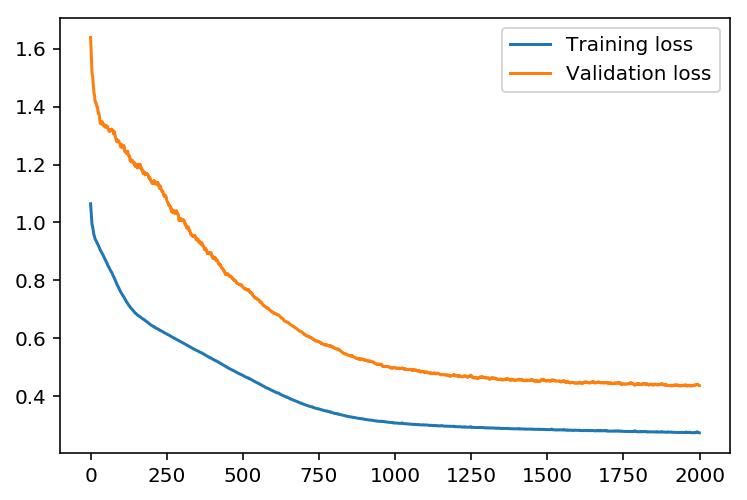

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## 检查预测结果

使用测试数据看看网络对数据建模的效果如何。如果完全错了，请确保网络中的每步都正确实现。

C:\Users\KevinRuan\AppData\Local\conda\conda\envs\flappybird\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


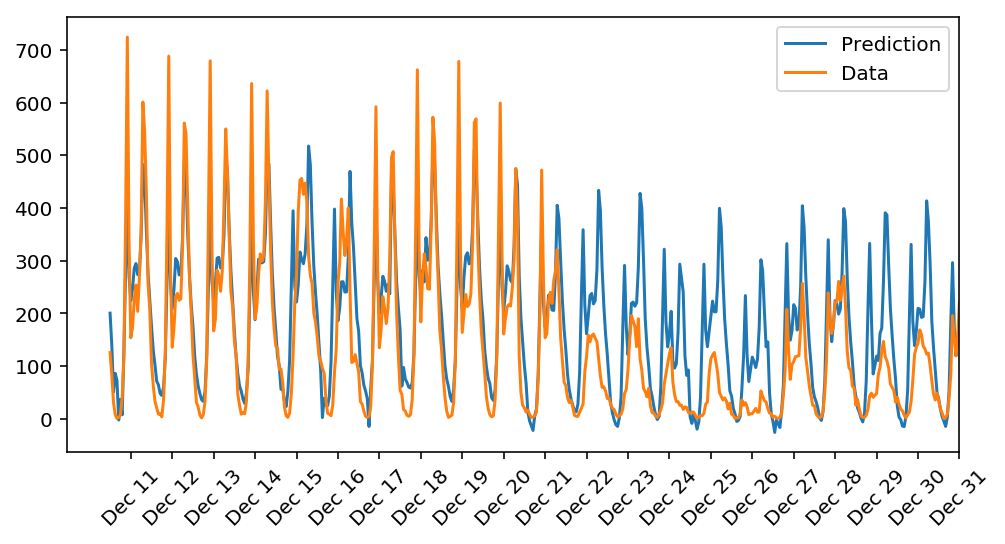

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## 可选：思考下你的结果（我们不会评估这道题的答案）

 
请针对你的结果回答以下问题。模型对数据的预测效果如何？哪里出现问题了？为何出现问题呢？

> **注意**：你可以通过双击该单元编辑文本。如果想要预览文本，请按 Control + Enter

#### 请将你的答案填写在下方
迭代次数为100时，模型对数据的预测效果不好。
这是因为迭代次数不够，训练损失还很大，训练损失还没有收敛。
通过增加迭代次数到2000次，可以看出，在迭代1000次后，模型的训练损失达到很低，且随着迭代次数的增加，训练损失下降不明显。
因此，可以设置迭代次数为1000次，此时，模型对数据的预测效果很好。